In [1]:
# Wisconsin Diagnostic data

In [2]:
# importing packages and Libraries
# For data analysis and preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# For Ml models 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score
from collections import OrderedDict

In [3]:
#Loading dataset
wisconsin_data = pd.read_csv('wisconsin dataset.csv')

In [4]:
# Data Analysis and preprocessing

In [5]:
# Checking number of Features, instances and data types
print("Total instances",wisconsin_data.shape[0])
print("Total number of features are ", wisconsin_data.shape[1])
print("Data Types:", wisconsin_data.dtypes)

Total instances 569
Total number of features are  32
Data Types: id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst         

In [6]:
#Checking class labels and distribution 
class_counts= wisconsin_data['diagnosis'].value_counts()
print(class_counts)

B    357
M    212
Name: diagnosis, dtype: int64


In [7]:
# Class label mapping 
data_target= wisconsin_data['diagnosis'].map({'B': 0, 'M': 1})

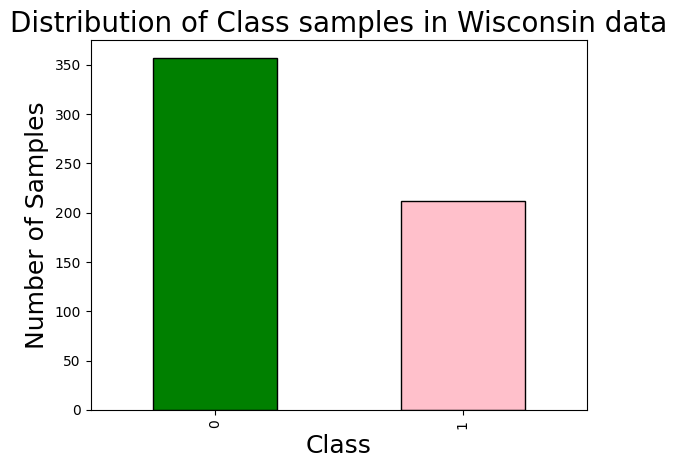

In [8]:
#visualizing class distribution in the dataset
class_distribution = data_target.value_counts().sort_index() 
class_distribution.plot(kind='bar', color=['green', 'pink'], edgecolor="black")
plt.xlabel("Class", fontsize=18)
plt.ylabel("Number of Samples", fontsize=18)
plt.title("Distribution of Class samples in Wisconsin data", fontsize=20)
plt.show()

In [9]:
# checking for missing data
missing_data= wisconsin_data.isnull().sum()
print(missing_data)

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


C:\Users\de_de\AppData\Local\Temp\ipykernel_91920\104457638.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = wisconsin_data.corr()


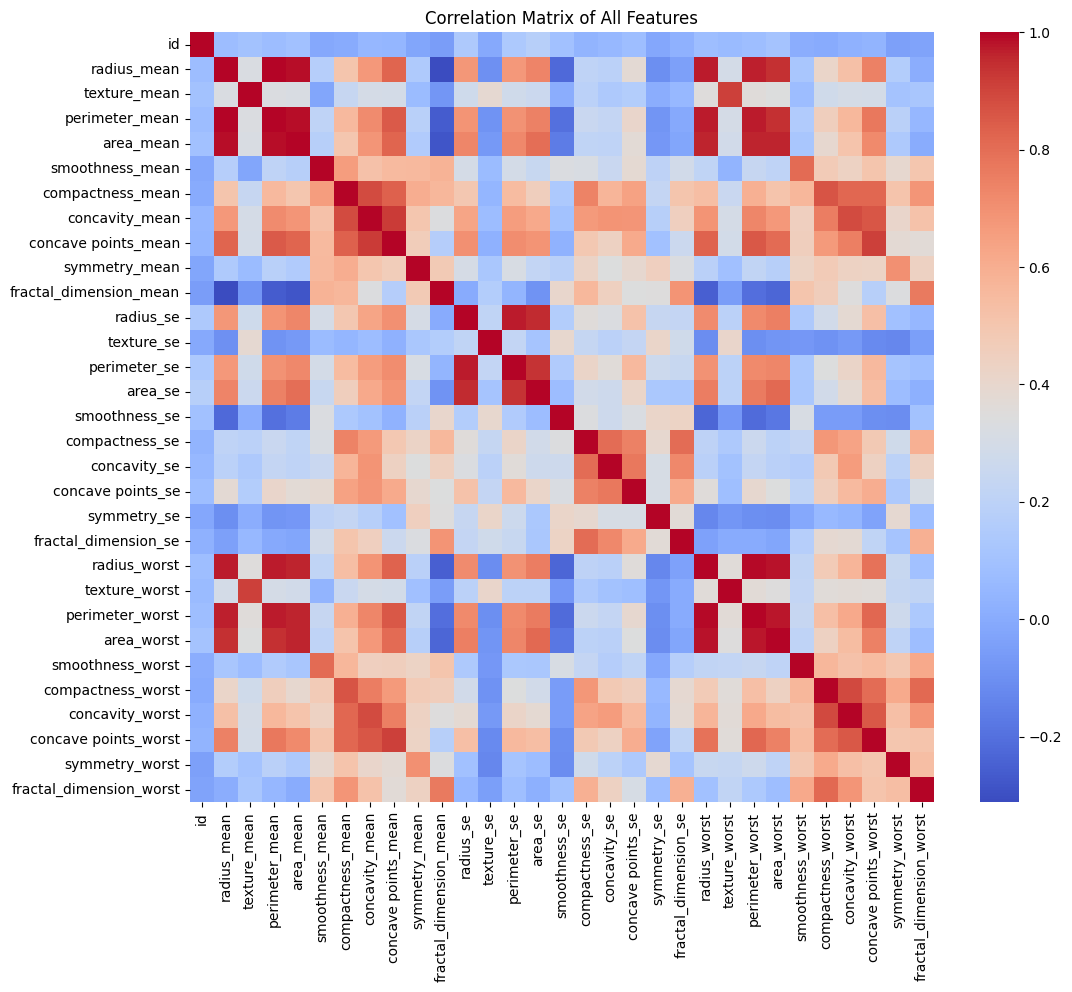

In [10]:
# checking Feature Correlation
correlation_matrix = wisconsin_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Matrix of All Features')
plt.show()


In [11]:
correlation_threshold = 0.8
correlated_features = {}
for feature1 in correlation_matrix.columns:
    for feature2 in correlation_matrix.columns:
        if feature1 != feature2:
            correlation_value = correlation_matrix.loc[feature1, feature2]
            if abs(correlation_value) > correlation_threshold:
                if feature1 not in correlated_features:
                    correlated_features[feature1] = [feature2]
                else:
                    correlated_features[feature1].append(feature2)
for feature, correlated_list in correlated_features.items():
    print(f"{feature} is correlated with: {', '.join(correlated_list)}")

radius_mean is correlated with: perimeter_mean, area_mean, concave points_mean, radius_worst, perimeter_worst, area_worst
texture_mean is correlated with: texture_worst
perimeter_mean is correlated with: radius_mean, area_mean, concave points_mean, radius_worst, perimeter_worst, area_worst
area_mean is correlated with: radius_mean, perimeter_mean, concave points_mean, area_se, radius_worst, perimeter_worst, area_worst
smoothness_mean is correlated with: smoothness_worst
compactness_mean is correlated with: concavity_mean, concave points_mean, compactness_worst, concavity_worst, concave points_worst
concavity_mean is correlated with: compactness_mean, concave points_mean, concavity_worst, concave points_worst
concave points_mean is correlated with: radius_mean, perimeter_mean, area_mean, compactness_mean, concavity_mean, radius_worst, perimeter_worst, area_worst, concave points_worst
radius_se is correlated with: perimeter_se, area_se
perimeter_se is correlated with: radius_se, area_se


In [12]:
# Remaining features after eliminationg highly correlated + id feature (feature selection)
selected_features = ['texture_mean', 'area_mean', 'smoothness_mean', 'concavity_mean', 'symmetry_mean', 'fractal_dimension_mean', 
                      'texture_se', 'area_se', 'smoothness_se', 'concavity_se', 'symmetry_se', 'fractal_dimension_se', 
                      'smoothness_worst', 'compactness_worst', 'symmetry_worst', 'fractal_dimension_worst']

clean_df = wisconsin_data[selected_features]
remaining_features = clean_df.columns
print("Remaining features:", len(remaining_features))


Remaining features: 16


In [13]:
#Data Split (80:20)
X = clean_df
y = data_target
random_state=123
feature_names = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

In [14]:
# Normalize data
sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform (X_test)

In [15]:
# SMOTE for data imbalance handling
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=random_state)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
print("Class distribution after SMOTE:",y_train_resampled.value_counts())

Class distribution after SMOTE: 0    285
1    285
Name: diagnosis, dtype: int64


In [16]:
# Ml Models Hyperparameter optimization, training ,testing, performance and Interpretability

In [17]:
# 1. Decision Tree

# Hyperparameters optimization using randomized search
dt_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 5, 10, 20], 
    'min_samples_split': [2, 5, 10, 15, 20, 30, 40],
    'min_samples_leaf': [1, 2, 4]
}


search_dt = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=random_state),
    param_distributions=dt_params,
    n_iter=50,  
    cv=5,
    scoring='f1',
    verbose=1
)

# DT training
search_dt.fit(X_train_resampled, y_train_resampled)
best_params_dt = search_dt.best_params_
print("Best Parameters:", best_params_dt)
print("Best f1 score for DT during training ", search_dt.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'splitter': 'random', 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'entropy'}
Best f1 score for DT during training  0.9423272023482305


In [18]:
# DT Testing 
best_dt_model =search_dt.best_estimator_
y_pred_dt = best_dt_model.predict(X_test_scaled)

# DT Performance evaluation
print("\nEvaluation Metrics for dt:")
accuracy = accuracy_score(y_test, y_pred_dt)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_dt)
print("Precision:", precision)
recall = recall_score(y_test, y_pred_dt)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_dt)
print("F1 Score:", f1)
f_beta = fbeta_score(y_test, y_pred_dt, beta=2)
print("F2 Score:", f_beta)
auc = roc_auc_score(y_test,best_dt_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc)


Evaluation Metrics for dt:
Accuracy: 0.8859649122807017
Precision: 0.8085106382978723
Recall: 0.9047619047619048
F1 Score: 0.853932584269663
F2 Score: 0.8837209302325582
AUC: 0.9621362433862435


In [19]:
# Test set instance 1 would be used for local interpretability
instance = X_test.iloc[0]
feature_dict = instance.to_dict()
print("Feature Dictionary:", feature_dict)

Feature Dictionary: {'texture_mean': 13.08, 'area_mean': 381.9, 'smoothness_mean': 0.09754, 'concavity_mean': 0.01982, 'symmetry_mean': 0.183, 'fractal_dimension_mean': 0.06105, 'texture_se': 0.7815, 'area_se': 15.48, 'smoothness_se': 0.009019, 'concavity_se': 0.01196, 'symmetry_se': 0.02388, 'fractal_dimension_se': 0.001619, 'smoothness_worst': 0.1341, 'compactness_worst': 0.08971, 'symmetry_worst': 0.2859, 'fractal_dimension_worst': 0.06772}


In [20]:
# as standardized data was used for model training and testing, we need to define scaled data instance for explaianbility as well
instance_to_explain = X_test_scaled[0, :].reshape(1, -1) 

In [21]:
# Model prediction and feature relevance based on decision path - Interpretability
prediction = best_dt_model.predict(instance_to_explain)[0]
print(f"Model Prediction: {prediction}")
feature_relevance = OrderedDict({feature: 0 for feature in X_test.columns.tolist()})
decision_path = best_dt_model.decision_path(instance_to_explain).toarray()
nodes_in_path = np.where(decision_path[0] == 1)[0]

for node in nodes_in_path:
    feature_index = best_dt_model.tree_.feature[node]
    if feature_index != -1 and feature_index < len(X_test.columns):
        feature_name = X_test.columns[feature_index]
        feature_relevance[feature_name] += 1

Model Prediction: 0


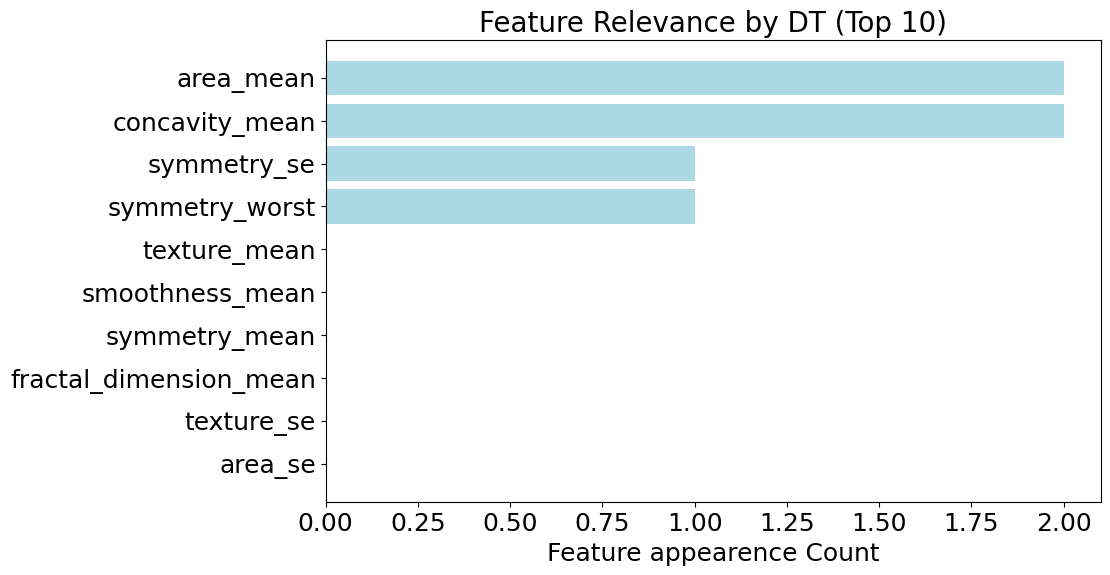

In [22]:
#visualising feature relevance by DT in descending order
sorted_feature_relevance = dict(sorted(feature_relevance.items(), key=lambda item: item[1], reverse=True))
feature_names = list(sorted_feature_relevance.keys())[:10]
feature_values = list(sorted_feature_relevance.values())[:10]
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_values, color='lightblue')
plt.gca().tick_params(labelsize=18)
plt.xlabel('Feature appearence Count', fontsize=18)
plt.title('Feature Relevance by DT (Top 10)', fontsize=20)
plt.gca().invert_yaxis() 
plt.show()

In [23]:
# 2. Random forest

# Hyperparameter Optimization
rf_params = {
    'n_estimators': [10, 15, 20, 25, 30, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 15, 20, 30, 40],
    'min_samples_leaf': [1, 2, 4]
}

rf_classifier = RandomizedSearchCV(
    RandomForestClassifier(random_state=random_state),
    param_distributions=rf_params,
    n_iter=50,  
    cv=5,
    scoring='f1',
    verbose=1
)

# RF training
rf_classifier.fit(X_train_resampled, y_train_resampled)

best_params_rf = rf_classifier.best_params_
print("Best Parameters:", best_params_rf)
print("Best f1 score for Rf during training: ", rf_classifier.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'entropy'}
Best f1 score for Rf during training:  0.9697252848502004


In [24]:
# RF Testing
best_rf_model = rf_classifier.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_scaled)

# RF performance Evaluation
print("\nEvaluation Metrics for Random Forest:")
accuracy= accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_rf)
print("Precision:", precision)
recall= recall_score(y_test, y_pred_rf)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_rf)
print("F1 Score:", f1)
f_beta = fbeta_score(y_test, y_pred_rf, beta=2)
print("F2 Score:", f_beta)
auc= roc_auc_score(y_test, best_rf_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc)


Evaluation Metrics for Random Forest:
Accuracy: 0.9210526315789473
Precision: 0.851063829787234
Recall: 0.9523809523809523
F1 Score: 0.898876404494382
F2 Score: 0.9302325581395348
AUC: 0.9851190476190476


In [25]:
# Feature importance for feature relavence- Interpretability
prediction = best_rf_model.predict(instance_to_explain)[0]
print(f"Model Prediction: {prediction}")
feature_names = list(X_train.columns) 
num_features = len(feature_names)
rf_feature_importances = best_rf_model.feature_importances_
sorted_indices = np.argsort(rf_feature_importances)[::-1]
top_feature_indices = sorted_indices[:min(10, num_features)]
top_10_feature_names = [feature_names[idx] for idx in top_feature_indices]
top_10_feature_importances = [rf_feature_importances[idx] for idx in top_feature_indices]

Model Prediction: 0


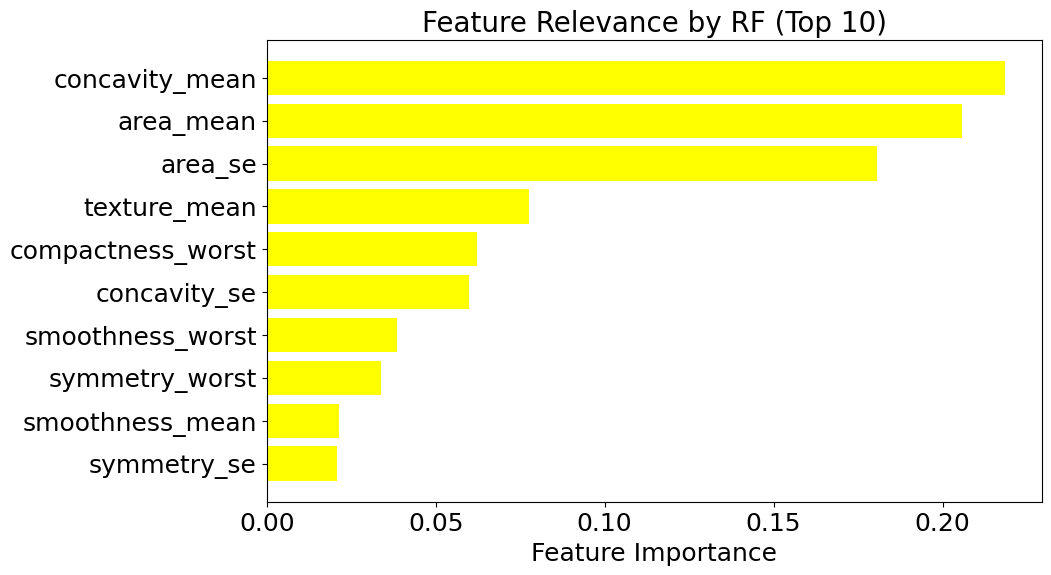

In [26]:
# Visualising the fetaure relevance by RF
plt.figure(figsize=(10, 6))
plt.barh(top_10_feature_names, top_10_feature_importances, color='yellow')  
plt.gca().tick_params(labelsize=18)  
plt.xlabel('Feature Importance', fontsize=18) 
plt.title('Feature Relevance by RF (Top 10)', fontsize=20)  
plt.gca().invert_yaxis()
plt.show()

In [27]:
# 3. TabNet

# Hyperparameters optimization

tabnet_params = {
    'n_d': [8, 16, 32],
    'n_a': [8, 16, 32],
    'n_steps': [3, 5, 7],
    'gamma': [1.0, 1.3, 1.8],
    'lambda_sparse': [0.001, 0.005, 0.01],
}

search_tabnet = RandomizedSearchCV(
    TabNetClassifier(),
    param_distributions=tabnet_params,
    n_iter=50,
    cv=5,
    verbose=1,
    scoring='f1'
)

# Tabnet Training
search_tabnet.fit(
    X_train_resampled,
    y_train_resampled,
    eval_set=[(X_test_scaled, y_test)],
    max_epochs=100,
    patience=10,
    batch_size=20
)

best_params_tabnet = search_tabnet.best_params_
print("Best Parameters for TabNet:", best_params_tabnet)
print("Best f1 score Tabnet during training: ", search_tabnet.best_score_)

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
epoch 0  | loss: 0.89685 | val_0_auc: 0.90112 |  0:00:01s
epoch 1  | loss: 0.51146 | val_0_auc: 0.7381  |  0:00:03s
epoch 2  | loss: 0.49092 | val_0_auc: 0.89385 |  0:00:05s
epoch 3  | loss: 0.45379 | val_0_auc: 0.96693 |  0:00:06s
epoch 4  | loss: 0.36467 | val_0_auc: 0.95569 |  0:00:08s
epoch 5  | loss: 0.33536 | val_0_auc: 0.92493 |  0:00:10s
epoch 6  | loss: 0.45567 | val_0_auc: 0.90906 |  0:00:12s
epoch 7  | loss: 0.34412 | val_0_auc: 0.95238 |  0:00:13s
epoch 8  | loss: 0.29384 | val_0_auc: 0.94577 |  0:00:15s
epoch 9  | loss: 0.32418 | val_0_auc: 0.94048 |  0:00:17s
epoch 10 | loss: 0.3173  | val_0_auc: 0.97917 |  0:00:18s
epoch 11 | loss: 0.18583 | val_0_auc: 0.95238 |  0:00:20s
epoch 12 | loss: 0.26488 | val_0_auc: 0.95866 |  0:00:22s
epoch 13 | loss: 0.25872 | val_0_auc: 0.95271 |  0:00:24s
epoch 14 | loss: 0.20864 | val_0_auc: 0.95304 |  0:00:25s
epoch 15 | loss: 0.25622 | val_0_auc: 0.96065 |  0:00:27s
epoch 16 |

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.10849 | val_0_auc: 0.75661 |  0:00:01s
epoch 1  | loss: 0.45366 | val_0_auc: 0.9289  |  0:00:02s
epoch 2  | loss: 0.55432 | val_0_auc: 0.8502  |  0:00:04s
epoch 3  | loss: 0.44427 | val_0_auc: 0.85813 |  0:00:05s
epoch 4  | loss: 0.44816 | val_0_auc: 0.82606 |  0:00:06s
epoch 5  | loss: 0.37309 | val_0_auc: 0.9127  |  0:00:08s
epoch 6  | loss: 0.24403 | val_0_auc: 0.95337 |  0:00:09s
epoch 7  | loss: 0.23221 | val_0_auc: 0.93022 |  0:00:11s
epoch 8  | loss: 0.27036 | val_0_auc: 0.96627 |  0:00:12s
epoch 9  | loss: 0.36667 | val_0_auc: 0.93585 |  0:00:14s
epoch 10 | loss: 0.3194  | val_0_auc: 0.90906 |  0:00:15s
epoch 11 | loss: 0.32105 | val_0_auc: 0.97983 |  0:00:16s
epoch 12 | loss: 0.2171  | val_0_auc: 0.94676 |  0:00:18s
epoch 13 | loss: 0.33251 | val_0_auc: 0.95635 |  0:00:19s
epoch 14 | loss: 0.27198 | val_0_auc: 0.91832 |  0:00:21s
epoch 15 | loss: 0.27518 | val_0_auc: 0.95569 |  0:00:22s
epoch 16 | loss: 0.23539 | val_0_auc: 0.9752  |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.86101 | val_0_auc: 0.84557 |  0:00:01s
epoch 1  | loss: 0.77181 | val_0_auc: 0.96792 |  0:00:03s
epoch 2  | loss: 0.64339 | val_0_auc: 0.93353 |  0:00:04s
epoch 3  | loss: 0.29414 | val_0_auc: 0.94478 |  0:00:05s
epoch 4  | loss: 0.49249 | val_0_auc: 0.86111 |  0:00:07s
epoch 5  | loss: 0.35875 | val_0_auc: 0.97222 |  0:00:08s
epoch 6  | loss: 0.34807 | val_0_auc: 0.93816 |  0:00:10s
epoch 7  | loss: 0.31525 | val_0_auc: 0.95437 |  0:00:11s
epoch 8  | loss: 0.23299 | val_0_auc: 0.96396 |  0:00:13s
epoch 9  | loss: 0.26513 | val_0_auc: 0.95833 |  0:00:14s
epoch 10 | loss: 0.25519 | val_0_auc: 0.97388 |  0:00:16s
epoch 11 | loss: 0.49205 | val_0_auc: 0.97321 |  0:00:17s
epoch 12 | loss: 0.26213 | val_0_auc: 0.97652 |  0:00:19s
epoch 13 | loss: 0.27225 | val_0_auc: 0.95635 |  0:00:20s
epoch 14 | loss: 0.30701 | val_0_auc: 0.9547  |  0:00:22s
epoch 15 | loss: 0.23583 | val_0_auc: 0.94709 |  0:00:23s
epoch 16 | loss: 0.19528 | val_0_auc: 0.96892 |  0:00:25s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.99772 | val_0_auc: 0.85549 |  0:00:01s
epoch 1  | loss: 0.62936 | val_0_auc: 0.8244  |  0:00:02s
epoch 2  | loss: 0.55911 | val_0_auc: 0.9289  |  0:00:04s
epoch 3  | loss: 0.43601 | val_0_auc: 0.92593 |  0:00:05s
epoch 4  | loss: 0.34853 | val_0_auc: 0.92229 |  0:00:07s
epoch 5  | loss: 0.2421  | val_0_auc: 0.95238 |  0:00:08s
epoch 6  | loss: 0.40214 | val_0_auc: 0.94213 |  0:00:10s
epoch 7  | loss: 0.27344 | val_0_auc: 0.9709  |  0:00:11s
epoch 8  | loss: 0.28717 | val_0_auc: 0.95767 |  0:00:12s
epoch 9  | loss: 0.2504  | val_0_auc: 0.97884 |  0:00:14s
epoch 10 | loss: 0.14284 | val_0_auc: 0.95866 |  0:00:15s
epoch 11 | loss: 0.29877 | val_0_auc: 0.97288 |  0:00:17s
epoch 12 | loss: 0.26434 | val_0_auc: 0.92725 |  0:00:18s
epoch 13 | loss: 0.27693 | val_0_auc: 0.98512 |  0:00:20s
epoch 14 | loss: 0.22461 | val_0_auc: 0.9881  |  0:00:21s
epoch 15 | loss: 0.20713 | val_0_auc: 0.98512 |  0:00:23s
epoch 16 | loss: 0.18883 | val_0_auc: 0.95238 |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.07479 | val_0_auc: 0.83366 |  0:00:01s
epoch 1  | loss: 0.49894 | val_0_auc: 0.93585 |  0:00:02s
epoch 2  | loss: 0.4348  | val_0_auc: 0.94213 |  0:00:04s
epoch 3  | loss: 0.4323  | val_0_auc: 0.85053 |  0:00:05s
epoch 4  | loss: 0.35596 | val_0_auc: 0.91766 |  0:00:07s
epoch 5  | loss: 0.42135 | val_0_auc: 0.93552 |  0:00:08s
epoch 6  | loss: 0.36195 | val_0_auc: 0.92593 |  0:00:09s
epoch 7  | loss: 0.29098 | val_0_auc: 0.85417 |  0:00:11s
epoch 8  | loss: 0.36681 | val_0_auc: 0.95106 |  0:00:12s
epoch 9  | loss: 0.28852 | val_0_auc: 0.96825 |  0:00:13s
epoch 10 | loss: 0.25383 | val_0_auc: 0.93948 |  0:00:15s
epoch 11 | loss: 0.20706 | val_0_auc: 0.97884 |  0:00:16s
epoch 12 | loss: 0.21989 | val_0_auc: 0.98148 |  0:00:18s
epoch 13 | loss: 0.27373 | val_0_auc: 0.96925 |  0:00:19s
epoch 14 | loss: 0.24182 | val_0_auc: 0.95833 |  0:00:21s
epoch 15 | loss: 0.22714 | val_0_auc: 0.97851 |  0:00:22s
epoch 16 | loss: 0.1918  | val_0_auc: 0.97454 |  0:00:23s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73203 | val_0_auc: 0.82044 |  0:00:01s
epoch 1  | loss: 0.45386 | val_0_auc: 0.90906 |  0:00:03s
epoch 2  | loss: 0.38381 | val_0_auc: 0.81845 |  0:00:04s
epoch 3  | loss: 0.35617 | val_0_auc: 0.90675 |  0:00:06s
epoch 4  | loss: 0.58485 | val_0_auc: 0.94974 |  0:00:07s
epoch 5  | loss: 0.55504 | val_0_auc: 0.94147 |  0:00:09s
epoch 6  | loss: 0.34655 | val_0_auc: 0.95602 |  0:00:10s
epoch 7  | loss: 0.28297 | val_0_auc: 0.97321 |  0:00:12s
epoch 8  | loss: 0.28874 | val_0_auc: 0.92989 |  0:00:13s
epoch 9  | loss: 0.35783 | val_0_auc: 0.95106 |  0:00:14s
epoch 10 | loss: 0.37154 | val_0_auc: 0.94742 |  0:00:16s
epoch 11 | loss: 0.18231 | val_0_auc: 0.96627 |  0:00:17s
epoch 12 | loss: 0.28615 | val_0_auc: 0.93386 |  0:00:18s
epoch 13 | loss: 0.2985  | val_0_auc: 0.96098 |  0:00:20s
epoch 14 | loss: 0.29818 | val_0_auc: 0.98049 |  0:00:21s
epoch 15 | loss: 0.22809 | val_0_auc: 0.96329 |  0:00:22s
epoch 16 | loss: 0.27013 | val_0_auc: 0.97718 |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.58376 | val_0_auc: 0.94345 |  0:00:01s
epoch 1  | loss: 0.34739 | val_0_auc: 0.88823 |  0:00:02s
epoch 2  | loss: 0.29955 | val_0_auc: 0.86409 |  0:00:04s
epoch 3  | loss: 0.34751 | val_0_auc: 0.95172 |  0:00:05s
epoch 4  | loss: 0.25194 | val_0_auc: 0.96098 |  0:00:06s
epoch 5  | loss: 0.31374 | val_0_auc: 0.95304 |  0:00:08s
epoch 6  | loss: 0.2594  | val_0_auc: 0.96362 |  0:00:09s
epoch 7  | loss: 0.26682 | val_0_auc: 0.97354 |  0:00:10s
epoch 8  | loss: 0.22784 | val_0_auc: 0.98181 |  0:00:12s
epoch 9  | loss: 0.23097 | val_0_auc: 0.97321 |  0:00:13s
epoch 10 | loss: 0.19997 | val_0_auc: 0.97851 |  0:00:14s
epoch 11 | loss: 0.27864 | val_0_auc: 0.94841 |  0:00:16s
epoch 12 | loss: 0.3029  | val_0_auc: 0.97917 |  0:00:17s
epoch 13 | loss: 0.21649 | val_0_auc: 0.96925 |  0:00:18s
epoch 14 | loss: 0.23927 | val_0_auc: 0.97024 |  0:00:20s
epoch 15 | loss: 0.16227 | val_0_auc: 0.96991 |  0:00:21s
epoch 16 | loss: 0.20124 | val_0_auc: 0.96329 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70176 | val_0_auc: 0.79795 |  0:00:01s
epoch 1  | loss: 0.52613 | val_0_auc: 0.89352 |  0:00:02s
epoch 2  | loss: 0.34992 | val_0_auc: 0.94411 |  0:00:04s
epoch 3  | loss: 0.44081 | val_0_auc: 0.93386 |  0:00:05s
epoch 4  | loss: 0.31315 | val_0_auc: 0.94841 |  0:00:07s
epoch 5  | loss: 0.3054  | val_0_auc: 0.93254 |  0:00:08s
epoch 6  | loss: 0.27003 | val_0_auc: 0.90344 |  0:00:10s
epoch 7  | loss: 0.33243 | val_0_auc: 0.94974 |  0:00:11s
epoch 8  | loss: 0.24007 | val_0_auc: 0.96396 |  0:00:13s
epoch 9  | loss: 0.24419 | val_0_auc: 0.9461  |  0:00:14s
epoch 10 | loss: 0.2468  | val_0_auc: 0.9709  |  0:00:16s
epoch 11 | loss: 0.16229 | val_0_auc: 0.98479 |  0:00:17s
epoch 12 | loss: 0.22232 | val_0_auc: 0.96991 |  0:00:18s
epoch 13 | loss: 0.24662 | val_0_auc: 0.95437 |  0:00:20s
epoch 14 | loss: 0.18728 | val_0_auc: 0.97156 |  0:00:21s
epoch 15 | loss: 0.24289 | val_0_auc: 0.9709  |  0:00:23s
epoch 16 | loss: 0.20431 | val_0_auc: 0.96693 |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.78001 | val_0_auc: 0.74603 |  0:00:01s
epoch 1  | loss: 0.56531 | val_0_auc: 0.79299 |  0:00:03s
epoch 2  | loss: 0.45316 | val_0_auc: 0.77249 |  0:00:04s
epoch 3  | loss: 0.44887 | val_0_auc: 0.87004 |  0:00:06s
epoch 4  | loss: 0.3892  | val_0_auc: 0.85913 |  0:00:08s
epoch 5  | loss: 0.41595 | val_0_auc: 0.81085 |  0:00:09s
epoch 6  | loss: 0.42647 | val_0_auc: 0.65245 |  0:00:11s
epoch 7  | loss: 0.38788 | val_0_auc: 0.76124 |  0:00:12s
epoch 8  | loss: 0.30051 | val_0_auc: 0.82937 |  0:00:14s
epoch 9  | loss: 0.30027 | val_0_auc: 0.9375  |  0:00:15s
epoch 10 | loss: 0.2706  | val_0_auc: 0.93485 |  0:00:17s
epoch 11 | loss: 0.28533 | val_0_auc: 0.95536 |  0:00:18s
epoch 12 | loss: 0.22703 | val_0_auc: 0.95073 |  0:00:20s
epoch 13 | loss: 0.28467 | val_0_auc: 0.96197 |  0:00:21s
epoch 14 | loss: 0.26291 | val_0_auc: 0.97388 |  0:00:23s
epoch 15 | loss: 0.19331 | val_0_auc: 0.98016 |  0:00:24s
epoch 16 | loss: 0.22477 | val_0_auc: 0.96032 |  0:00:26s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.6904  | val_0_auc: 0.47619 |  0:00:01s
epoch 1  | loss: 0.37263 | val_0_auc: 0.80159 |  0:00:03s
epoch 2  | loss: 0.40923 | val_0_auc: 0.84656 |  0:00:04s
epoch 3  | loss: 0.36601 | val_0_auc: 0.95933 |  0:00:06s
epoch 4  | loss: 0.29905 | val_0_auc: 0.94246 |  0:00:07s
epoch 5  | loss: 0.37826 | val_0_auc: 0.97884 |  0:00:09s
epoch 6  | loss: 0.25122 | val_0_auc: 0.95503 |  0:00:11s
epoch 7  | loss: 0.31709 | val_0_auc: 0.97255 |  0:00:12s
epoch 8  | loss: 0.32024 | val_0_auc: 0.9504  |  0:00:14s
epoch 9  | loss: 0.32817 | val_0_auc: 0.97288 |  0:00:15s
epoch 10 | loss: 0.23676 | val_0_auc: 0.96065 |  0:00:17s
epoch 11 | loss: 0.25751 | val_0_auc: 0.98446 |  0:00:19s
epoch 12 | loss: 0.3276  | val_0_auc: 0.95139 |  0:00:20s
epoch 13 | loss: 0.24538 | val_0_auc: 0.95933 |  0:00:22s
epoch 14 | loss: 0.21548 | val_0_auc: 0.94907 |  0:00:24s
epoch 15 | loss: 0.32733 | val_0_auc: 0.93386 |  0:00:25s
epoch 16 | loss: 0.32828 | val_0_auc: 0.96429 |  0:00:27s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.08183 | val_0_auc: 0.76224 |  0:00:01s
epoch 1  | loss: 0.76064 | val_0_auc: 0.83201 |  0:00:03s
epoch 2  | loss: 0.60492 | val_0_auc: 0.89021 |  0:00:04s
epoch 3  | loss: 0.51201 | val_0_auc: 0.7996  |  0:00:06s
epoch 4  | loss: 0.36534 | val_0_auc: 0.90873 |  0:00:08s
epoch 5  | loss: 0.28104 | val_0_auc: 0.88029 |  0:00:09s
epoch 6  | loss: 0.3985  | val_0_auc: 0.93618 |  0:00:10s
epoch 7  | loss: 0.27289 | val_0_auc: 0.95767 |  0:00:12s
epoch 8  | loss: 0.28125 | val_0_auc: 0.93353 |  0:00:14s
epoch 9  | loss: 0.31082 | val_0_auc: 0.95536 |  0:00:15s
epoch 10 | loss: 0.20136 | val_0_auc: 0.96528 |  0:00:16s
epoch 11 | loss: 0.22101 | val_0_auc: 0.9494  |  0:00:18s
epoch 12 | loss: 0.16908 | val_0_auc: 0.96296 |  0:00:19s
epoch 13 | loss: 0.23089 | val_0_auc: 0.94874 |  0:00:21s
epoch 14 | loss: 0.17942 | val_0_auc: 0.9709  |  0:00:22s
epoch 15 | loss: 0.25494 | val_0_auc: 0.97784 |  0:00:24s
epoch 16 | loss: 0.23649 | val_0_auc: 0.98049 |  0:00:26s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75676 | val_0_auc: 0.83565 |  0:00:01s
epoch 1  | loss: 0.58289 | val_0_auc: 0.8039  |  0:00:03s
epoch 2  | loss: 0.42793 | val_0_auc: 0.87765 |  0:00:05s
epoch 3  | loss: 0.46766 | val_0_auc: 0.9289  |  0:00:06s
epoch 4  | loss: 0.52453 | val_0_auc: 0.96362 |  0:00:08s
epoch 5  | loss: 0.54883 | val_0_auc: 0.94742 |  0:00:09s
epoch 6  | loss: 0.47731 | val_0_auc: 0.93089 |  0:00:11s
epoch 7  | loss: 0.25241 | val_0_auc: 0.95833 |  0:00:13s
epoch 8  | loss: 0.23964 | val_0_auc: 0.95701 |  0:00:15s
epoch 9  | loss: 0.27571 | val_0_auc: 0.96792 |  0:00:17s
epoch 10 | loss: 0.19397 | val_0_auc: 0.9537  |  0:00:18s
epoch 11 | loss: 0.21511 | val_0_auc: 0.94874 |  0:00:20s
epoch 12 | loss: 0.24615 | val_0_auc: 0.96396 |  0:00:21s
epoch 13 | loss: 0.31747 | val_0_auc: 0.9709  |  0:00:23s
epoch 14 | loss: 0.18095 | val_0_auc: 0.97288 |  0:00:25s
epoch 15 | loss: 0.17927 | val_0_auc: 0.97784 |  0:00:26s
epoch 16 | loss: 0.13029 | val_0_auc: 0.97652 |  0:00:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.03183 | val_0_auc: 0.81845 |  0:00:01s
epoch 1  | loss: 0.48986 | val_0_auc: 0.88657 |  0:00:03s
epoch 2  | loss: 0.79737 | val_0_auc: 0.93122 |  0:00:04s
epoch 3  | loss: 0.49692 | val_0_auc: 0.88095 |  0:00:06s
epoch 4  | loss: 0.4982  | val_0_auc: 0.8955  |  0:00:07s
epoch 5  | loss: 0.48591 | val_0_auc: 0.9504  |  0:00:09s
epoch 6  | loss: 0.35002 | val_0_auc: 0.92427 |  0:00:11s
epoch 7  | loss: 0.33204 | val_0_auc: 0.97884 |  0:00:12s
epoch 8  | loss: 0.33452 | val_0_auc: 0.95304 |  0:00:14s
epoch 9  | loss: 0.47324 | val_0_auc: 0.93122 |  0:00:15s
epoch 10 | loss: 0.26325 | val_0_auc: 0.9537  |  0:00:17s
epoch 11 | loss: 0.27557 | val_0_auc: 0.95007 |  0:00:19s
epoch 12 | loss: 0.24008 | val_0_auc: 0.95635 |  0:00:20s
epoch 13 | loss: 0.24703 | val_0_auc: 0.96065 |  0:00:22s
epoch 14 | loss: 0.2239  | val_0_auc: 0.94775 |  0:00:23s
epoch 15 | loss: 0.29363 | val_0_auc: 0.95304 |  0:00:25s
epoch 16 | loss: 0.21912 | val_0_auc: 0.96296 |  0:00:26s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.97842 | val_0_auc: 0.71958 |  0:00:01s
epoch 1  | loss: 0.69253 | val_0_auc: 0.8297  |  0:00:03s
epoch 2  | loss: 0.63584 | val_0_auc: 0.71197 |  0:00:04s
epoch 3  | loss: 0.55338 | val_0_auc: 0.88889 |  0:00:06s
epoch 4  | loss: 0.38767 | val_0_auc: 0.92824 |  0:00:07s
epoch 5  | loss: 0.34599 | val_0_auc: 0.9203  |  0:00:09s
epoch 6  | loss: 0.44615 | val_0_auc: 0.9127  |  0:00:11s
epoch 7  | loss: 0.40189 | val_0_auc: 0.89352 |  0:00:12s
epoch 8  | loss: 0.28664 | val_0_auc: 0.93849 |  0:00:14s
epoch 9  | loss: 0.32398 | val_0_auc: 0.95933 |  0:00:15s
epoch 10 | loss: 0.29732 | val_0_auc: 0.93485 |  0:00:17s
epoch 11 | loss: 0.25301 | val_0_auc: 0.95007 |  0:00:19s
epoch 12 | loss: 0.27866 | val_0_auc: 0.94444 |  0:00:20s
epoch 13 | loss: 0.22024 | val_0_auc: 0.95866 |  0:00:22s
epoch 14 | loss: 0.18314 | val_0_auc: 0.98545 |  0:00:23s
epoch 15 | loss: 0.20456 | val_0_auc: 0.97751 |  0:00:25s
epoch 16 | loss: 0.1908  | val_0_auc: 0.96329 |  0:00:27s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.17594 | val_0_auc: 0.91501 |  0:00:01s
epoch 1  | loss: 0.94694 | val_0_auc: 0.9203  |  0:00:03s
epoch 2  | loss: 0.64897 | val_0_auc: 0.87665 |  0:00:04s
epoch 3  | loss: 0.56197 | val_0_auc: 0.89649 |  0:00:06s
epoch 4  | loss: 0.44291 | val_0_auc: 0.93519 |  0:00:08s
epoch 5  | loss: 0.41219 | val_0_auc: 0.9332  |  0:00:09s
epoch 6  | loss: 0.30256 | val_0_auc: 0.94544 |  0:00:11s
epoch 7  | loss: 0.31307 | val_0_auc: 0.94378 |  0:00:12s
epoch 8  | loss: 0.2648  | val_0_auc: 0.96495 |  0:00:14s
epoch 9  | loss: 0.29262 | val_0_auc: 0.96528 |  0:00:16s
epoch 10 | loss: 0.2461  | val_0_auc: 0.95734 |  0:00:17s
epoch 11 | loss: 0.28329 | val_0_auc: 0.9547  |  0:00:19s
epoch 12 | loss: 0.25632 | val_0_auc: 0.95966 |  0:00:20s
epoch 13 | loss: 0.22431 | val_0_auc: 0.97817 |  0:00:22s
epoch 14 | loss: 0.20999 | val_0_auc: 0.97718 |  0:00:23s
epoch 15 | loss: 0.22007 | val_0_auc: 0.97189 |  0:00:25s
epoch 16 | loss: 0.16577 | val_0_auc: 0.95007 |  0:00:26s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.65439 | val_0_auc: 0.77381 |  0:00:00s
epoch 1  | loss: 0.45012 | val_0_auc: 0.8297  |  0:00:01s
epoch 2  | loss: 0.35405 | val_0_auc: 0.93882 |  0:00:02s
epoch 3  | loss: 0.32082 | val_0_auc: 0.97586 |  0:00:03s
epoch 4  | loss: 0.27701 | val_0_auc: 0.96329 |  0:00:04s
epoch 5  | loss: 0.32806 | val_0_auc: 0.94511 |  0:00:05s
epoch 6  | loss: 0.2864  | val_0_auc: 0.94511 |  0:00:06s
epoch 7  | loss: 0.30236 | val_0_auc: 0.97553 |  0:00:06s
epoch 8  | loss: 0.27989 | val_0_auc: 0.96858 |  0:00:07s
epoch 9  | loss: 0.17423 | val_0_auc: 0.95403 |  0:00:08s
epoch 10 | loss: 0.17266 | val_0_auc: 0.97718 |  0:00:09s
epoch 11 | loss: 0.18654 | val_0_auc: 0.96925 |  0:00:10s
epoch 12 | loss: 0.16334 | val_0_auc: 0.93849 |  0:00:11s
epoch 13 | loss: 0.18158 | val_0_auc: 0.96693 |  0:00:12s
epoch 14 | loss: 0.13409 | val_0_auc: 0.98545 |  0:00:13s
epoch 15 | loss: 0.22026 | val_0_auc: 0.98148 |  0:00:14s
epoch 16 | loss: 0.13032 | val_0_auc: 0.97718 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.62547 | val_0_auc: 0.89253 |  0:00:00s
epoch 1  | loss: 0.36432 | val_0_auc: 0.87566 |  0:00:01s
epoch 2  | loss: 0.32043 | val_0_auc: 0.94114 |  0:00:02s
epoch 3  | loss: 0.30061 | val_0_auc: 0.93519 |  0:00:03s
epoch 4  | loss: 0.25789 | val_0_auc: 0.93684 |  0:00:04s
epoch 5  | loss: 0.31888 | val_0_auc: 0.96131 |  0:00:05s
epoch 6  | loss: 0.22591 | val_0_auc: 0.94874 |  0:00:06s
epoch 7  | loss: 0.24117 | val_0_auc: 0.94808 |  0:00:07s
epoch 8  | loss: 0.27919 | val_0_auc: 0.9418  |  0:00:07s
epoch 9  | loss: 0.2038  | val_0_auc: 0.93783 |  0:00:08s
epoch 10 | loss: 0.15819 | val_0_auc: 0.93188 |  0:00:09s
epoch 11 | loss: 0.16555 | val_0_auc: 0.94213 |  0:00:10s
epoch 12 | loss: 0.19041 | val_0_auc: 0.96032 |  0:00:11s
epoch 13 | loss: 0.20789 | val_0_auc: 0.97321 |  0:00:12s
epoch 14 | loss: 0.1133  | val_0_auc: 0.97156 |  0:00:13s
epoch 15 | loss: 0.23627 | val_0_auc: 0.96925 |  0:00:14s
epoch 16 | loss: 0.1504  | val_0_auc: 0.97024 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68317 | val_0_auc: 0.83896 |  0:00:00s
epoch 1  | loss: 0.37103 | val_0_auc: 0.82837 |  0:00:01s
epoch 2  | loss: 0.29862 | val_0_auc: 0.61078 |  0:00:02s
epoch 3  | loss: 0.27754 | val_0_auc: 0.92262 |  0:00:03s
epoch 4  | loss: 0.2542  | val_0_auc: 0.96825 |  0:00:04s
epoch 5  | loss: 0.29941 | val_0_auc: 0.9246  |  0:00:05s
epoch 6  | loss: 0.19344 | val_0_auc: 0.96131 |  0:00:06s
epoch 7  | loss: 0.18996 | val_0_auc: 0.94511 |  0:00:07s
epoch 8  | loss: 0.28796 | val_0_auc: 0.95106 |  0:00:08s
epoch 9  | loss: 0.24512 | val_0_auc: 0.93783 |  0:00:08s
epoch 10 | loss: 0.15781 | val_0_auc: 0.97024 |  0:00:09s
epoch 11 | loss: 0.21508 | val_0_auc: 0.95602 |  0:00:10s
epoch 12 | loss: 0.20353 | val_0_auc: 0.98413 |  0:00:11s
epoch 13 | loss: 0.21677 | val_0_auc: 0.96958 |  0:00:12s
epoch 14 | loss: 0.14798 | val_0_auc: 0.98512 |  0:00:13s
epoch 15 | loss: 0.25683 | val_0_auc: 0.97586 |  0:00:14s
epoch 16 | loss: 0.18115 | val_0_auc: 0.97652 |  0:00:15s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.59738 | val_0_auc: 0.73512 |  0:00:00s
epoch 1  | loss: 0.34992 | val_0_auc: 0.96561 |  0:00:01s
epoch 2  | loss: 0.28314 | val_0_auc: 0.93651 |  0:00:02s
epoch 3  | loss: 0.27129 | val_0_auc: 0.95734 |  0:00:03s
epoch 4  | loss: 0.32922 | val_0_auc: 0.96759 |  0:00:04s
epoch 5  | loss: 0.22246 | val_0_auc: 0.96759 |  0:00:05s
epoch 6  | loss: 0.23571 | val_0_auc: 0.96164 |  0:00:06s
epoch 7  | loss: 0.20363 | val_0_auc: 0.97222 |  0:00:07s
epoch 8  | loss: 0.21027 | val_0_auc: 0.95238 |  0:00:07s
epoch 9  | loss: 0.24977 | val_0_auc: 0.98082 |  0:00:08s
epoch 10 | loss: 0.20945 | val_0_auc: 0.96296 |  0:00:09s
epoch 11 | loss: 0.21492 | val_0_auc: 0.97222 |  0:00:10s
epoch 12 | loss: 0.1879  | val_0_auc: 0.97222 |  0:00:11s
epoch 13 | loss: 0.22163 | val_0_auc: 0.96991 |  0:00:12s
epoch 14 | loss: 0.19354 | val_0_auc: 0.97751 |  0:00:13s
epoch 15 | loss: 0.21336 | val_0_auc: 0.97718 |  0:00:14s
epoch 16 | loss: 0.1497  | val_0_auc: 0.97487 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.64025 | val_0_auc: 0.73479 |  0:00:00s
epoch 1  | loss: 0.36081 | val_0_auc: 0.96032 |  0:00:01s
epoch 2  | loss: 0.4503  | val_0_auc: 0.96329 |  0:00:02s
epoch 3  | loss: 0.29342 | val_0_auc: 0.95007 |  0:00:03s
epoch 4  | loss: 0.20101 | val_0_auc: 0.97057 |  0:00:04s
epoch 5  | loss: 0.22892 | val_0_auc: 0.96396 |  0:00:05s
epoch 6  | loss: 0.26484 | val_0_auc: 0.97817 |  0:00:06s
epoch 7  | loss: 0.20725 | val_0_auc: 0.9871  |  0:00:07s
epoch 8  | loss: 0.25108 | val_0_auc: 0.98644 |  0:00:07s
epoch 9  | loss: 0.20381 | val_0_auc: 0.9828  |  0:00:08s
epoch 10 | loss: 0.16393 | val_0_auc: 0.98016 |  0:00:09s
epoch 11 | loss: 0.18715 | val_0_auc: 0.98644 |  0:00:10s
epoch 12 | loss: 0.23225 | val_0_auc: 0.99074 |  0:00:11s
epoch 13 | loss: 0.23137 | val_0_auc: 0.9666  |  0:00:12s
epoch 14 | loss: 0.19974 | val_0_auc: 0.98611 |  0:00:13s
epoch 15 | loss: 0.19947 | val_0_auc: 0.97751 |  0:00:14s
epoch 16 | loss: 0.16784 | val_0_auc: 0.97321 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.65468 | val_0_auc: 0.87302 |  0:00:01s
epoch 1  | loss: 0.44301 | val_0_auc: 0.92923 |  0:00:02s
epoch 2  | loss: 0.36311 | val_0_auc: 0.90443 |  0:00:03s
epoch 3  | loss: 0.34286 | val_0_auc: 0.94147 |  0:00:04s
epoch 4  | loss: 0.32778 | val_0_auc: 0.94874 |  0:00:05s
epoch 5  | loss: 0.29853 | val_0_auc: 0.93981 |  0:00:07s
epoch 6  | loss: 0.19031 | val_0_auc: 0.96693 |  0:00:08s
epoch 7  | loss: 0.25533 | val_0_auc: 0.95437 |  0:00:09s
epoch 8  | loss: 0.25909 | val_0_auc: 0.97156 |  0:00:10s
epoch 9  | loss: 0.23431 | val_0_auc: 0.97421 |  0:00:11s
epoch 10 | loss: 0.23693 | val_0_auc: 0.96296 |  0:00:13s
epoch 11 | loss: 0.181   | val_0_auc: 0.96065 |  0:00:14s
epoch 12 | loss: 0.13834 | val_0_auc: 0.96263 |  0:00:15s
epoch 13 | loss: 0.18278 | val_0_auc: 0.97222 |  0:00:16s
epoch 14 | loss: 0.22889 | val_0_auc: 0.9838  |  0:00:17s
epoch 15 | loss: 0.27886 | val_0_auc: 0.97586 |  0:00:19s
epoch 16 | loss: 0.22412 | val_0_auc: 0.97983 |  0:00:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7072  | val_0_auc: 0.82275 |  0:00:01s
epoch 1  | loss: 0.5156  | val_0_auc: 0.84722 |  0:00:02s
epoch 2  | loss: 0.45176 | val_0_auc: 0.93849 |  0:00:03s
epoch 3  | loss: 0.35469 | val_0_auc: 0.94907 |  0:00:04s
epoch 4  | loss: 0.27301 | val_0_auc: 0.94411 |  0:00:05s
epoch 5  | loss: 0.27235 | val_0_auc: 0.97354 |  0:00:07s
epoch 6  | loss: 0.24253 | val_0_auc: 0.93651 |  0:00:08s
epoch 7  | loss: 0.28947 | val_0_auc: 0.93618 |  0:00:09s
epoch 8  | loss: 0.2609  | val_0_auc: 0.95933 |  0:00:10s
epoch 9  | loss: 0.32877 | val_0_auc: 0.96925 |  0:00:12s
epoch 10 | loss: 0.2742  | val_0_auc: 0.9537  |  0:00:13s
epoch 11 | loss: 0.20943 | val_0_auc: 0.95304 |  0:00:14s
epoch 12 | loss: 0.17747 | val_0_auc: 0.96627 |  0:00:16s
epoch 13 | loss: 0.23964 | val_0_auc: 0.95899 |  0:00:17s
epoch 14 | loss: 0.18292 | val_0_auc: 0.9752  |  0:00:18s
epoch 15 | loss: 0.29577 | val_0_auc: 0.98776 |  0:00:20s
epoch 16 | loss: 0.23948 | val_0_auc: 0.96032 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61443 | val_0_auc: 0.95403 |  0:00:01s
epoch 1  | loss: 0.39935 | val_0_auc: 0.93056 |  0:00:02s
epoch 2  | loss: 0.35877 | val_0_auc: 0.85847 |  0:00:04s
epoch 3  | loss: 0.3734  | val_0_auc: 0.94676 |  0:00:05s
epoch 4  | loss: 0.2846  | val_0_auc: 0.93287 |  0:00:07s
epoch 5  | loss: 0.24132 | val_0_auc: 0.9709  |  0:00:08s
epoch 6  | loss: 0.28234 | val_0_auc: 0.96991 |  0:00:10s
epoch 7  | loss: 0.27933 | val_0_auc: 0.96263 |  0:00:11s
epoch 8  | loss: 0.28744 | val_0_auc: 0.9494  |  0:00:13s
epoch 9  | loss: 0.31855 | val_0_auc: 0.97421 |  0:00:14s
epoch 10 | loss: 0.22674 | val_0_auc: 0.97288 |  0:00:15s
epoch 11 | loss: 0.30642 | val_0_auc: 0.96197 |  0:00:17s
epoch 12 | loss: 0.22233 | val_0_auc: 0.96991 |  0:00:18s
epoch 13 | loss: 0.20795 | val_0_auc: 0.98479 |  0:00:19s
epoch 14 | loss: 0.19182 | val_0_auc: 0.98942 |  0:00:21s
epoch 15 | loss: 0.19452 | val_0_auc: 0.96594 |  0:00:22s
epoch 16 | loss: 0.22903 | val_0_auc: 0.96197 |  0:00:23s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.57944 | val_0_auc: 0.72884 |  0:00:01s
epoch 1  | loss: 0.43678 | val_0_auc: 0.84458 |  0:00:02s
epoch 2  | loss: 0.37606 | val_0_auc: 0.85284 |  0:00:04s
epoch 3  | loss: 0.34845 | val_0_auc: 0.92328 |  0:00:05s
epoch 4  | loss: 0.33858 | val_0_auc: 0.92791 |  0:00:06s
epoch 5  | loss: 0.24028 | val_0_auc: 0.92229 |  0:00:07s
epoch 6  | loss: 0.44127 | val_0_auc: 0.95304 |  0:00:09s
epoch 7  | loss: 0.2816  | val_0_auc: 0.95503 |  0:00:10s
epoch 8  | loss: 0.23386 | val_0_auc: 0.96065 |  0:00:11s
epoch 9  | loss: 0.26731 | val_0_auc: 0.96032 |  0:00:13s
epoch 10 | loss: 0.22246 | val_0_auc: 0.94064 |  0:00:14s
epoch 11 | loss: 0.26354 | val_0_auc: 0.93651 |  0:00:16s
epoch 12 | loss: 0.20508 | val_0_auc: 0.94478 |  0:00:18s
epoch 13 | loss: 0.21946 | val_0_auc: 0.93915 |  0:00:19s
epoch 14 | loss: 0.23303 | val_0_auc: 0.95668 |  0:00:21s
epoch 15 | loss: 0.17301 | val_0_auc: 0.96429 |  0:00:22s
epoch 16 | loss: 0.23335 | val_0_auc: 0.95503 |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71237 | val_0_auc: 0.91468 |  0:00:01s
epoch 1  | loss: 0.47229 | val_0_auc: 0.93651 |  0:00:03s
epoch 2  | loss: 0.3909  | val_0_auc: 0.97024 |  0:00:04s
epoch 3  | loss: 0.54682 | val_0_auc: 0.94907 |  0:00:06s
epoch 4  | loss: 0.27895 | val_0_auc: 0.96693 |  0:00:07s
epoch 5  | loss: 0.24554 | val_0_auc: 0.96892 |  0:00:09s
epoch 6  | loss: 0.24008 | val_0_auc: 0.96429 |  0:00:11s
epoch 7  | loss: 0.31923 | val_0_auc: 0.97586 |  0:00:12s
epoch 8  | loss: 0.31499 | val_0_auc: 0.97321 |  0:00:14s
epoch 9  | loss: 0.28232 | val_0_auc: 0.94444 |  0:00:15s
epoch 10 | loss: 0.22379 | val_0_auc: 0.97917 |  0:00:17s
epoch 11 | loss: 0.24305 | val_0_auc: 0.97983 |  0:00:18s
epoch 12 | loss: 0.20051 | val_0_auc: 0.97024 |  0:00:20s
epoch 13 | loss: 0.13811 | val_0_auc: 0.98148 |  0:00:21s
epoch 14 | loss: 0.15857 | val_0_auc: 0.97884 |  0:00:23s
epoch 15 | loss: 0.17718 | val_0_auc: 0.98413 |  0:00:24s
epoch 16 | loss: 0.21593 | val_0_auc: 0.98413 |  0:00:25s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.86015 | val_0_auc: 0.85979 |  0:00:02s
epoch 1  | loss: 0.48361 | val_0_auc: 0.82672 |  0:00:04s
epoch 2  | loss: 0.47033 | val_0_auc: 0.7047  |  0:00:06s
epoch 3  | loss: 0.4531  | val_0_auc: 0.62798 |  0:00:08s
epoch 4  | loss: 0.34382 | val_0_auc: 0.9084  |  0:00:10s
epoch 5  | loss: 0.34657 | val_0_auc: 0.91634 |  0:00:12s
epoch 6  | loss: 0.26372 | val_0_auc: 0.94775 |  0:00:14s
epoch 7  | loss: 0.29298 | val_0_auc: 0.9504  |  0:00:16s
epoch 8  | loss: 0.27759 | val_0_auc: 0.95833 |  0:00:18s
epoch 9  | loss: 0.36963 | val_0_auc: 0.95866 |  0:00:20s
epoch 10 | loss: 0.27873 | val_0_auc: 0.94312 |  0:00:22s
epoch 11 | loss: 0.28382 | val_0_auc: 0.95866 |  0:00:24s
epoch 12 | loss: 0.23765 | val_0_auc: 0.96925 |  0:00:25s
epoch 13 | loss: 0.25654 | val_0_auc: 0.95933 |  0:00:27s
epoch 14 | loss: 0.15033 | val_0_auc: 0.97156 |  0:00:29s
epoch 15 | loss: 0.20816 | val_0_auc: 0.97222 |  0:00:31s
epoch 16 | loss: 0.20511 | val_0_auc: 0.96958 |  0:00:33s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76054 | val_0_auc: 0.68188 |  0:00:02s
epoch 1  | loss: 0.49206 | val_0_auc: 0.80622 |  0:00:05s
epoch 2  | loss: 0.4578  | val_0_auc: 0.91204 |  0:00:08s
epoch 3  | loss: 0.33383 | val_0_auc: 0.94709 |  0:00:10s
epoch 4  | loss: 0.32356 | val_0_auc: 0.96528 |  0:00:13s
epoch 5  | loss: 0.24543 | val_0_auc: 0.94775 |  0:00:16s
epoch 6  | loss: 0.30354 | val_0_auc: 0.96825 |  0:00:18s
epoch 7  | loss: 0.25757 | val_0_auc: 0.94775 |  0:00:21s
epoch 8  | loss: 0.2602  | val_0_auc: 0.95734 |  0:00:23s
epoch 9  | loss: 0.34068 | val_0_auc: 0.97024 |  0:00:25s
epoch 10 | loss: 0.2464  | val_0_auc: 0.97189 |  0:00:27s
epoch 11 | loss: 0.19057 | val_0_auc: 0.9623  |  0:00:29s
epoch 12 | loss: 0.22051 | val_0_auc: 0.97718 |  0:00:31s
epoch 13 | loss: 0.24246 | val_0_auc: 0.97884 |  0:00:34s
epoch 14 | loss: 0.16686 | val_0_auc: 0.96759 |  0:00:36s
epoch 15 | loss: 0.2101  | val_0_auc: 0.97057 |  0:00:38s
epoch 16 | loss: 0.18402 | val_0_auc: 0.95933 |  0:00:41s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77573 | val_0_auc: 0.7953  |  0:00:01s
epoch 1  | loss: 0.47483 | val_0_auc: 0.92526 |  0:00:03s
epoch 2  | loss: 0.37924 | val_0_auc: 0.89649 |  0:00:05s
epoch 3  | loss: 0.33604 | val_0_auc: 0.95503 |  0:00:07s
epoch 4  | loss: 0.32025 | val_0_auc: 0.93783 |  0:00:09s
epoch 5  | loss: 0.27374 | val_0_auc: 0.86971 |  0:00:11s
epoch 6  | loss: 0.33439 | val_0_auc: 0.93353 |  0:00:13s
epoch 7  | loss: 0.25932 | val_0_auc: 0.94312 |  0:00:15s
epoch 8  | loss: 0.26249 | val_0_auc: 0.9375  |  0:00:17s
epoch 9  | loss: 0.26648 | val_0_auc: 0.95933 |  0:00:19s
epoch 10 | loss: 0.20752 | val_0_auc: 0.96495 |  0:00:21s
epoch 11 | loss: 0.29399 | val_0_auc: 0.96991 |  0:00:23s
epoch 12 | loss: 0.23682 | val_0_auc: 0.94974 |  0:00:26s
epoch 13 | loss: 0.21108 | val_0_auc: 0.96991 |  0:00:28s
epoch 14 | loss: 0.26568 | val_0_auc: 0.94775 |  0:00:31s
epoch 15 | loss: 0.25699 | val_0_auc: 0.96495 |  0:00:34s
epoch 16 | loss: 0.21738 | val_0_auc: 0.96759 |  0:00:36s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77419 | val_0_auc: 0.48214 |  0:00:02s
epoch 1  | loss: 0.40724 | val_0_auc: 0.75794 |  0:00:04s
epoch 2  | loss: 0.4124  | val_0_auc: 0.92692 |  0:00:06s
epoch 3  | loss: 0.43267 | val_0_auc: 0.92824 |  0:00:09s
epoch 4  | loss: 0.31117 | val_0_auc: 0.91634 |  0:00:11s
epoch 5  | loss: 0.36939 | val_0_auc: 0.86905 |  0:00:13s
epoch 6  | loss: 0.31349 | val_0_auc: 0.89616 |  0:00:15s
epoch 7  | loss: 0.30689 | val_0_auc: 0.91402 |  0:00:17s
epoch 8  | loss: 0.25857 | val_0_auc: 0.95833 |  0:00:19s
epoch 9  | loss: 0.22204 | val_0_auc: 0.95073 |  0:00:21s
epoch 10 | loss: 0.21926 | val_0_auc: 0.9623  |  0:00:23s
epoch 11 | loss: 0.25246 | val_0_auc: 0.96825 |  0:00:26s
epoch 12 | loss: 0.19603 | val_0_auc: 0.96362 |  0:00:28s
epoch 13 | loss: 0.15222 | val_0_auc: 0.96296 |  0:00:31s
epoch 14 | loss: 0.1885  | val_0_auc: 0.97288 |  0:00:33s
epoch 15 | loss: 0.22233 | val_0_auc: 0.9547  |  0:00:36s
epoch 16 | loss: 0.17032 | val_0_auc: 0.96627 |  0:00:39s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69764 | val_0_auc: 0.80126 |  0:00:02s
epoch 1  | loss: 0.46446 | val_0_auc: 0.59292 |  0:00:04s
epoch 2  | loss: 0.37436 | val_0_auc: 0.83102 |  0:00:07s
epoch 3  | loss: 0.34925 | val_0_auc: 0.90642 |  0:00:09s
epoch 4  | loss: 0.28261 | val_0_auc: 0.8912  |  0:00:11s
epoch 5  | loss: 0.3383  | val_0_auc: 0.93022 |  0:00:13s
epoch 6  | loss: 0.27395 | val_0_auc: 0.96263 |  0:00:15s
epoch 7  | loss: 0.23203 | val_0_auc: 0.96693 |  0:00:17s
epoch 8  | loss: 0.22875 | val_0_auc: 0.97123 |  0:00:19s
epoch 9  | loss: 0.21131 | val_0_auc: 0.97421 |  0:00:21s
epoch 10 | loss: 0.29508 | val_0_auc: 0.96958 |  0:00:24s
epoch 11 | loss: 0.24722 | val_0_auc: 0.96032 |  0:00:27s
epoch 12 | loss: 0.20681 | val_0_auc: 0.96065 |  0:00:29s
epoch 13 | loss: 0.22996 | val_0_auc: 0.9537  |  0:00:32s
epoch 14 | loss: 0.2015  | val_0_auc: 0.9494  |  0:00:34s
epoch 15 | loss: 0.23746 | val_0_auc: 0.97222 |  0:00:36s
epoch 16 | loss: 0.20241 | val_0_auc: 0.95635 |  0:00:38s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.88833 | val_0_auc: 0.81151 |  0:00:01s
epoch 1  | loss: 0.6949  | val_0_auc: 0.75661 |  0:00:02s
epoch 2  | loss: 0.47348 | val_0_auc: 0.81581 |  0:00:03s
epoch 3  | loss: 0.45605 | val_0_auc: 0.93287 |  0:00:04s
epoch 4  | loss: 0.32927 | val_0_auc: 0.90278 |  0:00:05s
epoch 5  | loss: 0.34846 | val_0_auc: 0.92626 |  0:00:06s
epoch 6  | loss: 0.27637 | val_0_auc: 0.92692 |  0:00:07s
epoch 7  | loss: 0.31017 | val_0_auc: 0.96296 |  0:00:08s
epoch 8  | loss: 0.29546 | val_0_auc: 0.9709  |  0:00:09s
epoch 9  | loss: 0.30148 | val_0_auc: 0.96561 |  0:00:10s
epoch 10 | loss: 0.21335 | val_0_auc: 0.96065 |  0:00:11s
epoch 11 | loss: 0.21548 | val_0_auc: 0.93651 |  0:00:12s
epoch 12 | loss: 0.25373 | val_0_auc: 0.96892 |  0:00:13s
epoch 13 | loss: 0.28426 | val_0_auc: 0.95734 |  0:00:14s
epoch 14 | loss: 0.20703 | val_0_auc: 0.97388 |  0:00:15s
epoch 15 | loss: 0.19665 | val_0_auc: 0.96792 |  0:00:16s
epoch 16 | loss: 0.25582 | val_0_auc: 0.96925 |  0:00:17s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.67112 | val_0_auc: 0.83333 |  0:00:00s
epoch 1  | loss: 0.43925 | val_0_auc: 0.9203  |  0:00:01s
epoch 2  | loss: 0.44824 | val_0_auc: 0.90212 |  0:00:02s
epoch 3  | loss: 0.49133 | val_0_auc: 0.94544 |  0:00:03s
epoch 4  | loss: 0.49831 | val_0_auc: 0.97884 |  0:00:04s
epoch 5  | loss: 0.35337 | val_0_auc: 0.97784 |  0:00:05s
epoch 6  | loss: 0.32029 | val_0_auc: 0.94213 |  0:00:06s
epoch 7  | loss: 0.40509 | val_0_auc: 0.96164 |  0:00:07s
epoch 8  | loss: 0.28137 | val_0_auc: 0.95205 |  0:00:08s
epoch 9  | loss: 0.23698 | val_0_auc: 0.96561 |  0:00:09s
epoch 10 | loss: 0.19477 | val_0_auc: 0.97685 |  0:00:10s
epoch 11 | loss: 0.18268 | val_0_auc: 0.97222 |  0:00:11s
epoch 12 | loss: 0.21909 | val_0_auc: 0.97156 |  0:00:12s
epoch 13 | loss: 0.21419 | val_0_auc: 0.98049 |  0:00:13s
epoch 14 | loss: 0.16552 | val_0_auc: 0.97851 |  0:00:14s
epoch 15 | loss: 0.18309 | val_0_auc: 0.94742 |  0:00:15s
epoch 16 | loss: 0.19098 | val_0_auc: 0.95734 |  0:00:16s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81409 | val_0_auc: 0.61574 |  0:00:00s
epoch 1  | loss: 0.58625 | val_0_auc: 0.78505 |  0:00:01s
epoch 2  | loss: 0.64971 | val_0_auc: 0.89881 |  0:00:02s
epoch 3  | loss: 0.45982 | val_0_auc: 0.90278 |  0:00:03s
epoch 4  | loss: 0.35078 | val_0_auc: 0.94808 |  0:00:04s
epoch 5  | loss: 0.29486 | val_0_auc: 0.96528 |  0:00:05s
epoch 6  | loss: 0.2964  | val_0_auc: 0.98413 |  0:00:06s
epoch 7  | loss: 0.38845 | val_0_auc: 0.94974 |  0:00:07s
epoch 8  | loss: 0.26253 | val_0_auc: 0.94643 |  0:00:08s
epoch 9  | loss: 0.32921 | val_0_auc: 0.92725 |  0:00:09s
epoch 10 | loss: 0.32154 | val_0_auc: 0.94907 |  0:00:10s
epoch 11 | loss: 0.23793 | val_0_auc: 0.94808 |  0:00:11s
epoch 12 | loss: 0.21588 | val_0_auc: 0.93485 |  0:00:12s
epoch 13 | loss: 0.28624 | val_0_auc: 0.92593 |  0:00:13s
epoch 14 | loss: 0.26376 | val_0_auc: 0.94015 |  0:00:14s
epoch 15 | loss: 0.25045 | val_0_auc: 0.9537  |  0:00:14s
epoch 16 | loss: 0.21536 | val_0_auc: 0.9752  |  0:00:15s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77731 | val_0_auc: 0.85681 |  0:00:00s
epoch 1  | loss: 0.5032  | val_0_auc: 0.81845 |  0:00:01s
epoch 2  | loss: 0.5879  | val_0_auc: 0.917   |  0:00:02s
epoch 3  | loss: 0.38312 | val_0_auc: 0.85086 |  0:00:03s
epoch 4  | loss: 0.31455 | val_0_auc: 0.8287  |  0:00:04s
epoch 5  | loss: 0.26963 | val_0_auc: 0.91005 |  0:00:05s
epoch 6  | loss: 0.29158 | val_0_auc: 0.92692 |  0:00:06s
epoch 7  | loss: 0.36234 | val_0_auc: 0.9256  |  0:00:07s
epoch 8  | loss: 0.22688 | val_0_auc: 0.95999 |  0:00:08s
epoch 9  | loss: 0.3004  | val_0_auc: 0.95635 |  0:00:09s
epoch 10 | loss: 0.26941 | val_0_auc: 0.94015 |  0:00:10s
epoch 11 | loss: 0.20801 | val_0_auc: 0.96164 |  0:00:11s
epoch 12 | loss: 0.21338 | val_0_auc: 0.96462 |  0:00:12s
epoch 13 | loss: 0.2518  | val_0_auc: 0.93585 |  0:00:13s
epoch 14 | loss: 0.23178 | val_0_auc: 0.95635 |  0:00:14s
epoch 15 | loss: 0.23595 | val_0_auc: 0.96825 |  0:00:15s
epoch 16 | loss: 0.23635 | val_0_auc: 0.96726 |  0:00:16s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77586 | val_0_auc: 0.83763 |  0:00:00s
epoch 1  | loss: 0.55192 | val_0_auc: 0.90179 |  0:00:01s
epoch 2  | loss: 0.51137 | val_0_auc: 0.7457  |  0:00:02s
epoch 3  | loss: 0.4736  | val_0_auc: 0.93386 |  0:00:03s
epoch 4  | loss: 0.38594 | val_0_auc: 0.95437 |  0:00:04s
epoch 5  | loss: 0.29269 | val_0_auc: 0.94015 |  0:00:05s
epoch 6  | loss: 0.26281 | val_0_auc: 0.94643 |  0:00:07s
epoch 7  | loss: 0.28789 | val_0_auc: 0.9461  |  0:00:08s
epoch 8  | loss: 0.23326 | val_0_auc: 0.97884 |  0:00:09s
epoch 9  | loss: 0.1466  | val_0_auc: 0.97586 |  0:00:10s
epoch 10 | loss: 0.14341 | val_0_auc: 0.97222 |  0:00:11s
epoch 11 | loss: 0.13574 | val_0_auc: 0.97487 |  0:00:11s
epoch 12 | loss: 0.16537 | val_0_auc: 0.97421 |  0:00:12s
epoch 13 | loss: 0.19923 | val_0_auc: 0.97784 |  0:00:13s
epoch 14 | loss: 0.17152 | val_0_auc: 0.97156 |  0:00:14s
epoch 15 | loss: 0.16863 | val_0_auc: 0.96726 |  0:00:15s
epoch 16 | loss: 0.17937 | val_0_auc: 0.9795  |  0:00:16s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73899 | val_0_auc: 0.60549 |  0:00:01s
epoch 1  | loss: 0.48324 | val_0_auc: 0.83399 |  0:00:02s
epoch 2  | loss: 0.40874 | val_0_auc: 0.91997 |  0:00:04s
epoch 3  | loss: 0.31694 | val_0_auc: 0.92824 |  0:00:05s
epoch 4  | loss: 0.29798 | val_0_auc: 0.97652 |  0:00:06s
epoch 5  | loss: 0.30175 | val_0_auc: 0.94279 |  0:00:08s
epoch 6  | loss: 0.25162 | val_0_auc: 0.97222 |  0:00:09s
epoch 7  | loss: 0.19334 | val_0_auc: 0.97884 |  0:00:10s
epoch 8  | loss: 0.17194 | val_0_auc: 0.9623  |  0:00:12s
epoch 9  | loss: 0.23142 | val_0_auc: 0.96098 |  0:00:13s
epoch 10 | loss: 0.20564 | val_0_auc: 0.97718 |  0:00:14s
epoch 11 | loss: 0.15366 | val_0_auc: 0.97156 |  0:00:16s
epoch 12 | loss: 0.19549 | val_0_auc: 0.96594 |  0:00:17s
epoch 13 | loss: 0.22423 | val_0_auc: 0.97057 |  0:00:19s
epoch 14 | loss: 0.23301 | val_0_auc: 0.98313 |  0:00:20s
epoch 15 | loss: 0.14996 | val_0_auc: 0.98876 |  0:00:22s
epoch 16 | loss: 0.14786 | val_0_auc: 0.97586 |  0:00:23s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74793 | val_0_auc: 0.35747 |  0:00:01s
epoch 1  | loss: 0.50885 | val_0_auc: 0.85946 |  0:00:03s
epoch 2  | loss: 0.4234  | val_0_auc: 0.75265 |  0:00:04s
epoch 3  | loss: 0.35637 | val_0_auc: 0.85086 |  0:00:06s
epoch 4  | loss: 0.30378 | val_0_auc: 0.81019 |  0:00:07s
epoch 5  | loss: 0.40404 | val_0_auc: 0.87037 |  0:00:09s
epoch 6  | loss: 0.32068 | val_0_auc: 0.95999 |  0:00:11s
epoch 7  | loss: 0.26304 | val_0_auc: 0.93585 |  0:00:12s
epoch 8  | loss: 0.19599 | val_0_auc: 0.96726 |  0:00:14s
epoch 9  | loss: 0.24269 | val_0_auc: 0.97851 |  0:00:15s
epoch 10 | loss: 0.22023 | val_0_auc: 0.97454 |  0:00:17s
epoch 11 | loss: 0.22048 | val_0_auc: 0.97388 |  0:00:18s
epoch 12 | loss: 0.22316 | val_0_auc: 0.95569 |  0:00:20s
epoch 13 | loss: 0.22991 | val_0_auc: 0.97024 |  0:00:21s
epoch 14 | loss: 0.19521 | val_0_auc: 0.96495 |  0:00:23s
epoch 15 | loss: 0.2058  | val_0_auc: 0.96594 |  0:00:24s
epoch 16 | loss: 0.21309 | val_0_auc: 0.95701 |  0:00:26s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81264 | val_0_auc: 0.79828 |  0:00:01s
epoch 1  | loss: 0.62635 | val_0_auc: 0.6455  |  0:00:03s
epoch 2  | loss: 0.50382 | val_0_auc: 0.75827 |  0:00:04s
epoch 3  | loss: 0.37998 | val_0_auc: 0.83333 |  0:00:06s
epoch 4  | loss: 0.49126 | val_0_auc: 0.82143 |  0:00:08s
epoch 5  | loss: 0.38132 | val_0_auc: 0.94378 |  0:00:09s
epoch 6  | loss: 0.31429 | val_0_auc: 0.8869  |  0:00:10s
epoch 7  | loss: 0.29503 | val_0_auc: 0.93981 |  0:00:12s
epoch 8  | loss: 0.26013 | val_0_auc: 0.96627 |  0:00:13s
epoch 9  | loss: 0.27855 | val_0_auc: 0.95271 |  0:00:14s
epoch 10 | loss: 0.26179 | val_0_auc: 0.95999 |  0:00:16s
epoch 11 | loss: 0.21486 | val_0_auc: 0.94907 |  0:00:17s
epoch 12 | loss: 0.24374 | val_0_auc: 0.98578 |  0:00:18s
epoch 13 | loss: 0.2617  | val_0_auc: 0.98115 |  0:00:20s
epoch 14 | loss: 0.27515 | val_0_auc: 0.97421 |  0:00:21s
epoch 15 | loss: 0.2442  | val_0_auc: 0.94378 |  0:00:23s
epoch 16 | loss: 0.20487 | val_0_auc: 0.99107 |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.78876 | val_0_auc: 0.84458 |  0:00:01s
epoch 1  | loss: 0.38072 | val_0_auc: 0.86872 |  0:00:03s
epoch 2  | loss: 0.3796  | val_0_auc: 0.85681 |  0:00:04s
epoch 3  | loss: 0.39864 | val_0_auc: 0.83102 |  0:00:06s
epoch 4  | loss: 0.33065 | val_0_auc: 0.8006  |  0:00:07s
epoch 5  | loss: 0.36617 | val_0_auc: 0.9127  |  0:00:09s
epoch 6  | loss: 0.30692 | val_0_auc: 0.86872 |  0:00:10s
epoch 7  | loss: 0.40948 | val_0_auc: 0.92659 |  0:00:12s
epoch 8  | loss: 0.27358 | val_0_auc: 0.93849 |  0:00:14s
epoch 9  | loss: 0.27751 | val_0_auc: 0.93221 |  0:00:15s
epoch 10 | loss: 0.2352  | val_0_auc: 0.94577 |  0:00:17s
epoch 11 | loss: 0.27535 | val_0_auc: 0.96263 |  0:00:18s
epoch 12 | loss: 0.22721 | val_0_auc: 0.91402 |  0:00:20s
epoch 13 | loss: 0.28062 | val_0_auc: 0.92626 |  0:00:22s
epoch 14 | loss: 0.25279 | val_0_auc: 0.93022 |  0:00:23s
epoch 15 | loss: 0.22295 | val_0_auc: 0.93717 |  0:00:25s
epoch 16 | loss: 0.22335 | val_0_auc: 0.9504  |  0:00:26s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7451  | val_0_auc: 0.65476 |  0:00:01s
epoch 1  | loss: 0.45121 | val_0_auc: 0.94775 |  0:00:03s
epoch 2  | loss: 0.42355 | val_0_auc: 0.93684 |  0:00:04s
epoch 3  | loss: 0.33433 | val_0_auc: 0.94213 |  0:00:06s
epoch 4  | loss: 0.29832 | val_0_auc: 0.92196 |  0:00:07s
epoch 5  | loss: 0.35353 | val_0_auc: 0.93155 |  0:00:08s
epoch 6  | loss: 0.31448 | val_0_auc: 0.90708 |  0:00:10s
epoch 7  | loss: 0.41391 | val_0_auc: 0.89352 |  0:00:11s
epoch 8  | loss: 0.35219 | val_0_auc: 0.9041  |  0:00:13s
epoch 9  | loss: 0.25109 | val_0_auc: 0.92493 |  0:00:14s
epoch 10 | loss: 0.26821 | val_0_auc: 0.94213 |  0:00:15s
epoch 11 | loss: 0.31367 | val_0_auc: 0.94345 |  0:00:17s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.94775


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.14627 | val_0_auc: 0.84987 |  0:00:01s
epoch 1  | loss: 0.54706 | val_0_auc: 0.92923 |  0:00:03s
epoch 2  | loss: 0.56358 | val_0_auc: 0.84524 |  0:00:04s
epoch 3  | loss: 0.43287 | val_0_auc: 0.89352 |  0:00:06s
epoch 4  | loss: 0.36795 | val_0_auc: 0.88856 |  0:00:07s
epoch 5  | loss: 0.45688 | val_0_auc: 0.86971 |  0:00:09s
epoch 6  | loss: 0.43871 | val_0_auc: 0.83763 |  0:00:10s
epoch 7  | loss: 0.31393 | val_0_auc: 0.8459  |  0:00:12s
epoch 8  | loss: 0.30323 | val_0_auc: 0.92989 |  0:00:13s
epoch 9  | loss: 0.49687 | val_0_auc: 0.91898 |  0:00:15s
epoch 10 | loss: 0.37626 | val_0_auc: 0.93188 |  0:00:17s
epoch 11 | loss: 0.24288 | val_0_auc: 0.9246  |  0:00:18s
epoch 12 | loss: 0.19879 | val_0_auc: 0.96726 |  0:00:19s
epoch 13 | loss: 0.30039 | val_0_auc: 0.9494  |  0:00:21s
epoch 14 | loss: 0.23002 | val_0_auc: 0.9666  |  0:00:23s
epoch 15 | loss: 0.24273 | val_0_auc: 0.96396 |  0:00:24s
epoch 16 | loss: 0.22205 | val_0_auc: 0.96958 |  0:00:26s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.87371 | val_0_auc: 0.9203  |  0:00:01s
epoch 1  | loss: 0.47562 | val_0_auc: 0.91303 |  0:00:03s
epoch 2  | loss: 0.48758 | val_0_auc: 0.93022 |  0:00:04s
epoch 3  | loss: 0.44024 | val_0_auc: 0.91601 |  0:00:06s
epoch 4  | loss: 0.3845  | val_0_auc: 0.82044 |  0:00:07s
epoch 5  | loss: 0.46624 | val_0_auc: 0.86475 |  0:00:09s
epoch 6  | loss: 0.33677 | val_0_auc: 0.91204 |  0:00:11s
epoch 7  | loss: 0.29423 | val_0_auc: 0.93948 |  0:00:12s
epoch 8  | loss: 0.17552 | val_0_auc: 0.95238 |  0:00:14s
epoch 9  | loss: 0.20174 | val_0_auc: 0.92427 |  0:00:15s
epoch 10 | loss: 0.19716 | val_0_auc: 0.94676 |  0:00:17s
epoch 11 | loss: 0.20865 | val_0_auc: 0.95899 |  0:00:19s
epoch 12 | loss: 0.2859  | val_0_auc: 0.94444 |  0:00:20s
epoch 13 | loss: 0.27446 | val_0_auc: 0.95172 |  0:00:22s
epoch 14 | loss: 0.15865 | val_0_auc: 0.95304 |  0:00:23s
epoch 15 | loss: 0.19286 | val_0_auc: 0.95403 |  0:00:24s
epoch 16 | loss: 0.15373 | val_0_auc: 0.96065 |  0:00:26s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.06641 | val_0_auc: 0.89616 |  0:00:01s
epoch 1  | loss: 0.61365 | val_0_auc: 0.86905 |  0:00:02s
epoch 2  | loss: 0.52378 | val_0_auc: 0.89418 |  0:00:04s
epoch 3  | loss: 0.59037 | val_0_auc: 0.86376 |  0:00:06s
epoch 4  | loss: 0.49429 | val_0_auc: 0.85747 |  0:00:07s
epoch 5  | loss: 0.35491 | val_0_auc: 0.90311 |  0:00:09s
epoch 6  | loss: 0.34297 | val_0_auc: 0.9504  |  0:00:10s
epoch 7  | loss: 0.30435 | val_0_auc: 0.95503 |  0:00:12s
epoch 8  | loss: 0.29437 | val_0_auc: 0.93155 |  0:00:13s
epoch 9  | loss: 0.45368 | val_0_auc: 0.89716 |  0:00:15s
epoch 10 | loss: 0.2729  | val_0_auc: 0.93419 |  0:00:16s
epoch 11 | loss: 0.23369 | val_0_auc: 0.94345 |  0:00:18s
epoch 12 | loss: 0.28866 | val_0_auc: 0.94643 |  0:00:19s
epoch 13 | loss: 0.21812 | val_0_auc: 0.96759 |  0:00:20s
epoch 14 | loss: 0.24766 | val_0_auc: 0.95602 |  0:00:22s
epoch 15 | loss: 0.25815 | val_0_auc: 0.97354 |  0:00:23s
epoch 16 | loss: 0.26411 | val_0_auc: 0.96594 |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.94854 | val_0_auc: 0.58036 |  0:00:01s
epoch 1  | loss: 0.75916 | val_0_auc: 0.68089 |  0:00:03s
epoch 2  | loss: 0.63141 | val_0_auc: 0.85284 |  0:00:04s
epoch 3  | loss: 0.49526 | val_0_auc: 0.93452 |  0:00:06s
epoch 4  | loss: 0.35269 | val_0_auc: 0.90675 |  0:00:07s
epoch 5  | loss: 0.45385 | val_0_auc: 0.9084  |  0:00:09s
epoch 6  | loss: 0.31073 | val_0_auc: 0.88029 |  0:00:10s
epoch 7  | loss: 0.35469 | val_0_auc: 0.93783 |  0:00:12s
epoch 8  | loss: 0.25102 | val_0_auc: 0.97884 |  0:00:14s
epoch 9  | loss: 0.32175 | val_0_auc: 0.92791 |  0:00:15s
epoch 10 | loss: 0.26876 | val_0_auc: 0.95271 |  0:00:17s
epoch 11 | loss: 0.24688 | val_0_auc: 0.96726 |  0:00:18s
epoch 12 | loss: 0.26646 | val_0_auc: 0.9461  |  0:00:20s
epoch 13 | loss: 0.20121 | val_0_auc: 0.96164 |  0:00:22s
epoch 14 | loss: 0.24519 | val_0_auc: 0.94775 |  0:00:23s
epoch 15 | loss: 0.18893 | val_0_auc: 0.95999 |  0:00:25s
epoch 16 | loss: 0.20144 | val_0_auc: 0.96429 |  0:00:26s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.19265 | val_0_auc: 0.87202 |  0:00:01s
epoch 1  | loss: 0.54141 | val_0_auc: 0.93221 |  0:00:03s
epoch 2  | loss: 0.50942 | val_0_auc: 0.91501 |  0:00:04s
epoch 3  | loss: 0.46675 | val_0_auc: 0.93816 |  0:00:06s
epoch 4  | loss: 0.43003 | val_0_auc: 0.98082 |  0:00:07s
epoch 5  | loss: 0.37993 | val_0_auc: 0.93915 |  0:00:09s
epoch 6  | loss: 0.34607 | val_0_auc: 0.90608 |  0:00:11s
epoch 7  | loss: 0.3031  | val_0_auc: 0.92923 |  0:00:12s
epoch 8  | loss: 0.3311  | val_0_auc: 0.94279 |  0:00:14s
epoch 9  | loss: 0.34242 | val_0_auc: 0.958   |  0:00:15s
epoch 10 | loss: 0.1719  | val_0_auc: 0.92857 |  0:00:17s
epoch 11 | loss: 0.26102 | val_0_auc: 0.95304 |  0:00:18s
epoch 12 | loss: 0.19438 | val_0_auc: 0.95602 |  0:00:20s
epoch 13 | loss: 0.23165 | val_0_auc: 0.95569 |  0:00:22s
epoch 14 | loss: 0.18469 | val_0_auc: 0.95536 |  0:00:23s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.98082


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55684 | val_0_auc: 0.90079 |  0:00:00s
epoch 1  | loss: 0.3564  | val_0_auc: 0.94544 |  0:00:01s
epoch 2  | loss: 0.27033 | val_0_auc: 0.94345 |  0:00:02s
epoch 3  | loss: 0.24213 | val_0_auc: 0.97487 |  0:00:03s
epoch 4  | loss: 0.26721 | val_0_auc: 0.97354 |  0:00:04s
epoch 5  | loss: 0.1773  | val_0_auc: 0.97057 |  0:00:04s
epoch 6  | loss: 0.13558 | val_0_auc: 0.98214 |  0:00:05s
epoch 7  | loss: 0.19134 | val_0_auc: 0.9752  |  0:00:06s
epoch 8  | loss: 0.13914 | val_0_auc: 0.96991 |  0:00:06s
epoch 9  | loss: 0.25753 | val_0_auc: 0.9828  |  0:00:07s
epoch 10 | loss: 0.16087 | val_0_auc: 0.96197 |  0:00:08s
epoch 11 | loss: 0.1727  | val_0_auc: 0.97784 |  0:00:08s
epoch 12 | loss: 0.20989 | val_0_auc: 0.96164 |  0:00:09s
epoch 13 | loss: 0.18292 | val_0_auc: 0.97619 |  0:00:10s
epoch 14 | loss: 0.15216 | val_0_auc: 0.97983 |  0:00:11s
epoch 15 | loss: 0.18303 | val_0_auc: 0.97388 |  0:00:11s
epoch 16 | loss: 0.17991 | val_0_auc: 0.9838  |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54047 | val_0_auc: 0.84921 |  0:00:00s
epoch 1  | loss: 0.29038 | val_0_auc: 0.94709 |  0:00:01s
epoch 2  | loss: 0.26557 | val_0_auc: 0.93022 |  0:00:02s
epoch 3  | loss: 0.31657 | val_0_auc: 0.94246 |  0:00:03s
epoch 4  | loss: 0.22658 | val_0_auc: 0.96561 |  0:00:04s
epoch 5  | loss: 0.20956 | val_0_auc: 0.95337 |  0:00:04s
epoch 6  | loss: 0.18848 | val_0_auc: 0.96098 |  0:00:05s
epoch 7  | loss: 0.16866 | val_0_auc: 0.9666  |  0:00:06s
epoch 8  | loss: 0.14271 | val_0_auc: 0.96892 |  0:00:07s
epoch 9  | loss: 0.20843 | val_0_auc: 0.96197 |  0:00:08s
epoch 10 | loss: 0.14707 | val_0_auc: 0.96197 |  0:00:09s
epoch 11 | loss: 0.2356  | val_0_auc: 0.96462 |  0:00:09s
epoch 12 | loss: 0.1405  | val_0_auc: 0.96561 |  0:00:10s
epoch 13 | loss: 0.21215 | val_0_auc: 0.97057 |  0:00:11s
epoch 14 | loss: 0.19746 | val_0_auc: 0.9623  |  0:00:12s
epoch 15 | loss: 0.14165 | val_0_auc: 0.97553 |  0:00:13s
epoch 16 | loss: 0.15872 | val_0_auc: 0.98016 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54419 | val_0_auc: 0.87269 |  0:00:00s
epoch 1  | loss: 0.36517 | val_0_auc: 0.9203  |  0:00:01s
epoch 2  | loss: 0.39349 | val_0_auc: 0.93849 |  0:00:02s
epoch 3  | loss: 0.25978 | val_0_auc: 0.93849 |  0:00:03s
epoch 4  | loss: 0.29028 | val_0_auc: 0.96958 |  0:00:03s
epoch 5  | loss: 0.21352 | val_0_auc: 0.96561 |  0:00:04s
epoch 6  | loss: 0.20717 | val_0_auc: 0.97817 |  0:00:05s
epoch 7  | loss: 0.16373 | val_0_auc: 0.97983 |  0:00:06s
epoch 8  | loss: 0.17006 | val_0_auc: 0.98214 |  0:00:07s
epoch 9  | loss: 0.17101 | val_0_auc: 0.97222 |  0:00:07s
epoch 10 | loss: 0.1669  | val_0_auc: 0.96561 |  0:00:08s
epoch 11 | loss: 0.20568 | val_0_auc: 0.96792 |  0:00:09s
epoch 12 | loss: 0.1718  | val_0_auc: 0.9752  |  0:00:10s
epoch 13 | loss: 0.19015 | val_0_auc: 0.97487 |  0:00:10s
epoch 14 | loss: 0.15657 | val_0_auc: 0.97321 |  0:00:11s
epoch 15 | loss: 0.1827  | val_0_auc: 0.97321 |  0:00:12s
epoch 16 | loss: 0.15744 | val_0_auc: 0.96693 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.6327  | val_0_auc: 0.75794 |  0:00:00s
epoch 1  | loss: 0.39083 | val_0_auc: 0.84425 |  0:00:01s
epoch 2  | loss: 0.35486 | val_0_auc: 0.94081 |  0:00:02s
epoch 3  | loss: 0.29665 | val_0_auc: 0.90013 |  0:00:03s
epoch 4  | loss: 0.22308 | val_0_auc: 0.95337 |  0:00:03s
epoch 5  | loss: 0.18335 | val_0_auc: 0.95271 |  0:00:04s
epoch 6  | loss: 0.19604 | val_0_auc: 0.93783 |  0:00:05s
epoch 7  | loss: 0.2341  | val_0_auc: 0.95999 |  0:00:06s
epoch 8  | loss: 0.16751 | val_0_auc: 0.97156 |  0:00:06s
epoch 9  | loss: 0.15889 | val_0_auc: 0.97057 |  0:00:07s
epoch 10 | loss: 0.20329 | val_0_auc: 0.97255 |  0:00:08s
epoch 11 | loss: 0.19559 | val_0_auc: 0.97057 |  0:00:09s
epoch 12 | loss: 0.16083 | val_0_auc: 0.97189 |  0:00:09s
epoch 13 | loss: 0.12126 | val_0_auc: 0.98512 |  0:00:10s
epoch 14 | loss: 0.17276 | val_0_auc: 0.96329 |  0:00:11s
epoch 15 | loss: 0.16162 | val_0_auc: 0.97421 |  0:00:12s
epoch 16 | loss: 0.13336 | val_0_auc: 0.97652 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55141 | val_0_auc: 0.89087 |  0:00:00s
epoch 1  | loss: 0.30374 | val_0_auc: 0.94544 |  0:00:01s
epoch 2  | loss: 0.32549 | val_0_auc: 0.93254 |  0:00:02s
epoch 3  | loss: 0.27132 | val_0_auc: 0.91865 |  0:00:03s
epoch 4  | loss: 0.21997 | val_0_auc: 0.96263 |  0:00:04s
epoch 5  | loss: 0.19943 | val_0_auc: 0.95007 |  0:00:04s
epoch 6  | loss: 0.24716 | val_0_auc: 0.93585 |  0:00:05s
epoch 7  | loss: 0.21049 | val_0_auc: 0.96925 |  0:00:06s
epoch 8  | loss: 0.17384 | val_0_auc: 0.96792 |  0:00:07s
epoch 9  | loss: 0.21789 | val_0_auc: 0.97487 |  0:00:07s
epoch 10 | loss: 0.18751 | val_0_auc: 0.97487 |  0:00:08s
epoch 11 | loss: 0.17893 | val_0_auc: 0.97884 |  0:00:09s
epoch 12 | loss: 0.14722 | val_0_auc: 0.97354 |  0:00:10s
epoch 13 | loss: 0.13211 | val_0_auc: 0.97057 |  0:00:10s
epoch 14 | loss: 0.16476 | val_0_auc: 0.97156 |  0:00:11s
epoch 15 | loss: 0.13835 | val_0_auc: 0.96528 |  0:00:12s
epoch 16 | loss: 0.24205 | val_0_auc: 0.96396 |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74195 | val_0_auc: 0.86111 |  0:00:01s
epoch 1  | loss: 0.63251 | val_0_auc: 0.77943 |  0:00:02s
epoch 2  | loss: 0.59038 | val_0_auc: 0.85648 |  0:00:03s
epoch 3  | loss: 0.50802 | val_0_auc: 0.92328 |  0:00:05s
epoch 4  | loss: 0.44851 | val_0_auc: 0.87533 |  0:00:06s
epoch 5  | loss: 0.34871 | val_0_auc: 0.87897 |  0:00:07s
epoch 6  | loss: 0.37925 | val_0_auc: 0.83069 |  0:00:08s
epoch 7  | loss: 0.33023 | val_0_auc: 0.94015 |  0:00:09s
epoch 8  | loss: 0.27457 | val_0_auc: 0.91865 |  0:00:10s
epoch 9  | loss: 0.31915 | val_0_auc: 0.92163 |  0:00:12s
epoch 10 | loss: 0.2314  | val_0_auc: 0.97222 |  0:00:13s
epoch 11 | loss: 0.27598 | val_0_auc: 0.93618 |  0:00:14s
epoch 12 | loss: 0.27082 | val_0_auc: 0.98313 |  0:00:15s
epoch 13 | loss: 0.30165 | val_0_auc: 0.9547  |  0:00:17s
epoch 14 | loss: 0.22212 | val_0_auc: 0.96396 |  0:00:18s
epoch 15 | loss: 0.24156 | val_0_auc: 0.96263 |  0:00:19s
epoch 16 | loss: 0.16948 | val_0_auc: 0.97024 |  0:00:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77565 | val_0_auc: 0.70569 |  0:00:01s
epoch 1  | loss: 0.52819 | val_0_auc: 0.73644 |  0:00:02s
epoch 2  | loss: 0.5269  | val_0_auc: 0.87004 |  0:00:04s
epoch 3  | loss: 0.49093 | val_0_auc: 0.8836  |  0:00:05s
epoch 4  | loss: 0.4401  | val_0_auc: 0.94048 |  0:00:07s
epoch 5  | loss: 0.351   | val_0_auc: 0.95701 |  0:00:08s
epoch 6  | loss: 0.30889 | val_0_auc: 0.97321 |  0:00:09s
epoch 7  | loss: 0.26295 | val_0_auc: 0.97784 |  0:00:11s
epoch 8  | loss: 0.33337 | val_0_auc: 0.96263 |  0:00:12s
epoch 9  | loss: 0.39579 | val_0_auc: 0.97255 |  0:00:13s
epoch 10 | loss: 0.32361 | val_0_auc: 0.96858 |  0:00:15s
epoch 11 | loss: 0.26964 | val_0_auc: 0.98776 |  0:00:16s
epoch 12 | loss: 0.18843 | val_0_auc: 0.96925 |  0:00:18s
epoch 13 | loss: 0.26415 | val_0_auc: 0.93684 |  0:00:19s
epoch 14 | loss: 0.23709 | val_0_auc: 0.97354 |  0:00:20s
epoch 15 | loss: 0.18032 | val_0_auc: 0.9914  |  0:00:22s
epoch 16 | loss: 0.14915 | val_0_auc: 0.96825 |  0:00:23s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77883 | val_0_auc: 0.85053 |  0:00:01s
epoch 1  | loss: 0.45452 | val_0_auc: 0.94544 |  0:00:02s
epoch 2  | loss: 0.4666  | val_0_auc: 0.86012 |  0:00:04s
epoch 3  | loss: 0.37056 | val_0_auc: 0.97222 |  0:00:05s
epoch 4  | loss: 0.45925 | val_0_auc: 0.92989 |  0:00:06s
epoch 5  | loss: 0.40668 | val_0_auc: 0.96561 |  0:00:08s
epoch 6  | loss: 0.3665  | val_0_auc: 0.96362 |  0:00:09s
epoch 7  | loss: 0.36674 | val_0_auc: 0.95172 |  0:00:10s
epoch 8  | loss: 0.39046 | val_0_auc: 0.95602 |  0:00:12s
epoch 9  | loss: 0.36912 | val_0_auc: 0.93122 |  0:00:13s
epoch 10 | loss: 0.52737 | val_0_auc: 0.96892 |  0:00:14s
epoch 11 | loss: 0.21126 | val_0_auc: 0.98181 |  0:00:16s
epoch 12 | loss: 0.30642 | val_0_auc: 0.9828  |  0:00:17s
epoch 13 | loss: 0.31135 | val_0_auc: 0.97255 |  0:00:18s
epoch 14 | loss: 0.21217 | val_0_auc: 0.97851 |  0:00:19s
epoch 15 | loss: 0.25831 | val_0_auc: 0.97751 |  0:00:20s
epoch 16 | loss: 0.23217 | val_0_auc: 0.96495 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.66563 | val_0_auc: 0.92427 |  0:00:01s
epoch 1  | loss: 0.29391 | val_0_auc: 0.94874 |  0:00:02s
epoch 2  | loss: 0.32159 | val_0_auc: 0.97586 |  0:00:03s
epoch 3  | loss: 0.34043 | val_0_auc: 0.96925 |  0:00:04s
epoch 4  | loss: 0.27765 | val_0_auc: 0.91567 |  0:00:05s
epoch 5  | loss: 0.24471 | val_0_auc: 0.98446 |  0:00:06s
epoch 6  | loss: 0.19438 | val_0_auc: 0.96693 |  0:00:08s
epoch 7  | loss: 0.2132  | val_0_auc: 0.96495 |  0:00:09s
epoch 8  | loss: 0.31529 | val_0_auc: 0.98313 |  0:00:10s
epoch 9  | loss: 0.27175 | val_0_auc: 0.97784 |  0:00:11s
epoch 10 | loss: 0.33993 | val_0_auc: 0.97123 |  0:00:12s
epoch 11 | loss: 0.16572 | val_0_auc: 0.95602 |  0:00:13s
epoch 12 | loss: 0.24169 | val_0_auc: 0.958   |  0:00:15s
epoch 13 | loss: 0.19025 | val_0_auc: 0.96495 |  0:00:16s
epoch 14 | loss: 0.24192 | val_0_auc: 0.95668 |  0:00:17s
epoch 15 | loss: 0.27908 | val_0_auc: 0.96792 |  0:00:18s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72483 | val_0_auc: 0.82407 |  0:00:01s
epoch 1  | loss: 0.46421 | val_0_auc: 0.85053 |  0:00:02s
epoch 2  | loss: 0.42576 | val_0_auc: 0.86376 |  0:00:03s
epoch 3  | loss: 0.43577 | val_0_auc: 0.87136 |  0:00:04s
epoch 4  | loss: 0.72662 | val_0_auc: 0.9375  |  0:00:06s
epoch 5  | loss: 0.4172  | val_0_auc: 0.89484 |  0:00:07s
epoch 6  | loss: 0.33737 | val_0_auc: 0.91303 |  0:00:08s
epoch 7  | loss: 0.34    | val_0_auc: 0.94544 |  0:00:10s
epoch 8  | loss: 0.33157 | val_0_auc: 0.95106 |  0:00:11s
epoch 9  | loss: 0.2379  | val_0_auc: 0.95833 |  0:00:13s
epoch 10 | loss: 0.34671 | val_0_auc: 0.94709 |  0:00:14s
epoch 11 | loss: 0.18159 | val_0_auc: 0.97222 |  0:00:15s
epoch 12 | loss: 0.23489 | val_0_auc: 0.96693 |  0:00:17s
epoch 13 | loss: 0.22135 | val_0_auc: 0.96693 |  0:00:18s
epoch 14 | loss: 0.28176 | val_0_auc: 0.96462 |  0:00:20s
epoch 15 | loss: 0.18101 | val_0_auc: 0.96429 |  0:00:21s
epoch 16 | loss: 0.23779 | val_0_auc: 0.97321 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.60424 | val_0_auc: 0.8707  |  0:00:00s
epoch 1  | loss: 0.37987 | val_0_auc: 0.94081 |  0:00:01s
epoch 2  | loss: 0.30209 | val_0_auc: 0.94411 |  0:00:01s
epoch 3  | loss: 0.26287 | val_0_auc: 0.9332  |  0:00:02s
epoch 4  | loss: 0.24697 | val_0_auc: 0.94213 |  0:00:02s
epoch 5  | loss: 0.20219 | val_0_auc: 0.95337 |  0:00:03s
epoch 6  | loss: 0.23091 | val_0_auc: 0.96792 |  0:00:04s
epoch 7  | loss: 0.22036 | val_0_auc: 0.96462 |  0:00:04s
epoch 8  | loss: 0.28861 | val_0_auc: 0.93882 |  0:00:05s
epoch 9  | loss: 0.23139 | val_0_auc: 0.9504  |  0:00:05s
epoch 10 | loss: 0.30124 | val_0_auc: 0.96825 |  0:00:06s
epoch 11 | loss: 0.17742 | val_0_auc: 0.9709  |  0:00:07s
epoch 12 | loss: 0.24238 | val_0_auc: 0.97057 |  0:00:07s
epoch 13 | loss: 0.18976 | val_0_auc: 0.94015 |  0:00:08s
epoch 14 | loss: 0.11837 | val_0_auc: 0.98016 |  0:00:08s
epoch 15 | loss: 0.26394 | val_0_auc: 0.9752  |  0:00:09s
epoch 16 | loss: 0.14319 | val_0_auc: 0.98181 |  0:00:09s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.58079 | val_0_auc: 0.8869  |  0:00:00s
epoch 1  | loss: 0.34818 | val_0_auc: 0.8244  |  0:00:01s
epoch 2  | loss: 0.32731 | val_0_auc: 0.84292 |  0:00:01s
epoch 3  | loss: 0.19614 | val_0_auc: 0.9041  |  0:00:02s
epoch 4  | loss: 0.20293 | val_0_auc: 0.91005 |  0:00:03s
epoch 5  | loss: 0.22089 | val_0_auc: 0.95503 |  0:00:03s
epoch 6  | loss: 0.20944 | val_0_auc: 0.96098 |  0:00:04s
epoch 7  | loss: 0.16636 | val_0_auc: 0.95635 |  0:00:05s
epoch 8  | loss: 0.16876 | val_0_auc: 0.95437 |  0:00:05s
epoch 9  | loss: 0.20107 | val_0_auc: 0.96197 |  0:00:06s
epoch 10 | loss: 0.18751 | val_0_auc: 0.96726 |  0:00:07s
epoch 11 | loss: 0.13063 | val_0_auc: 0.97983 |  0:00:07s
epoch 12 | loss: 0.20574 | val_0_auc: 0.96032 |  0:00:08s
epoch 13 | loss: 0.1468  | val_0_auc: 0.9709  |  0:00:08s
epoch 14 | loss: 0.08788 | val_0_auc: 0.97354 |  0:00:09s
epoch 15 | loss: 0.21435 | val_0_auc: 0.98049 |  0:00:10s
epoch 16 | loss: 0.12732 | val_0_auc: 0.97388 |  0:00:10s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54374 | val_0_auc: 0.95403 |  0:00:00s
epoch 1  | loss: 0.30182 | val_0_auc: 0.96693 |  0:00:01s
epoch 2  | loss: 0.28713 | val_0_auc: 0.97421 |  0:00:02s
epoch 3  | loss: 0.2508  | val_0_auc: 0.96528 |  0:00:02s
epoch 4  | loss: 0.25883 | val_0_auc: 0.97189 |  0:00:03s
epoch 5  | loss: 0.16579 | val_0_auc: 0.97718 |  0:00:04s
epoch 6  | loss: 0.17567 | val_0_auc: 0.97652 |  0:00:04s
epoch 7  | loss: 0.18185 | val_0_auc: 0.98512 |  0:00:05s
epoch 8  | loss: 0.21845 | val_0_auc: 0.98313 |  0:00:06s
epoch 9  | loss: 0.19325 | val_0_auc: 0.98049 |  0:00:06s
epoch 10 | loss: 0.19314 | val_0_auc: 0.97784 |  0:00:07s
epoch 11 | loss: 0.13222 | val_0_auc: 0.98313 |  0:00:08s
epoch 12 | loss: 0.16329 | val_0_auc: 0.97156 |  0:00:08s
epoch 13 | loss: 0.10538 | val_0_auc: 0.97817 |  0:00:09s
epoch 14 | loss: 0.13119 | val_0_auc: 0.9752  |  0:00:10s
epoch 15 | loss: 0.23689 | val_0_auc: 0.97321 |  0:00:10s
epoch 16 | loss: 0.13708 | val_0_auc: 0.97586 |  0:00:11s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.59106 | val_0_auc: 0.92791 |  0:00:00s
epoch 1  | loss: 0.37837 | val_0_auc: 0.95503 |  0:00:01s
epoch 2  | loss: 0.2364  | val_0_auc: 0.88988 |  0:00:02s
epoch 3  | loss: 0.21751 | val_0_auc: 0.93221 |  0:00:02s
epoch 4  | loss: 0.28187 | val_0_auc: 0.92659 |  0:00:03s
epoch 5  | loss: 0.19609 | val_0_auc: 0.94974 |  0:00:04s
epoch 6  | loss: 0.19824 | val_0_auc: 0.94577 |  0:00:04s
epoch 7  | loss: 0.16495 | val_0_auc: 0.95701 |  0:00:05s
epoch 8  | loss: 0.26658 | val_0_auc: 0.94213 |  0:00:06s
epoch 9  | loss: 0.1962  | val_0_auc: 0.95933 |  0:00:06s
epoch 10 | loss: 0.18062 | val_0_auc: 0.93618 |  0:00:07s
epoch 11 | loss: 0.18289 | val_0_auc: 0.95734 |  0:00:08s
epoch 12 | loss: 0.15271 | val_0_auc: 0.97454 |  0:00:08s
epoch 13 | loss: 0.15043 | val_0_auc: 0.97421 |  0:00:09s
epoch 14 | loss: 0.17588 | val_0_auc: 0.96594 |  0:00:10s
epoch 15 | loss: 0.14666 | val_0_auc: 0.98148 |  0:00:10s
epoch 16 | loss: 0.15635 | val_0_auc: 0.98181 |  0:00:11s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.58948 | val_0_auc: 0.91038 |  0:00:00s
epoch 1  | loss: 0.34876 | val_0_auc: 0.93287 |  0:00:01s
epoch 2  | loss: 0.30747 | val_0_auc: 0.95437 |  0:00:01s
epoch 3  | loss: 0.28632 | val_0_auc: 0.93519 |  0:00:02s
epoch 4  | loss: 0.2617  | val_0_auc: 0.95304 |  0:00:03s
epoch 5  | loss: 0.16419 | val_0_auc: 0.94345 |  0:00:03s
epoch 6  | loss: 0.18305 | val_0_auc: 0.96892 |  0:00:04s
epoch 7  | loss: 0.15442 | val_0_auc: 0.97156 |  0:00:04s
epoch 8  | loss: 0.2285  | val_0_auc: 0.96263 |  0:00:05s
epoch 9  | loss: 0.17517 | val_0_auc: 0.95966 |  0:00:06s
epoch 10 | loss: 0.1535  | val_0_auc: 0.97817 |  0:00:06s
epoch 11 | loss: 0.20454 | val_0_auc: 0.96495 |  0:00:07s
epoch 12 | loss: 0.18148 | val_0_auc: 0.96329 |  0:00:07s
epoch 13 | loss: 0.16084 | val_0_auc: 0.96726 |  0:00:08s
epoch 14 | loss: 0.18305 | val_0_auc: 0.96329 |  0:00:09s
epoch 15 | loss: 0.11133 | val_0_auc: 0.97784 |  0:00:09s
epoch 16 | loss: 0.12779 | val_0_auc: 0.97388 |  0:00:10s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.60682 | val_0_auc: 0.43684 |  0:00:00s
epoch 1  | loss: 0.39692 | val_0_auc: 0.91303 |  0:00:01s
epoch 2  | loss: 0.27994 | val_0_auc: 0.95238 |  0:00:02s
epoch 3  | loss: 0.28294 | val_0_auc: 0.93419 |  0:00:02s
epoch 4  | loss: 0.24022 | val_0_auc: 0.94444 |  0:00:03s
epoch 5  | loss: 0.18997 | val_0_auc: 0.92394 |  0:00:04s
epoch 6  | loss: 0.23521 | val_0_auc: 0.9666  |  0:00:04s
epoch 7  | loss: 0.21449 | val_0_auc: 0.96627 |  0:00:05s
epoch 8  | loss: 0.20171 | val_0_auc: 0.96858 |  0:00:06s
epoch 9  | loss: 0.20571 | val_0_auc: 0.96925 |  0:00:06s
epoch 10 | loss: 0.2167  | val_0_auc: 0.958   |  0:00:07s
epoch 11 | loss: 0.21971 | val_0_auc: 0.96858 |  0:00:07s
epoch 12 | loss: 0.21795 | val_0_auc: 0.96164 |  0:00:08s
epoch 13 | loss: 0.26343 | val_0_auc: 0.97057 |  0:00:09s
epoch 14 | loss: 0.18456 | val_0_auc: 0.97421 |  0:00:09s
epoch 15 | loss: 0.15702 | val_0_auc: 0.97255 |  0:00:10s
epoch 16 | loss: 0.1706  | val_0_auc: 0.97321 |  0:00:11s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54812 | val_0_auc: 0.94775 |  0:00:00s
epoch 1  | loss: 0.32827 | val_0_auc: 0.95933 |  0:00:01s
epoch 2  | loss: 0.27111 | val_0_auc: 0.97454 |  0:00:02s
epoch 3  | loss: 0.22497 | val_0_auc: 0.94907 |  0:00:03s
epoch 4  | loss: 0.20891 | val_0_auc: 0.96032 |  0:00:04s
epoch 5  | loss: 0.2301  | val_0_auc: 0.97057 |  0:00:05s
epoch 6  | loss: 0.21351 | val_0_auc: 0.96726 |  0:00:05s
epoch 7  | loss: 0.2118  | val_0_auc: 0.97288 |  0:00:06s
epoch 8  | loss: 0.23698 | val_0_auc: 0.97586 |  0:00:07s
epoch 9  | loss: 0.1919  | val_0_auc: 0.97718 |  0:00:07s
epoch 10 | loss: 0.17377 | val_0_auc: 0.97685 |  0:00:08s
epoch 11 | loss: 0.21085 | val_0_auc: 0.97388 |  0:00:09s
epoch 12 | loss: 0.16948 | val_0_auc: 0.97321 |  0:00:10s
epoch 13 | loss: 0.1793  | val_0_auc: 0.97751 |  0:00:10s
epoch 14 | loss: 0.16374 | val_0_auc: 0.97685 |  0:00:11s
epoch 15 | loss: 0.15655 | val_0_auc: 0.97189 |  0:00:12s
epoch 16 | loss: 0.16337 | val_0_auc: 0.97586 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.66692 | val_0_auc: 0.44974 |  0:00:00s
epoch 1  | loss: 0.43173 | val_0_auc: 0.7037  |  0:00:01s
epoch 2  | loss: 0.29952 | val_0_auc: 0.97123 |  0:00:02s
epoch 3  | loss: 0.28744 | val_0_auc: 0.97784 |  0:00:02s
epoch 4  | loss: 0.22979 | val_0_auc: 0.97288 |  0:00:03s
epoch 5  | loss: 0.25662 | val_0_auc: 0.97321 |  0:00:04s
epoch 6  | loss: 0.19577 | val_0_auc: 0.97817 |  0:00:05s
epoch 7  | loss: 0.27908 | val_0_auc: 0.96892 |  0:00:05s
epoch 8  | loss: 0.21377 | val_0_auc: 0.96726 |  0:00:06s
epoch 9  | loss: 0.18724 | val_0_auc: 0.96892 |  0:00:07s
epoch 10 | loss: 0.18288 | val_0_auc: 0.96792 |  0:00:08s
epoch 11 | loss: 0.17704 | val_0_auc: 0.97024 |  0:00:08s
epoch 12 | loss: 0.14062 | val_0_auc: 0.97156 |  0:00:09s
epoch 13 | loss: 0.25701 | val_0_auc: 0.97189 |  0:00:10s
epoch 14 | loss: 0.16406 | val_0_auc: 0.97421 |  0:00:10s
epoch 15 | loss: 0.15605 | val_0_auc: 0.97189 |  0:00:11s
epoch 16 | loss: 0.23588 | val_0_auc: 0.95569 |  0:00:12s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56378 | val_0_auc: 0.85813 |  0:00:00s
epoch 1  | loss: 0.27667 | val_0_auc: 0.89848 |  0:00:01s
epoch 2  | loss: 0.29653 | val_0_auc: 0.875   |  0:00:01s
epoch 3  | loss: 0.27831 | val_0_auc: 0.90972 |  0:00:02s
epoch 4  | loss: 0.25291 | val_0_auc: 0.94577 |  0:00:03s
epoch 5  | loss: 0.22249 | val_0_auc: 0.97288 |  0:00:03s
epoch 6  | loss: 0.17706 | val_0_auc: 0.97024 |  0:00:04s
epoch 7  | loss: 0.19468 | val_0_auc: 0.95999 |  0:00:05s
epoch 8  | loss: 0.20315 | val_0_auc: 0.97123 |  0:00:05s
epoch 9  | loss: 0.12139 | val_0_auc: 0.98148 |  0:00:06s
epoch 10 | loss: 0.17207 | val_0_auc: 0.96759 |  0:00:07s
epoch 11 | loss: 0.13868 | val_0_auc: 0.96561 |  0:00:07s
epoch 12 | loss: 0.15908 | val_0_auc: 0.91435 |  0:00:08s
epoch 13 | loss: 0.16048 | val_0_auc: 0.95503 |  0:00:09s
epoch 14 | loss: 0.19974 | val_0_auc: 0.96131 |  0:00:09s
epoch 15 | loss: 0.13197 | val_0_auc: 0.97354 |  0:00:10s
epoch 16 | loss: 0.14986 | val_0_auc: 0.97817 |  0:00:11s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56643 | val_0_auc: 0.85483 |  0:00:00s
epoch 1  | loss: 0.3177  | val_0_auc: 0.94808 |  0:00:01s
epoch 2  | loss: 0.27267 | val_0_auc: 0.95602 |  0:00:02s
epoch 3  | loss: 0.22696 | val_0_auc: 0.93188 |  0:00:02s
epoch 4  | loss: 0.27755 | val_0_auc: 0.96726 |  0:00:03s
epoch 5  | loss: 0.33151 | val_0_auc: 0.93948 |  0:00:04s
epoch 6  | loss: 0.24302 | val_0_auc: 0.94147 |  0:00:05s
epoch 7  | loss: 0.20844 | val_0_auc: 0.9504  |  0:00:05s
epoch 8  | loss: 0.24057 | val_0_auc: 0.95536 |  0:00:06s
epoch 9  | loss: 0.20264 | val_0_auc: 0.96296 |  0:00:07s
epoch 10 | loss: 0.18427 | val_0_auc: 0.96561 |  0:00:08s
epoch 11 | loss: 0.22046 | val_0_auc: 0.97388 |  0:00:08s
epoch 12 | loss: 0.19376 | val_0_auc: 0.97321 |  0:00:09s
epoch 13 | loss: 0.19721 | val_0_auc: 0.97685 |  0:00:10s
epoch 14 | loss: 0.19883 | val_0_auc: 0.97156 |  0:00:11s
epoch 15 | loss: 0.20845 | val_0_auc: 0.97553 |  0:00:11s
epoch 16 | loss: 0.16624 | val_0_auc: 0.97917 |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68625 | val_0_auc: 0.80556 |  0:00:01s
epoch 1  | loss: 0.53747 | val_0_auc: 0.8879  |  0:00:03s
epoch 2  | loss: 0.36737 | val_0_auc: 0.93122 |  0:00:04s
epoch 3  | loss: 0.29473 | val_0_auc: 0.91435 |  0:00:06s
epoch 4  | loss: 0.56556 | val_0_auc: 0.93948 |  0:00:07s
epoch 5  | loss: 0.30999 | val_0_auc: 0.93915 |  0:00:09s
epoch 6  | loss: 0.28222 | val_0_auc: 0.94577 |  0:00:11s
epoch 7  | loss: 0.29288 | val_0_auc: 0.91204 |  0:00:13s
epoch 8  | loss: 0.24613 | val_0_auc: 0.90708 |  0:00:15s
epoch 9  | loss: 0.32093 | val_0_auc: 0.97156 |  0:00:16s
epoch 10 | loss: 0.24459 | val_0_auc: 0.97321 |  0:00:18s
epoch 11 | loss: 0.17813 | val_0_auc: 0.96925 |  0:00:20s
epoch 12 | loss: 0.23456 | val_0_auc: 0.95106 |  0:00:21s
epoch 13 | loss: 0.26137 | val_0_auc: 0.98545 |  0:00:23s
epoch 14 | loss: 0.29772 | val_0_auc: 0.97321 |  0:00:25s
epoch 15 | loss: 0.19712 | val_0_auc: 0.95569 |  0:00:27s
epoch 16 | loss: 0.18364 | val_0_auc: 0.96495 |  0:00:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.65884 | val_0_auc: 0.75728 |  0:00:01s
epoch 1  | loss: 0.47836 | val_0_auc: 0.79795 |  0:00:03s
epoch 2  | loss: 0.49806 | val_0_auc: 0.84557 |  0:00:04s
epoch 3  | loss: 0.312   | val_0_auc: 0.91336 |  0:00:06s
epoch 4  | loss: 0.28986 | val_0_auc: 0.8631  |  0:00:07s
epoch 5  | loss: 0.37342 | val_0_auc: 0.92758 |  0:00:09s
epoch 6  | loss: 0.4305  | val_0_auc: 0.91402 |  0:00:10s
epoch 7  | loss: 0.30036 | val_0_auc: 0.91534 |  0:00:12s
epoch 8  | loss: 0.32183 | val_0_auc: 0.90112 |  0:00:13s
epoch 9  | loss: 0.31857 | val_0_auc: 0.91237 |  0:00:15s
epoch 10 | loss: 0.26794 | val_0_auc: 0.96825 |  0:00:16s
epoch 11 | loss: 0.22246 | val_0_auc: 0.9504  |  0:00:18s
epoch 12 | loss: 0.26831 | val_0_auc: 0.94511 |  0:00:20s
epoch 13 | loss: 0.29243 | val_0_auc: 0.9547  |  0:00:21s
epoch 14 | loss: 0.24467 | val_0_auc: 0.96362 |  0:00:23s
epoch 15 | loss: 0.14904 | val_0_auc: 0.96263 |  0:00:24s
epoch 16 | loss: 0.21003 | val_0_auc: 0.95172 |  0:00:26s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.85074 | val_0_auc: 0.68684 |  0:00:01s
epoch 1  | loss: 0.4887  | val_0_auc: 0.80919 |  0:00:03s
epoch 2  | loss: 0.47742 | val_0_auc: 0.84392 |  0:00:04s
epoch 3  | loss: 0.39659 | val_0_auc: 0.78836 |  0:00:06s
epoch 4  | loss: 0.46949 | val_0_auc: 0.86078 |  0:00:07s
epoch 5  | loss: 0.37251 | val_0_auc: 0.89087 |  0:00:09s
epoch 6  | loss: 0.32544 | val_0_auc: 0.86409 |  0:00:11s
epoch 7  | loss: 0.24738 | val_0_auc: 0.8998  |  0:00:12s
epoch 8  | loss: 0.24603 | val_0_auc: 0.94378 |  0:00:14s
epoch 9  | loss: 0.32577 | val_0_auc: 0.94015 |  0:00:15s
epoch 10 | loss: 0.30309 | val_0_auc: 0.96197 |  0:00:17s
epoch 11 | loss: 0.24589 | val_0_auc: 0.94511 |  0:00:18s
epoch 12 | loss: 0.2411  | val_0_auc: 0.97123 |  0:00:20s
epoch 13 | loss: 0.27348 | val_0_auc: 0.9666  |  0:00:21s
epoch 14 | loss: 0.20862 | val_0_auc: 0.95569 |  0:00:23s
epoch 15 | loss: 0.17747 | val_0_auc: 0.95304 |  0:00:24s
epoch 16 | loss: 0.18322 | val_0_auc: 0.93783 |  0:00:26s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76628 | val_0_auc: 0.56415 |  0:00:01s
epoch 1  | loss: 0.57716 | val_0_auc: 0.88856 |  0:00:03s
epoch 2  | loss: 0.38688 | val_0_auc: 0.93849 |  0:00:04s
epoch 3  | loss: 0.42571 | val_0_auc: 0.96429 |  0:00:06s
epoch 4  | loss: 0.22071 | val_0_auc: 0.89021 |  0:00:07s
epoch 5  | loss: 0.35731 | val_0_auc: 0.93485 |  0:00:09s
epoch 6  | loss: 0.3113  | val_0_auc: 0.93155 |  0:00:10s
epoch 7  | loss: 0.29384 | val_0_auc: 0.92526 |  0:00:12s
epoch 8  | loss: 0.24078 | val_0_auc: 0.90112 |  0:00:13s
epoch 9  | loss: 0.2802  | val_0_auc: 0.95899 |  0:00:15s
epoch 10 | loss: 0.25726 | val_0_auc: 0.97917 |  0:00:16s
epoch 11 | loss: 0.23256 | val_0_auc: 0.96296 |  0:00:18s
epoch 12 | loss: 0.19882 | val_0_auc: 0.94411 |  0:00:20s
epoch 13 | loss: 0.25668 | val_0_auc: 0.95238 |  0:00:21s
epoch 14 | loss: 0.25283 | val_0_auc: 0.95205 |  0:00:23s
epoch 15 | loss: 0.21717 | val_0_auc: 0.95966 |  0:00:24s
epoch 16 | loss: 0.23665 | val_0_auc: 0.95602 |  0:00:26s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.682   | val_0_auc: 0.69643 |  0:00:01s
epoch 1  | loss: 0.46699 | val_0_auc: 0.90608 |  0:00:03s
epoch 2  | loss: 0.31106 | val_0_auc: 0.96164 |  0:00:04s
epoch 3  | loss: 0.33445 | val_0_auc: 0.94808 |  0:00:06s
epoch 4  | loss: 0.30176 | val_0_auc: 0.94114 |  0:00:08s
epoch 5  | loss: 0.29056 | val_0_auc: 0.93386 |  0:00:10s
epoch 6  | loss: 0.2798  | val_0_auc: 0.95337 |  0:00:11s
epoch 7  | loss: 0.35928 | val_0_auc: 0.95635 |  0:00:13s
epoch 8  | loss: 0.327   | val_0_auc: 0.96362 |  0:00:14s
epoch 9  | loss: 0.25949 | val_0_auc: 0.97983 |  0:00:16s
epoch 10 | loss: 0.25658 | val_0_auc: 0.97619 |  0:00:18s
epoch 11 | loss: 0.21492 | val_0_auc: 0.97983 |  0:00:19s
epoch 12 | loss: 0.24238 | val_0_auc: 0.98016 |  0:00:21s
epoch 13 | loss: 0.2712  | val_0_auc: 0.97354 |  0:00:22s
epoch 14 | loss: 0.16171 | val_0_auc: 0.96627 |  0:00:24s
epoch 15 | loss: 0.19781 | val_0_auc: 0.94874 |  0:00:25s
epoch 16 | loss: 0.21698 | val_0_auc: 0.9752  |  0:00:27s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.94039 | val_0_auc: 0.5959  |  0:00:01s
epoch 1  | loss: 0.5345  | val_0_auc: 0.71396 |  0:00:02s
epoch 2  | loss: 0.47321 | val_0_auc: 0.79332 |  0:00:03s
epoch 3  | loss: 0.44624 | val_0_auc: 0.86442 |  0:00:05s
epoch 4  | loss: 0.34617 | val_0_auc: 0.89021 |  0:00:06s
epoch 5  | loss: 0.383   | val_0_auc: 0.89054 |  0:00:07s
epoch 6  | loss: 0.34442 | val_0_auc: 0.94643 |  0:00:09s
epoch 7  | loss: 0.33075 | val_0_auc: 0.96726 |  0:00:10s
epoch 8  | loss: 0.32279 | val_0_auc: 0.93948 |  0:00:11s
epoch 9  | loss: 0.23639 | val_0_auc: 0.9547  |  0:00:13s
epoch 10 | loss: 0.25715 | val_0_auc: 0.95899 |  0:00:14s
epoch 11 | loss: 0.25808 | val_0_auc: 0.96032 |  0:00:15s
epoch 12 | loss: 0.27475 | val_0_auc: 0.96792 |  0:00:16s
epoch 13 | loss: 0.26977 | val_0_auc: 0.9709  |  0:00:18s
epoch 14 | loss: 0.22261 | val_0_auc: 0.95503 |  0:00:19s
epoch 15 | loss: 0.25638 | val_0_auc: 0.958   |  0:00:20s
epoch 16 | loss: 0.20084 | val_0_auc: 0.94643 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82541 | val_0_auc: 0.7662  |  0:00:01s
epoch 1  | loss: 0.51537 | val_0_auc: 0.92328 |  0:00:02s
epoch 2  | loss: 0.46853 | val_0_auc: 0.94742 |  0:00:03s
epoch 3  | loss: 0.31952 | val_0_auc: 0.94478 |  0:00:05s
epoch 4  | loss: 0.29047 | val_0_auc: 0.92989 |  0:00:06s
epoch 5  | loss: 0.25008 | val_0_auc: 0.95569 |  0:00:07s
epoch 6  | loss: 0.20552 | val_0_auc: 0.93618 |  0:00:09s
epoch 7  | loss: 0.27208 | val_0_auc: 0.96131 |  0:00:10s
epoch 8  | loss: 0.18326 | val_0_auc: 0.97619 |  0:00:11s
epoch 9  | loss: 0.25302 | val_0_auc: 0.97024 |  0:00:13s
epoch 10 | loss: 0.27076 | val_0_auc: 0.96429 |  0:00:14s
epoch 11 | loss: 0.28833 | val_0_auc: 0.96561 |  0:00:15s
epoch 12 | loss: 0.25659 | val_0_auc: 0.96759 |  0:00:16s
epoch 13 | loss: 0.22745 | val_0_auc: 0.96528 |  0:00:18s
epoch 14 | loss: 0.18    | val_0_auc: 0.96726 |  0:00:19s
epoch 15 | loss: 0.1777  | val_0_auc: 0.97553 |  0:00:20s
epoch 16 | loss: 0.19409 | val_0_auc: 0.96792 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.86947 | val_0_auc: 0.31283 |  0:00:01s
epoch 1  | loss: 0.52038 | val_0_auc: 0.70007 |  0:00:02s
epoch 2  | loss: 0.39216 | val_0_auc: 0.91138 |  0:00:03s
epoch 3  | loss: 0.31565 | val_0_auc: 0.93155 |  0:00:05s
epoch 4  | loss: 0.38975 | val_0_auc: 0.9332  |  0:00:06s
epoch 5  | loss: 0.38258 | val_0_auc: 0.92989 |  0:00:07s
epoch 6  | loss: 0.44961 | val_0_auc: 0.92361 |  0:00:09s
epoch 7  | loss: 0.35059 | val_0_auc: 0.94015 |  0:00:10s
epoch 8  | loss: 0.32914 | val_0_auc: 0.94709 |  0:00:11s
epoch 9  | loss: 0.23694 | val_0_auc: 0.9547  |  0:00:13s
epoch 10 | loss: 0.29461 | val_0_auc: 0.9666  |  0:00:14s
epoch 11 | loss: 0.25264 | val_0_auc: 0.93783 |  0:00:15s
epoch 12 | loss: 0.20671 | val_0_auc: 0.94709 |  0:00:16s
epoch 13 | loss: 0.23847 | val_0_auc: 0.95106 |  0:00:18s
epoch 14 | loss: 0.23228 | val_0_auc: 0.96197 |  0:00:19s
epoch 15 | loss: 0.20933 | val_0_auc: 0.96164 |  0:00:20s
epoch 16 | loss: 0.30578 | val_0_auc: 0.97057 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.91281 | val_0_auc: 0.66865 |  0:00:01s
epoch 1  | loss: 0.59015 | val_0_auc: 0.78439 |  0:00:02s
epoch 2  | loss: 0.3705  | val_0_auc: 0.83598 |  0:00:03s
epoch 3  | loss: 0.35678 | val_0_auc: 0.85913 |  0:00:05s
epoch 4  | loss: 0.44743 | val_0_auc: 0.8254  |  0:00:06s
epoch 5  | loss: 0.33222 | val_0_auc: 0.82639 |  0:00:07s
epoch 6  | loss: 0.321   | val_0_auc: 0.87632 |  0:00:09s
epoch 7  | loss: 0.41623 | val_0_auc: 0.92593 |  0:00:10s
epoch 8  | loss: 0.34445 | val_0_auc: 0.91964 |  0:00:11s
epoch 9  | loss: 0.25222 | val_0_auc: 0.94213 |  0:00:12s
epoch 10 | loss: 0.27927 | val_0_auc: 0.92923 |  0:00:14s
epoch 11 | loss: 0.278   | val_0_auc: 0.96065 |  0:00:15s
epoch 12 | loss: 0.23187 | val_0_auc: 0.95899 |  0:00:16s
epoch 13 | loss: 0.25144 | val_0_auc: 0.95569 |  0:00:18s
epoch 14 | loss: 0.2137  | val_0_auc: 0.93552 |  0:00:19s
epoch 15 | loss: 0.25751 | val_0_auc: 0.92692 |  0:00:20s
epoch 16 | loss: 0.2837  | val_0_auc: 0.96991 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.8065  | val_0_auc: 0.5     |  0:00:01s
epoch 1  | loss: 0.58749 | val_0_auc: 0.73975 |  0:00:02s
epoch 2  | loss: 0.41809 | val_0_auc: 0.8707  |  0:00:04s
epoch 3  | loss: 0.39034 | val_0_auc: 0.92394 |  0:00:05s
epoch 4  | loss: 0.3127  | val_0_auc: 0.89253 |  0:00:06s
epoch 5  | loss: 0.27437 | val_0_auc: 0.92593 |  0:00:08s
epoch 6  | loss: 0.22066 | val_0_auc: 0.91931 |  0:00:09s
epoch 7  | loss: 0.3466  | val_0_auc: 0.91204 |  0:00:11s
epoch 8  | loss: 0.31472 | val_0_auc: 0.95106 |  0:00:12s
epoch 9  | loss: 0.304   | val_0_auc: 0.95271 |  0:00:13s
epoch 10 | loss: 0.27376 | val_0_auc: 0.93353 |  0:00:15s
epoch 11 | loss: 0.21629 | val_0_auc: 0.97123 |  0:00:16s
epoch 12 | loss: 0.22549 | val_0_auc: 0.9537  |  0:00:17s
epoch 13 | loss: 0.20767 | val_0_auc: 0.96131 |  0:00:19s
epoch 14 | loss: 0.15103 | val_0_auc: 0.9666  |  0:00:20s
epoch 15 | loss: 0.26855 | val_0_auc: 0.96858 |  0:00:21s
epoch 16 | loss: 0.22678 | val_0_auc: 0.97685 |  0:00:23s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.88652 | val_0_auc: 0.82606 |  0:00:01s
epoch 1  | loss: 0.38476 | val_0_auc: 0.92163 |  0:00:02s
epoch 2  | loss: 0.36691 | val_0_auc: 0.91468 |  0:00:03s
epoch 3  | loss: 0.35864 | val_0_auc: 0.88393 |  0:00:05s
epoch 4  | loss: 0.31844 | val_0_auc: 0.92923 |  0:00:06s
epoch 5  | loss: 0.30969 | val_0_auc: 0.95668 |  0:00:07s
epoch 6  | loss: 0.36514 | val_0_auc: 0.93651 |  0:00:09s
epoch 7  | loss: 0.19291 | val_0_auc: 0.96462 |  0:00:10s
epoch 8  | loss: 0.14833 | val_0_auc: 0.97189 |  0:00:11s
epoch 9  | loss: 0.24301 | val_0_auc: 0.97222 |  0:00:13s
epoch 10 | loss: 0.21268 | val_0_auc: 0.99206 |  0:00:14s
epoch 11 | loss: 0.19847 | val_0_auc: 0.98743 |  0:00:15s
epoch 12 | loss: 0.1871  | val_0_auc: 0.97586 |  0:00:17s
epoch 13 | loss: 0.24568 | val_0_auc: 0.97123 |  0:00:18s
epoch 14 | loss: 0.17574 | val_0_auc: 0.97421 |  0:00:19s
epoch 15 | loss: 0.21915 | val_0_auc: 0.96792 |  0:00:20s
epoch 16 | loss: 0.16873 | val_0_auc: 0.99107 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.90959 | val_0_auc: 0.81316 |  0:00:01s
epoch 1  | loss: 0.54648 | val_0_auc: 0.81978 |  0:00:02s
epoch 2  | loss: 0.37143 | val_0_auc: 0.81978 |  0:00:03s
epoch 3  | loss: 0.43465 | val_0_auc: 0.93022 |  0:00:05s
epoch 4  | loss: 0.27183 | val_0_auc: 0.94246 |  0:00:06s
epoch 5  | loss: 0.26375 | val_0_auc: 0.94643 |  0:00:07s
epoch 6  | loss: 0.26438 | val_0_auc: 0.97685 |  0:00:09s
epoch 7  | loss: 0.25547 | val_0_auc: 0.9828  |  0:00:10s
epoch 8  | loss: 0.22471 | val_0_auc: 0.96594 |  0:00:11s
epoch 9  | loss: 0.24921 | val_0_auc: 0.98413 |  0:00:12s
epoch 10 | loss: 0.23264 | val_0_auc: 0.98049 |  0:00:14s
epoch 11 | loss: 0.21076 | val_0_auc: 0.97421 |  0:00:15s
epoch 12 | loss: 0.21549 | val_0_auc: 0.96892 |  0:00:16s
epoch 13 | loss: 0.24041 | val_0_auc: 0.97421 |  0:00:17s
epoch 14 | loss: 0.15895 | val_0_auc: 0.97388 |  0:00:19s
epoch 15 | loss: 0.19281 | val_0_auc: 0.97553 |  0:00:20s
epoch 16 | loss: 0.19055 | val_0_auc: 0.96825 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.94319 | val_0_auc: 0.73413 |  0:00:01s
epoch 1  | loss: 0.52186 | val_0_auc: 0.94312 |  0:00:02s
epoch 2  | loss: 0.3573  | val_0_auc: 0.95602 |  0:00:03s
epoch 3  | loss: 0.38356 | val_0_auc: 0.97222 |  0:00:05s
epoch 4  | loss: 0.24564 | val_0_auc: 0.9537  |  0:00:06s
epoch 5  | loss: 0.28279 | val_0_auc: 0.95403 |  0:00:07s
epoch 6  | loss: 0.34044 | val_0_auc: 0.92593 |  0:00:09s
epoch 7  | loss: 0.29631 | val_0_auc: 0.94775 |  0:00:10s
epoch 8  | loss: 0.31733 | val_0_auc: 0.96429 |  0:00:11s
epoch 9  | loss: 0.37355 | val_0_auc: 0.97917 |  0:00:13s
epoch 10 | loss: 0.3362  | val_0_auc: 0.97156 |  0:00:14s
epoch 11 | loss: 0.29566 | val_0_auc: 0.97222 |  0:00:15s
epoch 12 | loss: 0.29905 | val_0_auc: 0.9623  |  0:00:17s
epoch 13 | loss: 0.2491  | val_0_auc: 0.97454 |  0:00:18s
epoch 14 | loss: 0.20546 | val_0_auc: 0.98082 |  0:00:19s
epoch 15 | loss: 0.28592 | val_0_auc: 0.96627 |  0:00:20s
epoch 16 | loss: 0.21447 | val_0_auc: 0.97586 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.02667 | val_0_auc: 0.9127  |  0:00:01s
epoch 1  | loss: 0.33752 | val_0_auc: 0.90939 |  0:00:02s
epoch 2  | loss: 0.30955 | val_0_auc: 0.94709 |  0:00:03s
epoch 3  | loss: 0.3909  | val_0_auc: 0.9127  |  0:00:05s
epoch 4  | loss: 0.20995 | val_0_auc: 0.96759 |  0:00:06s
epoch 5  | loss: 0.27032 | val_0_auc: 0.97024 |  0:00:07s
epoch 6  | loss: 0.26687 | val_0_auc: 0.96329 |  0:00:09s
epoch 7  | loss: 0.30145 | val_0_auc: 0.97487 |  0:00:10s
epoch 8  | loss: 0.24825 | val_0_auc: 0.94444 |  0:00:11s
epoch 9  | loss: 0.30411 | val_0_auc: 0.9461  |  0:00:12s
epoch 10 | loss: 0.38797 | val_0_auc: 0.97421 |  0:00:14s
epoch 11 | loss: 0.20133 | val_0_auc: 0.97884 |  0:00:15s
epoch 12 | loss: 0.16693 | val_0_auc: 0.9709  |  0:00:16s
epoch 13 | loss: 0.23865 | val_0_auc: 0.96825 |  0:00:18s
epoch 14 | loss: 0.14145 | val_0_auc: 0.97123 |  0:00:19s
epoch 15 | loss: 0.17128 | val_0_auc: 0.97586 |  0:00:20s
epoch 16 | loss: 0.1372  | val_0_auc: 0.95999 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.02256 | val_0_auc: 0.86012 |  0:00:01s
epoch 1  | loss: 0.48077 | val_0_auc: 0.80556 |  0:00:02s
epoch 2  | loss: 0.4149  | val_0_auc: 0.92526 |  0:00:03s
epoch 3  | loss: 0.45052 | val_0_auc: 0.97123 |  0:00:05s
epoch 4  | loss: 0.28904 | val_0_auc: 0.97751 |  0:00:06s
epoch 5  | loss: 0.22367 | val_0_auc: 0.95767 |  0:00:07s
epoch 6  | loss: 0.33791 | val_0_auc: 0.93485 |  0:00:09s
epoch 7  | loss: 0.20337 | val_0_auc: 0.96263 |  0:00:10s
epoch 8  | loss: 0.22881 | val_0_auc: 0.9504  |  0:00:11s
epoch 9  | loss: 0.22031 | val_0_auc: 0.93519 |  0:00:12s
epoch 10 | loss: 0.30539 | val_0_auc: 0.9547  |  0:00:14s
epoch 11 | loss: 0.2578  | val_0_auc: 0.95106 |  0:00:15s
epoch 12 | loss: 0.25221 | val_0_auc: 0.94676 |  0:00:16s
epoch 13 | loss: 0.22823 | val_0_auc: 0.96693 |  0:00:17s
epoch 14 | loss: 0.19436 | val_0_auc: 0.98049 |  0:00:19s
epoch 15 | loss: 0.14184 | val_0_auc: 0.97784 |  0:00:20s
epoch 16 | loss: 0.24047 | val_0_auc: 0.97553 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55444 | val_0_auc: 0.86839 |  0:00:00s
epoch 1  | loss: 0.32437 | val_0_auc: 0.79134 |  0:00:01s
epoch 2  | loss: 0.3338  | val_0_auc: 0.8244  |  0:00:02s
epoch 3  | loss: 0.30284 | val_0_auc: 0.96065 |  0:00:03s
epoch 4  | loss: 0.21635 | val_0_auc: 0.96462 |  0:00:03s
epoch 5  | loss: 0.2343  | val_0_auc: 0.9418  |  0:00:04s
epoch 6  | loss: 0.26729 | val_0_auc: 0.94643 |  0:00:05s
epoch 7  | loss: 0.19282 | val_0_auc: 0.93386 |  0:00:06s
epoch 8  | loss: 0.24668 | val_0_auc: 0.93618 |  0:00:06s
epoch 9  | loss: 0.24485 | val_0_auc: 0.93452 |  0:00:07s
epoch 10 | loss: 0.24776 | val_0_auc: 0.96792 |  0:00:08s
epoch 11 | loss: 0.19862 | val_0_auc: 0.96098 |  0:00:09s
epoch 12 | loss: 0.1687  | val_0_auc: 0.96362 |  0:00:10s
epoch 13 | loss: 0.18829 | val_0_auc: 0.96892 |  0:00:10s
epoch 14 | loss: 0.1423  | val_0_auc: 0.96958 |  0:00:11s
epoch 15 | loss: 0.18139 | val_0_auc: 0.97321 |  0:00:12s
epoch 16 | loss: 0.18306 | val_0_auc: 0.96858 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.52855 | val_0_auc: 0.93155 |  0:00:00s
epoch 1  | loss: 0.30276 | val_0_auc: 0.79101 |  0:00:01s
epoch 2  | loss: 0.22837 | val_0_auc: 0.86541 |  0:00:02s
epoch 3  | loss: 0.25365 | val_0_auc: 0.95602 |  0:00:02s
epoch 4  | loss: 0.18796 | val_0_auc: 0.94907 |  0:00:03s
epoch 5  | loss: 0.20214 | val_0_auc: 0.95403 |  0:00:04s
epoch 6  | loss: 0.26762 | val_0_auc: 0.96561 |  0:00:05s
epoch 7  | loss: 0.22375 | val_0_auc: 0.98148 |  0:00:05s
epoch 8  | loss: 0.17764 | val_0_auc: 0.96561 |  0:00:06s
epoch 9  | loss: 0.19605 | val_0_auc: 0.97354 |  0:00:07s
epoch 10 | loss: 0.22064 | val_0_auc: 0.97685 |  0:00:08s
epoch 11 | loss: 0.17288 | val_0_auc: 0.98148 |  0:00:08s
epoch 12 | loss: 0.12704 | val_0_auc: 0.97652 |  0:00:09s
epoch 13 | loss: 0.25579 | val_0_auc: 0.97487 |  0:00:10s
epoch 14 | loss: 0.14286 | val_0_auc: 0.97685 |  0:00:11s
epoch 15 | loss: 0.16124 | val_0_auc: 0.96958 |  0:00:11s
epoch 16 | loss: 0.15147 | val_0_auc: 0.96561 |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55578 | val_0_auc: 0.33499 |  0:00:00s
epoch 1  | loss: 0.36538 | val_0_auc: 0.92262 |  0:00:01s
epoch 2  | loss: 0.31812 | val_0_auc: 0.94345 |  0:00:02s
epoch 3  | loss: 0.31448 | val_0_auc: 0.9461  |  0:00:03s
epoch 4  | loss: 0.23149 | val_0_auc: 0.93419 |  0:00:03s
epoch 5  | loss: 0.23044 | val_0_auc: 0.9213  |  0:00:04s
epoch 6  | loss: 0.27474 | val_0_auc: 0.96396 |  0:00:05s
epoch 7  | loss: 0.16691 | val_0_auc: 0.96296 |  0:00:06s
epoch 8  | loss: 0.18949 | val_0_auc: 0.95569 |  0:00:06s
epoch 9  | loss: 0.20571 | val_0_auc: 0.96561 |  0:00:07s
epoch 10 | loss: 0.20255 | val_0_auc: 0.94114 |  0:00:08s
epoch 11 | loss: 0.1838  | val_0_auc: 0.95966 |  0:00:09s
epoch 12 | loss: 0.16655 | val_0_auc: 0.96825 |  0:00:09s
epoch 13 | loss: 0.24427 | val_0_auc: 0.96032 |  0:00:10s
epoch 14 | loss: 0.17499 | val_0_auc: 0.97189 |  0:00:11s
epoch 15 | loss: 0.1568  | val_0_auc: 0.9828  |  0:00:12s
epoch 16 | loss: 0.14369 | val_0_auc: 0.96296 |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54545 | val_0_auc: 0.87368 |  0:00:00s
epoch 1  | loss: 0.32954 | val_0_auc: 0.91667 |  0:00:01s
epoch 2  | loss: 0.25469 | val_0_auc: 0.9666  |  0:00:02s
epoch 3  | loss: 0.19935 | val_0_auc: 0.95337 |  0:00:02s
epoch 4  | loss: 0.24863 | val_0_auc: 0.93585 |  0:00:03s
epoch 5  | loss: 0.26039 | val_0_auc: 0.96065 |  0:00:04s
epoch 6  | loss: 0.16963 | val_0_auc: 0.96594 |  0:00:04s
epoch 7  | loss: 0.14452 | val_0_auc: 0.96362 |  0:00:05s
epoch 8  | loss: 0.15685 | val_0_auc: 0.98413 |  0:00:06s
epoch 9  | loss: 0.18208 | val_0_auc: 0.98148 |  0:00:06s
epoch 10 | loss: 0.1272  | val_0_auc: 0.97983 |  0:00:07s
epoch 11 | loss: 0.11124 | val_0_auc: 0.98214 |  0:00:08s
epoch 12 | loss: 0.12368 | val_0_auc: 0.98148 |  0:00:08s
epoch 13 | loss: 0.22061 | val_0_auc: 0.9828  |  0:00:09s
epoch 14 | loss: 0.18197 | val_0_auc: 0.97851 |  0:00:10s
epoch 15 | loss: 0.1884  | val_0_auc: 0.96759 |  0:00:11s
epoch 16 | loss: 0.16528 | val_0_auc: 0.96131 |  0:00:11s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.50704 | val_0_auc: 0.90774 |  0:00:00s
epoch 1  | loss: 0.30447 | val_0_auc: 0.98016 |  0:00:01s
epoch 2  | loss: 0.26453 | val_0_auc: 0.97024 |  0:00:02s
epoch 3  | loss: 0.28747 | val_0_auc: 0.95833 |  0:00:02s
epoch 4  | loss: 0.25907 | val_0_auc: 0.96627 |  0:00:03s
epoch 5  | loss: 0.19031 | val_0_auc: 0.97321 |  0:00:04s
epoch 6  | loss: 0.17343 | val_0_auc: 0.97685 |  0:00:04s
epoch 7  | loss: 0.19616 | val_0_auc: 0.97421 |  0:00:05s
epoch 8  | loss: 0.21806 | val_0_auc: 0.97784 |  0:00:06s
epoch 9  | loss: 0.18212 | val_0_auc: 0.98016 |  0:00:06s
epoch 10 | loss: 0.22432 | val_0_auc: 0.97255 |  0:00:07s
epoch 11 | loss: 0.14994 | val_0_auc: 0.98115 |  0:00:08s
epoch 12 | loss: 0.16766 | val_0_auc: 0.98049 |  0:00:08s
epoch 13 | loss: 0.19125 | val_0_auc: 0.97917 |  0:00:09s
epoch 14 | loss: 0.23041 | val_0_auc: 0.98313 |  0:00:10s
epoch 15 | loss: 0.17263 | val_0_auc: 0.98082 |  0:00:10s
epoch 16 | loss: 0.16519 | val_0_auc: 0.9795  |  0:00:11s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.46911 | val_0_auc: 0.87103 |  0:00:00s
epoch 1  | loss: 0.34706 | val_0_auc: 0.92295 |  0:00:01s
epoch 2  | loss: 0.29011 | val_0_auc: 0.91601 |  0:00:02s
epoch 3  | loss: 0.24495 | val_0_auc: 0.92956 |  0:00:02s
epoch 4  | loss: 0.25615 | val_0_auc: 0.95337 |  0:00:03s
epoch 5  | loss: 0.19777 | val_0_auc: 0.96726 |  0:00:04s
epoch 6  | loss: 0.20917 | val_0_auc: 0.97123 |  0:00:04s
epoch 7  | loss: 0.20241 | val_0_auc: 0.96362 |  0:00:05s
epoch 8  | loss: 0.1467  | val_0_auc: 0.9537  |  0:00:06s
epoch 9  | loss: 0.26946 | val_0_auc: 0.95866 |  0:00:07s
epoch 10 | loss: 0.21481 | val_0_auc: 0.98313 |  0:00:08s
epoch 11 | loss: 0.21047 | val_0_auc: 0.97388 |  0:00:08s
epoch 12 | loss: 0.23672 | val_0_auc: 0.97354 |  0:00:09s
epoch 13 | loss: 0.18443 | val_0_auc: 0.98677 |  0:00:10s
epoch 14 | loss: 0.18717 | val_0_auc: 0.98413 |  0:00:11s
epoch 15 | loss: 0.20923 | val_0_auc: 0.97751 |  0:00:11s
epoch 16 | loss: 0.19625 | val_0_auc: 0.98214 |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.57339 | val_0_auc: 0.52943 |  0:00:00s
epoch 1  | loss: 0.3666  | val_0_auc: 0.94841 |  0:00:01s
epoch 2  | loss: 0.29767 | val_0_auc: 0.93948 |  0:00:01s
epoch 3  | loss: 0.25282 | val_0_auc: 0.97354 |  0:00:02s
epoch 4  | loss: 0.22661 | val_0_auc: 0.93089 |  0:00:03s
epoch 5  | loss: 0.20848 | val_0_auc: 0.96032 |  0:00:03s
epoch 6  | loss: 0.25535 | val_0_auc: 0.96991 |  0:00:04s
epoch 7  | loss: 0.1955  | val_0_auc: 0.97817 |  0:00:05s
epoch 8  | loss: 0.16546 | val_0_auc: 0.97851 |  0:00:05s
epoch 9  | loss: 0.22882 | val_0_auc: 0.95701 |  0:00:06s
epoch 10 | loss: 0.16208 | val_0_auc: 0.96462 |  0:00:06s
epoch 11 | loss: 0.23591 | val_0_auc: 0.96296 |  0:00:07s
epoch 12 | loss: 0.15199 | val_0_auc: 0.96858 |  0:00:08s
epoch 13 | loss: 0.24012 | val_0_auc: 0.95899 |  0:00:09s
epoch 14 | loss: 0.19346 | val_0_auc: 0.98049 |  0:00:09s
epoch 15 | loss: 0.15167 | val_0_auc: 0.97487 |  0:00:10s
epoch 16 | loss: 0.17075 | val_0_auc: 0.97851 |  0:00:11s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56672 | val_0_auc: 0.8578  |  0:00:00s
epoch 1  | loss: 0.39545 | val_0_auc: 0.76885 |  0:00:01s
epoch 2  | loss: 0.36767 | val_0_auc: 0.93188 |  0:00:02s
epoch 3  | loss: 0.29308 | val_0_auc: 0.94577 |  0:00:03s
epoch 4  | loss: 0.2731  | val_0_auc: 0.98313 |  0:00:03s
epoch 5  | loss: 0.21926 | val_0_auc: 0.9838  |  0:00:04s
epoch 6  | loss: 0.18492 | val_0_auc: 0.97288 |  0:00:05s
epoch 7  | loss: 0.20536 | val_0_auc: 0.96594 |  0:00:06s
epoch 8  | loss: 0.12736 | val_0_auc: 0.96561 |  0:00:06s
epoch 9  | loss: 0.19692 | val_0_auc: 0.96958 |  0:00:07s
epoch 10 | loss: 0.17739 | val_0_auc: 0.96396 |  0:00:08s
epoch 11 | loss: 0.22944 | val_0_auc: 0.96726 |  0:00:09s
epoch 12 | loss: 0.22474 | val_0_auc: 0.98247 |  0:00:09s
epoch 13 | loss: 0.19401 | val_0_auc: 0.97884 |  0:00:10s
epoch 14 | loss: 0.17903 | val_0_auc: 0.97586 |  0:00:11s
epoch 15 | loss: 0.19147 | val_0_auc: 0.97421 |  0:00:12s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61948 | val_0_auc: 0.61607 |  0:00:00s
epoch 1  | loss: 0.37209 | val_0_auc: 0.87698 |  0:00:01s
epoch 2  | loss: 0.3437  | val_0_auc: 0.91138 |  0:00:02s
epoch 3  | loss: 0.26376 | val_0_auc: 0.95602 |  0:00:02s
epoch 4  | loss: 0.16743 | val_0_auc: 0.94048 |  0:00:03s
epoch 5  | loss: 0.23793 | val_0_auc: 0.95106 |  0:00:04s
epoch 6  | loss: 0.20235 | val_0_auc: 0.97123 |  0:00:05s
epoch 7  | loss: 0.23937 | val_0_auc: 0.96362 |  0:00:06s
epoch 8  | loss: 0.19003 | val_0_auc: 0.98148 |  0:00:06s
epoch 9  | loss: 0.1688  | val_0_auc: 0.958   |  0:00:07s
epoch 10 | loss: 0.17842 | val_0_auc: 0.96925 |  0:00:08s
epoch 11 | loss: 0.21338 | val_0_auc: 0.97718 |  0:00:09s
epoch 12 | loss: 0.15678 | val_0_auc: 0.98214 |  0:00:09s
epoch 13 | loss: 0.13079 | val_0_auc: 0.97983 |  0:00:10s
epoch 14 | loss: 0.16121 | val_0_auc: 0.98148 |  0:00:11s
epoch 15 | loss: 0.14642 | val_0_auc: 0.98446 |  0:00:12s
epoch 16 | loss: 0.14171 | val_0_auc: 0.97454 |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.62464 | val_0_auc: 0.92394 |  0:00:00s
epoch 1  | loss: 0.33637 | val_0_auc: 0.93188 |  0:00:01s
epoch 2  | loss: 0.34568 | val_0_auc: 0.88228 |  0:00:02s
epoch 3  | loss: 0.26317 | val_0_auc: 0.95271 |  0:00:03s
epoch 4  | loss: 0.25465 | val_0_auc: 0.9375  |  0:00:04s
epoch 5  | loss: 0.18327 | val_0_auc: 0.96197 |  0:00:04s
epoch 6  | loss: 0.18327 | val_0_auc: 0.96759 |  0:00:05s
epoch 7  | loss: 0.20349 | val_0_auc: 0.95999 |  0:00:06s
epoch 8  | loss: 0.1209  | val_0_auc: 0.96495 |  0:00:07s
epoch 9  | loss: 0.15705 | val_0_auc: 0.94411 |  0:00:08s
epoch 10 | loss: 0.15836 | val_0_auc: 0.94015 |  0:00:08s
epoch 11 | loss: 0.21721 | val_0_auc: 0.96693 |  0:00:09s
epoch 12 | loss: 0.18704 | val_0_auc: 0.97388 |  0:00:10s
epoch 13 | loss: 0.13096 | val_0_auc: 0.97685 |  0:00:11s
epoch 14 | loss: 0.2263  | val_0_auc: 0.97718 |  0:00:12s
epoch 15 | loss: 0.13181 | val_0_auc: 0.97685 |  0:00:13s
epoch 16 | loss: 0.23779 | val_0_auc: 0.97189 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75521 | val_0_auc: 0.68353 |  0:00:01s
epoch 1  | loss: 0.46324 | val_0_auc: 0.92626 |  0:00:02s
epoch 2  | loss: 0.63055 | val_0_auc: 0.96495 |  0:00:03s
epoch 3  | loss: 0.3414  | val_0_auc: 0.89881 |  0:00:04s
epoch 4  | loss: 0.33075 | val_0_auc: 0.83796 |  0:00:05s
epoch 5  | loss: 0.26672 | val_0_auc: 0.90013 |  0:00:07s
epoch 6  | loss: 0.19395 | val_0_auc: 0.96726 |  0:00:08s
epoch 7  | loss: 0.34688 | val_0_auc: 0.91435 |  0:00:09s
epoch 8  | loss: 0.24482 | val_0_auc: 0.958   |  0:00:10s
epoch 9  | loss: 0.26197 | val_0_auc: 0.93552 |  0:00:11s
epoch 10 | loss: 0.24323 | val_0_auc: 0.98446 |  0:00:13s
epoch 11 | loss: 0.20295 | val_0_auc: 0.98512 |  0:00:14s
epoch 12 | loss: 0.20086 | val_0_auc: 0.97718 |  0:00:15s
epoch 13 | loss: 0.18416 | val_0_auc: 0.96892 |  0:00:16s
epoch 14 | loss: 0.21785 | val_0_auc: 0.9623  |  0:00:17s
epoch 15 | loss: 0.30771 | val_0_auc: 0.94015 |  0:00:18s
epoch 16 | loss: 0.24054 | val_0_auc: 0.96594 |  0:00:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72549 | val_0_auc: 0.88889 |  0:00:01s
epoch 1  | loss: 0.42319 | val_0_auc: 0.71825 |  0:00:02s
epoch 2  | loss: 0.5032  | val_0_auc: 0.73479 |  0:00:03s
epoch 3  | loss: 0.3133  | val_0_auc: 0.8416  |  0:00:04s
epoch 4  | loss: 0.31495 | val_0_auc: 0.88955 |  0:00:05s
epoch 5  | loss: 0.27633 | val_0_auc: 0.91832 |  0:00:07s
epoch 6  | loss: 0.27912 | val_0_auc: 0.93783 |  0:00:08s
epoch 7  | loss: 0.34785 | val_0_auc: 0.92361 |  0:00:09s
epoch 8  | loss: 0.31207 | val_0_auc: 0.94246 |  0:00:10s
epoch 9  | loss: 0.32771 | val_0_auc: 0.94907 |  0:00:11s
epoch 10 | loss: 0.32611 | val_0_auc: 0.93684 |  0:00:13s
epoch 11 | loss: 0.27862 | val_0_auc: 0.89319 |  0:00:14s
epoch 12 | loss: 0.2261  | val_0_auc: 0.90972 |  0:00:15s
epoch 13 | loss: 0.2737  | val_0_auc: 0.8922  |  0:00:16s
epoch 14 | loss: 0.28821 | val_0_auc: 0.91865 |  0:00:17s
epoch 15 | loss: 0.30848 | val_0_auc: 0.93485 |  0:00:19s
epoch 16 | loss: 0.26032 | val_0_auc: 0.93221 |  0:00:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73919 | val_0_auc: 0.68948 |  0:00:01s
epoch 1  | loss: 0.50797 | val_0_auc: 0.78373 |  0:00:02s
epoch 2  | loss: 0.60065 | val_0_auc: 0.77513 |  0:00:03s
epoch 3  | loss: 0.46108 | val_0_auc: 0.76323 |  0:00:04s
epoch 4  | loss: 0.37799 | val_0_auc: 0.94643 |  0:00:05s
epoch 5  | loss: 0.27402 | val_0_auc: 0.84193 |  0:00:06s
epoch 6  | loss: 0.31684 | val_0_auc: 0.91964 |  0:00:07s
epoch 7  | loss: 0.40346 | val_0_auc: 0.85582 |  0:00:08s
epoch 8  | loss: 0.27449 | val_0_auc: 0.93882 |  0:00:09s
epoch 9  | loss: 0.27373 | val_0_auc: 0.93519 |  0:00:10s
epoch 10 | loss: 0.29301 | val_0_auc: 0.94544 |  0:00:11s
epoch 11 | loss: 0.326   | val_0_auc: 0.95073 |  0:00:12s
epoch 12 | loss: 0.25085 | val_0_auc: 0.95172 |  0:00:13s
epoch 13 | loss: 0.20629 | val_0_auc: 0.9537  |  0:00:14s
epoch 14 | loss: 0.19897 | val_0_auc: 0.97189 |  0:00:15s
epoch 15 | loss: 0.19467 | val_0_auc: 0.96693 |  0:00:16s
epoch 16 | loss: 0.21482 | val_0_auc: 0.95833 |  0:00:17s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70102 | val_0_auc: 0.78968 |  0:00:00s
epoch 1  | loss: 0.43827 | val_0_auc: 0.95635 |  0:00:02s
epoch 2  | loss: 0.31014 | val_0_auc: 0.96528 |  0:00:03s
epoch 3  | loss: 0.43404 | val_0_auc: 0.94378 |  0:00:04s
epoch 4  | loss: 0.44241 | val_0_auc: 0.86376 |  0:00:05s
epoch 5  | loss: 0.28347 | val_0_auc: 0.91237 |  0:00:06s
epoch 6  | loss: 0.36654 | val_0_auc: 0.94775 |  0:00:07s
epoch 7  | loss: 0.27942 | val_0_auc: 0.94709 |  0:00:08s
epoch 8  | loss: 0.24744 | val_0_auc: 0.95205 |  0:00:09s
epoch 9  | loss: 0.3126  | val_0_auc: 0.93915 |  0:00:09s
epoch 10 | loss: 0.20711 | val_0_auc: 0.94345 |  0:00:10s
epoch 11 | loss: 0.29105 | val_0_auc: 0.97751 |  0:00:11s
epoch 12 | loss: 0.22623 | val_0_auc: 0.96958 |  0:00:12s
epoch 13 | loss: 0.17717 | val_0_auc: 0.97851 |  0:00:13s
epoch 14 | loss: 0.16171 | val_0_auc: 0.98115 |  0:00:15s
epoch 15 | loss: 0.17422 | val_0_auc: 0.98677 |  0:00:15s
epoch 16 | loss: 0.17125 | val_0_auc: 0.98313 |  0:00:17s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70374 | val_0_auc: 0.82308 |  0:00:00s
epoch 1  | loss: 0.44359 | val_0_auc: 0.7996  |  0:00:01s
epoch 2  | loss: 0.47226 | val_0_auc: 0.82672 |  0:00:02s
epoch 3  | loss: 0.47307 | val_0_auc: 0.90972 |  0:00:03s
epoch 4  | loss: 0.485   | val_0_auc: 0.87996 |  0:00:04s
epoch 5  | loss: 0.30906 | val_0_auc: 0.95833 |  0:00:05s
epoch 6  | loss: 0.34526 | val_0_auc: 0.9623  |  0:00:06s
epoch 7  | loss: 0.31946 | val_0_auc: 0.96925 |  0:00:07s
epoch 8  | loss: 0.30591 | val_0_auc: 0.96958 |  0:00:08s
epoch 9  | loss: 0.3128  | val_0_auc: 0.95833 |  0:00:09s
epoch 10 | loss: 0.25411 | val_0_auc: 0.96032 |  0:00:10s
epoch 11 | loss: 0.24203 | val_0_auc: 0.97156 |  0:00:11s
epoch 12 | loss: 0.24384 | val_0_auc: 0.96892 |  0:00:12s
epoch 13 | loss: 0.1884  | val_0_auc: 0.96131 |  0:00:13s
epoch 14 | loss: 0.17238 | val_0_auc: 0.9709  |  0:00:14s
epoch 15 | loss: 0.21738 | val_0_auc: 0.93552 |  0:00:15s
epoch 16 | loss: 0.23368 | val_0_auc: 0.96825 |  0:00:16s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.63645 | val_0_auc: 0.9375  |  0:00:00s
epoch 1  | loss: 0.41581 | val_0_auc: 0.91104 |  0:00:01s
epoch 2  | loss: 0.33915 | val_0_auc: 0.95139 |  0:00:01s
epoch 3  | loss: 0.29943 | val_0_auc: 0.9623  |  0:00:02s
epoch 4  | loss: 0.25469 | val_0_auc: 0.98049 |  0:00:03s
epoch 5  | loss: 0.21016 | val_0_auc: 0.97586 |  0:00:03s
epoch 6  | loss: 0.19671 | val_0_auc: 0.93684 |  0:00:04s
epoch 7  | loss: 0.20531 | val_0_auc: 0.95271 |  0:00:04s
epoch 8  | loss: 0.2372  | val_0_auc: 0.9752  |  0:00:05s
epoch 9  | loss: 0.22402 | val_0_auc: 0.9461  |  0:00:06s
epoch 10 | loss: 0.24375 | val_0_auc: 0.958   |  0:00:06s
epoch 11 | loss: 0.22118 | val_0_auc: 0.9709  |  0:00:07s
epoch 12 | loss: 0.21187 | val_0_auc: 0.97388 |  0:00:08s
epoch 13 | loss: 0.23855 | val_0_auc: 0.97222 |  0:00:08s
epoch 14 | loss: 0.18292 | val_0_auc: 0.97784 |  0:00:09s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.98049


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.62789 | val_0_auc: 0.73016 |  0:00:00s
epoch 1  | loss: 0.39166 | val_0_auc: 0.82705 |  0:00:01s
epoch 2  | loss: 0.25549 | val_0_auc: 0.94511 |  0:00:01s
epoch 3  | loss: 0.27092 | val_0_auc: 0.95899 |  0:00:02s
epoch 4  | loss: 0.18188 | val_0_auc: 0.98016 |  0:00:03s
epoch 5  | loss: 0.18673 | val_0_auc: 0.9828  |  0:00:03s
epoch 6  | loss: 0.18489 | val_0_auc: 0.95668 |  0:00:04s
epoch 7  | loss: 0.27391 | val_0_auc: 0.97222 |  0:00:04s
epoch 8  | loss: 0.28636 | val_0_auc: 0.96462 |  0:00:05s
epoch 9  | loss: 0.1902  | val_0_auc: 0.96131 |  0:00:06s
epoch 10 | loss: 0.16801 | val_0_auc: 0.96858 |  0:00:06s
epoch 11 | loss: 0.17169 | val_0_auc: 0.98115 |  0:00:07s
epoch 12 | loss: 0.19892 | val_0_auc: 0.97619 |  0:00:08s
epoch 13 | loss: 0.15719 | val_0_auc: 0.97123 |  0:00:08s
epoch 14 | loss: 0.19844 | val_0_auc: 0.96858 |  0:00:09s
epoch 15 | loss: 0.13693 | val_0_auc: 0.96693 |  0:00:09s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.66573 | val_0_auc: 0.9203  |  0:00:00s
epoch 1  | loss: 0.42477 | val_0_auc: 0.9289  |  0:00:01s
epoch 2  | loss: 0.4215  | val_0_auc: 0.94742 |  0:00:01s
epoch 3  | loss: 0.35959 | val_0_auc: 0.96296 |  0:00:02s
epoch 4  | loss: 0.27482 | val_0_auc: 0.96462 |  0:00:03s
epoch 5  | loss: 0.21555 | val_0_auc: 0.95966 |  0:00:03s
epoch 6  | loss: 0.19821 | val_0_auc: 0.9666  |  0:00:04s
epoch 7  | loss: 0.27688 | val_0_auc: 0.97421 |  0:00:05s
epoch 8  | loss: 0.18924 | val_0_auc: 0.97817 |  0:00:05s
epoch 9  | loss: 0.20458 | val_0_auc: 0.97553 |  0:00:06s
epoch 10 | loss: 0.19114 | val_0_auc: 0.97222 |  0:00:06s
epoch 11 | loss: 0.18213 | val_0_auc: 0.97288 |  0:00:07s
epoch 12 | loss: 0.14164 | val_0_auc: 0.96726 |  0:00:08s
epoch 13 | loss: 0.25248 | val_0_auc: 0.96892 |  0:00:08s
epoch 14 | loss: 0.17015 | val_0_auc: 0.958   |  0:00:09s
epoch 15 | loss: 0.10735 | val_0_auc: 0.9504  |  0:00:09s
epoch 16 | loss: 0.18238 | val_0_auc: 0.97817 |  0:00:10s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.58899 | val_0_auc: 0.91071 |  0:00:00s
epoch 1  | loss: 0.30436 | val_0_auc: 0.91534 |  0:00:01s
epoch 2  | loss: 0.28563 | val_0_auc: 0.92493 |  0:00:01s
epoch 3  | loss: 0.20346 | val_0_auc: 0.89782 |  0:00:02s
epoch 4  | loss: 0.23559 | val_0_auc: 0.97784 |  0:00:03s
epoch 5  | loss: 0.23068 | val_0_auc: 0.96925 |  0:00:03s
epoch 6  | loss: 0.20214 | val_0_auc: 0.97057 |  0:00:04s
epoch 7  | loss: 0.21466 | val_0_auc: 0.97685 |  0:00:04s
epoch 8  | loss: 0.2149  | val_0_auc: 0.97321 |  0:00:05s
epoch 9  | loss: 0.18639 | val_0_auc: 0.95866 |  0:00:06s
epoch 10 | loss: 0.18472 | val_0_auc: 0.97321 |  0:00:06s
epoch 11 | loss: 0.1415  | val_0_auc: 0.97619 |  0:00:07s
epoch 12 | loss: 0.12536 | val_0_auc: 0.98347 |  0:00:07s
epoch 13 | loss: 0.12987 | val_0_auc: 0.96329 |  0:00:08s
epoch 14 | loss: 0.23163 | val_0_auc: 0.98512 |  0:00:09s
epoch 15 | loss: 0.12898 | val_0_auc: 0.97685 |  0:00:09s
epoch 16 | loss: 0.14266 | val_0_auc: 0.97817 |  0:00:10s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.53787 | val_0_auc: 0.66567 |  0:00:00s
epoch 1  | loss: 0.37615 | val_0_auc: 0.89451 |  0:00:01s
epoch 2  | loss: 0.26451 | val_0_auc: 0.95569 |  0:00:02s
epoch 3  | loss: 0.23478 | val_0_auc: 0.93948 |  0:00:02s
epoch 4  | loss: 0.27647 | val_0_auc: 0.90873 |  0:00:03s
epoch 5  | loss: 0.35474 | val_0_auc: 0.95701 |  0:00:03s
epoch 6  | loss: 0.24276 | val_0_auc: 0.93155 |  0:00:04s
epoch 7  | loss: 0.20908 | val_0_auc: 0.97321 |  0:00:05s
epoch 8  | loss: 0.27133 | val_0_auc: 0.96759 |  0:00:05s
epoch 9  | loss: 0.23408 | val_0_auc: 0.96627 |  0:00:06s
epoch 10 | loss: 0.24992 | val_0_auc: 0.9709  |  0:00:07s
epoch 11 | loss: 0.22806 | val_0_auc: 0.9752  |  0:00:07s
epoch 12 | loss: 0.21793 | val_0_auc: 0.96429 |  0:00:08s
epoch 13 | loss: 0.18245 | val_0_auc: 0.97421 |  0:00:09s
epoch 14 | loss: 0.25264 | val_0_auc: 0.97487 |  0:00:09s
epoch 15 | loss: 0.20217 | val_0_auc: 0.97057 |  0:00:10s
epoch 16 | loss: 0.13873 | val_0_auc: 0.97851 |  0:00:10s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68145 | val_0_auc: 0.84921 |  0:00:00s
epoch 1  | loss: 0.42906 | val_0_auc: 0.8955  |  0:00:01s
epoch 2  | loss: 0.34663 | val_0_auc: 0.92493 |  0:00:02s
epoch 3  | loss: 0.3459  | val_0_auc: 0.93783 |  0:00:03s
epoch 4  | loss: 0.28562 | val_0_auc: 0.94511 |  0:00:03s
epoch 5  | loss: 0.25223 | val_0_auc: 0.96792 |  0:00:04s
epoch 6  | loss: 0.22853 | val_0_auc: 0.98181 |  0:00:05s
epoch 7  | loss: 0.19517 | val_0_auc: 0.97255 |  0:00:06s
epoch 8  | loss: 0.23083 | val_0_auc: 0.97817 |  0:00:07s
epoch 9  | loss: 0.16654 | val_0_auc: 0.98479 |  0:00:08s
epoch 10 | loss: 0.15427 | val_0_auc: 0.9752  |  0:00:09s
epoch 11 | loss: 0.21407 | val_0_auc: 0.98016 |  0:00:10s
epoch 12 | loss: 0.14992 | val_0_auc: 0.97851 |  0:00:10s
epoch 13 | loss: 0.1741  | val_0_auc: 0.97255 |  0:00:11s
epoch 14 | loss: 0.18734 | val_0_auc: 0.97685 |  0:00:12s
epoch 15 | loss: 0.24791 | val_0_auc: 0.97222 |  0:00:13s
epoch 16 | loss: 0.17786 | val_0_auc: 0.96925 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.63359 | val_0_auc: 0.74735 |  0:00:00s
epoch 1  | loss: 0.38084 | val_0_auc: 0.7371  |  0:00:01s
epoch 2  | loss: 0.29662 | val_0_auc: 0.58069 |  0:00:02s
epoch 3  | loss: 0.23115 | val_0_auc: 0.88558 |  0:00:03s
epoch 4  | loss: 0.22668 | val_0_auc: 0.96065 |  0:00:04s
epoch 5  | loss: 0.22701 | val_0_auc: 0.95734 |  0:00:05s
epoch 6  | loss: 0.22902 | val_0_auc: 0.96429 |  0:00:06s
epoch 7  | loss: 0.18342 | val_0_auc: 0.96726 |  0:00:06s
epoch 8  | loss: 0.31267 | val_0_auc: 0.94444 |  0:00:07s
epoch 9  | loss: 0.21676 | val_0_auc: 0.97189 |  0:00:08s
epoch 10 | loss: 0.16669 | val_0_auc: 0.94709 |  0:00:09s
epoch 11 | loss: 0.14987 | val_0_auc: 0.96528 |  0:00:10s
epoch 12 | loss: 0.18969 | val_0_auc: 0.9623  |  0:00:11s
epoch 13 | loss: 0.21717 | val_0_auc: 0.95503 |  0:00:12s
epoch 14 | loss: 0.15503 | val_0_auc: 0.96396 |  0:00:12s
epoch 15 | loss: 0.22946 | val_0_auc: 0.96065 |  0:00:13s
epoch 16 | loss: 0.15073 | val_0_auc: 0.9547  |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68162 | val_0_auc: 0.56878 |  0:00:00s
epoch 1  | loss: 0.34916 | val_0_auc: 0.84061 |  0:00:01s
epoch 2  | loss: 0.23392 | val_0_auc: 0.84656 |  0:00:02s
epoch 3  | loss: 0.23232 | val_0_auc: 0.77546 |  0:00:03s
epoch 4  | loss: 0.38969 | val_0_auc: 0.94345 |  0:00:04s
epoch 5  | loss: 0.26042 | val_0_auc: 0.97718 |  0:00:05s
epoch 6  | loss: 0.18404 | val_0_auc: 0.95999 |  0:00:06s
epoch 7  | loss: 0.16636 | val_0_auc: 0.95139 |  0:00:06s
epoch 8  | loss: 0.21464 | val_0_auc: 0.94378 |  0:00:07s
epoch 9  | loss: 0.22534 | val_0_auc: 0.94874 |  0:00:08s
epoch 10 | loss: 0.2056  | val_0_auc: 0.95602 |  0:00:09s
epoch 11 | loss: 0.19819 | val_0_auc: 0.93585 |  0:00:10s
epoch 12 | loss: 0.21192 | val_0_auc: 0.95701 |  0:00:11s
epoch 13 | loss: 0.24277 | val_0_auc: 0.96495 |  0:00:12s
epoch 14 | loss: 0.1184  | val_0_auc: 0.96495 |  0:00:12s
epoch 15 | loss: 0.20565 | val_0_auc: 0.95635 |  0:00:13s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.59704 | val_0_auc: 0.77546 |  0:00:00s
epoch 1  | loss: 0.38091 | val_0_auc: 0.69444 |  0:00:01s
epoch 2  | loss: 0.33366 | val_0_auc: 0.81911 |  0:00:02s
epoch 3  | loss: 0.27386 | val_0_auc: 0.96164 |  0:00:03s
epoch 4  | loss: 0.20898 | val_0_auc: 0.96346 |  0:00:04s
epoch 5  | loss: 0.19977 | val_0_auc: 0.95767 |  0:00:05s
epoch 6  | loss: 0.26099 | val_0_auc: 0.94279 |  0:00:06s
epoch 7  | loss: 0.24875 | val_0_auc: 0.96032 |  0:00:06s
epoch 8  | loss: 0.21309 | val_0_auc: 0.97784 |  0:00:07s
epoch 9  | loss: 0.17315 | val_0_auc: 0.97321 |  0:00:08s
epoch 10 | loss: 0.15109 | val_0_auc: 0.9623  |  0:00:09s
epoch 11 | loss: 0.18144 | val_0_auc: 0.95999 |  0:00:10s
epoch 12 | loss: 0.14314 | val_0_auc: 0.98247 |  0:00:11s
epoch 13 | loss: 0.20044 | val_0_auc: 0.9752  |  0:00:12s
epoch 14 | loss: 0.13494 | val_0_auc: 0.9752  |  0:00:12s
epoch 15 | loss: 0.22534 | val_0_auc: 0.97652 |  0:00:13s
epoch 16 | loss: 0.19105 | val_0_auc: 0.9828  |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.63602 | val_0_auc: 0.88393 |  0:00:00s
epoch 1  | loss: 0.40781 | val_0_auc: 0.87335 |  0:00:01s
epoch 2  | loss: 0.39656 | val_0_auc: 0.96858 |  0:00:02s
epoch 3  | loss: 0.24127 | val_0_auc: 0.98181 |  0:00:03s
epoch 4  | loss: 0.26289 | val_0_auc: 0.96925 |  0:00:04s
epoch 5  | loss: 0.2571  | val_0_auc: 0.96958 |  0:00:05s
epoch 6  | loss: 0.24249 | val_0_auc: 0.95999 |  0:00:05s
epoch 7  | loss: 0.2323  | val_0_auc: 0.9494  |  0:00:06s
epoch 8  | loss: 0.26841 | val_0_auc: 0.96429 |  0:00:07s
epoch 9  | loss: 0.20054 | val_0_auc: 0.94775 |  0:00:08s
epoch 10 | loss: 0.22092 | val_0_auc: 0.9709  |  0:00:09s
epoch 11 | loss: 0.22621 | val_0_auc: 0.9828  |  0:00:10s
epoch 12 | loss: 0.25363 | val_0_auc: 0.96825 |  0:00:11s
epoch 13 | loss: 0.23312 | val_0_auc: 0.97884 |  0:00:11s
epoch 14 | loss: 0.21859 | val_0_auc: 0.98247 |  0:00:12s
epoch 15 | loss: 0.22663 | val_0_auc: 0.98677 |  0:00:13s
epoch 16 | loss: 0.16866 | val_0_auc: 0.98975 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.87938 | val_0_auc: 0.8631  |  0:00:01s
epoch 1  | loss: 0.36121 | val_0_auc: 0.93287 |  0:00:02s
epoch 2  | loss: 0.3295  | val_0_auc: 0.93022 |  0:00:03s
epoch 3  | loss: 0.25245 | val_0_auc: 0.96197 |  0:00:05s
epoch 4  | loss: 0.2622  | val_0_auc: 0.96726 |  0:00:06s
epoch 5  | loss: 0.2629  | val_0_auc: 0.93419 |  0:00:07s
epoch 6  | loss: 0.23469 | val_0_auc: 0.94709 |  0:00:08s
epoch 7  | loss: 0.23345 | val_0_auc: 0.97222 |  0:00:10s
epoch 8  | loss: 0.15011 | val_0_auc: 0.97057 |  0:00:11s
epoch 9  | loss: 0.1866  | val_0_auc: 0.97156 |  0:00:12s
epoch 10 | loss: 0.21958 | val_0_auc: 0.98049 |  0:00:13s
epoch 11 | loss: 0.12627 | val_0_auc: 0.97751 |  0:00:15s
epoch 12 | loss: 0.16649 | val_0_auc: 0.97057 |  0:00:16s
epoch 13 | loss: 0.21926 | val_0_auc: 0.96726 |  0:00:17s
epoch 14 | loss: 0.15771 | val_0_auc: 0.96627 |  0:00:18s
epoch 15 | loss: 0.21188 | val_0_auc: 0.96561 |  0:00:19s
epoch 16 | loss: 0.16033 | val_0_auc: 0.97371 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7855  | val_0_auc: 0.90377 |  0:00:01s
epoch 1  | loss: 0.42101 | val_0_auc: 0.95734 |  0:00:02s
epoch 2  | loss: 0.40535 | val_0_auc: 0.95833 |  0:00:03s
epoch 3  | loss: 0.4298  | val_0_auc: 0.95569 |  0:00:04s
epoch 4  | loss: 0.22034 | val_0_auc: 0.92659 |  0:00:06s
epoch 5  | loss: 0.22208 | val_0_auc: 0.92378 |  0:00:07s
epoch 6  | loss: 0.2402  | val_0_auc: 0.97123 |  0:00:08s
epoch 7  | loss: 0.25389 | val_0_auc: 0.97255 |  0:00:10s
epoch 8  | loss: 0.17056 | val_0_auc: 0.96627 |  0:00:11s
epoch 9  | loss: 0.22415 | val_0_auc: 0.96825 |  0:00:12s
epoch 10 | loss: 0.20582 | val_0_auc: 0.96825 |  0:00:13s
epoch 11 | loss: 0.15612 | val_0_auc: 0.96329 |  0:00:14s
epoch 12 | loss: 0.14535 | val_0_auc: 0.96329 |  0:00:16s
epoch 13 | loss: 0.20218 | val_0_auc: 0.97784 |  0:00:17s
epoch 14 | loss: 0.1021  | val_0_auc: 0.97189 |  0:00:18s
epoch 15 | loss: 0.16732 | val_0_auc: 0.97388 |  0:00:20s
epoch 16 | loss: 0.19871 | val_0_auc: 0.95139 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.83206 | val_0_auc: 0.89881 |  0:00:01s
epoch 1  | loss: 0.41726 | val_0_auc: 0.87335 |  0:00:02s
epoch 2  | loss: 0.39809 | val_0_auc: 0.93221 |  0:00:03s
epoch 3  | loss: 0.3195  | val_0_auc: 0.93717 |  0:00:04s
epoch 4  | loss: 0.2336  | val_0_auc: 0.92427 |  0:00:06s
epoch 5  | loss: 0.26494 | val_0_auc: 0.93519 |  0:00:07s
epoch 6  | loss: 0.27415 | val_0_auc: 0.9246  |  0:00:08s
epoch 7  | loss: 0.26479 | val_0_auc: 0.94411 |  0:00:09s
epoch 8  | loss: 0.24458 | val_0_auc: 0.95999 |  0:00:11s
epoch 9  | loss: 0.34479 | val_0_auc: 0.9666  |  0:00:12s
epoch 10 | loss: 0.23234 | val_0_auc: 0.96561 |  0:00:13s
epoch 11 | loss: 0.1972  | val_0_auc: 0.97123 |  0:00:14s
epoch 12 | loss: 0.22165 | val_0_auc: 0.96991 |  0:00:16s
epoch 13 | loss: 0.16121 | val_0_auc: 0.97983 |  0:00:17s
epoch 14 | loss: 0.16514 | val_0_auc: 0.97123 |  0:00:18s
epoch 15 | loss: 0.25829 | val_0_auc: 0.97454 |  0:00:19s
epoch 16 | loss: 0.16298 | val_0_auc: 0.9709  |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.8479  | val_0_auc: 0.64451 |  0:00:01s
epoch 1  | loss: 0.38955 | val_0_auc: 0.90509 |  0:00:02s
epoch 2  | loss: 0.46933 | val_0_auc: 0.94147 |  0:00:03s
epoch 3  | loss: 0.35113 | val_0_auc: 0.917   |  0:00:05s
epoch 4  | loss: 0.27846 | val_0_auc: 0.91138 |  0:00:06s
epoch 5  | loss: 0.25086 | val_0_auc: 0.95668 |  0:00:07s
epoch 6  | loss: 0.18836 | val_0_auc: 0.96296 |  0:00:08s
epoch 7  | loss: 0.22701 | val_0_auc: 0.95172 |  0:00:10s
epoch 8  | loss: 0.204   | val_0_auc: 0.97685 |  0:00:11s
epoch 9  | loss: 0.28552 | val_0_auc: 0.96825 |  0:00:12s
epoch 10 | loss: 0.26051 | val_0_auc: 0.96991 |  0:00:13s
epoch 11 | loss: 0.20811 | val_0_auc: 0.97718 |  0:00:15s
epoch 12 | loss: 0.15458 | val_0_auc: 0.98214 |  0:00:16s
epoch 13 | loss: 0.18149 | val_0_auc: 0.97057 |  0:00:17s
epoch 14 | loss: 0.16556 | val_0_auc: 0.98512 |  0:00:18s
epoch 15 | loss: 0.15808 | val_0_auc: 0.97652 |  0:00:20s
epoch 16 | loss: 0.14147 | val_0_auc: 0.98214 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.83527 | val_0_auc: 0.88327 |  0:00:01s
epoch 1  | loss: 0.49282 | val_0_auc: 0.88294 |  0:00:02s
epoch 2  | loss: 0.43329 | val_0_auc: 0.96958 |  0:00:03s
epoch 3  | loss: 0.3546  | val_0_auc: 0.96065 |  0:00:04s
epoch 4  | loss: 0.2837  | val_0_auc: 0.97123 |  0:00:05s
epoch 5  | loss: 0.22097 | val_0_auc: 0.97553 |  0:00:07s
epoch 6  | loss: 0.24397 | val_0_auc: 0.98247 |  0:00:08s
epoch 7  | loss: 0.22829 | val_0_auc: 0.97983 |  0:00:09s
epoch 8  | loss: 0.19184 | val_0_auc: 0.98016 |  0:00:10s
epoch 9  | loss: 0.23047 | val_0_auc: 0.9795  |  0:00:11s
epoch 10 | loss: 0.22208 | val_0_auc: 0.97024 |  0:00:13s
epoch 11 | loss: 0.21223 | val_0_auc: 0.97189 |  0:00:14s
epoch 12 | loss: 0.21345 | val_0_auc: 0.98082 |  0:00:15s
epoch 13 | loss: 0.2368  | val_0_auc: 0.98446 |  0:00:16s
epoch 14 | loss: 0.20734 | val_0_auc: 0.98313 |  0:00:17s
epoch 15 | loss: 0.15981 | val_0_auc: 0.98247 |  0:00:18s
epoch 16 | loss: 0.22155 | val_0_auc: 0.98347 |  0:00:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80241 | val_0_auc: 0.92328 |  0:00:01s
epoch 1  | loss: 0.49324 | val_0_auc: 0.95668 |  0:00:02s
epoch 2  | loss: 0.35329 | val_0_auc: 0.98413 |  0:00:03s
epoch 3  | loss: 0.29395 | val_0_auc: 0.91601 |  0:00:04s
epoch 4  | loss: 0.25541 | val_0_auc: 0.95205 |  0:00:05s
epoch 5  | loss: 0.24836 | val_0_auc: 0.96065 |  0:00:06s
epoch 6  | loss: 0.22433 | val_0_auc: 0.96131 |  0:00:07s
epoch 7  | loss: 0.25956 | val_0_auc: 0.97123 |  0:00:08s
epoch 8  | loss: 0.20814 | val_0_auc: 0.96792 |  0:00:09s
epoch 9  | loss: 0.19734 | val_0_auc: 0.97553 |  0:00:10s
epoch 10 | loss: 0.16774 | val_0_auc: 0.958   |  0:00:11s
epoch 11 | loss: 0.23276 | val_0_auc: 0.97189 |  0:00:12s
epoch 12 | loss: 0.15285 | val_0_auc: 0.97884 |  0:00:13s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.98413


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.98755 | val_0_auc: 0.78803 |  0:00:01s
epoch 1  | loss: 0.40536 | val_0_auc: 0.9084  |  0:00:02s
epoch 2  | loss: 0.3109  | val_0_auc: 0.91534 |  0:00:03s
epoch 3  | loss: 0.26109 | val_0_auc: 0.94279 |  0:00:04s
epoch 4  | loss: 0.29129 | val_0_auc: 0.95106 |  0:00:05s
epoch 5  | loss: 0.25468 | val_0_auc: 0.96065 |  0:00:06s
epoch 6  | loss: 0.29847 | val_0_auc: 0.97024 |  0:00:07s
epoch 7  | loss: 0.25964 | val_0_auc: 0.97156 |  0:00:08s
epoch 8  | loss: 0.1705  | val_0_auc: 0.96825 |  0:00:09s
epoch 9  | loss: 0.21355 | val_0_auc: 0.97388 |  0:00:10s
epoch 10 | loss: 0.18654 | val_0_auc: 0.98479 |  0:00:11s
epoch 11 | loss: 0.21138 | val_0_auc: 0.97189 |  0:00:12s
epoch 12 | loss: 0.2046  | val_0_auc: 0.96131 |  0:00:13s
epoch 13 | loss: 0.15754 | val_0_auc: 0.95304 |  0:00:14s
epoch 14 | loss: 0.20502 | val_0_auc: 0.98016 |  0:00:15s
epoch 15 | loss: 0.18538 | val_0_auc: 0.95899 |  0:00:17s
epoch 16 | loss: 0.23852 | val_0_auc: 0.96495 |  0:00:18s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.86646 | val_0_auc: 0.83036 |  0:00:01s
epoch 1  | loss: 0.34363 | val_0_auc: 0.95403 |  0:00:02s
epoch 2  | loss: 0.31711 | val_0_auc: 0.93386 |  0:00:03s
epoch 3  | loss: 0.35594 | val_0_auc: 0.89782 |  0:00:04s
epoch 4  | loss: 0.31724 | val_0_auc: 0.96131 |  0:00:05s
epoch 5  | loss: 0.27358 | val_0_auc: 0.9375  |  0:00:06s
epoch 6  | loss: 0.23309 | val_0_auc: 0.95569 |  0:00:07s
epoch 7  | loss: 0.25169 | val_0_auc: 0.96528 |  0:00:08s
epoch 8  | loss: 0.21694 | val_0_auc: 0.9752  |  0:00:09s
epoch 9  | loss: 0.16757 | val_0_auc: 0.96462 |  0:00:11s
epoch 10 | loss: 0.2416  | val_0_auc: 0.98247 |  0:00:12s
epoch 11 | loss: 0.23291 | val_0_auc: 0.97884 |  0:00:13s
epoch 12 | loss: 0.17784 | val_0_auc: 0.98082 |  0:00:14s
epoch 13 | loss: 0.14911 | val_0_auc: 0.97024 |  0:00:15s
epoch 14 | loss: 0.12778 | val_0_auc: 0.95172 |  0:00:16s
epoch 15 | loss: 0.20997 | val_0_auc: 0.96627 |  0:00:17s
epoch 16 | loss: 0.1574  | val_0_auc: 0.97255 |  0:00:18s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.91906 | val_0_auc: 0.92923 |  0:00:01s
epoch 1  | loss: 0.35881 | val_0_auc: 0.96263 |  0:00:02s
epoch 2  | loss: 0.31949 | val_0_auc: 0.96263 |  0:00:03s
epoch 3  | loss: 0.3245  | val_0_auc: 0.9537  |  0:00:04s
epoch 4  | loss: 0.25944 | val_0_auc: 0.97851 |  0:00:05s
epoch 5  | loss: 0.26363 | val_0_auc: 0.98479 |  0:00:06s
epoch 6  | loss: 0.36833 | val_0_auc: 0.95635 |  0:00:07s
epoch 7  | loss: 0.23966 | val_0_auc: 0.97255 |  0:00:08s
epoch 8  | loss: 0.20538 | val_0_auc: 0.9752  |  0:00:09s
epoch 9  | loss: 0.17806 | val_0_auc: 0.98512 |  0:00:10s
epoch 10 | loss: 0.21889 | val_0_auc: 0.98545 |  0:00:11s
epoch 11 | loss: 0.19416 | val_0_auc: 0.9795  |  0:00:12s
epoch 12 | loss: 0.175   | val_0_auc: 0.97917 |  0:00:14s
epoch 13 | loss: 0.19087 | val_0_auc: 0.97222 |  0:00:15s
epoch 14 | loss: 0.17247 | val_0_auc: 0.98413 |  0:00:16s
epoch 15 | loss: 0.234   | val_0_auc: 0.96925 |  0:00:17s
epoch 16 | loss: 0.13154 | val_0_auc: 0.96792 |  0:00:18s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.8836  | val_0_auc: 0.61045 |  0:00:01s
epoch 1  | loss: 0.39751 | val_0_auc: 0.89153 |  0:00:02s
epoch 2  | loss: 0.39249 | val_0_auc: 0.94114 |  0:00:03s
epoch 3  | loss: 0.24755 | val_0_auc: 0.91733 |  0:00:04s
epoch 4  | loss: 0.27589 | val_0_auc: 0.96892 |  0:00:05s
epoch 5  | loss: 0.28026 | val_0_auc: 0.95701 |  0:00:06s
epoch 6  | loss: 0.38659 | val_0_auc: 0.96825 |  0:00:07s
epoch 7  | loss: 0.27593 | val_0_auc: 0.9871  |  0:00:08s
epoch 8  | loss: 0.23126 | val_0_auc: 0.98347 |  0:00:09s
epoch 9  | loss: 0.19231 | val_0_auc: 0.96892 |  0:00:10s
epoch 10 | loss: 0.28674 | val_0_auc: 0.96958 |  0:00:12s
epoch 11 | loss: 0.20231 | val_0_auc: 0.958   |  0:00:13s
epoch 12 | loss: 0.18774 | val_0_auc: 0.97817 |  0:00:14s
epoch 13 | loss: 0.18006 | val_0_auc: 0.96858 |  0:00:15s
epoch 14 | loss: 0.25385 | val_0_auc: 0.97553 |  0:00:16s
epoch 15 | loss: 0.23452 | val_0_auc: 0.97983 |  0:00:17s
epoch 16 | loss: 0.16404 | val_0_auc: 0.97288 |  0:00:18s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.98173 | val_0_auc: 0.9375  |  0:00:01s
epoch 1  | loss: 0.37002 | val_0_auc: 0.77249 |  0:00:02s
epoch 2  | loss: 0.37771 | val_0_auc: 0.89385 |  0:00:03s
epoch 3  | loss: 0.37678 | val_0_auc: 0.92295 |  0:00:04s
epoch 4  | loss: 0.34518 | val_0_auc: 0.83697 |  0:00:05s
epoch 5  | loss: 0.27435 | val_0_auc: 0.94478 |  0:00:06s
epoch 6  | loss: 0.32972 | val_0_auc: 0.96131 |  0:00:07s
epoch 7  | loss: 0.21041 | val_0_auc: 0.9537  |  0:00:09s
epoch 8  | loss: 0.29514 | val_0_auc: 0.94907 |  0:00:10s
epoch 9  | loss: 0.24773 | val_0_auc: 0.95635 |  0:00:11s
epoch 10 | loss: 0.19599 | val_0_auc: 0.96627 |  0:00:12s
epoch 11 | loss: 0.19256 | val_0_auc: 0.96825 |  0:00:13s
epoch 12 | loss: 0.21039 | val_0_auc: 0.95866 |  0:00:14s
epoch 13 | loss: 0.24956 | val_0_auc: 0.96197 |  0:00:15s
epoch 14 | loss: 0.25149 | val_0_auc: 0.96296 |  0:00:16s
epoch 15 | loss: 0.19269 | val_0_auc: 0.9752  |  0:00:17s
epoch 16 | loss: 0.21539 | val_0_auc: 0.98115 |  0:00:18s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.09585 | val_0_auc: 0.77943 |  0:00:01s
epoch 1  | loss: 0.50831 | val_0_auc: 0.85549 |  0:00:02s
epoch 2  | loss: 0.44097 | val_0_auc: 0.93452 |  0:00:03s
epoch 3  | loss: 0.32244 | val_0_auc: 0.91468 |  0:00:04s
epoch 4  | loss: 0.28627 | val_0_auc: 0.95602 |  0:00:05s
epoch 5  | loss: 0.16705 | val_0_auc: 0.98132 |  0:00:06s
epoch 6  | loss: 0.25039 | val_0_auc: 0.97321 |  0:00:07s
epoch 7  | loss: 0.21316 | val_0_auc: 0.98016 |  0:00:08s
epoch 8  | loss: 0.26776 | val_0_auc: 0.97156 |  0:00:09s
epoch 9  | loss: 0.22062 | val_0_auc: 0.97751 |  0:00:10s
epoch 10 | loss: 0.22552 | val_0_auc: 0.95337 |  0:00:11s
epoch 11 | loss: 0.19253 | val_0_auc: 0.96594 |  0:00:12s
epoch 12 | loss: 0.21207 | val_0_auc: 0.98016 |  0:00:13s
epoch 13 | loss: 0.16334 | val_0_auc: 0.96825 |  0:00:15s
epoch 14 | loss: 0.3015  | val_0_auc: 0.95866 |  0:00:16s
epoch 15 | loss: 0.24472 | val_0_auc: 0.96759 |  0:00:17s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.03479 | val_0_auc: 0.83366 |  0:00:01s
epoch 1  | loss: 0.58993 | val_0_auc: 0.83664 |  0:00:02s
epoch 2  | loss: 0.45796 | val_0_auc: 0.84028 |  0:00:03s
epoch 3  | loss: 0.37891 | val_0_auc: 0.94676 |  0:00:04s
epoch 4  | loss: 0.26782 | val_0_auc: 0.93717 |  0:00:05s
epoch 5  | loss: 0.25832 | val_0_auc: 0.92361 |  0:00:07s
epoch 6  | loss: 0.30706 | val_0_auc: 0.92196 |  0:00:08s
epoch 7  | loss: 0.30146 | val_0_auc: 0.92196 |  0:00:09s
epoch 8  | loss: 0.27119 | val_0_auc: 0.82176 |  0:00:10s
epoch 9  | loss: 0.32485 | val_0_auc: 0.92361 |  0:00:11s
epoch 10 | loss: 0.23839 | val_0_auc: 0.9332  |  0:00:12s
epoch 11 | loss: 0.32024 | val_0_auc: 0.96065 |  0:00:14s
epoch 12 | loss: 0.23373 | val_0_auc: 0.9709  |  0:00:15s
epoch 13 | loss: 0.28827 | val_0_auc: 0.97024 |  0:00:16s
epoch 14 | loss: 0.23989 | val_0_auc: 0.98115 |  0:00:17s
epoch 15 | loss: 0.24636 | val_0_auc: 0.96065 |  0:00:18s
epoch 16 | loss: 0.22585 | val_0_auc: 0.97983 |  0:00:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.97322 | val_0_auc: 0.78373 |  0:00:01s
epoch 1  | loss: 0.4571  | val_0_auc: 0.76819 |  0:00:02s
epoch 2  | loss: 0.34092 | val_0_auc: 0.81581 |  0:00:03s
epoch 3  | loss: 0.41113 | val_0_auc: 0.86078 |  0:00:04s
epoch 4  | loss: 0.29045 | val_0_auc: 0.91898 |  0:00:06s
epoch 5  | loss: 0.29346 | val_0_auc: 0.91766 |  0:00:07s
epoch 6  | loss: 0.29594 | val_0_auc: 0.93651 |  0:00:08s
epoch 7  | loss: 0.26286 | val_0_auc: 0.94246 |  0:00:09s
epoch 8  | loss: 0.33618 | val_0_auc: 0.94974 |  0:00:10s
epoch 9  | loss: 0.25307 | val_0_auc: 0.93618 |  0:00:11s
epoch 10 | loss: 0.27363 | val_0_auc: 0.96528 |  0:00:13s
epoch 11 | loss: 0.23954 | val_0_auc: 0.96759 |  0:00:14s
epoch 12 | loss: 0.2814  | val_0_auc: 0.96329 |  0:00:15s
epoch 13 | loss: 0.25016 | val_0_auc: 0.93948 |  0:00:16s
epoch 14 | loss: 0.19707 | val_0_auc: 0.97123 |  0:00:17s
epoch 15 | loss: 0.23313 | val_0_auc: 0.95635 |  0:00:19s
epoch 16 | loss: 0.21339 | val_0_auc: 0.97851 |  0:00:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.22615 | val_0_auc: 0.75628 |  0:00:01s
epoch 1  | loss: 0.46641 | val_0_auc: 0.81415 |  0:00:02s
epoch 2  | loss: 0.2991  | val_0_auc: 0.9537  |  0:00:04s
epoch 3  | loss: 0.40994 | val_0_auc: 0.90542 |  0:00:05s
epoch 4  | loss: 0.26073 | val_0_auc: 0.84921 |  0:00:06s
epoch 5  | loss: 0.28448 | val_0_auc: 0.92824 |  0:00:07s
epoch 6  | loss: 0.31713 | val_0_auc: 0.93915 |  0:00:08s
epoch 7  | loss: 0.28242 | val_0_auc: 0.95701 |  0:00:10s
epoch 8  | loss: 0.26963 | val_0_auc: 0.96032 |  0:00:11s
epoch 9  | loss: 0.26194 | val_0_auc: 0.96065 |  0:00:12s
epoch 10 | loss: 0.21587 | val_0_auc: 0.97123 |  0:00:13s
epoch 11 | loss: 0.22052 | val_0_auc: 0.98049 |  0:00:14s
epoch 12 | loss: 0.25044 | val_0_auc: 0.97917 |  0:00:15s
epoch 13 | loss: 0.22566 | val_0_auc: 0.97884 |  0:00:16s
epoch 14 | loss: 0.20696 | val_0_auc: 0.97288 |  0:00:17s
epoch 15 | loss: 0.19548 | val_0_auc: 0.97288 |  0:00:18s
epoch 16 | loss: 0.21882 | val_0_auc: 0.98082 |  0:00:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.94378 | val_0_auc: 0.86078 |  0:00:01s
epoch 1  | loss: 0.37971 | val_0_auc: 0.76554 |  0:00:02s
epoch 2  | loss: 0.44848 | val_0_auc: 0.54134 |  0:00:03s
epoch 3  | loss: 0.36066 | val_0_auc: 0.9256  |  0:00:04s
epoch 4  | loss: 0.28825 | val_0_auc: 0.96892 |  0:00:05s
epoch 5  | loss: 0.16521 | val_0_auc: 0.97454 |  0:00:07s
epoch 6  | loss: 0.25782 | val_0_auc: 0.96098 |  0:00:08s
epoch 7  | loss: 0.2531  | val_0_auc: 0.94676 |  0:00:09s
epoch 8  | loss: 0.2106  | val_0_auc: 0.94709 |  0:00:10s
epoch 9  | loss: 0.19416 | val_0_auc: 0.97222 |  0:00:11s
epoch 10 | loss: 0.17559 | val_0_auc: 0.97123 |  0:00:13s
epoch 11 | loss: 0.17705 | val_0_auc: 0.96958 |  0:00:14s
epoch 12 | loss: 0.20556 | val_0_auc: 0.96627 |  0:00:15s
epoch 13 | loss: 0.16228 | val_0_auc: 0.95635 |  0:00:16s
epoch 14 | loss: 0.23527 | val_0_auc: 0.96792 |  0:00:17s
epoch 15 | loss: 0.17729 | val_0_auc: 0.96825 |  0:00:18s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.98692 | val_0_auc: 0.83003 |  0:00:01s
epoch 1  | loss: 0.46507 | val_0_auc: 0.94048 |  0:00:02s
epoch 2  | loss: 0.33906 | val_0_auc: 0.95139 |  0:00:03s
epoch 3  | loss: 0.25218 | val_0_auc: 0.95536 |  0:00:04s
epoch 4  | loss: 0.2934  | val_0_auc: 0.82507 |  0:00:05s
epoch 5  | loss: 0.1585  | val_0_auc: 0.95139 |  0:00:07s
epoch 6  | loss: 0.25291 | val_0_auc: 0.94775 |  0:00:08s
epoch 7  | loss: 0.204   | val_0_auc: 0.94643 |  0:00:09s
epoch 8  | loss: 0.20058 | val_0_auc: 0.97388 |  0:00:10s
epoch 9  | loss: 0.18396 | val_0_auc: 0.97156 |  0:00:11s
epoch 10 | loss: 0.25184 | val_0_auc: 0.97388 |  0:00:13s
epoch 11 | loss: 0.16734 | val_0_auc: 0.98049 |  0:00:14s
epoch 12 | loss: 0.22393 | val_0_auc: 0.97024 |  0:00:15s
epoch 13 | loss: 0.20005 | val_0_auc: 0.94312 |  0:00:16s
epoch 14 | loss: 0.26439 | val_0_auc: 0.95767 |  0:00:17s
epoch 15 | loss: 0.21684 | val_0_auc: 0.97024 |  0:00:18s
epoch 16 | loss: 0.11649 | val_0_auc: 0.98313 |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.05888 | val_0_auc: 0.73479 |  0:00:01s
epoch 1  | loss: 0.44167 | val_0_auc: 0.82176 |  0:00:02s
epoch 2  | loss: 0.42025 | val_0_auc: 0.88161 |  0:00:03s
epoch 3  | loss: 0.47188 | val_0_auc: 0.90972 |  0:00:04s
epoch 4  | loss: 0.25642 | val_0_auc: 0.93585 |  0:00:05s
epoch 5  | loss: 0.28437 | val_0_auc: 0.95767 |  0:00:06s
epoch 6  | loss: 0.26857 | val_0_auc: 0.96561 |  0:00:08s
epoch 7  | loss: 0.24577 | val_0_auc: 0.97354 |  0:00:09s
epoch 8  | loss: 0.22798 | val_0_auc: 0.97851 |  0:00:10s
epoch 9  | loss: 0.17513 | val_0_auc: 0.96429 |  0:00:11s
epoch 10 | loss: 0.19226 | val_0_auc: 0.97189 |  0:00:12s
epoch 11 | loss: 0.15326 | val_0_auc: 0.97619 |  0:00:13s
epoch 12 | loss: 0.13655 | val_0_auc: 0.98148 |  0:00:15s
epoch 13 | loss: 0.19057 | val_0_auc: 0.9838  |  0:00:16s
epoch 14 | loss: 0.18324 | val_0_auc: 0.97288 |  0:00:17s
epoch 15 | loss: 0.1605  | val_0_auc: 0.98347 |  0:00:18s
epoch 16 | loss: 0.13075 | val_0_auc: 0.9871  |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.98085 | val_0_auc: 0.6369  |  0:00:01s
epoch 1  | loss: 0.39178 | val_0_auc: 0.84061 |  0:00:02s
epoch 2  | loss: 0.32996 | val_0_auc: 0.87302 |  0:00:03s
epoch 3  | loss: 0.33224 | val_0_auc: 0.94907 |  0:00:04s
epoch 4  | loss: 0.21866 | val_0_auc: 0.94974 |  0:00:05s
epoch 5  | loss: 0.21803 | val_0_auc: 0.92758 |  0:00:06s
epoch 6  | loss: 0.3067  | val_0_auc: 0.90311 |  0:00:08s
epoch 7  | loss: 0.24772 | val_0_auc: 0.96858 |  0:00:09s
epoch 8  | loss: 0.2675  | val_0_auc: 0.97851 |  0:00:10s
epoch 9  | loss: 0.22017 | val_0_auc: 0.96759 |  0:00:11s
epoch 10 | loss: 0.17428 | val_0_auc: 0.97354 |  0:00:12s
epoch 11 | loss: 0.15836 | val_0_auc: 0.958   |  0:00:14s
epoch 12 | loss: 0.18842 | val_0_auc: 0.96825 |  0:00:15s
epoch 13 | loss: 0.20591 | val_0_auc: 0.97851 |  0:00:16s
epoch 14 | loss: 0.12451 | val_0_auc: 0.96561 |  0:00:17s
epoch 15 | loss: 0.16847 | val_0_auc: 0.95833 |  0:00:18s
epoch 16 | loss: 0.23305 | val_0_auc: 0.97123 |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.21501 | val_0_auc: 0.74934 |  0:00:01s
epoch 1  | loss: 0.48238 | val_0_auc: 0.74206 |  0:00:01s
epoch 2  | loss: 0.35555 | val_0_auc: 0.8211  |  0:00:02s
epoch 3  | loss: 0.40259 | val_0_auc: 0.96164 |  0:00:03s
epoch 4  | loss: 0.47025 | val_0_auc: 0.90278 |  0:00:04s
epoch 5  | loss: 0.40386 | val_0_auc: 0.93155 |  0:00:05s
epoch 6  | loss: 0.32746 | val_0_auc: 0.94742 |  0:00:06s
epoch 7  | loss: 0.28612 | val_0_auc: 0.9709  |  0:00:07s
epoch 8  | loss: 0.27092 | val_0_auc: 0.94841 |  0:00:08s
epoch 9  | loss: 0.26076 | val_0_auc: 0.95271 |  0:00:09s
epoch 10 | loss: 0.21792 | val_0_auc: 0.98082 |  0:00:10s
epoch 11 | loss: 0.20168 | val_0_auc: 0.98413 |  0:00:11s
epoch 12 | loss: 0.1781  | val_0_auc: 0.95999 |  0:00:12s
epoch 13 | loss: 0.24525 | val_0_auc: 0.96528 |  0:00:13s
epoch 14 | loss: 0.20898 | val_0_auc: 0.96925 |  0:00:14s
epoch 15 | loss: 0.16883 | val_0_auc: 0.97784 |  0:00:15s
epoch 16 | loss: 0.26663 | val_0_auc: 0.96561 |  0:00:16s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.64354 | val_0_auc: 0.88029 |  0:00:01s
epoch 1  | loss: 0.38728 | val_0_auc: 0.92493 |  0:00:03s
epoch 2  | loss: 0.45962 | val_0_auc: 0.90807 |  0:00:04s
epoch 3  | loss: 0.30691 | val_0_auc: 0.94246 |  0:00:06s
epoch 4  | loss: 0.3134  | val_0_auc: 0.94808 |  0:00:07s
epoch 5  | loss: 0.30664 | val_0_auc: 0.95635 |  0:00:09s
epoch 6  | loss: 0.33546 | val_0_auc: 0.94213 |  0:00:10s
epoch 7  | loss: 0.29315 | val_0_auc: 0.95933 |  0:00:12s
epoch 8  | loss: 0.19771 | val_0_auc: 0.92394 |  0:00:14s
epoch 9  | loss: 0.29795 | val_0_auc: 0.96164 |  0:00:15s
epoch 10 | loss: 0.26858 | val_0_auc: 0.96991 |  0:00:17s
epoch 11 | loss: 0.19878 | val_0_auc: 0.95833 |  0:00:18s
epoch 12 | loss: 0.20624 | val_0_auc: 0.94676 |  0:00:20s
epoch 13 | loss: 0.27073 | val_0_auc: 0.96396 |  0:00:21s
epoch 14 | loss: 0.35487 | val_0_auc: 0.96792 |  0:00:23s
epoch 15 | loss: 0.19476 | val_0_auc: 0.97057 |  0:00:25s
epoch 16 | loss: 0.1836  | val_0_auc: 0.96396 |  0:00:26s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.65096 | val_0_auc: 0.78042 |  0:00:01s
epoch 1  | loss: 0.43281 | val_0_auc: 0.54993 |  0:00:03s
epoch 2  | loss: 0.33082 | val_0_auc: 0.84557 |  0:00:04s
epoch 3  | loss: 0.38269 | val_0_auc: 0.90575 |  0:00:06s
epoch 4  | loss: 0.31427 | val_0_auc: 0.89418 |  0:00:07s
epoch 5  | loss: 0.44861 | val_0_auc: 0.90608 |  0:00:09s
epoch 6  | loss: 0.3666  | val_0_auc: 0.93816 |  0:00:11s
epoch 7  | loss: 0.31324 | val_0_auc: 0.96495 |  0:00:12s
epoch 8  | loss: 0.27479 | val_0_auc: 0.96495 |  0:00:14s
epoch 9  | loss: 0.25373 | val_0_auc: 0.98214 |  0:00:15s
epoch 10 | loss: 0.30866 | val_0_auc: 0.97288 |  0:00:17s
epoch 11 | loss: 0.24242 | val_0_auc: 0.95701 |  0:00:18s
epoch 12 | loss: 0.29422 | val_0_auc: 0.97817 |  0:00:20s
epoch 13 | loss: 0.22625 | val_0_auc: 0.97288 |  0:00:22s
epoch 14 | loss: 0.21904 | val_0_auc: 0.97454 |  0:00:23s
epoch 15 | loss: 0.16982 | val_0_auc: 0.97884 |  0:00:25s
epoch 16 | loss: 0.21032 | val_0_auc: 0.9623  |  0:00:26s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79814 | val_0_auc: 0.78042 |  0:00:01s
epoch 1  | loss: 0.48995 | val_0_auc: 0.84854 |  0:00:03s
epoch 2  | loss: 0.42282 | val_0_auc: 0.86872 |  0:00:04s
epoch 3  | loss: 0.29965 | val_0_auc: 0.87897 |  0:00:06s
epoch 4  | loss: 0.34408 | val_0_auc: 0.77679 |  0:00:07s
epoch 5  | loss: 0.43763 | val_0_auc: 0.8211  |  0:00:09s
epoch 6  | loss: 0.23367 | val_0_auc: 0.81746 |  0:00:11s
epoch 7  | loss: 0.26383 | val_0_auc: 0.91997 |  0:00:12s
epoch 8  | loss: 0.26393 | val_0_auc: 0.92063 |  0:00:14s
epoch 9  | loss: 0.29783 | val_0_auc: 0.96263 |  0:00:15s
epoch 10 | loss: 0.27051 | val_0_auc: 0.9547  |  0:00:17s
epoch 11 | loss: 0.23945 | val_0_auc: 0.96726 |  0:00:18s
epoch 12 | loss: 0.23507 | val_0_auc: 0.96098 |  0:00:20s
epoch 13 | loss: 0.30076 | val_0_auc: 0.97024 |  0:00:21s
epoch 14 | loss: 0.31872 | val_0_auc: 0.958   |  0:00:23s
epoch 15 | loss: 0.25366 | val_0_auc: 0.94544 |  0:00:24s
epoch 16 | loss: 0.24258 | val_0_auc: 0.93618 |  0:00:26s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7372  | val_0_auc: 0.89319 |  0:00:01s
epoch 1  | loss: 0.45649 | val_0_auc: 0.83631 |  0:00:03s
epoch 2  | loss: 0.35079 | val_0_auc: 0.89749 |  0:00:04s
epoch 3  | loss: 0.39478 | val_0_auc: 0.8869  |  0:00:06s
epoch 4  | loss: 0.24944 | val_0_auc: 0.90476 |  0:00:07s
epoch 5  | loss: 0.32154 | val_0_auc: 0.90575 |  0:00:09s
epoch 6  | loss: 0.26078 | val_0_auc: 0.84623 |  0:00:10s
epoch 7  | loss: 0.28033 | val_0_auc: 0.85284 |  0:00:12s
epoch 8  | loss: 0.30873 | val_0_auc: 0.96892 |  0:00:13s
epoch 9  | loss: 0.27233 | val_0_auc: 0.96858 |  0:00:15s
epoch 10 | loss: 0.19543 | val_0_auc: 0.98181 |  0:00:16s
epoch 11 | loss: 0.21261 | val_0_auc: 0.97123 |  0:00:17s
epoch 12 | loss: 0.16835 | val_0_auc: 0.9752  |  0:00:19s
epoch 13 | loss: 0.23464 | val_0_auc: 0.97454 |  0:00:20s
epoch 14 | loss: 0.17299 | val_0_auc: 0.97222 |  0:00:21s
epoch 15 | loss: 0.19882 | val_0_auc: 0.96495 |  0:00:23s
epoch 16 | loss: 0.16758 | val_0_auc: 0.9666  |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.62104 | val_0_auc: 0.71925 |  0:00:01s
epoch 1  | loss: 0.36937 | val_0_auc: 0.88459 |  0:00:02s
epoch 2  | loss: 0.31457 | val_0_auc: 0.89616 |  0:00:04s
epoch 3  | loss: 0.32422 | val_0_auc: 0.94345 |  0:00:05s
epoch 4  | loss: 0.33432 | val_0_auc: 0.96726 |  0:00:06s
epoch 5  | loss: 0.27066 | val_0_auc: 0.96858 |  0:00:08s
epoch 6  | loss: 0.2403  | val_0_auc: 0.98909 |  0:00:09s
epoch 7  | loss: 0.29193 | val_0_auc: 0.96362 |  0:00:11s
epoch 8  | loss: 0.25943 | val_0_auc: 0.96098 |  0:00:12s
epoch 9  | loss: 0.25871 | val_0_auc: 0.95403 |  0:00:14s
epoch 10 | loss: 0.18303 | val_0_auc: 0.9623  |  0:00:15s
epoch 11 | loss: 0.21281 | val_0_auc: 0.95437 |  0:00:17s
epoch 12 | loss: 0.21164 | val_0_auc: 0.96197 |  0:00:18s
epoch 13 | loss: 0.25836 | val_0_auc: 0.94874 |  0:00:20s
epoch 14 | loss: 0.12885 | val_0_auc: 0.96693 |  0:00:21s
epoch 15 | loss: 0.17351 | val_0_auc: 0.95734 |  0:00:23s
epoch 16 | loss: 0.12457 | val_0_auc: 0.97421 |  0:00:25s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.17211 | val_0_auc: 0.85747 |  0:00:01s
epoch 1  | loss: 0.61041 | val_0_auc: 0.89649 |  0:00:03s
epoch 2  | loss: 0.69994 | val_0_auc: 0.94279 |  0:00:05s
epoch 3  | loss: 0.43131 | val_0_auc: 0.92196 |  0:00:06s
epoch 4  | loss: 0.57422 | val_0_auc: 0.90939 |  0:00:08s
epoch 5  | loss: 0.3152  | val_0_auc: 0.93552 |  0:00:10s
epoch 6  | loss: 0.32902 | val_0_auc: 0.94874 |  0:00:11s
epoch 7  | loss: 0.3446  | val_0_auc: 0.95767 |  0:00:13s
epoch 8  | loss: 0.36704 | val_0_auc: 0.96296 |  0:00:15s
epoch 9  | loss: 0.31587 | val_0_auc: 0.93684 |  0:00:16s
epoch 10 | loss: 0.28391 | val_0_auc: 0.93353 |  0:00:18s
epoch 11 | loss: 0.24058 | val_0_auc: 0.9623  |  0:00:20s
epoch 12 | loss: 0.25649 | val_0_auc: 0.94676 |  0:00:21s
epoch 13 | loss: 0.28224 | val_0_auc: 0.94974 |  0:00:23s
epoch 14 | loss: 0.31566 | val_0_auc: 0.94378 |  0:00:25s
epoch 15 | loss: 0.27477 | val_0_auc: 0.94213 |  0:00:26s
epoch 16 | loss: 0.28529 | val_0_auc: 0.9547  |  0:00:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76026 | val_0_auc: 0.78869 |  0:00:01s
epoch 1  | loss: 0.53949 | val_0_auc: 0.85284 |  0:00:03s
epoch 2  | loss: 0.49808 | val_0_auc: 0.64054 |  0:00:05s
epoch 3  | loss: 0.38334 | val_0_auc: 0.9041  |  0:00:06s
epoch 4  | loss: 0.46219 | val_0_auc: 0.94246 |  0:00:08s
epoch 5  | loss: 0.30097 | val_0_auc: 0.94312 |  0:00:10s
epoch 6  | loss: 0.29373 | val_0_auc: 0.92229 |  0:00:11s
epoch 7  | loss: 0.22988 | val_0_auc: 0.95866 |  0:00:13s
epoch 8  | loss: 0.25236 | val_0_auc: 0.94444 |  0:00:14s
epoch 9  | loss: 0.20873 | val_0_auc: 0.93485 |  0:00:16s
epoch 10 | loss: 0.18845 | val_0_auc: 0.95899 |  0:00:18s
epoch 11 | loss: 0.20866 | val_0_auc: 0.9666  |  0:00:19s
epoch 12 | loss: 0.24815 | val_0_auc: 0.95205 |  0:00:21s
epoch 13 | loss: 0.20208 | val_0_auc: 0.93651 |  0:00:23s
epoch 14 | loss: 0.2139  | val_0_auc: 0.94015 |  0:00:25s
epoch 15 | loss: 0.22066 | val_0_auc: 0.93039 |  0:00:26s
epoch 16 | loss: 0.21297 | val_0_auc: 0.95304 |  0:00:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.06452 | val_0_auc: 0.68419 |  0:00:01s
epoch 1  | loss: 0.72273 | val_0_auc: 0.73082 |  0:00:03s
epoch 2  | loss: 0.52269 | val_0_auc: 0.81515 |  0:00:05s
epoch 3  | loss: 1.01585 | val_0_auc: 0.91501 |  0:00:06s
epoch 4  | loss: 0.46846 | val_0_auc: 0.88327 |  0:00:08s
epoch 5  | loss: 0.37655 | val_0_auc: 0.89716 |  0:00:10s
epoch 6  | loss: 0.30456 | val_0_auc: 0.91402 |  0:00:12s
epoch 7  | loss: 0.29435 | val_0_auc: 0.92956 |  0:00:13s
epoch 8  | loss: 0.27959 | val_0_auc: 0.8912  |  0:00:15s
epoch 9  | loss: 0.24925 | val_0_auc: 0.94312 |  0:00:17s
epoch 10 | loss: 0.18488 | val_0_auc: 0.92923 |  0:00:18s
epoch 11 | loss: 0.26627 | val_0_auc: 0.96792 |  0:00:20s
epoch 12 | loss: 0.28106 | val_0_auc: 0.95437 |  0:00:22s
epoch 13 | loss: 0.20798 | val_0_auc: 0.92956 |  0:00:24s
epoch 14 | loss: 0.23302 | val_0_auc: 0.95569 |  0:00:25s
epoch 15 | loss: 0.16342 | val_0_auc: 0.97354 |  0:00:27s
epoch 16 | loss: 0.18202 | val_0_auc: 0.97354 |  0:00:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.6912  | val_0_auc: 0.83333 |  0:00:01s
epoch 1  | loss: 0.50849 | val_0_auc: 0.78472 |  0:00:03s
epoch 2  | loss: 0.48984 | val_0_auc: 0.71627 |  0:00:04s
epoch 3  | loss: 0.48925 | val_0_auc: 0.85086 |  0:00:06s
epoch 4  | loss: 0.49335 | val_0_auc: 0.92262 |  0:00:08s
epoch 5  | loss: 0.35532 | val_0_auc: 0.96065 |  0:00:09s
epoch 6  | loss: 0.22473 | val_0_auc: 0.9375  |  0:00:11s
epoch 7  | loss: 0.22925 | val_0_auc: 0.95966 |  0:00:13s
epoch 8  | loss: 0.23705 | val_0_auc: 0.9709  |  0:00:14s
epoch 9  | loss: 0.16499 | val_0_auc: 0.97321 |  0:00:16s
epoch 10 | loss: 0.24116 | val_0_auc: 0.97454 |  0:00:18s
epoch 11 | loss: 0.21949 | val_0_auc: 0.95701 |  0:00:20s
epoch 12 | loss: 0.2365  | val_0_auc: 0.95172 |  0:00:21s
epoch 13 | loss: 0.19824 | val_0_auc: 0.94907 |  0:00:23s
epoch 14 | loss: 0.16594 | val_0_auc: 0.96429 |  0:00:25s
epoch 15 | loss: 0.12103 | val_0_auc: 0.96396 |  0:00:26s
epoch 16 | loss: 0.15794 | val_0_auc: 0.96693 |  0:00:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71658 | val_0_auc: 0.65774 |  0:00:01s
epoch 1  | loss: 0.53836 | val_0_auc: 0.79729 |  0:00:03s
epoch 2  | loss: 0.6028  | val_0_auc: 0.86607 |  0:00:05s
epoch 3  | loss: 0.40331 | val_0_auc: 0.92923 |  0:00:06s
epoch 4  | loss: 0.52415 | val_0_auc: 0.83664 |  0:00:08s
epoch 5  | loss: 0.3457  | val_0_auc: 0.86475 |  0:00:10s
epoch 6  | loss: 0.21046 | val_0_auc: 0.95271 |  0:00:11s
epoch 7  | loss: 0.3526  | val_0_auc: 0.97487 |  0:00:13s
epoch 8  | loss: 0.39437 | val_0_auc: 0.96429 |  0:00:15s
epoch 9  | loss: 0.25604 | val_0_auc: 0.95337 |  0:00:16s
epoch 10 | loss: 0.25669 | val_0_auc: 0.97123 |  0:00:18s
epoch 11 | loss: 0.20185 | val_0_auc: 0.97057 |  0:00:20s
epoch 12 | loss: 0.27155 | val_0_auc: 0.94841 |  0:00:21s
epoch 13 | loss: 0.25756 | val_0_auc: 0.96429 |  0:00:23s
epoch 14 | loss: 0.18131 | val_0_auc: 0.97288 |  0:00:25s
epoch 15 | loss: 0.13759 | val_0_auc: 0.96561 |  0:00:26s
epoch 16 | loss: 0.22593 | val_0_auc: 0.9709  |  0:00:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69625 | val_0_auc: 0.81019 |  0:00:01s
epoch 1  | loss: 0.43334 | val_0_auc: 0.81085 |  0:00:02s
epoch 2  | loss: 0.39129 | val_0_auc: 0.92692 |  0:00:03s
epoch 3  | loss: 0.32333 | val_0_auc: 0.97784 |  0:00:04s
epoch 4  | loss: 0.28226 | val_0_auc: 0.94511 |  0:00:05s
epoch 5  | loss: 0.25693 | val_0_auc: 0.96362 |  0:00:06s
epoch 6  | loss: 0.20464 | val_0_auc: 0.97652 |  0:00:07s
epoch 7  | loss: 0.18142 | val_0_auc: 0.9461  |  0:00:08s
epoch 8  | loss: 0.26215 | val_0_auc: 0.94048 |  0:00:10s
epoch 9  | loss: 0.24726 | val_0_auc: 0.96429 |  0:00:11s
epoch 10 | loss: 0.23585 | val_0_auc: 0.96858 |  0:00:12s
epoch 11 | loss: 0.23175 | val_0_auc: 0.98082 |  0:00:13s
epoch 12 | loss: 0.14867 | val_0_auc: 0.97421 |  0:00:14s
epoch 13 | loss: 0.16456 | val_0_auc: 0.97917 |  0:00:15s
epoch 14 | loss: 0.15764 | val_0_auc: 0.97421 |  0:00:16s
epoch 15 | loss: 0.16611 | val_0_auc: 0.94246 |  0:00:17s
epoch 16 | loss: 0.27    | val_0_auc: 0.95205 |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72002 | val_0_auc: 0.72817 |  0:00:01s
epoch 1  | loss: 0.5045  | val_0_auc: 0.95271 |  0:00:02s
epoch 2  | loss: 0.37415 | val_0_auc: 0.96528 |  0:00:03s
epoch 3  | loss: 0.33502 | val_0_auc: 0.95966 |  0:00:04s
epoch 4  | loss: 0.2959  | val_0_auc: 0.95503 |  0:00:05s
epoch 5  | loss: 0.27001 | val_0_auc: 0.92626 |  0:00:06s
epoch 6  | loss: 0.25503 | val_0_auc: 0.96561 |  0:00:07s
epoch 7  | loss: 0.225   | val_0_auc: 0.97024 |  0:00:08s
epoch 8  | loss: 0.23628 | val_0_auc: 0.96462 |  0:00:10s
epoch 9  | loss: 0.2148  | val_0_auc: 0.96594 |  0:00:11s
epoch 10 | loss: 0.24002 | val_0_auc: 0.96462 |  0:00:12s
epoch 11 | loss: 0.24353 | val_0_auc: 0.97057 |  0:00:13s
epoch 12 | loss: 0.18016 | val_0_auc: 0.96396 |  0:00:14s
epoch 13 | loss: 0.17899 | val_0_auc: 0.95271 |  0:00:15s
epoch 14 | loss: 0.13428 | val_0_auc: 0.96726 |  0:00:16s
epoch 15 | loss: 0.20142 | val_0_auc: 0.97487 |  0:00:17s
epoch 16 | loss: 0.18398 | val_0_auc: 0.98446 |  0:00:18s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.64407 | val_0_auc: 0.63459 |  0:00:01s
epoch 1  | loss: 0.50087 | val_0_auc: 0.57507 |  0:00:02s
epoch 2  | loss: 0.42919 | val_0_auc: 0.89782 |  0:00:03s
epoch 3  | loss: 0.39018 | val_0_auc: 0.9203  |  0:00:04s
epoch 4  | loss: 0.29881 | val_0_auc: 0.94246 |  0:00:05s
epoch 5  | loss: 0.29292 | val_0_auc: 0.93122 |  0:00:06s
epoch 6  | loss: 0.25083 | val_0_auc: 0.98479 |  0:00:08s
epoch 7  | loss: 0.20898 | val_0_auc: 0.97751 |  0:00:09s
epoch 8  | loss: 0.20635 | val_0_auc: 0.9838  |  0:00:10s
epoch 9  | loss: 0.16522 | val_0_auc: 0.98743 |  0:00:11s
epoch 10 | loss: 0.20716 | val_0_auc: 0.97553 |  0:00:12s
epoch 11 | loss: 0.19677 | val_0_auc: 0.96429 |  0:00:13s
epoch 12 | loss: 0.26843 | val_0_auc: 0.97784 |  0:00:14s
epoch 13 | loss: 0.16165 | val_0_auc: 0.97288 |  0:00:15s
epoch 14 | loss: 0.13951 | val_0_auc: 0.96561 |  0:00:17s
epoch 15 | loss: 0.17168 | val_0_auc: 0.95767 |  0:00:18s
epoch 16 | loss: 0.22877 | val_0_auc: 0.9494  |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.89299 | val_0_auc: 0.73313 |  0:00:00s
epoch 1  | loss: 0.52298 | val_0_auc: 0.67989 |  0:00:02s
epoch 2  | loss: 0.45502 | val_0_auc: 0.8793  |  0:00:02s
epoch 3  | loss: 0.46595 | val_0_auc: 0.77646 |  0:00:04s
epoch 4  | loss: 0.35665 | val_0_auc: 0.83962 |  0:00:05s
epoch 5  | loss: 0.25737 | val_0_auc: 0.83962 |  0:00:06s
epoch 6  | loss: 0.30684 | val_0_auc: 0.96362 |  0:00:07s
epoch 7  | loss: 0.21552 | val_0_auc: 0.97156 |  0:00:07s
epoch 8  | loss: 0.23449 | val_0_auc: 0.9504  |  0:00:09s
epoch 9  | loss: 0.23005 | val_0_auc: 0.9332  |  0:00:10s
epoch 10 | loss: 0.18455 | val_0_auc: 0.9494  |  0:00:11s
epoch 11 | loss: 0.16564 | val_0_auc: 0.95569 |  0:00:12s
epoch 12 | loss: 0.20521 | val_0_auc: 0.96495 |  0:00:13s
epoch 13 | loss: 0.14852 | val_0_auc: 0.97189 |  0:00:14s
epoch 14 | loss: 0.19028 | val_0_auc: 0.97123 |  0:00:15s
epoch 15 | loss: 0.14955 | val_0_auc: 0.96825 |  0:00:16s
epoch 16 | loss: 0.202   | val_0_auc: 0.9709  |  0:00:17s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68488 | val_0_auc: 0.76918 |  0:00:01s
epoch 1  | loss: 0.49648 | val_0_auc: 0.85218 |  0:00:02s
epoch 2  | loss: 0.37664 | val_0_auc: 0.92163 |  0:00:03s
epoch 3  | loss: 0.40123 | val_0_auc: 0.93519 |  0:00:04s
epoch 4  | loss: 0.35254 | val_0_auc: 0.94114 |  0:00:05s
epoch 5  | loss: 0.27741 | val_0_auc: 0.9461  |  0:00:06s
epoch 6  | loss: 0.30444 | val_0_auc: 0.95073 |  0:00:08s
epoch 7  | loss: 0.2356  | val_0_auc: 0.95866 |  0:00:09s
epoch 8  | loss: 0.25413 | val_0_auc: 0.95966 |  0:00:10s
epoch 9  | loss: 0.18929 | val_0_auc: 0.95635 |  0:00:11s
epoch 10 | loss: 0.24354 | val_0_auc: 0.94577 |  0:00:12s
epoch 11 | loss: 0.179   | val_0_auc: 0.96032 |  0:00:13s
epoch 12 | loss: 0.23156 | val_0_auc: 0.97255 |  0:00:15s
epoch 13 | loss: 0.25331 | val_0_auc: 0.97454 |  0:00:16s
epoch 14 | loss: 0.31003 | val_0_auc: 0.97619 |  0:00:17s
epoch 15 | loss: 0.15498 | val_0_auc: 0.96528 |  0:00:18s
epoch 16 | loss: 0.19313 | val_0_auc: 0.96197 |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56778 | val_0_auc: 0.92989 |  0:00:00s
epoch 1  | loss: 0.26762 | val_0_auc: 0.93816 |  0:00:01s
epoch 2  | loss: 0.33082 | val_0_auc: 0.93684 |  0:00:02s
epoch 3  | loss: 0.23806 | val_0_auc: 0.96263 |  0:00:02s
epoch 4  | loss: 0.18866 | val_0_auc: 0.96098 |  0:00:03s
epoch 5  | loss: 0.20351 | val_0_auc: 0.96693 |  0:00:04s
epoch 6  | loss: 0.22206 | val_0_auc: 0.97123 |  0:00:04s
epoch 7  | loss: 0.2147  | val_0_auc: 0.97421 |  0:00:05s
epoch 8  | loss: 0.18356 | val_0_auc: 0.96726 |  0:00:06s
epoch 9  | loss: 0.15135 | val_0_auc: 0.96759 |  0:00:07s
epoch 10 | loss: 0.19545 | val_0_auc: 0.97586 |  0:00:07s
epoch 11 | loss: 0.1722  | val_0_auc: 0.97884 |  0:00:08s
epoch 12 | loss: 0.15031 | val_0_auc: 0.97388 |  0:00:09s
epoch 13 | loss: 0.13751 | val_0_auc: 0.97784 |  0:00:09s
epoch 14 | loss: 0.12544 | val_0_auc: 0.98313 |  0:00:10s
epoch 15 | loss: 0.15178 | val_0_auc: 0.9752  |  0:00:11s
epoch 16 | loss: 0.188   | val_0_auc: 0.97619 |  0:00:11s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61687 | val_0_auc: 0.87864 |  0:00:00s
epoch 1  | loss: 0.296   | val_0_auc: 0.91038 |  0:00:01s
epoch 2  | loss: 0.32287 | val_0_auc: 0.92626 |  0:00:02s
epoch 3  | loss: 0.24001 | val_0_auc: 0.97189 |  0:00:02s
epoch 4  | loss: 0.2202  | val_0_auc: 0.96693 |  0:00:03s
epoch 5  | loss: 0.21831 | val_0_auc: 0.97586 |  0:00:04s
epoch 6  | loss: 0.26451 | val_0_auc: 0.97487 |  0:00:04s
epoch 7  | loss: 0.20723 | val_0_auc: 0.97751 |  0:00:05s
epoch 8  | loss: 0.22844 | val_0_auc: 0.97057 |  0:00:06s
epoch 9  | loss: 0.19461 | val_0_auc: 0.97884 |  0:00:07s
epoch 10 | loss: 0.26606 | val_0_auc: 0.97586 |  0:00:07s
epoch 11 | loss: 0.16818 | val_0_auc: 0.97553 |  0:00:08s
epoch 12 | loss: 0.14821 | val_0_auc: 0.97454 |  0:00:09s
epoch 13 | loss: 0.15482 | val_0_auc: 0.97917 |  0:00:09s
epoch 14 | loss: 0.15834 | val_0_auc: 0.98677 |  0:00:10s
epoch 15 | loss: 0.1506  | val_0_auc: 0.98347 |  0:00:11s
epoch 16 | loss: 0.21603 | val_0_auc: 0.97917 |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.5025  | val_0_auc: 0.73115 |  0:00:00s
epoch 1  | loss: 0.3399  | val_0_auc: 0.81581 |  0:00:01s
epoch 2  | loss: 0.33265 | val_0_auc: 0.81779 |  0:00:02s
epoch 3  | loss: 0.26111 | val_0_auc: 0.89352 |  0:00:02s
epoch 4  | loss: 0.23711 | val_0_auc: 0.93783 |  0:00:03s
epoch 5  | loss: 0.14757 | val_0_auc: 0.91567 |  0:00:04s
epoch 6  | loss: 0.31531 | val_0_auc: 0.90443 |  0:00:05s
epoch 7  | loss: 0.16641 | val_0_auc: 0.96892 |  0:00:05s
epoch 8  | loss: 0.2264  | val_0_auc: 0.92791 |  0:00:06s
epoch 9  | loss: 0.17104 | val_0_auc: 0.92262 |  0:00:07s
epoch 10 | loss: 0.27144 | val_0_auc: 0.9666  |  0:00:07s
epoch 11 | loss: 0.15749 | val_0_auc: 0.96561 |  0:00:08s
epoch 12 | loss: 0.12731 | val_0_auc: 0.96892 |  0:00:09s
epoch 13 | loss: 0.10278 | val_0_auc: 0.96528 |  0:00:10s
epoch 14 | loss: 0.16032 | val_0_auc: 0.98181 |  0:00:10s
epoch 15 | loss: 0.15115 | val_0_auc: 0.98545 |  0:00:11s
epoch 16 | loss: 0.1886  | val_0_auc: 0.98115 |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56095 | val_0_auc: 0.91303 |  0:00:00s
epoch 1  | loss: 0.32425 | val_0_auc: 0.9547  |  0:00:01s
epoch 2  | loss: 0.28909 | val_0_auc: 0.93651 |  0:00:02s
epoch 3  | loss: 0.23591 | val_0_auc: 0.92758 |  0:00:03s
epoch 4  | loss: 0.20966 | val_0_auc: 0.91898 |  0:00:04s
epoch 5  | loss: 0.27561 | val_0_auc: 0.95966 |  0:00:05s
epoch 6  | loss: 0.24409 | val_0_auc: 0.97388 |  0:00:06s
epoch 7  | loss: 0.17232 | val_0_auc: 0.9461  |  0:00:07s
epoch 8  | loss: 0.1488  | val_0_auc: 0.95106 |  0:00:08s
epoch 9  | loss: 0.16129 | val_0_auc: 0.96164 |  0:00:08s
epoch 10 | loss: 0.14659 | val_0_auc: 0.958   |  0:00:09s
epoch 11 | loss: 0.18896 | val_0_auc: 0.94974 |  0:00:10s
epoch 12 | loss: 0.14463 | val_0_auc: 0.97321 |  0:00:10s
epoch 13 | loss: 0.15189 | val_0_auc: 0.9795  |  0:00:11s
epoch 14 | loss: 0.15913 | val_0_auc: 0.96627 |  0:00:12s
epoch 15 | loss: 0.14459 | val_0_auc: 0.97817 |  0:00:12s
epoch 16 | loss: 0.15002 | val_0_auc: 0.97288 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55764 | val_0_auc: 0.89749 |  0:00:00s
epoch 1  | loss: 0.30951 | val_0_auc: 0.89616 |  0:00:01s
epoch 2  | loss: 0.32275 | val_0_auc: 0.9256  |  0:00:02s
epoch 3  | loss: 0.3173  | val_0_auc: 0.88988 |  0:00:02s
epoch 4  | loss: 0.22891 | val_0_auc: 0.94246 |  0:00:03s
epoch 5  | loss: 0.204   | val_0_auc: 0.98016 |  0:00:04s
epoch 6  | loss: 0.21473 | val_0_auc: 0.97123 |  0:00:05s
epoch 7  | loss: 0.17594 | val_0_auc: 0.98247 |  0:00:05s
epoch 8  | loss: 0.20858 | val_0_auc: 0.98512 |  0:00:06s
epoch 9  | loss: 0.1891  | val_0_auc: 0.98247 |  0:00:07s
epoch 10 | loss: 0.16476 | val_0_auc: 0.97983 |  0:00:07s
epoch 11 | loss: 0.14523 | val_0_auc: 0.97784 |  0:00:08s
epoch 12 | loss: 0.16818 | val_0_auc: 0.98479 |  0:00:09s
epoch 13 | loss: 0.16069 | val_0_auc: 0.98115 |  0:00:10s
epoch 14 | loss: 0.23361 | val_0_auc: 0.94742 |  0:00:10s
epoch 15 | loss: 0.18688 | val_0_auc: 0.97321 |  0:00:11s
epoch 16 | loss: 0.20086 | val_0_auc: 0.98512 |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.67549 | val_0_auc: 0.92526 |  0:00:00s
epoch 1  | loss: 0.40123 | val_0_auc: 0.93552 |  0:00:01s
epoch 2  | loss: 0.26253 | val_0_auc: 0.93056 |  0:00:02s
epoch 3  | loss: 0.28342 | val_0_auc: 0.98049 |  0:00:02s
epoch 4  | loss: 0.20812 | val_0_auc: 0.97321 |  0:00:03s
epoch 5  | loss: 0.1498  | val_0_auc: 0.92262 |  0:00:04s
epoch 6  | loss: 0.21138 | val_0_auc: 0.94676 |  0:00:04s
epoch 7  | loss: 0.17917 | val_0_auc: 0.96858 |  0:00:05s
epoch 8  | loss: 0.21485 | val_0_auc: 0.9709  |  0:00:06s
epoch 9  | loss: 0.21107 | val_0_auc: 0.95139 |  0:00:07s
epoch 10 | loss: 0.17652 | val_0_auc: 0.97851 |  0:00:07s
epoch 11 | loss: 0.22573 | val_0_auc: 0.97454 |  0:00:08s
epoch 12 | loss: 0.22253 | val_0_auc: 0.98115 |  0:00:09s
epoch 13 | loss: 0.16612 | val_0_auc: 0.98578 |  0:00:09s
epoch 14 | loss: 0.15792 | val_0_auc: 0.98115 |  0:00:10s
epoch 15 | loss: 0.16058 | val_0_auc: 0.96925 |  0:00:11s
epoch 16 | loss: 0.20195 | val_0_auc: 0.95767 |  0:00:11s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61348 | val_0_auc: 0.81779 |  0:00:00s
epoch 1  | loss: 0.37704 | val_0_auc: 0.90013 |  0:00:01s
epoch 2  | loss: 0.28719 | val_0_auc: 0.95172 |  0:00:02s
epoch 3  | loss: 0.32821 | val_0_auc: 0.96495 |  0:00:02s
epoch 4  | loss: 0.21913 | val_0_auc: 0.95701 |  0:00:03s
epoch 5  | loss: 0.2034  | val_0_auc: 0.97421 |  0:00:04s
epoch 6  | loss: 0.18679 | val_0_auc: 0.95635 |  0:00:04s
epoch 7  | loss: 0.20598 | val_0_auc: 0.96726 |  0:00:05s
epoch 8  | loss: 0.23645 | val_0_auc: 0.97288 |  0:00:06s
epoch 9  | loss: 0.18864 | val_0_auc: 0.96925 |  0:00:06s
epoch 10 | loss: 0.20685 | val_0_auc: 0.97255 |  0:00:07s
epoch 11 | loss: 0.13967 | val_0_auc: 0.97189 |  0:00:08s
epoch 12 | loss: 0.14776 | val_0_auc: 0.97586 |  0:00:09s
epoch 13 | loss: 0.20468 | val_0_auc: 0.96495 |  0:00:09s
epoch 14 | loss: 0.13419 | val_0_auc: 0.97884 |  0:00:10s
epoch 15 | loss: 0.14099 | val_0_auc: 0.97718 |  0:00:11s
epoch 16 | loss: 0.28028 | val_0_auc: 0.97851 |  0:00:11s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.67381 | val_0_auc: 0.95734 |  0:00:00s
epoch 1  | loss: 0.3259  | val_0_auc: 0.94345 |  0:00:01s
epoch 2  | loss: 0.3216  | val_0_auc: 0.9547  |  0:00:01s
epoch 3  | loss: 0.24287 | val_0_auc: 0.92857 |  0:00:02s
epoch 4  | loss: 0.21815 | val_0_auc: 0.95139 |  0:00:03s
epoch 5  | loss: 0.29377 | val_0_auc: 0.94279 |  0:00:03s
epoch 6  | loss: 0.27004 | val_0_auc: 0.95866 |  0:00:04s
epoch 7  | loss: 0.28687 | val_0_auc: 0.90278 |  0:00:05s
epoch 8  | loss: 0.27985 | val_0_auc: 0.94378 |  0:00:05s
epoch 9  | loss: 0.21679 | val_0_auc: 0.95205 |  0:00:06s
epoch 10 | loss: 0.18378 | val_0_auc: 0.96396 |  0:00:07s
epoch 11 | loss: 0.26441 | val_0_auc: 0.94511 |  0:00:07s
epoch 12 | loss: 0.18521 | val_0_auc: 0.95106 |  0:00:08s
epoch 13 | loss: 0.24291 | val_0_auc: 0.9494  |  0:00:09s
epoch 14 | loss: 0.19956 | val_0_auc: 0.9494  |  0:00:10s
epoch 15 | loss: 0.16469 | val_0_auc: 0.93221 |  0:00:10s
epoch 16 | loss: 0.30055 | val_0_auc: 0.96759 |  0:00:11s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.64988 | val_0_auc: 0.81779 |  0:00:00s
epoch 1  | loss: 0.44452 | val_0_auc: 0.89087 |  0:00:01s
epoch 2  | loss: 0.3879  | val_0_auc: 0.90675 |  0:00:02s
epoch 3  | loss: 0.32856 | val_0_auc: 0.91733 |  0:00:02s
epoch 4  | loss: 0.25799 | val_0_auc: 0.95966 |  0:00:03s
epoch 5  | loss: 0.2529  | val_0_auc: 0.96892 |  0:00:04s
epoch 6  | loss: 0.25861 | val_0_auc: 0.96131 |  0:00:05s
epoch 7  | loss: 0.20882 | val_0_auc: 0.95734 |  0:00:05s
epoch 8  | loss: 0.291   | val_0_auc: 0.93849 |  0:00:06s
epoch 9  | loss: 0.24984 | val_0_auc: 0.95833 |  0:00:07s
epoch 10 | loss: 0.21154 | val_0_auc: 0.95205 |  0:00:07s
epoch 11 | loss: 0.18512 | val_0_auc: 0.95073 |  0:00:08s
epoch 12 | loss: 0.18394 | val_0_auc: 0.95635 |  0:00:09s
epoch 13 | loss: 0.22935 | val_0_auc: 0.96759 |  0:00:09s
epoch 14 | loss: 0.16794 | val_0_auc: 0.96958 |  0:00:10s
epoch 15 | loss: 0.18755 | val_0_auc: 0.96296 |  0:00:11s
epoch 16 | loss: 0.18559 | val_0_auc: 0.97156 |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.60748 | val_0_auc: 0.82573 |  0:00:00s
epoch 1  | loss: 0.32562 | val_0_auc: 0.91204 |  0:00:01s
epoch 2  | loss: 0.33814 | val_0_auc: 0.89385 |  0:00:02s
epoch 3  | loss: 0.27769 | val_0_auc: 0.96098 |  0:00:02s
epoch 4  | loss: 0.30172 | val_0_auc: 0.96098 |  0:00:03s
epoch 5  | loss: 0.25564 | val_0_auc: 0.96362 |  0:00:04s
epoch 6  | loss: 0.2812  | val_0_auc: 0.96627 |  0:00:04s
epoch 7  | loss: 0.24711 | val_0_auc: 0.97222 |  0:00:05s
epoch 8  | loss: 0.21155 | val_0_auc: 0.97751 |  0:00:06s
epoch 9  | loss: 0.27857 | val_0_auc: 0.97553 |  0:00:07s
epoch 10 | loss: 0.20342 | val_0_auc: 0.98247 |  0:00:07s
epoch 11 | loss: 0.16945 | val_0_auc: 0.97983 |  0:00:08s
epoch 12 | loss: 0.17122 | val_0_auc: 0.97784 |  0:00:09s
epoch 13 | loss: 0.17797 | val_0_auc: 0.98016 |  0:00:09s
epoch 14 | loss: 0.1595  | val_0_auc: 0.98512 |  0:00:10s
epoch 15 | loss: 0.21959 | val_0_auc: 0.98512 |  0:00:11s
epoch 16 | loss: 0.21326 | val_0_auc: 0.98115 |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82716 | val_0_auc: 0.92361 |  0:00:01s
epoch 1  | loss: 0.42318 | val_0_auc: 0.91336 |  0:00:02s
epoch 2  | loss: 0.3743  | val_0_auc: 0.90509 |  0:00:03s
epoch 3  | loss: 0.34305 | val_0_auc: 0.95503 |  0:00:04s
epoch 4  | loss: 0.46548 | val_0_auc: 0.95701 |  0:00:05s
epoch 5  | loss: 0.37319 | val_0_auc: 0.95668 |  0:00:07s
epoch 6  | loss: 0.24783 | val_0_auc: 0.96462 |  0:00:08s
epoch 7  | loss: 0.25825 | val_0_auc: 0.9666  |  0:00:09s
epoch 8  | loss: 0.18971 | val_0_auc: 0.96098 |  0:00:10s
epoch 9  | loss: 0.26616 | val_0_auc: 0.97619 |  0:00:11s
epoch 10 | loss: 0.24679 | val_0_auc: 0.96263 |  0:00:12s
epoch 11 | loss: 0.19718 | val_0_auc: 0.96858 |  0:00:14s
epoch 12 | loss: 0.17664 | val_0_auc: 0.97454 |  0:00:15s
epoch 13 | loss: 0.16502 | val_0_auc: 0.97354 |  0:00:16s
epoch 14 | loss: 0.20598 | val_0_auc: 0.96991 |  0:00:17s
epoch 15 | loss: 0.31864 | val_0_auc: 0.96528 |  0:00:18s
epoch 16 | loss: 0.24413 | val_0_auc: 0.96925 |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.60093 | val_0_auc: 0.75331 |  0:00:01s
epoch 1  | loss: 0.51055 | val_0_auc: 0.84623 |  0:00:02s
epoch 2  | loss: 0.36006 | val_0_auc: 0.91138 |  0:00:03s
epoch 3  | loss: 0.31618 | val_0_auc: 0.9332  |  0:00:04s
epoch 4  | loss: 0.23729 | val_0_auc: 0.89782 |  0:00:05s
epoch 5  | loss: 0.18549 | val_0_auc: 0.94147 |  0:00:07s
epoch 6  | loss: 0.31883 | val_0_auc: 0.958   |  0:00:08s
epoch 7  | loss: 0.2943  | val_0_auc: 0.97354 |  0:00:09s
epoch 8  | loss: 0.26461 | val_0_auc: 0.98347 |  0:00:10s
epoch 9  | loss: 0.27787 | val_0_auc: 0.95238 |  0:00:11s
epoch 10 | loss: 0.2148  | val_0_auc: 0.9666  |  0:00:12s
epoch 11 | loss: 0.19081 | val_0_auc: 0.93816 |  0:00:14s
epoch 12 | loss: 0.17023 | val_0_auc: 0.95073 |  0:00:15s
epoch 13 | loss: 0.20341 | val_0_auc: 0.98843 |  0:00:16s
epoch 14 | loss: 0.15618 | val_0_auc: 0.9666  |  0:00:17s
epoch 15 | loss: 0.22394 | val_0_auc: 0.97354 |  0:00:19s
epoch 16 | loss: 0.17916 | val_0_auc: 0.98016 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.51328 | val_0_auc: 0.75099 |  0:00:01s
epoch 1  | loss: 0.40577 | val_0_auc: 0.87698 |  0:00:02s
epoch 2  | loss: 0.39045 | val_0_auc: 0.95106 |  0:00:03s
epoch 3  | loss: 0.45038 | val_0_auc: 0.91435 |  0:00:05s
epoch 4  | loss: 0.42235 | val_0_auc: 0.92923 |  0:00:06s
epoch 5  | loss: 0.3181  | val_0_auc: 0.91601 |  0:00:07s
epoch 6  | loss: 0.32858 | val_0_auc: 0.90294 |  0:00:08s
epoch 7  | loss: 0.41116 | val_0_auc: 0.94312 |  0:00:09s
epoch 8  | loss: 0.34476 | val_0_auc: 0.96164 |  0:00:11s
epoch 9  | loss: 0.30894 | val_0_auc: 0.95172 |  0:00:12s
epoch 10 | loss: 0.25746 | val_0_auc: 0.9795  |  0:00:13s
epoch 11 | loss: 0.35963 | val_0_auc: 0.98016 |  0:00:14s
epoch 12 | loss: 0.25857 | val_0_auc: 0.95701 |  0:00:15s
epoch 13 | loss: 0.22644 | val_0_auc: 0.9709  |  0:00:17s
epoch 14 | loss: 0.21042 | val_0_auc: 0.96429 |  0:00:18s
epoch 15 | loss: 0.22772 | val_0_auc: 0.95999 |  0:00:19s
epoch 16 | loss: 0.24565 | val_0_auc: 0.95569 |  0:00:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.65449 | val_0_auc: 0.88393 |  0:00:00s
epoch 1  | loss: 0.31958 | val_0_auc: 0.87731 |  0:00:01s
epoch 2  | loss: 0.40552 | val_0_auc: 0.82507 |  0:00:02s
epoch 3  | loss: 0.50142 | val_0_auc: 0.64914 |  0:00:03s
epoch 4  | loss: 0.40619 | val_0_auc: 0.89848 |  0:00:04s
epoch 5  | loss: 0.24499 | val_0_auc: 0.93089 |  0:00:05s
epoch 6  | loss: 0.35933 | val_0_auc: 0.91865 |  0:00:06s
epoch 7  | loss: 0.28906 | val_0_auc: 0.96858 |  0:00:07s
epoch 8  | loss: 0.19867 | val_0_auc: 0.9666  |  0:00:08s
epoch 9  | loss: 0.21991 | val_0_auc: 0.94213 |  0:00:10s
epoch 10 | loss: 0.19744 | val_0_auc: 0.96528 |  0:00:11s
epoch 11 | loss: 0.18249 | val_0_auc: 0.96098 |  0:00:12s
epoch 12 | loss: 0.21173 | val_0_auc: 0.96991 |  0:00:13s
epoch 13 | loss: 0.16385 | val_0_auc: 0.97586 |  0:00:14s
epoch 14 | loss: 0.17723 | val_0_auc: 0.96792 |  0:00:15s
epoch 15 | loss: 0.18002 | val_0_auc: 0.97751 |  0:00:17s
epoch 16 | loss: 0.18112 | val_0_auc: 0.9752  |  0:00:18s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.66069 | val_0_auc: 0.81283 |  0:00:01s
epoch 1  | loss: 0.47977 | val_0_auc: 0.8545  |  0:00:02s
epoch 2  | loss: 0.40178 | val_0_auc: 0.91931 |  0:00:03s
epoch 3  | loss: 0.24432 | val_0_auc: 0.92262 |  0:00:04s
epoch 4  | loss: 0.32772 | val_0_auc: 0.93585 |  0:00:06s
epoch 5  | loss: 0.23755 | val_0_auc: 0.95734 |  0:00:07s
epoch 6  | loss: 0.24894 | val_0_auc: 0.97354 |  0:00:08s
epoch 7  | loss: 0.34874 | val_0_auc: 0.97685 |  0:00:09s
epoch 8  | loss: 0.28995 | val_0_auc: 0.97255 |  0:00:10s
epoch 9  | loss: 0.32615 | val_0_auc: 0.9795  |  0:00:11s
epoch 10 | loss: 0.22469 | val_0_auc: 0.95271 |  0:00:13s
epoch 11 | loss: 0.20142 | val_0_auc: 0.96627 |  0:00:14s
epoch 12 | loss: 0.19834 | val_0_auc: 0.96594 |  0:00:15s
epoch 13 | loss: 0.19417 | val_0_auc: 0.98016 |  0:00:16s
epoch 14 | loss: 0.1764  | val_0_auc: 0.97421 |  0:00:17s
epoch 15 | loss: 0.18892 | val_0_auc: 0.97619 |  0:00:19s
epoch 16 | loss: 0.24946 | val_0_auc: 0.97884 |  0:00:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75006 | val_0_auc: 0.69874 |  0:00:01s
epoch 1  | loss: 0.40839 | val_0_auc: 0.77381 |  0:00:02s
epoch 2  | loss: 0.3767  | val_0_auc: 0.95238 |  0:00:03s
epoch 3  | loss: 0.34559 | val_0_auc: 0.95701 |  0:00:05s
epoch 4  | loss: 0.30046 | val_0_auc: 0.92493 |  0:00:06s
epoch 5  | loss: 0.38189 | val_0_auc: 0.95933 |  0:00:08s
epoch 6  | loss: 0.2262  | val_0_auc: 0.95833 |  0:00:09s
epoch 7  | loss: 0.28059 | val_0_auc: 0.98313 |  0:00:11s
epoch 8  | loss: 0.28122 | val_0_auc: 0.97487 |  0:00:12s
epoch 9  | loss: 0.36177 | val_0_auc: 0.96495 |  0:00:14s
epoch 10 | loss: 0.22683 | val_0_auc: 0.97454 |  0:00:15s
epoch 11 | loss: 0.25099 | val_0_auc: 0.96329 |  0:00:17s
epoch 12 | loss: 0.18752 | val_0_auc: 0.95899 |  0:00:18s
epoch 13 | loss: 0.23466 | val_0_auc: 0.9623  |  0:00:20s
epoch 14 | loss: 0.20237 | val_0_auc: 0.95701 |  0:00:21s
epoch 15 | loss: 0.20469 | val_0_auc: 0.96197 |  0:00:23s
epoch 16 | loss: 0.18973 | val_0_auc: 0.95569 |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74499 | val_0_auc: 0.74603 |  0:00:01s
epoch 1  | loss: 0.36146 | val_0_auc: 0.8297  |  0:00:03s
epoch 2  | loss: 0.38285 | val_0_auc: 0.86144 |  0:00:04s
epoch 3  | loss: 0.36554 | val_0_auc: 0.87368 |  0:00:06s
epoch 4  | loss: 0.29973 | val_0_auc: 0.90807 |  0:00:07s
epoch 5  | loss: 0.30281 | val_0_auc: 0.96693 |  0:00:08s
epoch 6  | loss: 0.2654  | val_0_auc: 0.96197 |  0:00:10s
epoch 7  | loss: 0.21332 | val_0_auc: 0.96164 |  0:00:11s
epoch 8  | loss: 0.2333  | val_0_auc: 0.96792 |  0:00:12s
epoch 9  | loss: 0.37532 | val_0_auc: 0.91435 |  0:00:14s
epoch 10 | loss: 0.24903 | val_0_auc: 0.93089 |  0:00:15s
epoch 11 | loss: 0.19717 | val_0_auc: 0.96032 |  0:00:16s
epoch 12 | loss: 0.22768 | val_0_auc: 0.93022 |  0:00:18s
epoch 13 | loss: 0.24048 | val_0_auc: 0.95966 |  0:00:19s
epoch 14 | loss: 0.15084 | val_0_auc: 0.96991 |  0:00:20s
epoch 15 | loss: 0.21727 | val_0_auc: 0.97718 |  0:00:22s
epoch 16 | loss: 0.17393 | val_0_auc: 0.96991 |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72909 | val_0_auc: 0.86243 |  0:00:01s
epoch 1  | loss: 0.37814 | val_0_auc: 0.90443 |  0:00:02s
epoch 2  | loss: 0.36975 | val_0_auc: 0.89451 |  0:00:04s
epoch 3  | loss: 0.30064 | val_0_auc: 0.90443 |  0:00:06s
epoch 4  | loss: 0.34688 | val_0_auc: 0.9041  |  0:00:07s
epoch 5  | loss: 0.2764  | val_0_auc: 0.92163 |  0:00:09s
epoch 6  | loss: 0.37736 | val_0_auc: 0.94345 |  0:00:10s
epoch 7  | loss: 0.34626 | val_0_auc: 0.89782 |  0:00:12s
epoch 8  | loss: 0.36646 | val_0_auc: 0.92758 |  0:00:13s
epoch 9  | loss: 0.33221 | val_0_auc: 0.95899 |  0:00:15s
epoch 10 | loss: 0.17608 | val_0_auc: 0.96958 |  0:00:16s
epoch 11 | loss: 0.2558  | val_0_auc: 0.92692 |  0:00:18s
epoch 12 | loss: 0.2778  | val_0_auc: 0.95767 |  0:00:19s
epoch 13 | loss: 0.22472 | val_0_auc: 0.96098 |  0:00:21s
epoch 14 | loss: 0.21054 | val_0_auc: 0.96164 |  0:00:22s
epoch 15 | loss: 0.26086 | val_0_auc: 0.97057 |  0:00:24s
epoch 16 | loss: 0.23395 | val_0_auc: 0.95767 |  0:00:25s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76701 | val_0_auc: 0.71925 |  0:00:01s
epoch 1  | loss: 0.45795 | val_0_auc: 0.82176 |  0:00:03s
epoch 2  | loss: 0.3519  | val_0_auc: 0.91601 |  0:00:04s
epoch 3  | loss: 0.33334 | val_0_auc: 0.8707  |  0:00:06s
epoch 4  | loss: 0.29128 | val_0_auc: 0.93188 |  0:00:07s
epoch 5  | loss: 0.25003 | val_0_auc: 0.93816 |  0:00:09s
epoch 6  | loss: 0.2753  | val_0_auc: 0.95437 |  0:00:10s
epoch 7  | loss: 0.30805 | val_0_auc: 0.97586 |  0:00:12s
epoch 8  | loss: 0.20538 | val_0_auc: 0.96693 |  0:00:13s
epoch 9  | loss: 0.24184 | val_0_auc: 0.97189 |  0:00:15s
epoch 10 | loss: 0.20836 | val_0_auc: 0.97784 |  0:00:16s
epoch 11 | loss: 0.25156 | val_0_auc: 0.96594 |  0:00:18s
epoch 12 | loss: 0.23348 | val_0_auc: 0.97619 |  0:00:19s
epoch 13 | loss: 0.11925 | val_0_auc: 0.98148 |  0:00:21s
epoch 14 | loss: 0.17247 | val_0_auc: 0.97354 |  0:00:22s
epoch 15 | loss: 0.19994 | val_0_auc: 0.97288 |  0:00:24s
epoch 16 | loss: 0.12559 | val_0_auc: 0.97421 |  0:00:25s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72492 | val_0_auc: 0.83466 |  0:00:01s
epoch 1  | loss: 0.41693 | val_0_auc: 0.67626 |  0:00:03s
epoch 2  | loss: 0.30819 | val_0_auc: 0.80985 |  0:00:04s
epoch 3  | loss: 0.33264 | val_0_auc: 0.95106 |  0:00:06s
epoch 4  | loss: 0.30604 | val_0_auc: 0.96329 |  0:00:07s
epoch 5  | loss: 0.24281 | val_0_auc: 0.97421 |  0:00:09s
epoch 6  | loss: 0.20446 | val_0_auc: 0.96792 |  0:00:10s
epoch 7  | loss: 0.27032 | val_0_auc: 0.97189 |  0:00:12s
epoch 8  | loss: 0.30362 | val_0_auc: 0.9375  |  0:00:13s
epoch 9  | loss: 0.23596 | val_0_auc: 0.96131 |  0:00:15s
epoch 10 | loss: 0.29971 | val_0_auc: 0.94213 |  0:00:16s
epoch 11 | loss: 0.31963 | val_0_auc: 0.94808 |  0:00:18s
epoch 12 | loss: 0.22222 | val_0_auc: 0.96362 |  0:00:19s
epoch 13 | loss: 0.18426 | val_0_auc: 0.97851 |  0:00:21s
epoch 14 | loss: 0.20544 | val_0_auc: 0.96098 |  0:00:23s
epoch 15 | loss: 0.2253  | val_0_auc: 0.97156 |  0:00:24s
epoch 16 | loss: 0.21902 | val_0_auc: 0.95205 |  0:00:25s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77805 | val_0_auc: 0.82639 |  0:00:01s
epoch 1  | loss: 0.71775 | val_0_auc: 0.88856 |  0:00:03s
epoch 2  | loss: 0.40482 | val_0_auc: 0.8707  |  0:00:05s
epoch 3  | loss: 0.38255 | val_0_auc: 0.94907 |  0:00:06s
epoch 4  | loss: 0.38447 | val_0_auc: 0.94808 |  0:00:08s
epoch 5  | loss: 0.26928 | val_0_auc: 0.94312 |  0:00:10s
epoch 6  | loss: 0.27538 | val_0_auc: 0.95271 |  0:00:11s
epoch 7  | loss: 0.3065  | val_0_auc: 0.96495 |  0:00:13s
epoch 8  | loss: 0.31494 | val_0_auc: 0.97421 |  0:00:15s
epoch 9  | loss: 0.19996 | val_0_auc: 0.97024 |  0:00:17s
epoch 10 | loss: 0.20808 | val_0_auc: 0.93684 |  0:00:18s
epoch 11 | loss: 0.30501 | val_0_auc: 0.95734 |  0:00:20s
epoch 12 | loss: 0.19035 | val_0_auc: 0.96925 |  0:00:22s
epoch 13 | loss: 0.18556 | val_0_auc: 0.97388 |  0:00:23s
epoch 14 | loss: 0.27258 | val_0_auc: 0.97817 |  0:00:25s
epoch 15 | loss: 0.18017 | val_0_auc: 0.97851 |  0:00:27s
epoch 16 | loss: 0.16041 | val_0_auc: 0.97917 |  0:00:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73488 | val_0_auc: 0.82804 |  0:00:01s
epoch 1  | loss: 0.59517 | val_0_auc: 0.91567 |  0:00:03s
epoch 2  | loss: 0.30411 | val_0_auc: 0.94808 |  0:00:05s
epoch 3  | loss: 0.24407 | val_0_auc: 0.92493 |  0:00:06s
epoch 4  | loss: 0.40431 | val_0_auc: 0.86508 |  0:00:08s
epoch 5  | loss: 0.34634 | val_0_auc: 0.89054 |  0:00:10s
epoch 6  | loss: 0.24773 | val_0_auc: 0.88492 |  0:00:11s
epoch 7  | loss: 0.23941 | val_0_auc: 0.88095 |  0:00:13s
epoch 8  | loss: 0.19446 | val_0_auc: 0.93849 |  0:00:15s
epoch 9  | loss: 0.19167 | val_0_auc: 0.93981 |  0:00:17s
epoch 10 | loss: 0.17044 | val_0_auc: 0.94279 |  0:00:18s
epoch 11 | loss: 0.18477 | val_0_auc: 0.9666  |  0:00:20s
epoch 12 | loss: 0.28585 | val_0_auc: 0.95172 |  0:00:22s
epoch 13 | loss: 0.16217 | val_0_auc: 0.96594 |  0:00:23s
epoch 14 | loss: 0.19233 | val_0_auc: 0.97652 |  0:00:25s
epoch 15 | loss: 0.13479 | val_0_auc: 0.97586 |  0:00:27s
epoch 16 | loss: 0.24383 | val_0_auc: 0.99008 |  0:00:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81196 | val_0_auc: 0.82044 |  0:00:01s
epoch 1  | loss: 0.44836 | val_0_auc: 0.90642 |  0:00:03s
epoch 2  | loss: 0.45937 | val_0_auc: 0.91104 |  0:00:05s
epoch 3  | loss: 0.41092 | val_0_auc: 0.95271 |  0:00:06s
epoch 4  | loss: 0.5198  | val_0_auc: 0.95767 |  0:00:08s
epoch 5  | loss: 0.35099 | val_0_auc: 0.95403 |  0:00:10s
epoch 6  | loss: 0.31001 | val_0_auc: 0.97255 |  0:00:11s
epoch 7  | loss: 0.33217 | val_0_auc: 0.97024 |  0:00:13s
epoch 8  | loss: 0.25946 | val_0_auc: 0.97189 |  0:00:15s
epoch 9  | loss: 0.16333 | val_0_auc: 0.95304 |  0:00:17s
epoch 10 | loss: 0.20199 | val_0_auc: 0.96561 |  0:00:18s
epoch 11 | loss: 0.37884 | val_0_auc: 0.95304 |  0:00:20s
epoch 12 | loss: 0.31733 | val_0_auc: 0.96263 |  0:00:22s
epoch 13 | loss: 0.22018 | val_0_auc: 0.97751 |  0:00:23s
epoch 14 | loss: 0.2464  | val_0_auc: 0.97123 |  0:00:25s
epoch 15 | loss: 0.18646 | val_0_auc: 0.98049 |  0:00:26s
epoch 16 | loss: 0.19181 | val_0_auc: 0.97718 |  0:00:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.67669 | val_0_auc: 0.81911 |  0:00:01s
epoch 1  | loss: 0.69996 | val_0_auc: 0.69907 |  0:00:03s
epoch 2  | loss: 0.37962 | val_0_auc: 0.74934 |  0:00:04s
epoch 3  | loss: 0.60003 | val_0_auc: 0.8836  |  0:00:06s
epoch 4  | loss: 0.40036 | val_0_auc: 0.90741 |  0:00:07s
epoch 5  | loss: 0.36016 | val_0_auc: 0.91567 |  0:00:09s
epoch 6  | loss: 0.2965  | val_0_auc: 0.94378 |  0:00:10s
epoch 7  | loss: 0.30486 | val_0_auc: 0.93552 |  0:00:12s
epoch 8  | loss: 0.28802 | val_0_auc: 0.95437 |  0:00:13s
epoch 9  | loss: 0.26327 | val_0_auc: 0.94345 |  0:00:15s
epoch 10 | loss: 0.23334 | val_0_auc: 0.95139 |  0:00:16s
epoch 11 | loss: 0.25782 | val_0_auc: 0.95569 |  0:00:18s
epoch 12 | loss: 0.20503 | val_0_auc: 0.96296 |  0:00:19s
epoch 13 | loss: 0.19752 | val_0_auc: 0.96396 |  0:00:21s
epoch 14 | loss: 0.17508 | val_0_auc: 0.96693 |  0:00:22s
epoch 15 | loss: 0.19239 | val_0_auc: 0.95205 |  0:00:24s
epoch 16 | loss: 0.17193 | val_0_auc: 0.95999 |  0:00:25s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.84371 | val_0_auc: 0.80324 |  0:00:01s
epoch 1  | loss: 0.68517 | val_0_auc: 0.89649 |  0:00:03s
epoch 2  | loss: 0.69331 | val_0_auc: 0.82804 |  0:00:04s
epoch 3  | loss: 0.711   | val_0_auc: 0.93056 |  0:00:06s
epoch 4  | loss: 0.28002 | val_0_auc: 0.89352 |  0:00:07s
epoch 5  | loss: 0.31488 | val_0_auc: 0.86276 |  0:00:08s
epoch 6  | loss: 0.33225 | val_0_auc: 0.91601 |  0:00:10s
epoch 7  | loss: 0.29073 | val_0_auc: 0.88624 |  0:00:11s
epoch 8  | loss: 0.2807  | val_0_auc: 0.90245 |  0:00:13s
epoch 9  | loss: 0.23109 | val_0_auc: 0.93353 |  0:00:14s
epoch 10 | loss: 0.33188 | val_0_auc: 0.9332  |  0:00:16s
epoch 11 | loss: 0.2297  | val_0_auc: 0.92659 |  0:00:17s
epoch 12 | loss: 0.23775 | val_0_auc: 0.96627 |  0:00:18s
epoch 13 | loss: 0.21812 | val_0_auc: 0.97553 |  0:00:20s
epoch 14 | loss: 0.17904 | val_0_auc: 0.96958 |  0:00:21s
epoch 15 | loss: 0.15524 | val_0_auc: 0.9537  |  0:00:23s
epoch 16 | loss: 0.21681 | val_0_auc: 0.96495 |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.67918 | val_0_auc: 0.78571 |  0:00:01s
epoch 1  | loss: 0.33547 | val_0_auc: 0.92361 |  0:00:02s
epoch 2  | loss: 0.39818 | val_0_auc: 0.93618 |  0:00:03s
epoch 3  | loss: 0.44785 | val_0_auc: 0.94511 |  0:00:04s
epoch 4  | loss: 0.32366 | val_0_auc: 0.95668 |  0:00:05s
epoch 5  | loss: 0.24107 | val_0_auc: 0.98214 |  0:00:06s
epoch 6  | loss: 0.24976 | val_0_auc: 0.97751 |  0:00:07s
epoch 7  | loss: 0.3052  | val_0_auc: 0.97255 |  0:00:08s
epoch 8  | loss: 0.22162 | val_0_auc: 0.96825 |  0:00:09s
epoch 9  | loss: 0.25298 | val_0_auc: 0.96263 |  0:00:10s
epoch 10 | loss: 0.25664 | val_0_auc: 0.97586 |  0:00:11s
epoch 11 | loss: 0.15257 | val_0_auc: 0.97024 |  0:00:12s
epoch 12 | loss: 0.20364 | val_0_auc: 0.98016 |  0:00:13s
epoch 13 | loss: 0.18736 | val_0_auc: 0.97487 |  0:00:14s
epoch 14 | loss: 0.20208 | val_0_auc: 0.98247 |  0:00:15s
epoch 15 | loss: 0.29858 | val_0_auc: 0.98214 |  0:00:16s
epoch 16 | loss: 0.18375 | val_0_auc: 0.98578 |  0:00:17s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.60885 | val_0_auc: 0.85516 |  0:00:01s
epoch 1  | loss: 0.55766 | val_0_auc: 0.97487 |  0:00:02s
epoch 2  | loss: 0.36704 | val_0_auc: 0.97718 |  0:00:03s
epoch 3  | loss: 0.26273 | val_0_auc: 0.97388 |  0:00:04s
epoch 4  | loss: 0.28173 | val_0_auc: 0.96065 |  0:00:05s
epoch 5  | loss: 0.20894 | val_0_auc: 0.97156 |  0:00:06s
epoch 6  | loss: 0.2023  | val_0_auc: 0.97652 |  0:00:07s
epoch 7  | loss: 0.29862 | val_0_auc: 0.97784 |  0:00:08s
epoch 8  | loss: 0.23929 | val_0_auc: 0.96892 |  0:00:09s
epoch 9  | loss: 0.32107 | val_0_auc: 0.96892 |  0:00:10s
epoch 10 | loss: 0.32986 | val_0_auc: 0.9418  |  0:00:11s
epoch 11 | loss: 0.26317 | val_0_auc: 0.98776 |  0:00:12s
epoch 12 | loss: 0.17099 | val_0_auc: 0.97817 |  0:00:13s
epoch 13 | loss: 0.17572 | val_0_auc: 0.97189 |  0:00:14s
epoch 14 | loss: 0.23233 | val_0_auc: 0.92659 |  0:00:15s
epoch 15 | loss: 0.34331 | val_0_auc: 0.98876 |  0:00:16s
epoch 16 | loss: 0.17175 | val_0_auc: 0.98181 |  0:00:17s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61562 | val_0_auc: 0.92427 |  0:00:01s
epoch 1  | loss: 0.34886 | val_0_auc: 0.94709 |  0:00:02s
epoch 2  | loss: 0.22742 | val_0_auc: 0.9127  |  0:00:03s
epoch 3  | loss: 0.25855 | val_0_auc: 0.92328 |  0:00:04s
epoch 4  | loss: 0.27392 | val_0_auc: 0.91865 |  0:00:05s
epoch 5  | loss: 0.17346 | val_0_auc: 0.97884 |  0:00:06s
epoch 6  | loss: 0.26778 | val_0_auc: 0.97156 |  0:00:07s
epoch 7  | loss: 0.31194 | val_0_auc: 0.98347 |  0:00:08s
epoch 8  | loss: 0.21897 | val_0_auc: 0.97288 |  0:00:09s
epoch 9  | loss: 0.22297 | val_0_auc: 0.98148 |  0:00:10s
epoch 10 | loss: 0.1793  | val_0_auc: 0.98049 |  0:00:11s
epoch 11 | loss: 0.25044 | val_0_auc: 0.97321 |  0:00:12s
epoch 12 | loss: 0.17429 | val_0_auc: 0.96528 |  0:00:13s
epoch 13 | loss: 0.16509 | val_0_auc: 0.98446 |  0:00:14s
epoch 14 | loss: 0.12061 | val_0_auc: 0.98578 |  0:00:15s
epoch 15 | loss: 0.17029 | val_0_auc: 0.98115 |  0:00:16s
epoch 16 | loss: 0.1962  | val_0_auc: 0.9666  |  0:00:17s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61687 | val_0_auc: 0.79894 |  0:00:01s
epoch 1  | loss: 0.45521 | val_0_auc: 0.89881 |  0:00:02s
epoch 2  | loss: 0.46682 | val_0_auc: 0.92692 |  0:00:03s
epoch 3  | loss: 0.37129 | val_0_auc: 0.95238 |  0:00:04s
epoch 4  | loss: 0.29887 | val_0_auc: 0.98479 |  0:00:05s
epoch 5  | loss: 0.23961 | val_0_auc: 0.94147 |  0:00:06s
epoch 6  | loss: 0.27144 | val_0_auc: 0.98214 |  0:00:07s
epoch 7  | loss: 0.29465 | val_0_auc: 0.95999 |  0:00:08s
epoch 8  | loss: 0.23176 | val_0_auc: 0.95933 |  0:00:09s
epoch 9  | loss: 0.18898 | val_0_auc: 0.96296 |  0:00:10s
epoch 10 | loss: 0.22975 | val_0_auc: 0.95238 |  0:00:11s
epoch 11 | loss: 0.20853 | val_0_auc: 0.94511 |  0:00:12s
epoch 12 | loss: 0.22464 | val_0_auc: 0.95734 |  0:00:13s
epoch 13 | loss: 0.16648 | val_0_auc: 0.97123 |  0:00:14s
epoch 14 | loss: 0.21952 | val_0_auc: 0.97388 |  0:00:15s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.98479


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.52807 | val_0_auc: 0.73479 |  0:00:01s
epoch 1  | loss: 0.34475 | val_0_auc: 0.94478 |  0:00:02s
epoch 2  | loss: 0.40056 | val_0_auc: 0.95999 |  0:00:03s
epoch 3  | loss: 0.27266 | val_0_auc: 0.93849 |  0:00:04s
epoch 4  | loss: 0.2964  | val_0_auc: 0.94511 |  0:00:05s
epoch 5  | loss: 0.23625 | val_0_auc: 0.95767 |  0:00:06s
epoch 6  | loss: 0.24298 | val_0_auc: 0.94048 |  0:00:07s
epoch 7  | loss: 0.27248 | val_0_auc: 0.958   |  0:00:08s
epoch 8  | loss: 0.25596 | val_0_auc: 0.96495 |  0:00:09s
epoch 9  | loss: 0.23332 | val_0_auc: 0.96627 |  0:00:10s
epoch 10 | loss: 0.17584 | val_0_auc: 0.97388 |  0:00:12s
epoch 11 | loss: 0.19536 | val_0_auc: 0.96792 |  0:00:13s
epoch 12 | loss: 0.17467 | val_0_auc: 0.97586 |  0:00:15s
epoch 13 | loss: 0.14155 | val_0_auc: 0.97884 |  0:00:16s
epoch 14 | loss: 0.13381 | val_0_auc: 0.97784 |  0:00:17s
epoch 15 | loss: 0.14987 | val_0_auc: 0.96693 |  0:00:18s
epoch 16 | loss: 0.20807 | val_0_auc: 0.96627 |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73667 | val_0_auc: 0.90741 |  0:00:01s
epoch 1  | loss: 0.55026 | val_0_auc: 0.94643 |  0:00:02s
epoch 2  | loss: 0.38426 | val_0_auc: 0.94312 |  0:00:04s
epoch 3  | loss: 0.3904  | val_0_auc: 0.9246  |  0:00:05s
epoch 4  | loss: 0.50229 | val_0_auc: 0.94081 |  0:00:06s
epoch 5  | loss: 0.32574 | val_0_auc: 0.94643 |  0:00:08s
epoch 6  | loss: 0.23989 | val_0_auc: 0.9418  |  0:00:09s
epoch 7  | loss: 0.23941 | val_0_auc: 0.96825 |  0:00:10s
epoch 8  | loss: 0.29587 | val_0_auc: 0.96164 |  0:00:12s
epoch 9  | loss: 0.27578 | val_0_auc: 0.98214 |  0:00:13s
epoch 10 | loss: 0.22775 | val_0_auc: 0.96263 |  0:00:14s
epoch 11 | loss: 0.26816 | val_0_auc: 0.9494  |  0:00:16s
epoch 12 | loss: 0.26588 | val_0_auc: 0.96528 |  0:00:17s
epoch 13 | loss: 0.24416 | val_0_auc: 0.97652 |  0:00:18s
epoch 14 | loss: 0.21785 | val_0_auc: 0.9795  |  0:00:19s
epoch 15 | loss: 0.20286 | val_0_auc: 0.98413 |  0:00:20s
epoch 16 | loss: 0.1807  | val_0_auc: 0.97751 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80692 | val_0_auc: 0.63525 |  0:00:01s
epoch 1  | loss: 0.59264 | val_0_auc: 0.90906 |  0:00:02s
epoch 2  | loss: 0.45533 | val_0_auc: 0.8297  |  0:00:03s
epoch 3  | loss: 0.40695 | val_0_auc: 0.9127  |  0:00:04s
epoch 4  | loss: 0.5061  | val_0_auc: 0.90344 |  0:00:05s
epoch 5  | loss: 0.38027 | val_0_auc: 0.94643 |  0:00:06s
epoch 6  | loss: 0.27863 | val_0_auc: 0.94907 |  0:00:08s
epoch 7  | loss: 0.327   | val_0_auc: 0.96858 |  0:00:09s
epoch 8  | loss: 0.49841 | val_0_auc: 0.96362 |  0:00:10s
epoch 9  | loss: 0.30096 | val_0_auc: 0.96958 |  0:00:11s
epoch 10 | loss: 0.41889 | val_0_auc: 0.94411 |  0:00:12s
epoch 11 | loss: 0.3105  | val_0_auc: 0.96065 |  0:00:13s
epoch 12 | loss: 0.199   | val_0_auc: 0.94511 |  0:00:15s
epoch 13 | loss: 0.29534 | val_0_auc: 0.9709  |  0:00:16s
epoch 14 | loss: 0.25595 | val_0_auc: 0.97784 |  0:00:17s
epoch 15 | loss: 0.21731 | val_0_auc: 0.9666  |  0:00:18s
epoch 16 | loss: 0.19357 | val_0_auc: 0.98247 |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69723 | val_0_auc: 0.92791 |  0:00:01s
epoch 1  | loss: 0.50227 | val_0_auc: 0.94742 |  0:00:02s
epoch 2  | loss: 0.36519 | val_0_auc: 0.95999 |  0:00:03s
epoch 3  | loss: 0.40861 | val_0_auc: 0.96825 |  0:00:05s
epoch 4  | loss: 0.44888 | val_0_auc: 0.96693 |  0:00:06s
epoch 5  | loss: 0.41169 | val_0_auc: 0.96296 |  0:00:07s
epoch 6  | loss: 0.44642 | val_0_auc: 0.96991 |  0:00:09s
epoch 7  | loss: 0.29311 | val_0_auc: 0.96098 |  0:00:10s
epoch 8  | loss: 0.3218  | val_0_auc: 0.96098 |  0:00:11s
epoch 9  | loss: 0.38356 | val_0_auc: 0.9623  |  0:00:12s
epoch 10 | loss: 0.28785 | val_0_auc: 0.96726 |  0:00:13s
epoch 11 | loss: 0.23384 | val_0_auc: 0.95007 |  0:00:15s
epoch 12 | loss: 0.24588 | val_0_auc: 0.96263 |  0:00:16s
epoch 13 | loss: 0.22012 | val_0_auc: 0.98214 |  0:00:17s
epoch 14 | loss: 0.18417 | val_0_auc: 0.96792 |  0:00:18s
epoch 15 | loss: 0.22893 | val_0_auc: 0.96925 |  0:00:19s
epoch 16 | loss: 0.27951 | val_0_auc: 0.96693 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70198 | val_0_auc: 0.92427 |  0:00:01s
epoch 1  | loss: 0.39705 | val_0_auc: 0.8297  |  0:00:02s
epoch 2  | loss: 0.47037 | val_0_auc: 0.89649 |  0:00:03s
epoch 3  | loss: 0.33917 | val_0_auc: 0.93022 |  0:00:04s
epoch 4  | loss: 0.30899 | val_0_auc: 0.88228 |  0:00:06s
epoch 5  | loss: 0.57697 | val_0_auc: 0.7877  |  0:00:07s
epoch 6  | loss: 0.316   | val_0_auc: 0.88856 |  0:00:08s
epoch 7  | loss: 0.31219 | val_0_auc: 0.85284 |  0:00:09s
epoch 8  | loss: 0.36886 | val_0_auc: 0.95866 |  0:00:10s
epoch 9  | loss: 0.30014 | val_0_auc: 0.94775 |  0:00:12s
epoch 10 | loss: 0.34608 | val_0_auc: 0.9709  |  0:00:13s
epoch 11 | loss: 0.22408 | val_0_auc: 0.97784 |  0:00:14s
epoch 12 | loss: 0.33075 | val_0_auc: 0.97619 |  0:00:15s
epoch 13 | loss: 0.22661 | val_0_auc: 0.96296 |  0:00:17s
epoch 14 | loss: 0.25588 | val_0_auc: 0.97487 |  0:00:18s
epoch 15 | loss: 0.23945 | val_0_auc: 0.98082 |  0:00:20s
epoch 16 | loss: 0.26612 | val_0_auc: 0.96495 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72465 | val_0_auc: 0.88591 |  0:00:01s
epoch 1  | loss: 0.54665 | val_0_auc: 0.87566 |  0:00:03s
epoch 2  | loss: 0.40289 | val_0_auc: 0.97123 |  0:00:04s
epoch 3  | loss: 0.4455  | val_0_auc: 0.9537  |  0:00:05s
epoch 4  | loss: 0.5882  | val_0_auc: 0.91501 |  0:00:07s
epoch 5  | loss: 0.38196 | val_0_auc: 0.89583 |  0:00:08s
epoch 6  | loss: 0.39514 | val_0_auc: 0.81151 |  0:00:10s
epoch 7  | loss: 0.34913 | val_0_auc: 0.97553 |  0:00:11s
epoch 8  | loss: 0.42364 | val_0_auc: 0.97851 |  0:00:12s
epoch 9  | loss: 0.27661 | val_0_auc: 0.96726 |  0:00:14s
epoch 10 | loss: 0.34153 | val_0_auc: 0.93089 |  0:00:15s
epoch 11 | loss: 0.23494 | val_0_auc: 0.88492 |  0:00:17s
epoch 12 | loss: 0.3273  | val_0_auc: 0.93948 |  0:00:18s
epoch 13 | loss: 0.20798 | val_0_auc: 0.95139 |  0:00:19s
epoch 14 | loss: 0.2473  | val_0_auc: 0.97784 |  0:00:21s
epoch 15 | loss: 0.21276 | val_0_auc: 0.96098 |  0:00:22s
epoch 16 | loss: 0.22111 | val_0_auc: 0.96925 |  0:00:23s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.52546 | val_0_auc: 0.96362 |  0:00:01s
epoch 1  | loss: 0.3593  | val_0_auc: 0.88194 |  0:00:02s
epoch 2  | loss: 0.36245 | val_0_auc: 0.90476 |  0:00:05s
epoch 3  | loss: 0.38228 | val_0_auc: 0.8922  |  0:00:06s
epoch 4  | loss: 0.39362 | val_0_auc: 0.90608 |  0:00:08s
epoch 5  | loss: 0.40612 | val_0_auc: 0.9418  |  0:00:09s
epoch 6  | loss: 0.44479 | val_0_auc: 0.9461  |  0:00:10s
epoch 7  | loss: 0.32083 | val_0_auc: 0.94444 |  0:00:12s
epoch 8  | loss: 0.27774 | val_0_auc: 0.92989 |  0:00:13s
epoch 9  | loss: 0.27785 | val_0_auc: 0.94081 |  0:00:14s
epoch 10 | loss: 0.35041 | val_0_auc: 0.96362 |  0:00:16s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.96362


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.58743 | val_0_auc: 0.88823 |  0:00:01s
epoch 1  | loss: 0.51122 | val_0_auc: 0.88757 |  0:00:02s
epoch 2  | loss: 0.41519 | val_0_auc: 0.90873 |  0:00:04s
epoch 3  | loss: 0.47988 | val_0_auc: 0.93684 |  0:00:05s
epoch 4  | loss: 0.36547 | val_0_auc: 0.93915 |  0:00:06s
epoch 5  | loss: 0.35902 | val_0_auc: 0.84854 |  0:00:08s
epoch 6  | loss: 0.30294 | val_0_auc: 0.87599 |  0:00:09s
epoch 7  | loss: 0.20264 | val_0_auc: 0.93452 |  0:00:10s
epoch 8  | loss: 0.17505 | val_0_auc: 0.9461  |  0:00:12s
epoch 9  | loss: 0.18144 | val_0_auc: 0.95767 |  0:00:13s
epoch 10 | loss: 0.20542 | val_0_auc: 0.96693 |  0:00:14s
epoch 11 | loss: 0.23604 | val_0_auc: 0.95172 |  0:00:16s
epoch 12 | loss: 0.22968 | val_0_auc: 0.95899 |  0:00:17s
epoch 13 | loss: 0.21315 | val_0_auc: 0.95139 |  0:00:18s
epoch 14 | loss: 0.21843 | val_0_auc: 0.96792 |  0:00:19s
epoch 15 | loss: 0.20365 | val_0_auc: 0.94742 |  0:00:21s
epoch 16 | loss: 0.20233 | val_0_auc: 0.96396 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.62573 | val_0_auc: 0.80886 |  0:00:01s
epoch 1  | loss: 0.48276 | val_0_auc: 0.89815 |  0:00:02s
epoch 2  | loss: 0.429   | val_0_auc: 0.90608 |  0:00:03s
epoch 3  | loss: 0.40199 | val_0_auc: 0.87765 |  0:00:05s
epoch 4  | loss: 0.37055 | val_0_auc: 0.88889 |  0:00:06s
epoch 5  | loss: 0.47792 | val_0_auc: 0.8793  |  0:00:08s
epoch 6  | loss: 0.32057 | val_0_auc: 0.93717 |  0:00:09s
epoch 7  | loss: 0.32816 | val_0_auc: 0.92791 |  0:00:10s
epoch 8  | loss: 0.2984  | val_0_auc: 0.95966 |  0:00:12s
epoch 9  | loss: 0.31634 | val_0_auc: 0.92163 |  0:00:13s
epoch 10 | loss: 0.33209 | val_0_auc: 0.89484 |  0:00:14s
epoch 11 | loss: 0.33997 | val_0_auc: 0.89716 |  0:00:16s
epoch 12 | loss: 0.25979 | val_0_auc: 0.95403 |  0:00:17s
epoch 13 | loss: 0.24661 | val_0_auc: 0.95073 |  0:00:18s
epoch 14 | loss: 0.31972 | val_0_auc: 0.92295 |  0:00:20s
epoch 15 | loss: 0.28872 | val_0_auc: 0.95304 |  0:00:21s
epoch 16 | loss: 0.26409 | val_0_auc: 0.9623  |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.65724 | val_0_auc: 0.87235 |  0:00:01s
epoch 1  | loss: 0.51778 | val_0_auc: 0.88228 |  0:00:02s
epoch 2  | loss: 0.43177 | val_0_auc: 0.91931 |  0:00:03s
epoch 3  | loss: 0.33229 | val_0_auc: 0.95106 |  0:00:04s
epoch 4  | loss: 0.37369 | val_0_auc: 0.9623  |  0:00:05s
epoch 5  | loss: 0.3695  | val_0_auc: 0.93981 |  0:00:06s
epoch 6  | loss: 0.27219 | val_0_auc: 0.92989 |  0:00:08s
epoch 7  | loss: 0.29453 | val_0_auc: 0.94742 |  0:00:09s
epoch 8  | loss: 0.2745  | val_0_auc: 0.96164 |  0:00:10s
epoch 9  | loss: 0.23302 | val_0_auc: 0.90344 |  0:00:11s
epoch 10 | loss: 0.23314 | val_0_auc: 0.93915 |  0:00:12s
epoch 11 | loss: 0.24527 | val_0_auc: 0.97454 |  0:00:13s
epoch 12 | loss: 0.16022 | val_0_auc: 0.97917 |  0:00:14s
epoch 13 | loss: 0.14492 | val_0_auc: 0.98049 |  0:00:16s
epoch 14 | loss: 0.16083 | val_0_auc: 0.97983 |  0:00:17s
epoch 15 | loss: 0.24845 | val_0_auc: 0.96991 |  0:00:18s
epoch 16 | loss: 0.21402 | val_0_auc: 0.97321 |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.6638  | val_0_auc: 0.87996 |  0:00:01s
epoch 1  | loss: 0.57088 | val_0_auc: 0.92857 |  0:00:02s
epoch 2  | loss: 0.4686  | val_0_auc: 0.91005 |  0:00:04s
epoch 3  | loss: 0.34417 | val_0_auc: 0.90972 |  0:00:05s
epoch 4  | loss: 0.29838 | val_0_auc: 0.94874 |  0:00:06s
epoch 5  | loss: 0.39352 | val_0_auc: 0.94577 |  0:00:08s
epoch 6  | loss: 0.30116 | val_0_auc: 0.92097 |  0:00:09s
epoch 7  | loss: 0.41297 | val_0_auc: 0.94246 |  0:00:10s
epoch 8  | loss: 0.32148 | val_0_auc: 0.95569 |  0:00:12s
epoch 9  | loss: 0.26199 | val_0_auc: 0.95899 |  0:00:13s
epoch 10 | loss: 0.23876 | val_0_auc: 0.96296 |  0:00:14s
epoch 11 | loss: 0.21607 | val_0_auc: 0.97619 |  0:00:16s
epoch 12 | loss: 0.184   | val_0_auc: 0.97057 |  0:00:17s
epoch 13 | loss: 0.28027 | val_0_auc: 0.97354 |  0:00:18s
epoch 14 | loss: 0.29025 | val_0_auc: 0.97817 |  0:00:20s
epoch 15 | loss: 0.23672 | val_0_auc: 0.98148 |  0:00:21s
epoch 16 | loss: 0.21022 | val_0_auc: 0.96726 |  0:00:23s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.52539 | val_0_auc: 0.81283 |  0:00:00s
epoch 1  | loss: 0.3081  | val_0_auc: 0.76653 |  0:00:01s
epoch 2  | loss: 0.268   | val_0_auc: 0.94709 |  0:00:02s
epoch 3  | loss: 0.22954 | val_0_auc: 0.93915 |  0:00:02s
epoch 4  | loss: 0.19993 | val_0_auc: 0.92692 |  0:00:03s
epoch 5  | loss: 0.17793 | val_0_auc: 0.95767 |  0:00:04s
epoch 6  | loss: 0.15232 | val_0_auc: 0.96892 |  0:00:04s
epoch 7  | loss: 0.15347 | val_0_auc: 0.97619 |  0:00:05s
epoch 8  | loss: 0.13576 | val_0_auc: 0.97553 |  0:00:06s
epoch 9  | loss: 0.14898 | val_0_auc: 0.97454 |  0:00:07s
epoch 10 | loss: 0.18823 | val_0_auc: 0.9795  |  0:00:07s
epoch 11 | loss: 0.15356 | val_0_auc: 0.98016 |  0:00:08s
epoch 12 | loss: 0.15365 | val_0_auc: 0.97553 |  0:00:09s
epoch 13 | loss: 0.15529 | val_0_auc: 0.97156 |  0:00:09s
epoch 14 | loss: 0.22611 | val_0_auc: 0.96892 |  0:00:10s
epoch 15 | loss: 0.11539 | val_0_auc: 0.96429 |  0:00:11s
epoch 16 | loss: 0.1669  | val_0_auc: 0.96065 |  0:00:11s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54041 | val_0_auc: 0.88922 |  0:00:00s
epoch 1  | loss: 0.35212 | val_0_auc: 0.92956 |  0:00:01s
epoch 2  | loss: 0.2428  | val_0_auc: 0.92758 |  0:00:02s
epoch 3  | loss: 0.19477 | val_0_auc: 0.94676 |  0:00:03s
epoch 4  | loss: 0.2505  | val_0_auc: 0.93386 |  0:00:03s
epoch 5  | loss: 0.17232 | val_0_auc: 0.93684 |  0:00:04s
epoch 6  | loss: 0.11957 | val_0_auc: 0.94345 |  0:00:05s
epoch 7  | loss: 0.18756 | val_0_auc: 0.88724 |  0:00:06s
epoch 8  | loss: 0.14517 | val_0_auc: 0.96792 |  0:00:07s
epoch 9  | loss: 0.25512 | val_0_auc: 0.96065 |  0:00:07s
epoch 10 | loss: 0.1394  | val_0_auc: 0.96577 |  0:00:08s
epoch 11 | loss: 0.16006 | val_0_auc: 0.96065 |  0:00:09s
epoch 12 | loss: 0.21219 | val_0_auc: 0.95668 |  0:00:10s
epoch 13 | loss: 0.14652 | val_0_auc: 0.95866 |  0:00:11s
epoch 14 | loss: 0.16725 | val_0_auc: 0.96561 |  0:00:11s
epoch 15 | loss: 0.12885 | val_0_auc: 0.97784 |  0:00:12s
epoch 16 | loss: 0.11055 | val_0_auc: 0.97751 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.57886 | val_0_auc: 0.89749 |  0:00:00s
epoch 1  | loss: 0.32295 | val_0_auc: 0.97454 |  0:00:01s
epoch 2  | loss: 0.38574 | val_0_auc: 0.9256  |  0:00:02s
epoch 3  | loss: 0.25388 | val_0_auc: 0.90112 |  0:00:03s
epoch 4  | loss: 0.28515 | val_0_auc: 0.92791 |  0:00:04s
epoch 5  | loss: 0.17824 | val_0_auc: 0.95238 |  0:00:04s
epoch 6  | loss: 0.2686  | val_0_auc: 0.93188 |  0:00:05s
epoch 7  | loss: 0.17866 | val_0_auc: 0.94511 |  0:00:06s
epoch 8  | loss: 0.18474 | val_0_auc: 0.95238 |  0:00:07s
epoch 9  | loss: 0.22467 | val_0_auc: 0.9666  |  0:00:08s
epoch 10 | loss: 0.14982 | val_0_auc: 0.96925 |  0:00:08s
epoch 11 | loss: 0.205   | val_0_auc: 0.95966 |  0:00:09s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.97454


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.46025 | val_0_auc: 0.87632 |  0:00:00s
epoch 1  | loss: 0.34683 | val_0_auc: 0.94213 |  0:00:01s
epoch 2  | loss: 0.30989 | val_0_auc: 0.92163 |  0:00:02s
epoch 3  | loss: 0.23345 | val_0_auc: 0.94312 |  0:00:03s
epoch 4  | loss: 0.18883 | val_0_auc: 0.94841 |  0:00:04s
epoch 5  | loss: 0.22658 | val_0_auc: 0.95337 |  0:00:04s
epoch 6  | loss: 0.25025 | val_0_auc: 0.95767 |  0:00:05s
epoch 7  | loss: 0.26651 | val_0_auc: 0.95966 |  0:00:06s
epoch 8  | loss: 0.15621 | val_0_auc: 0.96528 |  0:00:07s
epoch 9  | loss: 0.17615 | val_0_auc: 0.94874 |  0:00:08s
epoch 10 | loss: 0.17083 | val_0_auc: 0.96858 |  0:00:09s
epoch 11 | loss: 0.25634 | val_0_auc: 0.96263 |  0:00:09s
epoch 12 | loss: 0.20255 | val_0_auc: 0.95701 |  0:00:10s
epoch 13 | loss: 0.17549 | val_0_auc: 0.96991 |  0:00:11s
epoch 14 | loss: 0.15076 | val_0_auc: 0.9709  |  0:00:12s
epoch 15 | loss: 0.22103 | val_0_auc: 0.958   |  0:00:12s
epoch 16 | loss: 0.1347  | val_0_auc: 0.96296 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69717 | val_0_auc: 0.91931 |  0:00:00s
epoch 1  | loss: 0.38236 | val_0_auc: 0.89616 |  0:00:01s
epoch 2  | loss: 0.38014 | val_0_auc: 0.93122 |  0:00:02s
epoch 3  | loss: 0.23585 | val_0_auc: 0.92758 |  0:00:03s
epoch 4  | loss: 0.245   | val_0_auc: 0.93221 |  0:00:03s
epoch 5  | loss: 0.26004 | val_0_auc: 0.91601 |  0:00:04s
epoch 6  | loss: 0.19951 | val_0_auc: 0.94676 |  0:00:05s
epoch 7  | loss: 0.17917 | val_0_auc: 0.97024 |  0:00:06s
epoch 8  | loss: 0.18734 | val_0_auc: 0.9623  |  0:00:07s
epoch 9  | loss: 0.18517 | val_0_auc: 0.96362 |  0:00:08s
epoch 10 | loss: 0.21588 | val_0_auc: 0.96726 |  0:00:08s
epoch 11 | loss: 0.14991 | val_0_auc: 0.98181 |  0:00:09s
epoch 12 | loss: 0.20725 | val_0_auc: 0.98512 |  0:00:10s
epoch 13 | loss: 0.18073 | val_0_auc: 0.96693 |  0:00:11s
epoch 14 | loss: 0.11116 | val_0_auc: 0.97123 |  0:00:12s
epoch 15 | loss: 0.16293 | val_0_auc: 0.97255 |  0:00:12s
epoch 16 | loss: 0.15999 | val_0_auc: 0.98016 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.96248 | val_0_auc: 0.7963  |  0:00:01s
epoch 1  | loss: 0.48485 | val_0_auc: 0.93022 |  0:00:02s
epoch 2  | loss: 0.48721 | val_0_auc: 0.85152 |  0:00:03s
epoch 3  | loss: 0.28519 | val_0_auc: 0.92295 |  0:00:04s
epoch 4  | loss: 0.29964 | val_0_auc: 0.95139 |  0:00:05s
epoch 5  | loss: 0.36462 | val_0_auc: 0.91567 |  0:00:06s
epoch 6  | loss: 0.29756 | val_0_auc: 0.94808 |  0:00:07s
epoch 7  | loss: 0.25678 | val_0_auc: 0.94974 |  0:00:08s
epoch 8  | loss: 0.24121 | val_0_auc: 0.96197 |  0:00:09s
epoch 9  | loss: 0.236   | val_0_auc: 0.97619 |  0:00:10s
epoch 10 | loss: 0.25303 | val_0_auc: 0.97751 |  0:00:11s
epoch 11 | loss: 0.26336 | val_0_auc: 0.97288 |  0:00:12s
epoch 12 | loss: 0.18924 | val_0_auc: 0.97784 |  0:00:14s
epoch 13 | loss: 0.20931 | val_0_auc: 0.98049 |  0:00:15s
epoch 14 | loss: 0.18472 | val_0_auc: 0.98545 |  0:00:16s
epoch 15 | loss: 0.22621 | val_0_auc: 0.98347 |  0:00:17s
epoch 16 | loss: 0.26687 | val_0_auc: 0.96958 |  0:00:18s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.8321  | val_0_auc: 0.89782 |  0:00:01s
epoch 1  | loss: 0.48207 | val_0_auc: 0.96164 |  0:00:02s
epoch 2  | loss: 0.3439  | val_0_auc: 0.92493 |  0:00:03s
epoch 3  | loss: 0.39834 | val_0_auc: 0.91534 |  0:00:04s
epoch 4  | loss: 0.33691 | val_0_auc: 0.94907 |  0:00:05s
epoch 5  | loss: 0.30395 | val_0_auc: 0.96362 |  0:00:06s
epoch 6  | loss: 0.37554 | val_0_auc: 0.98016 |  0:00:07s
epoch 7  | loss: 0.31072 | val_0_auc: 0.97652 |  0:00:08s
epoch 8  | loss: 0.31898 | val_0_auc: 0.97553 |  0:00:09s
epoch 9  | loss: 0.25029 | val_0_auc: 0.96726 |  0:00:10s
epoch 10 | loss: 0.22237 | val_0_auc: 0.96858 |  0:00:11s
epoch 11 | loss: 0.23531 | val_0_auc: 0.97189 |  0:00:12s
epoch 12 | loss: 0.23581 | val_0_auc: 0.97652 |  0:00:13s
epoch 13 | loss: 0.19746 | val_0_auc: 0.98578 |  0:00:14s
epoch 14 | loss: 0.19664 | val_0_auc: 0.96065 |  0:00:16s
epoch 15 | loss: 0.23162 | val_0_auc: 0.95602 |  0:00:17s
epoch 16 | loss: 0.27691 | val_0_auc: 0.96462 |  0:00:18s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.92005 | val_0_auc: 0.70767 |  0:00:00s
epoch 1  | loss: 0.53527 | val_0_auc: 0.59557 |  0:00:01s
epoch 2  | loss: 0.39144 | val_0_auc: 0.81713 |  0:00:02s
epoch 3  | loss: 0.42721 | val_0_auc: 0.91303 |  0:00:03s
epoch 4  | loss: 0.4277  | val_0_auc: 0.94808 |  0:00:04s
epoch 5  | loss: 0.34708 | val_0_auc: 0.98611 |  0:00:05s
epoch 6  | loss: 0.34975 | val_0_auc: 0.94808 |  0:00:06s
epoch 7  | loss: 0.29439 | val_0_auc: 0.95205 |  0:00:07s
epoch 8  | loss: 0.25528 | val_0_auc: 0.96495 |  0:00:08s
epoch 9  | loss: 0.23247 | val_0_auc: 0.97718 |  0:00:09s
epoch 10 | loss: 0.2614  | val_0_auc: 0.96892 |  0:00:10s
epoch 11 | loss: 0.30419 | val_0_auc: 0.9709  |  0:00:11s
epoch 12 | loss: 0.2462  | val_0_auc: 0.98247 |  0:00:11s
epoch 13 | loss: 0.26182 | val_0_auc: 0.9795  |  0:00:12s
epoch 14 | loss: 0.18753 | val_0_auc: 0.97057 |  0:00:13s
epoch 15 | loss: 0.22386 | val_0_auc: 0.97123 |  0:00:14s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95663 | val_0_auc: 0.84392 |  0:00:00s
epoch 1  | loss: 0.41067 | val_0_auc: 0.88657 |  0:00:01s
epoch 2  | loss: 0.32664 | val_0_auc: 0.88525 |  0:00:02s
epoch 3  | loss: 0.43579 | val_0_auc: 0.96958 |  0:00:03s
epoch 4  | loss: 0.27721 | val_0_auc: 0.96958 |  0:00:04s
epoch 5  | loss: 0.25003 | val_0_auc: 0.95833 |  0:00:05s
epoch 6  | loss: 0.37194 | val_0_auc: 0.95767 |  0:00:06s
epoch 7  | loss: 0.29816 | val_0_auc: 0.96858 |  0:00:07s
epoch 8  | loss: 0.20569 | val_0_auc: 0.95999 |  0:00:08s
epoch 9  | loss: 0.22537 | val_0_auc: 0.95999 |  0:00:09s
epoch 10 | loss: 0.24299 | val_0_auc: 0.9623  |  0:00:10s
epoch 11 | loss: 0.22431 | val_0_auc: 0.96396 |  0:00:11s
epoch 12 | loss: 0.21021 | val_0_auc: 0.96362 |  0:00:12s
epoch 13 | loss: 0.24212 | val_0_auc: 0.97652 |  0:00:13s
epoch 14 | loss: 0.17238 | val_0_auc: 0.97851 |  0:00:14s
epoch 15 | loss: 0.29788 | val_0_auc: 0.97619 |  0:00:15s
epoch 16 | loss: 0.16371 | val_0_auc: 0.9537  |  0:00:15s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82121 | val_0_auc: 0.79134 |  0:00:00s
epoch 1  | loss: 0.59223 | val_0_auc: 0.85185 |  0:00:01s
epoch 2  | loss: 0.39068 | val_0_auc: 0.79762 |  0:00:02s
epoch 3  | loss: 0.34394 | val_0_auc: 0.93353 |  0:00:03s
epoch 4  | loss: 0.35619 | val_0_auc: 0.92626 |  0:00:04s
epoch 5  | loss: 0.31935 | val_0_auc: 0.96958 |  0:00:06s
epoch 6  | loss: 0.31297 | val_0_auc: 0.96098 |  0:00:07s
epoch 7  | loss: 0.22974 | val_0_auc: 0.95767 |  0:00:08s
epoch 8  | loss: 0.19935 | val_0_auc: 0.97917 |  0:00:09s
epoch 9  | loss: 0.21578 | val_0_auc: 0.97288 |  0:00:10s
epoch 10 | loss: 0.22364 | val_0_auc: 0.97354 |  0:00:11s
epoch 11 | loss: 0.22983 | val_0_auc: 0.97123 |  0:00:12s
epoch 12 | loss: 0.23294 | val_0_auc: 0.95701 |  0:00:13s
epoch 13 | loss: 0.15634 | val_0_auc: 0.98016 |  0:00:14s
epoch 14 | loss: 0.19197 | val_0_auc: 0.98479 |  0:00:15s
epoch 15 | loss: 0.2085  | val_0_auc: 0.98512 |  0:00:16s
epoch 16 | loss: 0.1834  | val_0_auc: 0.97784 |  0:00:17s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69642 | val_0_auc: 0.62401 |  0:00:00s
epoch 1  | loss: 0.3585  | val_0_auc: 0.85913 |  0:00:01s
epoch 2  | loss: 0.35556 | val_0_auc: 0.93188 |  0:00:02s
epoch 3  | loss: 0.23841 | val_0_auc: 0.89881 |  0:00:02s
epoch 4  | loss: 0.16799 | val_0_auc: 0.91435 |  0:00:03s
epoch 5  | loss: 0.23454 | val_0_auc: 0.97421 |  0:00:04s
epoch 6  | loss: 0.21192 | val_0_auc: 0.9838  |  0:00:04s
epoch 7  | loss: 0.23651 | val_0_auc: 0.95106 |  0:00:05s
epoch 8  | loss: 0.22327 | val_0_auc: 0.97321 |  0:00:05s
epoch 9  | loss: 0.21609 | val_0_auc: 0.96925 |  0:00:06s
epoch 10 | loss: 0.20252 | val_0_auc: 0.97222 |  0:00:07s
epoch 11 | loss: 0.22692 | val_0_auc: 0.98313 |  0:00:07s
epoch 12 | loss: 0.16633 | val_0_auc: 0.97851 |  0:00:08s
epoch 13 | loss: 0.13825 | val_0_auc: 0.97817 |  0:00:09s
epoch 14 | loss: 0.11445 | val_0_auc: 0.9838  |  0:00:09s
epoch 15 | loss: 0.14409 | val_0_auc: 0.98247 |  0:00:10s
epoch 16 | loss: 0.1722  | val_0_auc: 0.98876 |  0:00:11s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.62877 | val_0_auc: 0.85648 |  0:00:00s
epoch 1  | loss: 0.33825 | val_0_auc: 0.9213  |  0:00:01s
epoch 2  | loss: 0.27878 | val_0_auc: 0.96131 |  0:00:01s
epoch 3  | loss: 0.22236 | val_0_auc: 0.95503 |  0:00:02s
epoch 4  | loss: 0.22461 | val_0_auc: 0.98016 |  0:00:03s
epoch 5  | loss: 0.1971  | val_0_auc: 0.96561 |  0:00:03s
epoch 6  | loss: 0.26955 | val_0_auc: 0.96528 |  0:00:04s
epoch 7  | loss: 0.22364 | val_0_auc: 0.98016 |  0:00:05s
epoch 8  | loss: 0.22857 | val_0_auc: 0.98148 |  0:00:05s
epoch 9  | loss: 0.19731 | val_0_auc: 0.9828  |  0:00:06s
epoch 10 | loss: 0.23532 | val_0_auc: 0.97354 |  0:00:06s
epoch 11 | loss: 0.18712 | val_0_auc: 0.96858 |  0:00:07s
epoch 12 | loss: 0.14367 | val_0_auc: 0.97222 |  0:00:08s
epoch 13 | loss: 0.14965 | val_0_auc: 0.97884 |  0:00:08s
epoch 14 | loss: 0.16576 | val_0_auc: 0.97619 |  0:00:09s
epoch 15 | loss: 0.14712 | val_0_auc: 0.9752  |  0:00:10s
epoch 16 | loss: 0.23472 | val_0_auc: 0.96329 |  0:00:10s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.64875 | val_0_auc: 0.79597 |  0:00:00s
epoch 1  | loss: 0.35652 | val_0_auc: 0.88095 |  0:00:01s
epoch 2  | loss: 0.31514 | val_0_auc: 0.80556 |  0:00:01s
epoch 3  | loss: 0.30055 | val_0_auc: 0.87533 |  0:00:02s
epoch 4  | loss: 0.24947 | val_0_auc: 0.88922 |  0:00:03s
epoch 5  | loss: 0.2383  | val_0_auc: 0.89683 |  0:00:03s
epoch 6  | loss: 0.38774 | val_0_auc: 0.89716 |  0:00:04s
epoch 7  | loss: 0.20774 | val_0_auc: 0.85152 |  0:00:05s
epoch 8  | loss: 0.26781 | val_0_auc: 0.91865 |  0:00:05s
epoch 9  | loss: 0.22587 | val_0_auc: 0.94643 |  0:00:06s
epoch 10 | loss: 0.27776 | val_0_auc: 0.9709  |  0:00:07s
epoch 11 | loss: 0.13712 | val_0_auc: 0.96925 |  0:00:08s
epoch 12 | loss: 0.16491 | val_0_auc: 0.96098 |  0:00:08s
epoch 13 | loss: 0.1538  | val_0_auc: 0.97321 |  0:00:09s
epoch 14 | loss: 0.17706 | val_0_auc: 0.98148 |  0:00:10s
epoch 15 | loss: 0.16055 | val_0_auc: 0.97619 |  0:00:10s
epoch 16 | loss: 0.2051  | val_0_auc: 0.97454 |  0:00:11s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.6701  | val_0_auc: 0.54894 |  0:00:00s
epoch 1  | loss: 0.38937 | val_0_auc: 0.93783 |  0:00:01s
epoch 2  | loss: 0.38187 | val_0_auc: 0.77216 |  0:00:02s
epoch 3  | loss: 0.28811 | val_0_auc: 0.71296 |  0:00:02s
epoch 4  | loss: 0.22419 | val_0_auc: 0.79266 |  0:00:03s
epoch 5  | loss: 0.26957 | val_0_auc: 0.88624 |  0:00:04s
epoch 6  | loss: 0.23472 | val_0_auc: 0.91898 |  0:00:04s
epoch 7  | loss: 0.20418 | val_0_auc: 0.93783 |  0:00:05s
epoch 8  | loss: 0.19382 | val_0_auc: 0.93783 |  0:00:06s
epoch 9  | loss: 0.19688 | val_0_auc: 0.95635 |  0:00:06s
epoch 10 | loss: 0.14132 | val_0_auc: 0.97354 |  0:00:07s
epoch 11 | loss: 0.21739 | val_0_auc: 0.97817 |  0:00:08s
epoch 12 | loss: 0.16812 | val_0_auc: 0.97487 |  0:00:08s
epoch 13 | loss: 0.17624 | val_0_auc: 0.97817 |  0:00:09s
epoch 14 | loss: 0.18715 | val_0_auc: 0.98413 |  0:00:10s
epoch 15 | loss: 0.14782 | val_0_auc: 0.98181 |  0:00:11s
epoch 16 | loss: 0.1268  | val_0_auc: 0.98115 |  0:00:11s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.58286 | val_0_auc: 0.54365 |  0:00:00s
epoch 1  | loss: 0.38317 | val_0_auc: 0.89616 |  0:00:01s
epoch 2  | loss: 0.30822 | val_0_auc: 0.91997 |  0:00:01s
epoch 3  | loss: 0.3115  | val_0_auc: 0.88161 |  0:00:02s
epoch 4  | loss: 0.18294 | val_0_auc: 0.9504  |  0:00:03s
epoch 5  | loss: 0.20092 | val_0_auc: 0.91733 |  0:00:03s
epoch 6  | loss: 0.19109 | val_0_auc: 0.93056 |  0:00:04s
epoch 7  | loss: 0.15196 | val_0_auc: 0.96561 |  0:00:05s
epoch 8  | loss: 0.16848 | val_0_auc: 0.97553 |  0:00:05s
epoch 9  | loss: 0.20157 | val_0_auc: 0.96792 |  0:00:06s
epoch 10 | loss: 0.20889 | val_0_auc: 0.97454 |  0:00:07s
epoch 11 | loss: 0.17229 | val_0_auc: 0.97156 |  0:00:08s
epoch 12 | loss: 0.15246 | val_0_auc: 0.96131 |  0:00:08s
epoch 13 | loss: 0.17632 | val_0_auc: 0.97288 |  0:00:09s
epoch 14 | loss: 0.19042 | val_0_auc: 0.9752  |  0:00:10s
epoch 15 | loss: 0.13684 | val_0_auc: 0.96528 |  0:00:10s
epoch 16 | loss: 0.14239 | val_0_auc: 0.97255 |  0:00:11s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61714 | val_0_auc: 0.91501 |  0:00:01s
epoch 1  | loss: 0.40672 | val_0_auc: 0.89451 |  0:00:02s
epoch 2  | loss: 0.36043 | val_0_auc: 0.95106 |  0:00:03s
epoch 3  | loss: 0.3289  | val_0_auc: 0.94775 |  0:00:04s
epoch 4  | loss: 0.28937 | val_0_auc: 0.98115 |  0:00:05s
epoch 5  | loss: 0.26376 | val_0_auc: 0.96098 |  0:00:06s
epoch 6  | loss: 0.16824 | val_0_auc: 0.96792 |  0:00:08s
epoch 7  | loss: 0.17152 | val_0_auc: 0.95999 |  0:00:09s
epoch 8  | loss: 0.22589 | val_0_auc: 0.96858 |  0:00:10s
epoch 9  | loss: 0.20408 | val_0_auc: 0.97321 |  0:00:11s
epoch 10 | loss: 0.20498 | val_0_auc: 0.97454 |  0:00:12s
epoch 11 | loss: 0.23833 | val_0_auc: 0.98181 |  0:00:13s
epoch 12 | loss: 0.12335 | val_0_auc: 0.98413 |  0:00:14s
epoch 13 | loss: 0.17083 | val_0_auc: 0.9838  |  0:00:16s
epoch 14 | loss: 0.19749 | val_0_auc: 0.97652 |  0:00:17s
epoch 15 | loss: 0.16677 | val_0_auc: 0.97884 |  0:00:18s
epoch 16 | loss: 0.21956 | val_0_auc: 0.96594 |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.60928 | val_0_auc: 0.38757 |  0:00:01s
epoch 1  | loss: 0.34434 | val_0_auc: 0.9461  |  0:00:02s
epoch 2  | loss: 0.27197 | val_0_auc: 0.94279 |  0:00:03s
epoch 3  | loss: 0.35091 | val_0_auc: 0.98181 |  0:00:04s
epoch 4  | loss: 0.20292 | val_0_auc: 0.8955  |  0:00:05s
epoch 5  | loss: 0.25433 | val_0_auc: 0.9537  |  0:00:06s
epoch 6  | loss: 0.18276 | val_0_auc: 0.96759 |  0:00:07s
epoch 7  | loss: 0.16184 | val_0_auc: 0.9666  |  0:00:09s
epoch 8  | loss: 0.1587  | val_0_auc: 0.96561 |  0:00:10s
epoch 9  | loss: 0.20831 | val_0_auc: 0.96296 |  0:00:11s
epoch 10 | loss: 0.24462 | val_0_auc: 0.97156 |  0:00:12s
epoch 11 | loss: 0.21083 | val_0_auc: 0.98347 |  0:00:13s
epoch 12 | loss: 0.18085 | val_0_auc: 0.98214 |  0:00:14s
epoch 13 | loss: 0.18044 | val_0_auc: 0.9752  |  0:00:15s
epoch 14 | loss: 0.12638 | val_0_auc: 0.96858 |  0:00:17s
epoch 15 | loss: 0.17834 | val_0_auc: 0.97553 |  0:00:18s
epoch 16 | loss: 0.18412 | val_0_auc: 0.97255 |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61114 | val_0_auc: 0.82242 |  0:00:01s
epoch 1  | loss: 0.3683  | val_0_auc: 0.92791 |  0:00:02s
epoch 2  | loss: 0.30893 | val_0_auc: 0.95933 |  0:00:03s
epoch 3  | loss: 0.29679 | val_0_auc: 0.9752  |  0:00:04s
epoch 4  | loss: 0.262   | val_0_auc: 0.95999 |  0:00:05s
epoch 5  | loss: 0.21369 | val_0_auc: 0.9828  |  0:00:07s
epoch 6  | loss: 0.13946 | val_0_auc: 0.96462 |  0:00:08s
epoch 7  | loss: 0.17654 | val_0_auc: 0.98975 |  0:00:09s
epoch 8  | loss: 0.19388 | val_0_auc: 0.96925 |  0:00:10s
epoch 9  | loss: 0.14648 | val_0_auc: 0.97652 |  0:00:11s
epoch 10 | loss: 0.14251 | val_0_auc: 0.98082 |  0:00:12s
epoch 11 | loss: 0.18451 | val_0_auc: 0.98181 |  0:00:13s
epoch 12 | loss: 0.20873 | val_0_auc: 0.97917 |  0:00:15s
epoch 13 | loss: 0.14544 | val_0_auc: 0.97851 |  0:00:16s
epoch 14 | loss: 0.12243 | val_0_auc: 0.97388 |  0:00:17s
epoch 15 | loss: 0.15254 | val_0_auc: 0.97685 |  0:00:18s
epoch 16 | loss: 0.14242 | val_0_auc: 0.98644 |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70941 | val_0_auc: 0.72619 |  0:00:00s
epoch 1  | loss: 0.40816 | val_0_auc: 0.94874 |  0:00:01s
epoch 2  | loss: 0.2874  | val_0_auc: 0.88922 |  0:00:02s
epoch 3  | loss: 0.28122 | val_0_auc: 0.91237 |  0:00:03s
epoch 4  | loss: 0.24865 | val_0_auc: 0.97784 |  0:00:04s
epoch 5  | loss: 0.22206 | val_0_auc: 0.96065 |  0:00:05s
epoch 6  | loss: 0.268   | val_0_auc: 0.94841 |  0:00:06s
epoch 7  | loss: 0.2319  | val_0_auc: 0.96726 |  0:00:07s
epoch 8  | loss: 0.24384 | val_0_auc: 0.96892 |  0:00:08s
epoch 9  | loss: 0.17887 | val_0_auc: 0.97057 |  0:00:09s
epoch 10 | loss: 0.17149 | val_0_auc: 0.97751 |  0:00:10s
epoch 11 | loss: 0.1669  | val_0_auc: 0.9418  |  0:00:11s
epoch 12 | loss: 0.20122 | val_0_auc: 0.96925 |  0:00:12s
epoch 13 | loss: 0.18112 | val_0_auc: 0.95833 |  0:00:13s
epoch 14 | loss: 0.19425 | val_0_auc: 0.96925 |  0:00:14s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.97784


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.65688 | val_0_auc: 0.91534 |  0:00:01s
epoch 1  | loss: 0.34593 | val_0_auc: 0.98049 |  0:00:02s
epoch 2  | loss: 0.29953 | val_0_auc: 0.97884 |  0:00:03s
epoch 3  | loss: 0.30448 | val_0_auc: 0.97255 |  0:00:04s
epoch 4  | loss: 0.23004 | val_0_auc: 0.9752  |  0:00:05s
epoch 5  | loss: 0.178   | val_0_auc: 0.97057 |  0:00:06s
epoch 6  | loss: 0.25774 | val_0_auc: 0.96329 |  0:00:07s
epoch 7  | loss: 0.21757 | val_0_auc: 0.97718 |  0:00:08s
epoch 8  | loss: 0.25707 | val_0_auc: 0.95999 |  0:00:09s
epoch 9  | loss: 0.19116 | val_0_auc: 0.96892 |  0:00:10s
epoch 10 | loss: 0.161   | val_0_auc: 0.96892 |  0:00:11s
epoch 11 | loss: 0.18033 | val_0_auc: 0.96495 |  0:00:12s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.98049


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.9189  | val_0_auc: 0.88492 |  0:00:00s
epoch 1  | loss: 0.55945 | val_0_auc: 0.86839 |  0:00:02s
epoch 2  | loss: 0.30245 | val_0_auc: 0.94907 |  0:00:02s
epoch 3  | loss: 0.63169 | val_0_auc: 0.89021 |  0:00:04s
epoch 4  | loss: 0.66724 | val_0_auc: 0.91435 |  0:00:05s
epoch 5  | loss: 0.26446 | val_0_auc: 0.91468 |  0:00:06s
epoch 6  | loss: 0.25013 | val_0_auc: 0.93915 |  0:00:07s
epoch 7  | loss: 0.24523 | val_0_auc: 0.91171 |  0:00:08s
epoch 8  | loss: 0.21309 | val_0_auc: 0.92229 |  0:00:09s
epoch 9  | loss: 0.20499 | val_0_auc: 0.96892 |  0:00:10s
epoch 10 | loss: 0.24856 | val_0_auc: 0.95569 |  0:00:11s
epoch 11 | loss: 0.20121 | val_0_auc: 0.95073 |  0:00:12s
epoch 12 | loss: 0.12376 | val_0_auc: 0.99041 |  0:00:13s
epoch 13 | loss: 0.20458 | val_0_auc: 0.98313 |  0:00:14s
epoch 14 | loss: 0.24487 | val_0_auc: 0.9838  |  0:00:15s
epoch 15 | loss: 0.15048 | val_0_auc: 0.96925 |  0:00:16s
epoch 16 | loss: 0.16005 | val_0_auc: 0.96032 |  0:00:17s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7441  | val_0_auc: 0.97288 |  0:00:00s
epoch 1  | loss: 0.41411 | val_0_auc: 0.95536 |  0:00:02s
epoch 2  | loss: 0.38466 | val_0_auc: 0.97586 |  0:00:03s
epoch 3  | loss: 0.29222 | val_0_auc: 0.82242 |  0:00:04s
epoch 4  | loss: 0.36997 | val_0_auc: 0.9084  |  0:00:05s
epoch 5  | loss: 0.35694 | val_0_auc: 0.94444 |  0:00:05s
epoch 6  | loss: 0.26384 | val_0_auc: 0.89187 |  0:00:06s
epoch 7  | loss: 0.2286  | val_0_auc: 0.95007 |  0:00:08s
epoch 8  | loss: 0.23588 | val_0_auc: 0.97487 |  0:00:09s
epoch 9  | loss: 0.19939 | val_0_auc: 0.96329 |  0:00:10s
epoch 10 | loss: 0.2197  | val_0_auc: 0.96825 |  0:00:11s
epoch 11 | loss: 0.20007 | val_0_auc: 0.98313 |  0:00:13s
epoch 12 | loss: 0.13158 | val_0_auc: 0.97321 |  0:00:14s
epoch 13 | loss: 0.19834 | val_0_auc: 0.97354 |  0:00:15s
epoch 14 | loss: 0.20999 | val_0_auc: 0.97222 |  0:00:16s
epoch 15 | loss: 0.1019  | val_0_auc: 0.97784 |  0:00:17s
epoch 16 | loss: 0.21215 | val_0_auc: 0.98214 |  0:00:18s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.86699 | val_0_auc: 0.82209 |  0:00:01s
epoch 1  | loss: 0.48286 | val_0_auc: 0.93485 |  0:00:02s
epoch 2  | loss: 0.3541  | val_0_auc: 0.96792 |  0:00:03s
epoch 3  | loss: 0.33252 | val_0_auc: 0.91964 |  0:00:04s
epoch 4  | loss: 0.30327 | val_0_auc: 0.95205 |  0:00:05s
epoch 5  | loss: 0.26027 | val_0_auc: 0.96825 |  0:00:06s
epoch 6  | loss: 0.20672 | val_0_auc: 0.96759 |  0:00:08s
epoch 7  | loss: 0.32052 | val_0_auc: 0.95205 |  0:00:09s
epoch 8  | loss: 0.22684 | val_0_auc: 0.94577 |  0:00:10s
epoch 9  | loss: 0.22027 | val_0_auc: 0.96131 |  0:00:11s
epoch 10 | loss: 0.16358 | val_0_auc: 0.96892 |  0:00:12s
epoch 11 | loss: 0.17846 | val_0_auc: 0.97057 |  0:00:13s
epoch 12 | loss: 0.16455 | val_0_auc: 0.97024 |  0:00:14s
epoch 13 | loss: 0.24729 | val_0_auc: 0.95933 |  0:00:16s
epoch 14 | loss: 0.29444 | val_0_auc: 0.95403 |  0:00:17s
epoch 15 | loss: 0.17102 | val_0_auc: 0.96065 |  0:00:18s
epoch 16 | loss: 0.2407  | val_0_auc: 0.93948 |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81893 | val_0_auc: 0.71726 |  0:00:01s
epoch 1  | loss: 0.36402 | val_0_auc: 0.94874 |  0:00:02s
epoch 2  | loss: 0.42966 | val_0_auc: 0.94709 |  0:00:03s
epoch 3  | loss: 0.34068 | val_0_auc: 0.9666  |  0:00:04s
epoch 4  | loss: 0.31074 | val_0_auc: 0.95999 |  0:00:05s
epoch 5  | loss: 0.27187 | val_0_auc: 0.95503 |  0:00:06s
epoch 6  | loss: 0.32944 | val_0_auc: 0.87335 |  0:00:07s
epoch 7  | loss: 0.21142 | val_0_auc: 0.91369 |  0:00:08s
epoch 8  | loss: 0.19569 | val_0_auc: 0.96164 |  0:00:09s
epoch 9  | loss: 0.23984 | val_0_auc: 0.94147 |  0:00:10s
epoch 10 | loss: 0.17174 | val_0_auc: 0.95073 |  0:00:11s
epoch 11 | loss: 0.18799 | val_0_auc: 0.97222 |  0:00:12s
epoch 12 | loss: 0.29275 | val_0_auc: 0.98082 |  0:00:13s
epoch 13 | loss: 0.14172 | val_0_auc: 0.96098 |  0:00:14s
epoch 14 | loss: 0.19271 | val_0_auc: 0.95503 |  0:00:15s
epoch 15 | loss: 0.17733 | val_0_auc: 0.98214 |  0:00:16s
epoch 16 | loss: 0.17259 | val_0_auc: 0.96991 |  0:00:17s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.8407  | val_0_auc: 0.64253 |  0:00:01s
epoch 1  | loss: 0.69819 | val_0_auc: 0.95635 |  0:00:02s
epoch 2  | loss: 0.36305 | val_0_auc: 0.96032 |  0:00:03s
epoch 3  | loss: 0.48708 | val_0_auc: 0.93585 |  0:00:04s
epoch 4  | loss: 0.3142  | val_0_auc: 0.95668 |  0:00:05s
epoch 5  | loss: 0.41395 | val_0_auc: 0.88757 |  0:00:07s
epoch 6  | loss: 0.42972 | val_0_auc: 0.97024 |  0:00:08s
epoch 7  | loss: 0.33282 | val_0_auc: 0.96164 |  0:00:09s
epoch 8  | loss: 0.26964 | val_0_auc: 0.97851 |  0:00:10s
epoch 9  | loss: 0.17152 | val_0_auc: 0.96693 |  0:00:11s
epoch 10 | loss: 0.21928 | val_0_auc: 0.96032 |  0:00:12s
epoch 11 | loss: 0.18186 | val_0_auc: 0.97454 |  0:00:13s
epoch 12 | loss: 0.20782 | val_0_auc: 0.97222 |  0:00:14s
epoch 13 | loss: 0.20976 | val_0_auc: 0.98115 |  0:00:15s
epoch 14 | loss: 0.21289 | val_0_auc: 0.9795  |  0:00:17s
epoch 15 | loss: 0.17066 | val_0_auc: 0.97255 |  0:00:18s
epoch 16 | loss: 0.13837 | val_0_auc: 0.96263 |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71651 | val_0_auc: 0.92394 |  0:00:01s
epoch 1  | loss: 0.39982 | val_0_auc: 0.93452 |  0:00:02s
epoch 2  | loss: 0.40657 | val_0_auc: 0.95139 |  0:00:03s
epoch 3  | loss: 0.29425 | val_0_auc: 0.86111 |  0:00:04s
epoch 4  | loss: 0.29521 | val_0_auc: 0.95271 |  0:00:05s
epoch 5  | loss: 0.30888 | val_0_auc: 0.90741 |  0:00:06s
epoch 6  | loss: 0.27105 | val_0_auc: 0.95933 |  0:00:07s
epoch 7  | loss: 0.28785 | val_0_auc: 0.88393 |  0:00:08s
epoch 8  | loss: 0.27912 | val_0_auc: 0.90476 |  0:00:09s
epoch 9  | loss: 0.20297 | val_0_auc: 0.84292 |  0:00:10s
epoch 10 | loss: 0.19855 | val_0_auc: 0.87235 |  0:00:11s
epoch 11 | loss: 0.21791 | val_0_auc: 0.92526 |  0:00:12s
epoch 12 | loss: 0.17229 | val_0_auc: 0.95833 |  0:00:13s
epoch 13 | loss: 0.20349 | val_0_auc: 0.97487 |  0:00:14s
epoch 14 | loss: 0.20121 | val_0_auc: 0.96462 |  0:00:15s
epoch 15 | loss: 0.24474 | val_0_auc: 0.96693 |  0:00:16s
epoch 16 | loss: 0.20654 | val_0_auc: 0.97354 |  0:00:17s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.64826 | val_0_auc: 0.79762 |  0:00:01s
epoch 1  | loss: 0.39323 | val_0_auc: 0.84888 |  0:00:02s
epoch 2  | loss: 0.37469 | val_0_auc: 0.87401 |  0:00:03s
epoch 3  | loss: 0.3825  | val_0_auc: 0.8287  |  0:00:04s
epoch 4  | loss: 0.25754 | val_0_auc: 0.88095 |  0:00:05s
epoch 5  | loss: 0.23041 | val_0_auc: 0.91766 |  0:00:06s
epoch 6  | loss: 0.21996 | val_0_auc: 0.96759 |  0:00:07s
epoch 7  | loss: 0.23214 | val_0_auc: 0.97288 |  0:00:08s
epoch 8  | loss: 0.27096 | val_0_auc: 0.97255 |  0:00:09s
epoch 9  | loss: 0.20599 | val_0_auc: 0.98115 |  0:00:10s
epoch 10 | loss: 0.23048 | val_0_auc: 0.97388 |  0:00:11s
epoch 11 | loss: 0.267   | val_0_auc: 0.97255 |  0:00:12s
epoch 12 | loss: 0.19217 | val_0_auc: 0.95701 |  0:00:13s
epoch 13 | loss: 0.20599 | val_0_auc: 0.96263 |  0:00:14s
epoch 14 | loss: 0.23932 | val_0_auc: 0.98049 |  0:00:15s
epoch 15 | loss: 0.30809 | val_0_auc: 0.98247 |  0:00:16s
epoch 16 | loss: 0.2161  | val_0_auc: 0.96495 |  0:00:17s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70262 | val_0_auc: 0.85946 |  0:00:01s
epoch 1  | loss: 0.44839 | val_0_auc: 0.94742 |  0:00:02s
epoch 2  | loss: 0.38631 | val_0_auc: 0.96991 |  0:00:03s
epoch 3  | loss: 0.32033 | val_0_auc: 0.94246 |  0:00:04s
epoch 4  | loss: 0.23701 | val_0_auc: 0.90741 |  0:00:05s
epoch 5  | loss: 0.31549 | val_0_auc: 0.96958 |  0:00:06s
epoch 6  | loss: 0.26927 | val_0_auc: 0.96858 |  0:00:07s
epoch 7  | loss: 0.25103 | val_0_auc: 0.96825 |  0:00:08s
epoch 8  | loss: 0.24272 | val_0_auc: 0.96528 |  0:00:09s
epoch 9  | loss: 0.2466  | val_0_auc: 0.97619 |  0:00:10s
epoch 10 | loss: 0.20799 | val_0_auc: 0.96362 |  0:00:11s
epoch 11 | loss: 0.18631 | val_0_auc: 0.97718 |  0:00:12s
epoch 12 | loss: 0.21939 | val_0_auc: 0.97222 |  0:00:13s
epoch 13 | loss: 0.25707 | val_0_auc: 0.97288 |  0:00:14s
epoch 14 | loss: 0.21361 | val_0_auc: 0.97751 |  0:00:15s
epoch 15 | loss: 0.24917 | val_0_auc: 0.96594 |  0:00:16s
epoch 16 | loss: 0.25258 | val_0_auc: 0.97784 |  0:00:17s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72218 | val_0_auc: 0.86078 |  0:00:01s
epoch 1  | loss: 0.51462 | val_0_auc: 0.96065 |  0:00:02s
epoch 2  | loss: 0.34788 | val_0_auc: 0.9289  |  0:00:03s
epoch 3  | loss: 0.2838  | val_0_auc: 0.92692 |  0:00:04s
epoch 4  | loss: 0.23128 | val_0_auc: 0.93155 |  0:00:05s
epoch 5  | loss: 0.28669 | val_0_auc: 0.96528 |  0:00:06s
epoch 6  | loss: 0.24805 | val_0_auc: 0.97685 |  0:00:07s
epoch 7  | loss: 0.26391 | val_0_auc: 0.96396 |  0:00:08s
epoch 8  | loss: 0.20824 | val_0_auc: 0.95437 |  0:00:09s
epoch 9  | loss: 0.258   | val_0_auc: 0.92989 |  0:00:10s
epoch 10 | loss: 0.242   | val_0_auc: 0.96396 |  0:00:11s
epoch 11 | loss: 0.20337 | val_0_auc: 0.94544 |  0:00:12s
epoch 12 | loss: 0.21501 | val_0_auc: 0.93155 |  0:00:13s
epoch 13 | loss: 0.28911 | val_0_auc: 0.93353 |  0:00:14s
epoch 14 | loss: 0.25248 | val_0_auc: 0.95304 |  0:00:15s
epoch 15 | loss: 0.22727 | val_0_auc: 0.95172 |  0:00:16s
epoch 16 | loss: 0.18782 | val_0_auc: 0.9623  |  0:00:17s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.6402  | val_0_auc: 0.84788 |  0:00:01s
epoch 1  | loss: 0.43989 | val_0_auc: 0.89253 |  0:00:02s
epoch 2  | loss: 0.36287 | val_0_auc: 0.94841 |  0:00:03s
epoch 3  | loss: 0.28596 | val_0_auc: 0.93155 |  0:00:04s
epoch 4  | loss: 0.29502 | val_0_auc: 0.95899 |  0:00:05s
epoch 5  | loss: 0.30287 | val_0_auc: 0.95833 |  0:00:06s
epoch 6  | loss: 0.21651 | val_0_auc: 0.91799 |  0:00:07s
epoch 7  | loss: 0.27795 | val_0_auc: 0.91534 |  0:00:08s
epoch 8  | loss: 0.24584 | val_0_auc: 0.94213 |  0:00:09s
epoch 9  | loss: 0.23305 | val_0_auc: 0.96362 |  0:00:10s
epoch 10 | loss: 0.21736 | val_0_auc: 0.95767 |  0:00:11s
epoch 11 | loss: 0.16666 | val_0_auc: 0.94577 |  0:00:12s
epoch 12 | loss: 0.20781 | val_0_auc: 0.98347 |  0:00:13s
epoch 13 | loss: 0.21191 | val_0_auc: 0.96296 |  0:00:14s
epoch 14 | loss: 0.21024 | val_0_auc: 0.94081 |  0:00:15s
epoch 15 | loss: 0.21335 | val_0_auc: 0.95007 |  0:00:16s
epoch 16 | loss: 0.19562 | val_0_auc: 0.96759 |  0:00:17s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.25286 | val_0_auc: 0.87864 |  0:00:01s
epoch 1  | loss: 0.59496 | val_0_auc: 0.87235 |  0:00:02s
epoch 2  | loss: 0.4027  | val_0_auc: 0.87401 |  0:00:04s
epoch 3  | loss: 0.39135 | val_0_auc: 0.91832 |  0:00:05s
epoch 4  | loss: 0.3539  | val_0_auc: 0.90972 |  0:00:07s
epoch 5  | loss: 0.31157 | val_0_auc: 0.93717 |  0:00:08s
epoch 6  | loss: 0.40033 | val_0_auc: 0.96098 |  0:00:10s
epoch 7  | loss: 0.29551 | val_0_auc: 0.91997 |  0:00:11s
epoch 8  | loss: 0.30458 | val_0_auc: 0.94114 |  0:00:12s
epoch 9  | loss: 0.27222 | val_0_auc: 0.95833 |  0:00:14s
epoch 10 | loss: 0.27556 | val_0_auc: 0.96131 |  0:00:15s
epoch 11 | loss: 0.29072 | val_0_auc: 0.96495 |  0:00:17s
epoch 12 | loss: 0.29032 | val_0_auc: 0.97288 |  0:00:18s
epoch 13 | loss: 0.29037 | val_0_auc: 0.96197 |  0:00:19s
epoch 14 | loss: 0.19946 | val_0_auc: 0.95238 |  0:00:21s
epoch 15 | loss: 0.25821 | val_0_auc: 0.95635 |  0:00:22s
epoch 16 | loss: 0.17875 | val_0_auc: 0.9666  |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.27169 | val_0_auc: 0.83466 |  0:00:01s
epoch 1  | loss: 0.51458 | val_0_auc: 0.88657 |  0:00:02s
epoch 2  | loss: 0.51016 | val_0_auc: 0.92659 |  0:00:03s
epoch 3  | loss: 0.56648 | val_0_auc: 0.88228 |  0:00:04s
epoch 4  | loss: 0.36036 | val_0_auc: 0.9213  |  0:00:06s
epoch 5  | loss: 0.28417 | val_0_auc: 0.91237 |  0:00:07s
epoch 6  | loss: 0.48831 | val_0_auc: 0.91138 |  0:00:09s
epoch 7  | loss: 0.28109 | val_0_auc: 0.87136 |  0:00:10s
epoch 8  | loss: 0.28191 | val_0_auc: 0.95403 |  0:00:11s
epoch 9  | loss: 0.3515  | val_0_auc: 0.96561 |  0:00:13s
epoch 10 | loss: 0.23329 | val_0_auc: 0.96759 |  0:00:14s
epoch 11 | loss: 0.17592 | val_0_auc: 0.95139 |  0:00:16s
epoch 12 | loss: 0.29374 | val_0_auc: 0.9752  |  0:00:17s
epoch 13 | loss: 0.25007 | val_0_auc: 0.97421 |  0:00:19s
epoch 14 | loss: 0.21169 | val_0_auc: 0.96263 |  0:00:20s
epoch 15 | loss: 0.24326 | val_0_auc: 0.97388 |  0:00:21s
epoch 16 | loss: 0.17493 | val_0_auc: 0.9795  |  0:00:23s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.05947 | val_0_auc: 0.8297  |  0:00:01s
epoch 1  | loss: 0.48395 | val_0_auc: 0.86442 |  0:00:02s
epoch 2  | loss: 0.60281 | val_0_auc: 0.91237 |  0:00:04s
epoch 3  | loss: 0.42767 | val_0_auc: 0.88856 |  0:00:05s
epoch 4  | loss: 0.3688  | val_0_auc: 0.86772 |  0:00:07s
epoch 5  | loss: 0.35939 | val_0_auc: 0.77447 |  0:00:08s
epoch 6  | loss: 0.47749 | val_0_auc: 0.82937 |  0:00:09s
epoch 7  | loss: 0.30674 | val_0_auc: 0.89947 |  0:00:11s
epoch 8  | loss: 0.35052 | val_0_auc: 0.95503 |  0:00:12s
epoch 9  | loss: 0.29705 | val_0_auc: 0.9461  |  0:00:14s
epoch 10 | loss: 0.2711  | val_0_auc: 0.96627 |  0:00:15s
epoch 11 | loss: 0.24294 | val_0_auc: 0.96958 |  0:00:16s
epoch 12 | loss: 0.17118 | val_0_auc: 0.97685 |  0:00:18s
epoch 13 | loss: 0.27468 | val_0_auc: 0.97288 |  0:00:19s
epoch 14 | loss: 0.23645 | val_0_auc: 0.96528 |  0:00:20s
epoch 15 | loss: 0.17056 | val_0_auc: 0.97288 |  0:00:21s
epoch 16 | loss: 0.15725 | val_0_auc: 0.96164 |  0:00:23s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.16518 | val_0_auc: 0.73677 |  0:00:01s
epoch 1  | loss: 0.55203 | val_0_auc: 0.91766 |  0:00:02s
epoch 2  | loss: 0.4091  | val_0_auc: 0.95933 |  0:00:04s
epoch 3  | loss: 0.28451 | val_0_auc: 0.96759 |  0:00:05s
epoch 4  | loss: 0.26553 | val_0_auc: 0.97685 |  0:00:07s
epoch 5  | loss: 0.26373 | val_0_auc: 0.97884 |  0:00:08s
epoch 6  | loss: 0.43072 | val_0_auc: 0.95899 |  0:00:10s
epoch 7  | loss: 0.29871 | val_0_auc: 0.92394 |  0:00:11s
epoch 8  | loss: 0.36156 | val_0_auc: 0.87533 |  0:00:13s
epoch 9  | loss: 0.27295 | val_0_auc: 0.98115 |  0:00:14s
epoch 10 | loss: 0.26266 | val_0_auc: 0.99074 |  0:00:15s
epoch 11 | loss: 0.26581 | val_0_auc: 0.98082 |  0:00:17s
epoch 12 | loss: 0.21779 | val_0_auc: 0.9795  |  0:00:18s
epoch 13 | loss: 0.26543 | val_0_auc: 0.96958 |  0:00:20s
epoch 14 | loss: 0.24946 | val_0_auc: 0.97586 |  0:00:21s
epoch 15 | loss: 0.2114  | val_0_auc: 0.95966 |  0:00:23s
epoch 16 | loss: 0.18909 | val_0_auc: 0.96032 |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.35843 | val_0_auc: 0.95536 |  0:00:01s
epoch 1  | loss: 0.52216 | val_0_auc: 0.90179 |  0:00:02s
epoch 2  | loss: 0.84866 | val_0_auc: 0.88294 |  0:00:04s
epoch 3  | loss: 0.41056 | val_0_auc: 0.90608 |  0:00:05s
epoch 4  | loss: 0.37706 | val_0_auc: 0.96098 |  0:00:07s
epoch 5  | loss: 0.3491  | val_0_auc: 0.92262 |  0:00:08s
epoch 6  | loss: 0.35427 | val_0_auc: 0.91832 |  0:00:09s
epoch 7  | loss: 0.27687 | val_0_auc: 0.96131 |  0:00:11s
epoch 8  | loss: 0.24878 | val_0_auc: 0.96561 |  0:00:12s
epoch 9  | loss: 0.29734 | val_0_auc: 0.96958 |  0:00:14s
epoch 10 | loss: 0.37323 | val_0_auc: 0.97222 |  0:00:15s
epoch 11 | loss: 0.27651 | val_0_auc: 0.97817 |  0:00:17s
epoch 12 | loss: 0.25491 | val_0_auc: 0.96561 |  0:00:18s
epoch 13 | loss: 0.23108 | val_0_auc: 0.96693 |  0:00:19s
epoch 14 | loss: 0.24281 | val_0_auc: 0.96892 |  0:00:21s
epoch 15 | loss: 0.26465 | val_0_auc: 0.96528 |  0:00:22s
epoch 16 | loss: 0.21653 | val_0_auc: 0.98049 |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.92089 | val_0_auc: 0.90377 |  0:00:01s
epoch 1  | loss: 0.36306 | val_0_auc: 0.95304 |  0:00:03s
epoch 2  | loss: 0.50662 | val_0_auc: 0.94312 |  0:00:04s
epoch 3  | loss: 0.4047  | val_0_auc: 0.98115 |  0:00:06s
epoch 4  | loss: 0.46225 | val_0_auc: 0.95933 |  0:00:07s
epoch 5  | loss: 0.23126 | val_0_auc: 0.9547  |  0:00:08s
epoch 6  | loss: 0.30249 | val_0_auc: 0.90212 |  0:00:10s
epoch 7  | loss: 0.28148 | val_0_auc: 0.95999 |  0:00:11s
epoch 8  | loss: 0.16076 | val_0_auc: 0.96693 |  0:00:12s
epoch 9  | loss: 0.24497 | val_0_auc: 0.95999 |  0:00:14s
epoch 10 | loss: 0.24324 | val_0_auc: 0.96131 |  0:00:15s
epoch 11 | loss: 0.22217 | val_0_auc: 0.97751 |  0:00:16s
epoch 12 | loss: 0.15306 | val_0_auc: 0.98049 |  0:00:18s
epoch 13 | loss: 0.19368 | val_0_auc: 0.96098 |  0:00:19s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.98115


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.90408 | val_0_auc: 0.78108 |  0:00:01s
epoch 1  | loss: 0.49422 | val_0_auc: 0.92626 |  0:00:02s
epoch 2  | loss: 0.51285 | val_0_auc: 0.95337 |  0:00:03s
epoch 3  | loss: 0.45574 | val_0_auc: 0.96825 |  0:00:05s
epoch 4  | loss: 0.49635 | val_0_auc: 0.98049 |  0:00:06s
epoch 5  | loss: 0.31553 | val_0_auc: 0.96991 |  0:00:07s
epoch 6  | loss: 0.21754 | val_0_auc: 0.96561 |  0:00:09s
epoch 7  | loss: 0.18313 | val_0_auc: 0.97652 |  0:00:10s
epoch 8  | loss: 0.29297 | val_0_auc: 0.97288 |  0:00:11s
epoch 9  | loss: 0.30297 | val_0_auc: 0.9828  |  0:00:13s
epoch 10 | loss: 0.28705 | val_0_auc: 0.97487 |  0:00:14s
epoch 11 | loss: 0.21037 | val_0_auc: 0.96296 |  0:00:15s
epoch 12 | loss: 0.30256 | val_0_auc: 0.98512 |  0:00:17s
epoch 13 | loss: 0.23471 | val_0_auc: 0.9881  |  0:00:18s
epoch 14 | loss: 0.27731 | val_0_auc: 0.9795  |  0:00:20s
epoch 15 | loss: 0.1848  | val_0_auc: 0.96925 |  0:00:21s
epoch 16 | loss: 0.19789 | val_0_auc: 0.96958 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.02352 | val_0_auc: 0.93519 |  0:00:01s
epoch 1  | loss: 0.73232 | val_0_auc: 0.86839 |  0:00:02s
epoch 2  | loss: 0.43242 | val_0_auc: 0.8545  |  0:00:04s
epoch 3  | loss: 0.34421 | val_0_auc: 0.92427 |  0:00:05s
epoch 4  | loss: 0.35156 | val_0_auc: 0.92791 |  0:00:07s
epoch 5  | loss: 0.35497 | val_0_auc: 0.94742 |  0:00:08s
epoch 6  | loss: 0.29525 | val_0_auc: 0.93221 |  0:00:10s
epoch 7  | loss: 0.22683 | val_0_auc: 0.97619 |  0:00:11s
epoch 8  | loss: 0.29488 | val_0_auc: 0.94577 |  0:00:13s
epoch 9  | loss: 0.2528  | val_0_auc: 0.99107 |  0:00:15s
epoch 10 | loss: 0.31187 | val_0_auc: 0.98181 |  0:00:16s
epoch 11 | loss: 0.26318 | val_0_auc: 0.97255 |  0:00:17s
epoch 12 | loss: 0.38135 | val_0_auc: 0.95139 |  0:00:19s
epoch 13 | loss: 0.32106 | val_0_auc: 0.95403 |  0:00:20s
epoch 14 | loss: 0.26778 | val_0_auc: 0.96429 |  0:00:22s
epoch 15 | loss: 0.11261 | val_0_auc: 0.96197 |  0:00:23s
epoch 16 | loss: 0.13563 | val_0_auc: 0.96462 |  0:00:25s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.97738 | val_0_auc: 0.90575 |  0:00:01s
epoch 1  | loss: 0.41599 | val_0_auc: 0.83664 |  0:00:02s
epoch 2  | loss: 0.52814 | val_0_auc: 0.88922 |  0:00:04s
epoch 3  | loss: 0.47142 | val_0_auc: 0.93684 |  0:00:05s
epoch 4  | loss: 0.34074 | val_0_auc: 0.95536 |  0:00:07s
epoch 5  | loss: 0.38302 | val_0_auc: 0.94511 |  0:00:08s
epoch 6  | loss: 0.46714 | val_0_auc: 0.95172 |  0:00:10s
epoch 7  | loss: 0.32079 | val_0_auc: 0.94676 |  0:00:11s
epoch 8  | loss: 0.2635  | val_0_auc: 0.96164 |  0:00:13s
epoch 9  | loss: 0.27748 | val_0_auc: 0.98016 |  0:00:14s
epoch 10 | loss: 0.19214 | val_0_auc: 0.97354 |  0:00:16s
epoch 11 | loss: 0.36917 | val_0_auc: 0.96396 |  0:00:17s
epoch 12 | loss: 0.35798 | val_0_auc: 0.95933 |  0:00:19s
epoch 13 | loss: 0.20263 | val_0_auc: 0.94015 |  0:00:20s
epoch 14 | loss: 0.22301 | val_0_auc: 0.95933 |  0:00:22s
epoch 15 | loss: 0.20957 | val_0_auc: 0.97851 |  0:00:23s
epoch 16 | loss: 0.17656 | val_0_auc: 0.97487 |  0:00:25s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.07449 | val_0_auc: 0.89583 |  0:00:01s
epoch 1  | loss: 0.43424 | val_0_auc: 0.92857 |  0:00:02s
epoch 2  | loss: 0.45463 | val_0_auc: 0.94775 |  0:00:03s
epoch 3  | loss: 0.29139 | val_0_auc: 0.94643 |  0:00:05s
epoch 4  | loss: 0.20604 | val_0_auc: 0.97884 |  0:00:06s
epoch 5  | loss: 0.22176 | val_0_auc: 0.93056 |  0:00:08s
epoch 6  | loss: 0.36349 | val_0_auc: 0.95569 |  0:00:09s
epoch 7  | loss: 0.25476 | val_0_auc: 0.98115 |  0:00:11s
epoch 8  | loss: 0.26523 | val_0_auc: 0.97553 |  0:00:12s
epoch 9  | loss: 0.29507 | val_0_auc: 0.95866 |  0:00:14s
epoch 10 | loss: 0.18747 | val_0_auc: 0.97586 |  0:00:15s
epoch 11 | loss: 0.23956 | val_0_auc: 0.98016 |  0:00:17s
epoch 12 | loss: 0.15126 | val_0_auc: 0.98181 |  0:00:18s
epoch 13 | loss: 0.34497 | val_0_auc: 0.97421 |  0:00:20s
epoch 14 | loss: 0.216   | val_0_auc: 0.98313 |  0:00:21s
epoch 15 | loss: 0.16268 | val_0_auc: 0.98016 |  0:00:23s
epoch 16 | loss: 0.16185 | val_0_auc: 0.97718 |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.65787 | val_0_auc: 0.62103 |  0:00:00s
epoch 1  | loss: 0.48885 | val_0_auc: 0.458   |  0:00:01s
epoch 2  | loss: 0.38465 | val_0_auc: 0.9246  |  0:00:02s
epoch 3  | loss: 0.26231 | val_0_auc: 0.95437 |  0:00:03s
epoch 4  | loss: 0.26897 | val_0_auc: 0.96429 |  0:00:03s
epoch 5  | loss: 0.21308 | val_0_auc: 0.97255 |  0:00:04s
epoch 6  | loss: 0.19877 | val_0_auc: 0.98776 |  0:00:05s
epoch 7  | loss: 0.15672 | val_0_auc: 0.97255 |  0:00:06s
epoch 8  | loss: 0.20589 | val_0_auc: 0.98214 |  0:00:07s
epoch 9  | loss: 0.18959 | val_0_auc: 0.96594 |  0:00:07s
epoch 10 | loss: 0.14683 | val_0_auc: 0.97751 |  0:00:08s
epoch 11 | loss: 0.18356 | val_0_auc: 0.96792 |  0:00:09s
epoch 12 | loss: 0.20419 | val_0_auc: 0.9709  |  0:00:10s
epoch 13 | loss: 0.18702 | val_0_auc: 0.96164 |  0:00:10s
epoch 14 | loss: 0.25599 | val_0_auc: 0.97784 |  0:00:11s
epoch 15 | loss: 0.18981 | val_0_auc: 0.96726 |  0:00:12s
epoch 16 | loss: 0.17071 | val_0_auc: 0.97388 |  0:00:13s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61071 | val_0_auc: 0.85284 |  0:00:00s
epoch 1  | loss: 0.37258 | val_0_auc: 0.81978 |  0:00:01s
epoch 2  | loss: 0.33735 | val_0_auc: 0.87765 |  0:00:02s
epoch 3  | loss: 0.30451 | val_0_auc: 0.87335 |  0:00:03s
epoch 4  | loss: 0.27137 | val_0_auc: 0.88128 |  0:00:03s
epoch 5  | loss: 0.13226 | val_0_auc: 0.8912  |  0:00:04s
epoch 6  | loss: 0.14907 | val_0_auc: 0.87269 |  0:00:05s
epoch 7  | loss: 0.13899 | val_0_auc: 0.93981 |  0:00:06s
epoch 8  | loss: 0.15233 | val_0_auc: 0.93651 |  0:00:07s
epoch 9  | loss: 0.26229 | val_0_auc: 0.96065 |  0:00:07s
epoch 10 | loss: 0.14396 | val_0_auc: 0.95139 |  0:00:08s
epoch 11 | loss: 0.22003 | val_0_auc: 0.95271 |  0:00:09s
epoch 12 | loss: 0.26631 | val_0_auc: 0.95536 |  0:00:10s
epoch 13 | loss: 0.14482 | val_0_auc: 0.95635 |  0:00:11s
epoch 14 | loss: 0.17791 | val_0_auc: 0.93915 |  0:00:11s
epoch 15 | loss: 0.14903 | val_0_auc: 0.97321 |  0:00:12s
epoch 16 | loss: 0.13078 | val_0_auc: 0.97983 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.52687 | val_0_auc: 0.73247 |  0:00:00s
epoch 1  | loss: 0.41978 | val_0_auc: 0.84061 |  0:00:01s
epoch 2  | loss: 0.35948 | val_0_auc: 0.87434 |  0:00:02s
epoch 3  | loss: 0.22733 | val_0_auc: 0.87698 |  0:00:03s
epoch 4  | loss: 0.25667 | val_0_auc: 0.9418  |  0:00:03s
epoch 5  | loss: 0.2198  | val_0_auc: 0.93155 |  0:00:04s
epoch 6  | loss: 0.20219 | val_0_auc: 0.92196 |  0:00:05s
epoch 7  | loss: 0.18995 | val_0_auc: 0.9084  |  0:00:06s
epoch 8  | loss: 0.1802  | val_0_auc: 0.91997 |  0:00:07s
epoch 9  | loss: 0.2266  | val_0_auc: 0.95337 |  0:00:07s
epoch 10 | loss: 0.15731 | val_0_auc: 0.93882 |  0:00:08s
epoch 11 | loss: 0.22903 | val_0_auc: 0.95437 |  0:00:09s
epoch 12 | loss: 0.20057 | val_0_auc: 0.9537  |  0:00:10s
epoch 13 | loss: 0.14816 | val_0_auc: 0.96429 |  0:00:11s
epoch 14 | loss: 0.15982 | val_0_auc: 0.95734 |  0:00:11s
epoch 15 | loss: 0.16253 | val_0_auc: 0.96925 |  0:00:12s
epoch 16 | loss: 0.18286 | val_0_auc: 0.98347 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55645 | val_0_auc: 0.78208 |  0:00:00s
epoch 1  | loss: 0.34393 | val_0_auc: 0.72685 |  0:00:01s
epoch 2  | loss: 0.3071  | val_0_auc: 0.82639 |  0:00:02s
epoch 3  | loss: 0.27347 | val_0_auc: 0.96892 |  0:00:03s
epoch 4  | loss: 0.22105 | val_0_auc: 0.97983 |  0:00:03s
epoch 5  | loss: 0.27724 | val_0_auc: 0.96726 |  0:00:04s
epoch 6  | loss: 0.25609 | val_0_auc: 0.93981 |  0:00:05s
epoch 7  | loss: 0.27634 | val_0_auc: 0.90642 |  0:00:06s
epoch 8  | loss: 0.21736 | val_0_auc: 0.94444 |  0:00:07s
epoch 9  | loss: 0.20195 | val_0_auc: 0.93849 |  0:00:07s
epoch 10 | loss: 0.18002 | val_0_auc: 0.92659 |  0:00:08s
epoch 11 | loss: 0.23471 | val_0_auc: 0.90046 |  0:00:09s
epoch 12 | loss: 0.24027 | val_0_auc: 0.91005 |  0:00:10s
epoch 13 | loss: 0.17825 | val_0_auc: 0.95999 |  0:00:11s
epoch 14 | loss: 0.14149 | val_0_auc: 0.958   |  0:00:11s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.97983


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.51921 | val_0_auc: 0.68651 |  0:00:00s
epoch 1  | loss: 0.43182 | val_0_auc: 0.82143 |  0:00:01s
epoch 2  | loss: 0.35173 | val_0_auc: 0.92824 |  0:00:02s
epoch 3  | loss: 0.25816 | val_0_auc: 0.96197 |  0:00:03s
epoch 4  | loss: 0.25399 | val_0_auc: 0.96396 |  0:00:03s
epoch 5  | loss: 0.24062 | val_0_auc: 0.97586 |  0:00:04s
epoch 6  | loss: 0.21877 | val_0_auc: 0.97652 |  0:00:05s
epoch 7  | loss: 0.24937 | val_0_auc: 0.97652 |  0:00:06s
epoch 8  | loss: 0.15173 | val_0_auc: 0.96362 |  0:00:07s
epoch 9  | loss: 0.20414 | val_0_auc: 0.97553 |  0:00:07s
epoch 10 | loss: 0.17406 | val_0_auc: 0.98479 |  0:00:08s
epoch 11 | loss: 0.13595 | val_0_auc: 0.96825 |  0:00:09s
epoch 12 | loss: 0.17159 | val_0_auc: 0.96825 |  0:00:10s
epoch 13 | loss: 0.19518 | val_0_auc: 0.97222 |  0:00:10s
epoch 14 | loss: 0.11671 | val_0_auc: 0.98115 |  0:00:11s
epoch 15 | loss: 0.15622 | val_0_auc: 0.97454 |  0:00:12s
epoch 16 | loss: 0.12289 | val_0_auc: 0.97652 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.60743 | val_0_auc: 0.69841 |  0:00:00s
epoch 1  | loss: 0.35981 | val_0_auc: 0.8168  |  0:00:01s
epoch 2  | loss: 0.3445  | val_0_auc: 0.91237 |  0:00:02s
epoch 3  | loss: 0.23658 | val_0_auc: 0.89749 |  0:00:03s
epoch 4  | loss: 0.33249 | val_0_auc: 0.87004 |  0:00:03s
epoch 5  | loss: 0.25927 | val_0_auc: 0.93585 |  0:00:04s
epoch 6  | loss: 0.28313 | val_0_auc: 0.95337 |  0:00:05s
epoch 7  | loss: 0.25471 | val_0_auc: 0.95238 |  0:00:06s
epoch 8  | loss: 0.22355 | val_0_auc: 0.95833 |  0:00:07s
epoch 9  | loss: 0.21093 | val_0_auc: 0.92097 |  0:00:07s
epoch 10 | loss: 0.19192 | val_0_auc: 0.97024 |  0:00:08s
epoch 11 | loss: 0.19317 | val_0_auc: 0.97553 |  0:00:09s
epoch 12 | loss: 0.2127  | val_0_auc: 0.9752  |  0:00:10s
epoch 13 | loss: 0.17183 | val_0_auc: 0.96627 |  0:00:11s
epoch 14 | loss: 0.25325 | val_0_auc: 0.97123 |  0:00:12s
epoch 15 | loss: 0.18617 | val_0_auc: 0.96528 |  0:00:12s
epoch 16 | loss: 0.15086 | val_0_auc: 0.96726 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61607 | val_0_auc: 0.81184 |  0:00:00s
epoch 1  | loss: 0.38392 | val_0_auc: 0.74306 |  0:00:01s
epoch 2  | loss: 0.4041  | val_0_auc: 0.91138 |  0:00:02s
epoch 3  | loss: 0.23169 | val_0_auc: 0.9203  |  0:00:03s
epoch 4  | loss: 0.29058 | val_0_auc: 0.86111 |  0:00:03s
epoch 5  | loss: 0.19199 | val_0_auc: 0.8211  |  0:00:04s
epoch 6  | loss: 0.23097 | val_0_auc: 0.89881 |  0:00:05s
epoch 7  | loss: 0.24548 | val_0_auc: 0.85714 |  0:00:06s
epoch 8  | loss: 0.19709 | val_0_auc: 0.96164 |  0:00:06s
epoch 9  | loss: 0.2931  | val_0_auc: 0.96528 |  0:00:07s
epoch 10 | loss: 0.18876 | val_0_auc: 0.94808 |  0:00:08s
epoch 11 | loss: 0.23566 | val_0_auc: 0.95106 |  0:00:09s
epoch 12 | loss: 0.25128 | val_0_auc: 0.96759 |  0:00:09s
epoch 13 | loss: 0.18133 | val_0_auc: 0.97354 |  0:00:10s
epoch 14 | loss: 0.21601 | val_0_auc: 0.95437 |  0:00:11s
epoch 15 | loss: 0.15663 | val_0_auc: 0.95933 |  0:00:12s
epoch 16 | loss: 0.1394  | val_0_auc: 0.95701 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.67122 | val_0_auc: 0.72983 |  0:00:00s
epoch 1  | loss: 0.36431 | val_0_auc: 0.65542 |  0:00:01s
epoch 2  | loss: 0.2604  | val_0_auc: 0.8006  |  0:00:02s
epoch 3  | loss: 0.28916 | val_0_auc: 0.92758 |  0:00:03s
epoch 4  | loss: 0.24058 | val_0_auc: 0.93552 |  0:00:03s
epoch 5  | loss: 0.22704 | val_0_auc: 0.86706 |  0:00:04s
epoch 6  | loss: 0.18571 | val_0_auc: 0.83565 |  0:00:05s
epoch 7  | loss: 0.20433 | val_0_auc: 0.87864 |  0:00:06s
epoch 8  | loss: 0.16489 | val_0_auc: 0.87202 |  0:00:07s
epoch 9  | loss: 0.1553  | val_0_auc: 0.86872 |  0:00:07s
epoch 10 | loss: 0.11155 | val_0_auc: 0.91237 |  0:00:08s
epoch 11 | loss: 0.14383 | val_0_auc: 0.91468 |  0:00:09s
epoch 12 | loss: 0.21252 | val_0_auc: 0.93022 |  0:00:09s
epoch 13 | loss: 0.11134 | val_0_auc: 0.97917 |  0:00:10s
epoch 14 | loss: 0.1409  | val_0_auc: 0.95833 |  0:00:11s
epoch 15 | loss: 0.18626 | val_0_auc: 0.96726 |  0:00:12s
epoch 16 | loss: 0.14423 | val_0_auc: 0.94874 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61443 | val_0_auc: 0.68915 |  0:00:00s
epoch 1  | loss: 0.35278 | val_0_auc: 0.92163 |  0:00:01s
epoch 2  | loss: 0.28239 | val_0_auc: 0.86574 |  0:00:02s
epoch 3  | loss: 0.24346 | val_0_auc: 0.88889 |  0:00:02s
epoch 4  | loss: 0.26744 | val_0_auc: 0.93155 |  0:00:03s
epoch 5  | loss: 0.25163 | val_0_auc: 0.95106 |  0:00:04s
epoch 6  | loss: 0.20478 | val_0_auc: 0.95734 |  0:00:04s
epoch 7  | loss: 0.20512 | val_0_auc: 0.97222 |  0:00:05s
epoch 8  | loss: 0.16742 | val_0_auc: 0.96627 |  0:00:06s
epoch 9  | loss: 0.21301 | val_0_auc: 0.96792 |  0:00:07s
epoch 10 | loss: 0.19406 | val_0_auc: 0.97685 |  0:00:07s
epoch 11 | loss: 0.20766 | val_0_auc: 0.96925 |  0:00:08s
epoch 12 | loss: 0.19915 | val_0_auc: 0.97586 |  0:00:09s
epoch 13 | loss: 0.21703 | val_0_auc: 0.97156 |  0:00:09s
epoch 14 | loss: 0.13746 | val_0_auc: 0.96858 |  0:00:10s
epoch 15 | loss: 0.16877 | val_0_auc: 0.97784 |  0:00:11s
epoch 16 | loss: 0.15083 | val_0_auc: 0.97652 |  0:00:11s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.60588 | val_0_auc: 0.958   |  0:00:00s
epoch 1  | loss: 0.36126 | val_0_auc: 0.80489 |  0:00:01s
epoch 2  | loss: 0.27821 | val_0_auc: 0.93485 |  0:00:02s
epoch 3  | loss: 0.31443 | val_0_auc: 0.93089 |  0:00:03s
epoch 4  | loss: 0.26975 | val_0_auc: 0.91237 |  0:00:04s
epoch 5  | loss: 0.22595 | val_0_auc: 0.98413 |  0:00:04s
epoch 6  | loss: 0.18676 | val_0_auc: 0.97586 |  0:00:05s
epoch 7  | loss: 0.20317 | val_0_auc: 0.96296 |  0:00:06s
epoch 8  | loss: 0.19195 | val_0_auc: 0.97057 |  0:00:07s
epoch 9  | loss: 0.19564 | val_0_auc: 0.95999 |  0:00:07s
epoch 10 | loss: 0.19098 | val_0_auc: 0.97553 |  0:00:08s
epoch 11 | loss: 0.13572 | val_0_auc: 0.97255 |  0:00:09s
epoch 12 | loss: 0.17837 | val_0_auc: 0.98115 |  0:00:10s
epoch 13 | loss: 0.1841  | val_0_auc: 0.97487 |  0:00:11s
epoch 14 | loss: 0.12669 | val_0_auc: 0.97321 |  0:00:11s
epoch 15 | loss: 0.19637 | val_0_auc: 0.97718 |  0:00:12s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68368 | val_0_auc: 0.65675 |  0:00:01s
epoch 1  | loss: 0.47968 | val_0_auc: 0.78472 |  0:00:02s
epoch 2  | loss: 0.43507 | val_0_auc: 0.93816 |  0:00:03s
epoch 3  | loss: 0.33508 | val_0_auc: 0.94114 |  0:00:04s
epoch 4  | loss: 0.27684 | val_0_auc: 0.95833 |  0:00:05s
epoch 5  | loss: 0.37024 | val_0_auc: 0.98082 |  0:00:06s
epoch 6  | loss: 0.24731 | val_0_auc: 0.98247 |  0:00:07s
epoch 7  | loss: 0.2256  | val_0_auc: 0.97983 |  0:00:08s
epoch 8  | loss: 0.21529 | val_0_auc: 0.97553 |  0:00:09s
epoch 9  | loss: 0.21731 | val_0_auc: 0.97619 |  0:00:10s
epoch 10 | loss: 0.22336 | val_0_auc: 0.95437 |  0:00:11s
epoch 11 | loss: 0.14481 | val_0_auc: 0.96362 |  0:00:12s
epoch 12 | loss: 0.15211 | val_0_auc: 0.95635 |  0:00:13s
epoch 13 | loss: 0.15106 | val_0_auc: 0.96594 |  0:00:14s
epoch 14 | loss: 0.16978 | val_0_auc: 0.96726 |  0:00:15s
epoch 15 | loss: 0.15188 | val_0_auc: 0.97586 |  0:00:16s
epoch 16 | loss: 0.14396 | val_0_auc: 0.97619 |  0:00:17s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.6873  | val_0_auc: 0.84458 |  0:00:00s
epoch 1  | loss: 0.5313  | val_0_auc: 0.74735 |  0:00:01s
epoch 2  | loss: 0.4502  | val_0_auc: 0.92229 |  0:00:02s
epoch 3  | loss: 0.35239 | val_0_auc: 0.96627 |  0:00:03s
epoch 4  | loss: 0.39996 | val_0_auc: 0.84788 |  0:00:04s
epoch 5  | loss: 0.3588  | val_0_auc: 0.90675 |  0:00:05s
epoch 6  | loss: 0.28791 | val_0_auc: 0.9504  |  0:00:06s
epoch 7  | loss: 0.25446 | val_0_auc: 0.9504  |  0:00:07s
epoch 8  | loss: 0.23074 | val_0_auc: 0.99537 |  0:00:08s
epoch 9  | loss: 0.24707 | val_0_auc: 0.96032 |  0:00:09s
epoch 10 | loss: 0.29465 | val_0_auc: 0.97487 |  0:00:10s
epoch 11 | loss: 0.17041 | val_0_auc: 0.96032 |  0:00:11s
epoch 12 | loss: 0.20339 | val_0_auc: 0.94114 |  0:00:12s
epoch 13 | loss: 0.19007 | val_0_auc: 0.93287 |  0:00:12s
epoch 14 | loss: 0.16976 | val_0_auc: 0.94312 |  0:00:13s
epoch 15 | loss: 0.16425 | val_0_auc: 0.94775 |  0:00:14s
epoch 16 | loss: 0.19099 | val_0_auc: 0.98347 |  0:00:15s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73235 | val_0_auc: 0.8869  |  0:00:00s
epoch 1  | loss: 0.55026 | val_0_auc: 0.92956 |  0:00:01s
epoch 2  | loss: 0.48093 | val_0_auc: 0.92493 |  0:00:02s
epoch 3  | loss: 0.39088 | val_0_auc: 0.59656 |  0:00:03s
epoch 4  | loss: 0.39076 | val_0_auc: 0.87235 |  0:00:04s
epoch 5  | loss: 0.27423 | val_0_auc: 0.96495 |  0:00:05s
epoch 6  | loss: 0.23457 | val_0_auc: 0.97784 |  0:00:06s
epoch 7  | loss: 0.28822 | val_0_auc: 0.96991 |  0:00:07s
epoch 8  | loss: 0.22614 | val_0_auc: 0.93386 |  0:00:08s
epoch 9  | loss: 0.15735 | val_0_auc: 0.93981 |  0:00:08s
epoch 10 | loss: 0.27268 | val_0_auc: 0.96032 |  0:00:09s
epoch 11 | loss: 0.26714 | val_0_auc: 0.96693 |  0:00:10s
epoch 12 | loss: 0.24667 | val_0_auc: 0.95668 |  0:00:11s
epoch 13 | loss: 0.26012 | val_0_auc: 0.96495 |  0:00:12s
epoch 14 | loss: 0.2153  | val_0_auc: 0.96594 |  0:00:13s
epoch 15 | loss: 0.17308 | val_0_auc: 0.95602 |  0:00:14s
epoch 16 | loss: 0.16299 | val_0_auc: 0.95866 |  0:00:15s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69623 | val_0_auc: 0.65608 |  0:00:00s
epoch 1  | loss: 0.47175 | val_0_auc: 0.68849 |  0:00:01s
epoch 2  | loss: 0.48712 | val_0_auc: 0.8578  |  0:00:02s
epoch 3  | loss: 0.32724 | val_0_auc: 0.88657 |  0:00:03s
epoch 4  | loss: 0.36349 | val_0_auc: 0.8664  |  0:00:04s
epoch 5  | loss: 0.32813 | val_0_auc: 0.93948 |  0:00:05s
epoch 6  | loss: 0.30558 | val_0_auc: 0.96858 |  0:00:06s
epoch 7  | loss: 0.32907 | val_0_auc: 0.95966 |  0:00:07s
epoch 8  | loss: 0.33867 | val_0_auc: 0.9504  |  0:00:08s
epoch 9  | loss: 0.30621 | val_0_auc: 0.95271 |  0:00:09s
epoch 10 | loss: 0.26719 | val_0_auc: 0.96462 |  0:00:10s
epoch 11 | loss: 0.23658 | val_0_auc: 0.96197 |  0:00:11s
epoch 12 | loss: 0.24988 | val_0_auc: 0.9504  |  0:00:12s
epoch 13 | loss: 0.33445 | val_0_auc: 0.9375  |  0:00:13s
epoch 14 | loss: 0.26256 | val_0_auc: 0.93882 |  0:00:14s
epoch 15 | loss: 0.24579 | val_0_auc: 0.92196 |  0:00:15s
epoch 16 | loss: 0.30298 | val_0_auc: 0.92063 |  0:00:16s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.64364 | val_0_auc: 0.52546 |  0:00:01s
epoch 1  | loss: 0.42423 | val_0_auc: 0.83168 |  0:00:02s
epoch 2  | loss: 0.38343 | val_0_auc: 0.87798 |  0:00:03s
epoch 3  | loss: 0.34048 | val_0_auc: 0.88128 |  0:00:04s
epoch 4  | loss: 0.32452 | val_0_auc: 0.90939 |  0:00:05s
epoch 5  | loss: 0.3306  | val_0_auc: 0.92758 |  0:00:06s
epoch 6  | loss: 0.26722 | val_0_auc: 0.97784 |  0:00:07s
epoch 7  | loss: 0.34512 | val_0_auc: 0.97784 |  0:00:08s
epoch 8  | loss: 0.39703 | val_0_auc: 0.91534 |  0:00:09s
epoch 9  | loss: 0.25411 | val_0_auc: 0.96958 |  0:00:10s
epoch 10 | loss: 0.26574 | val_0_auc: 0.9623  |  0:00:11s
epoch 11 | loss: 0.23152 | val_0_auc: 0.94478 |  0:00:12s
epoch 12 | loss: 0.23609 | val_0_auc: 0.94378 |  0:00:13s
epoch 13 | loss: 0.29091 | val_0_auc: 0.95172 |  0:00:14s
epoch 14 | loss: 0.19359 | val_0_auc: 0.95999 |  0:00:15s
epoch 15 | loss: 0.18922 | val_0_auc: 0.95403 |  0:00:16s
epoch 16 | loss: 0.23104 | val_0_auc: 0.95602 |  0:00:17s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.50579 | val_0_auc: 0.84292 |  0:00:01s
epoch 1  | loss: 0.34423 | val_0_auc: 0.9504  |  0:00:03s
epoch 2  | loss: 0.40399 | val_0_auc: 0.91468 |  0:00:05s
epoch 3  | loss: 0.29792 | val_0_auc: 0.93353 |  0:00:06s
epoch 4  | loss: 0.32441 | val_0_auc: 0.97222 |  0:00:08s
epoch 5  | loss: 0.3778  | val_0_auc: 0.97321 |  0:00:10s
epoch 6  | loss: 0.34537 | val_0_auc: 0.97685 |  0:00:11s
epoch 7  | loss: 0.27286 | val_0_auc: 0.96263 |  0:00:13s
epoch 8  | loss: 0.19845 | val_0_auc: 0.95569 |  0:00:14s
epoch 9  | loss: 0.16315 | val_0_auc: 0.96991 |  0:00:16s
epoch 10 | loss: 0.13998 | val_0_auc: 0.9709  |  0:00:17s
epoch 11 | loss: 0.15309 | val_0_auc: 0.97255 |  0:00:19s
epoch 12 | loss: 0.17844 | val_0_auc: 0.96925 |  0:00:20s
epoch 13 | loss: 0.16741 | val_0_auc: 0.97454 |  0:00:22s
epoch 14 | loss: 0.27837 | val_0_auc: 0.97156 |  0:00:23s
epoch 15 | loss: 0.15336 | val_0_auc: 0.96528 |  0:00:25s
epoch 16 | loss: 0.18116 | val_0_auc: 0.97487 |  0:00:26s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.58821 | val_0_auc: 0.8922  |  0:00:01s
epoch 1  | loss: 0.51641 | val_0_auc: 0.91171 |  0:00:03s
epoch 2  | loss: 0.43247 | val_0_auc: 0.95767 |  0:00:04s
epoch 3  | loss: 0.31803 | val_0_auc: 0.94874 |  0:00:06s
epoch 4  | loss: 0.33716 | val_0_auc: 0.96065 |  0:00:07s
epoch 5  | loss: 0.21423 | val_0_auc: 0.95999 |  0:00:09s
epoch 6  | loss: 0.21919 | val_0_auc: 0.97354 |  0:00:10s
epoch 7  | loss: 0.19917 | val_0_auc: 0.97553 |  0:00:12s
epoch 8  | loss: 0.25426 | val_0_auc: 0.9623  |  0:00:14s
epoch 9  | loss: 0.15929 | val_0_auc: 0.98545 |  0:00:15s
epoch 10 | loss: 0.11697 | val_0_auc: 0.96925 |  0:00:17s
epoch 11 | loss: 0.26758 | val_0_auc: 0.96296 |  0:00:19s
epoch 12 | loss: 0.2345  | val_0_auc: 0.98247 |  0:00:20s
epoch 13 | loss: 0.18029 | val_0_auc: 0.97321 |  0:00:22s
epoch 14 | loss: 0.16361 | val_0_auc: 0.96396 |  0:00:24s
epoch 15 | loss: 0.17939 | val_0_auc: 0.9537  |  0:00:25s
epoch 16 | loss: 0.18545 | val_0_auc: 0.96759 |  0:00:27s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.59412 | val_0_auc: 0.94643 |  0:00:01s
epoch 1  | loss: 0.368   | val_0_auc: 0.92229 |  0:00:02s
epoch 2  | loss: 0.45611 | val_0_auc: 0.8793  |  0:00:04s
epoch 3  | loss: 0.35991 | val_0_auc: 0.94907 |  0:00:05s
epoch 4  | loss: 0.41815 | val_0_auc: 0.96296 |  0:00:07s
epoch 5  | loss: 0.17708 | val_0_auc: 0.9623  |  0:00:09s
epoch 6  | loss: 0.28844 | val_0_auc: 0.97884 |  0:00:10s
epoch 7  | loss: 0.21659 | val_0_auc: 0.97751 |  0:00:12s
epoch 8  | loss: 0.25815 | val_0_auc: 0.97222 |  0:00:14s
epoch 9  | loss: 0.20479 | val_0_auc: 0.96726 |  0:00:16s
epoch 10 | loss: 0.17719 | val_0_auc: 0.96396 |  0:00:17s
epoch 11 | loss: 0.224   | val_0_auc: 0.95635 |  0:00:19s
epoch 12 | loss: 0.31862 | val_0_auc: 0.96462 |  0:00:21s
epoch 13 | loss: 0.26496 | val_0_auc: 0.96627 |  0:00:22s
epoch 14 | loss: 0.23987 | val_0_auc: 0.97784 |  0:00:24s
epoch 15 | loss: 0.18384 | val_0_auc: 0.95503 |  0:00:26s
epoch 16 | loss: 0.24193 | val_0_auc: 0.97024 |  0:00:27s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7464  | val_0_auc: 0.94411 |  0:00:01s
epoch 1  | loss: 0.48908 | val_0_auc: 0.95403 |  0:00:03s
epoch 2  | loss: 0.34141 | val_0_auc: 0.88228 |  0:00:05s
epoch 3  | loss: 0.42725 | val_0_auc: 0.9547  |  0:00:07s
epoch 4  | loss: 0.33662 | val_0_auc: 0.96495 |  0:00:09s
epoch 5  | loss: 0.35908 | val_0_auc: 0.96528 |  0:00:10s
epoch 6  | loss: 0.20313 | val_0_auc: 0.97884 |  0:00:12s
epoch 7  | loss: 0.2766  | val_0_auc: 0.95833 |  0:00:14s
epoch 8  | loss: 0.23746 | val_0_auc: 0.97917 |  0:00:16s
epoch 9  | loss: 0.24995 | val_0_auc: 0.97156 |  0:00:17s
epoch 10 | loss: 0.23318 | val_0_auc: 0.97685 |  0:00:19s
epoch 11 | loss: 0.20847 | val_0_auc: 0.97718 |  0:00:21s
epoch 12 | loss: 0.30891 | val_0_auc: 0.97454 |  0:00:23s
epoch 13 | loss: 0.17687 | val_0_auc: 0.97487 |  0:00:24s
epoch 14 | loss: 0.15977 | val_0_auc: 0.98115 |  0:00:26s
epoch 15 | loss: 0.13796 | val_0_auc: 0.97321 |  0:00:28s
epoch 16 | loss: 0.14918 | val_0_auc: 0.98247 |  0:00:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.63084 | val_0_auc: 0.89914 |  0:00:01s
epoch 1  | loss: 0.50515 | val_0_auc: 0.84094 |  0:00:03s
epoch 2  | loss: 0.38545 | val_0_auc: 0.96462 |  0:00:05s
epoch 3  | loss: 0.33892 | val_0_auc: 0.96396 |  0:00:06s
epoch 4  | loss: 0.19184 | val_0_auc: 0.9709  |  0:00:08s
epoch 5  | loss: 0.24327 | val_0_auc: 0.97751 |  0:00:10s
epoch 6  | loss: 0.27768 | val_0_auc: 0.95899 |  0:00:12s
epoch 7  | loss: 0.24955 | val_0_auc: 0.9795  |  0:00:13s
epoch 8  | loss: 0.27068 | val_0_auc: 0.98115 |  0:00:15s
epoch 9  | loss: 0.16944 | val_0_auc: 0.97189 |  0:00:17s
epoch 10 | loss: 0.29112 | val_0_auc: 0.97189 |  0:00:18s
epoch 11 | loss: 0.22816 | val_0_auc: 0.96792 |  0:00:20s
epoch 12 | loss: 0.21093 | val_0_auc: 0.96065 |  0:00:22s
epoch 13 | loss: 0.21009 | val_0_auc: 0.98677 |  0:00:24s
epoch 14 | loss: 0.1652  | val_0_auc: 0.98975 |  0:00:25s
epoch 15 | loss: 0.1655  | val_0_auc: 0.97553 |  0:00:27s
epoch 16 | loss: 0.20743 | val_0_auc: 0.96726 |  0:00:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.86904 | val_0_auc: 0.64054 |  0:00:01s
epoch 1  | loss: 0.46024 | val_0_auc: 0.72851 |  0:00:03s
epoch 2  | loss: 0.43678 | val_0_auc: 0.88194 |  0:00:04s
epoch 3  | loss: 0.41192 | val_0_auc: 0.93089 |  0:00:06s
epoch 4  | loss: 0.36839 | val_0_auc: 0.90575 |  0:00:07s
epoch 5  | loss: 0.36763 | val_0_auc: 0.96561 |  0:00:09s
epoch 6  | loss: 0.28187 | val_0_auc: 0.9246  |  0:00:10s
epoch 7  | loss: 0.31684 | val_0_auc: 0.96759 |  0:00:12s
epoch 8  | loss: 0.28318 | val_0_auc: 0.94015 |  0:00:13s
epoch 9  | loss: 0.34469 | val_0_auc: 0.94775 |  0:00:14s
epoch 10 | loss: 0.26021 | val_0_auc: 0.94279 |  0:00:16s
epoch 11 | loss: 0.26357 | val_0_auc: 0.95899 |  0:00:17s
epoch 12 | loss: 0.25886 | val_0_auc: 0.96462 |  0:00:19s
epoch 13 | loss: 0.20427 | val_0_auc: 0.95701 |  0:00:21s
epoch 14 | loss: 0.2514  | val_0_auc: 0.97454 |  0:00:22s
epoch 15 | loss: 0.22808 | val_0_auc: 0.96627 |  0:00:24s
epoch 16 | loss: 0.22467 | val_0_auc: 0.96429 |  0:00:25s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82075 | val_0_auc: 0.53241 |  0:00:01s
epoch 1  | loss: 0.48228 | val_0_auc: 0.76455 |  0:00:02s
epoch 2  | loss: 0.4373  | val_0_auc: 0.92361 |  0:00:04s
epoch 3  | loss: 0.35673 | val_0_auc: 0.89253 |  0:00:05s
epoch 4  | loss: 0.34905 | val_0_auc: 0.76323 |  0:00:07s
epoch 5  | loss: 0.33928 | val_0_auc: 0.85384 |  0:00:08s
epoch 6  | loss: 0.38567 | val_0_auc: 0.88823 |  0:00:09s
epoch 7  | loss: 0.28739 | val_0_auc: 0.91237 |  0:00:11s
epoch 8  | loss: 0.25051 | val_0_auc: 0.94048 |  0:00:12s
epoch 9  | loss: 0.31679 | val_0_auc: 0.92229 |  0:00:14s
epoch 10 | loss: 0.23245 | val_0_auc: 0.96892 |  0:00:15s
epoch 11 | loss: 0.22079 | val_0_auc: 0.95536 |  0:00:17s
epoch 12 | loss: 0.19809 | val_0_auc: 0.95205 |  0:00:19s
epoch 13 | loss: 0.21035 | val_0_auc: 0.94577 |  0:00:20s
epoch 14 | loss: 0.16401 | val_0_auc: 0.96462 |  0:00:22s
epoch 15 | loss: 0.1971  | val_0_auc: 0.97123 |  0:00:23s
epoch 16 | loss: 0.18918 | val_0_auc: 0.98512 |  0:00:25s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.83895 | val_0_auc: 0.88459 |  0:00:01s
epoch 1  | loss: 0.42268 | val_0_auc: 0.90013 |  0:00:02s
epoch 2  | loss: 0.41335 | val_0_auc: 0.7166  |  0:00:04s
epoch 3  | loss: 0.48448 | val_0_auc: 0.58102 |  0:00:05s
epoch 4  | loss: 0.25253 | val_0_auc: 0.9504  |  0:00:07s
epoch 5  | loss: 0.23942 | val_0_auc: 0.94974 |  0:00:08s
epoch 6  | loss: 0.21595 | val_0_auc: 0.93882 |  0:00:10s
epoch 7  | loss: 0.30519 | val_0_auc: 0.95668 |  0:00:11s
epoch 8  | loss: 0.25574 | val_0_auc: 0.94775 |  0:00:13s
epoch 9  | loss: 0.28558 | val_0_auc: 0.94643 |  0:00:14s
epoch 10 | loss: 0.12651 | val_0_auc: 0.95966 |  0:00:16s
epoch 11 | loss: 0.20767 | val_0_auc: 0.9623  |  0:00:18s
epoch 12 | loss: 0.21604 | val_0_auc: 0.96726 |  0:00:19s
epoch 13 | loss: 0.14869 | val_0_auc: 0.97321 |  0:00:21s
epoch 14 | loss: 0.18663 | val_0_auc: 0.97222 |  0:00:22s
epoch 15 | loss: 0.17675 | val_0_auc: 0.97817 |  0:00:24s
epoch 16 | loss: 0.17876 | val_0_auc: 0.96429 |  0:00:25s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72449 | val_0_auc: 0.86078 |  0:00:01s
epoch 1  | loss: 0.57018 | val_0_auc: 0.73545 |  0:00:02s
epoch 2  | loss: 0.49851 | val_0_auc: 0.89319 |  0:00:04s
epoch 3  | loss: 0.44311 | val_0_auc: 0.84722 |  0:00:05s
epoch 4  | loss: 0.32289 | val_0_auc: 0.94015 |  0:00:07s
epoch 5  | loss: 0.22521 | val_0_auc: 0.93915 |  0:00:08s
epoch 6  | loss: 0.28935 | val_0_auc: 0.97917 |  0:00:10s
epoch 7  | loss: 0.36154 | val_0_auc: 0.94147 |  0:00:11s
epoch 8  | loss: 0.23693 | val_0_auc: 0.97057 |  0:00:13s
epoch 9  | loss: 0.20994 | val_0_auc: 0.96197 |  0:00:14s
epoch 10 | loss: 0.25153 | val_0_auc: 0.96396 |  0:00:16s
epoch 11 | loss: 0.22225 | val_0_auc: 0.9418  |  0:00:17s
epoch 12 | loss: 0.2254  | val_0_auc: 0.96792 |  0:00:19s
epoch 13 | loss: 0.19363 | val_0_auc: 0.97685 |  0:00:20s
epoch 14 | loss: 0.17021 | val_0_auc: 0.97487 |  0:00:22s
epoch 15 | loss: 0.20833 | val_0_auc: 0.97321 |  0:00:23s
epoch 16 | loss: 0.13623 | val_0_auc: 0.97884 |  0:00:25s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75353 | val_0_auc: 0.75728 |  0:00:01s
epoch 1  | loss: 0.52064 | val_0_auc: 0.86243 |  0:00:03s
epoch 2  | loss: 0.37096 | val_0_auc: 0.93717 |  0:00:04s
epoch 3  | loss: 0.49421 | val_0_auc: 0.95139 |  0:00:06s
epoch 4  | loss: 0.28697 | val_0_auc: 0.95899 |  0:00:07s
epoch 5  | loss: 0.23672 | val_0_auc: 0.9494  |  0:00:09s
epoch 6  | loss: 0.31466 | val_0_auc: 0.94213 |  0:00:10s
epoch 7  | loss: 0.29231 | val_0_auc: 0.96594 |  0:00:12s
epoch 8  | loss: 0.26893 | val_0_auc: 0.96362 |  0:00:13s
epoch 9  | loss: 0.18231 | val_0_auc: 0.96396 |  0:00:14s
epoch 10 | loss: 0.24248 | val_0_auc: 0.94312 |  0:00:16s
epoch 11 | loss: 0.22975 | val_0_auc: 0.97024 |  0:00:18s
epoch 12 | loss: 0.164   | val_0_auc: 0.98214 |  0:00:19s
epoch 13 | loss: 0.15369 | val_0_auc: 0.97983 |  0:00:21s
epoch 14 | loss: 0.14089 | val_0_auc: 0.97917 |  0:00:22s
epoch 15 | loss: 0.21822 | val_0_auc: 0.97983 |  0:00:24s
epoch 16 | loss: 0.21102 | val_0_auc: 0.98347 |  0:00:25s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56741 | val_0_auc: 0.88161 |  0:00:00s
epoch 1  | loss: 0.37342 | val_0_auc: 0.68386 |  0:00:01s
epoch 2  | loss: 0.34661 | val_0_auc: 0.94511 |  0:00:02s
epoch 3  | loss: 0.27993 | val_0_auc: 0.93948 |  0:00:02s
epoch 4  | loss: 0.26839 | val_0_auc: 0.95536 |  0:00:03s
epoch 5  | loss: 0.27362 | val_0_auc: 0.9709  |  0:00:04s
epoch 6  | loss: 0.25109 | val_0_auc: 0.95933 |  0:00:04s
epoch 7  | loss: 0.27098 | val_0_auc: 0.95569 |  0:00:05s
epoch 8  | loss: 0.20693 | val_0_auc: 0.96594 |  0:00:06s
epoch 9  | loss: 0.16078 | val_0_auc: 0.95999 |  0:00:06s
epoch 10 | loss: 0.2382  | val_0_auc: 0.92295 |  0:00:07s
epoch 11 | loss: 0.2317  | val_0_auc: 0.96164 |  0:00:08s
epoch 12 | loss: 0.20177 | val_0_auc: 0.94775 |  0:00:08s
epoch 13 | loss: 0.24898 | val_0_auc: 0.97388 |  0:00:09s
epoch 14 | loss: 0.17804 | val_0_auc: 0.97057 |  0:00:10s
epoch 15 | loss: 0.21231 | val_0_auc: 0.97586 |  0:00:10s
epoch 16 | loss: 0.14716 | val_0_auc: 0.97718 |  0:00:11s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.62873 | val_0_auc: 0.53274 |  0:00:00s
epoch 1  | loss: 0.47146 | val_0_auc: 0.83862 |  0:00:01s
epoch 2  | loss: 0.35559 | val_0_auc: 0.81515 |  0:00:02s
epoch 3  | loss: 0.28187 | val_0_auc: 0.94312 |  0:00:03s
epoch 4  | loss: 0.35565 | val_0_auc: 0.92791 |  0:00:03s
epoch 5  | loss: 0.25564 | val_0_auc: 0.96462 |  0:00:04s
epoch 6  | loss: 0.33025 | val_0_auc: 0.95833 |  0:00:05s
epoch 7  | loss: 0.27299 | val_0_auc: 0.96528 |  0:00:06s
epoch 8  | loss: 0.19406 | val_0_auc: 0.95734 |  0:00:06s
epoch 9  | loss: 0.24312 | val_0_auc: 0.9623  |  0:00:07s
epoch 10 | loss: 0.21734 | val_0_auc: 0.97288 |  0:00:08s
epoch 11 | loss: 0.25569 | val_0_auc: 0.96032 |  0:00:09s
epoch 12 | loss: 0.18405 | val_0_auc: 0.95866 |  0:00:09s
epoch 13 | loss: 0.18826 | val_0_auc: 0.95966 |  0:00:10s
epoch 14 | loss: 0.182   | val_0_auc: 0.9709  |  0:00:11s
epoch 15 | loss: 0.18195 | val_0_auc: 0.96991 |  0:00:12s
epoch 16 | loss: 0.17885 | val_0_auc: 0.96164 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.6779  | val_0_auc: 0.83399 |  0:00:00s
epoch 1  | loss: 0.4037  | val_0_auc: 0.91303 |  0:00:01s
epoch 2  | loss: 0.31098 | val_0_auc: 0.82655 |  0:00:02s
epoch 3  | loss: 0.42771 | val_0_auc: 0.80225 |  0:00:02s
epoch 4  | loss: 0.35425 | val_0_auc: 0.92725 |  0:00:03s
epoch 5  | loss: 0.2424  | val_0_auc: 0.92097 |  0:00:04s
epoch 6  | loss: 0.2905  | val_0_auc: 0.92493 |  0:00:04s
epoch 7  | loss: 0.1955  | val_0_auc: 0.90741 |  0:00:05s
epoch 8  | loss: 0.1765  | val_0_auc: 0.96991 |  0:00:06s
epoch 9  | loss: 0.21206 | val_0_auc: 0.95899 |  0:00:07s
epoch 10 | loss: 0.18071 | val_0_auc: 0.97421 |  0:00:07s
epoch 11 | loss: 0.2145  | val_0_auc: 0.96726 |  0:00:08s
epoch 12 | loss: 0.12672 | val_0_auc: 0.96991 |  0:00:09s
epoch 13 | loss: 0.21197 | val_0_auc: 0.97354 |  0:00:10s
epoch 14 | loss: 0.11397 | val_0_auc: 0.96991 |  0:00:11s
epoch 15 | loss: 0.14737 | val_0_auc: 0.9623  |  0:00:11s
epoch 16 | loss: 0.1643  | val_0_auc: 0.97189 |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.60901 | val_0_auc: 0.77149 |  0:00:00s
epoch 1  | loss: 0.48469 | val_0_auc: 0.87963 |  0:00:01s
epoch 2  | loss: 0.37222 | val_0_auc: 0.8459  |  0:00:02s
epoch 3  | loss: 0.30491 | val_0_auc: 0.95205 |  0:00:02s
epoch 4  | loss: 0.25415 | val_0_auc: 0.96495 |  0:00:03s
epoch 5  | loss: 0.18913 | val_0_auc: 0.94742 |  0:00:04s
epoch 6  | loss: 0.25476 | val_0_auc: 0.96825 |  0:00:05s
epoch 7  | loss: 0.21551 | val_0_auc: 0.96263 |  0:00:05s
epoch 8  | loss: 0.21283 | val_0_auc: 0.97421 |  0:00:06s
epoch 9  | loss: 0.17408 | val_0_auc: 0.96098 |  0:00:07s
epoch 10 | loss: 0.18319 | val_0_auc: 0.97388 |  0:00:07s
epoch 11 | loss: 0.13847 | val_0_auc: 0.97454 |  0:00:08s
epoch 12 | loss: 0.18818 | val_0_auc: 0.97057 |  0:00:09s
epoch 13 | loss: 0.1549  | val_0_auc: 0.97751 |  0:00:09s
epoch 14 | loss: 0.13683 | val_0_auc: 0.97321 |  0:00:10s
epoch 15 | loss: 0.13202 | val_0_auc: 0.96958 |  0:00:11s
epoch 16 | loss: 0.14136 | val_0_auc: 0.97255 |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.6311  | val_0_auc: 0.60946 |  0:00:00s
epoch 1  | loss: 0.41039 | val_0_auc: 0.94345 |  0:00:01s
epoch 2  | loss: 0.32464 | val_0_auc: 0.93122 |  0:00:02s
epoch 3  | loss: 0.30371 | val_0_auc: 0.96329 |  0:00:02s
epoch 4  | loss: 0.26144 | val_0_auc: 0.96429 |  0:00:03s
epoch 5  | loss: 0.18059 | val_0_auc: 0.96925 |  0:00:04s
epoch 6  | loss: 0.15144 | val_0_auc: 0.96032 |  0:00:05s
epoch 7  | loss: 0.25128 | val_0_auc: 0.96462 |  0:00:05s
epoch 8  | loss: 0.18333 | val_0_auc: 0.95536 |  0:00:06s
epoch 9  | loss: 0.22243 | val_0_auc: 0.94643 |  0:00:07s
epoch 10 | loss: 0.2097  | val_0_auc: 0.9213  |  0:00:07s
epoch 11 | loss: 0.19229 | val_0_auc: 0.96594 |  0:00:08s
epoch 12 | loss: 0.18729 | val_0_auc: 0.96991 |  0:00:09s
epoch 13 | loss: 0.18724 | val_0_auc: 0.97685 |  0:00:10s
epoch 14 | loss: 0.14293 | val_0_auc: 0.97553 |  0:00:10s
epoch 15 | loss: 0.15848 | val_0_auc: 0.9752  |  0:00:11s
epoch 16 | loss: 0.1561  | val_0_auc: 0.97454 |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56527 | val_0_auc: 0.96627 |  0:00:00s
epoch 1  | loss: 0.2982  | val_0_auc: 0.91369 |  0:00:01s
epoch 2  | loss: 0.3096  | val_0_auc: 0.92824 |  0:00:02s
epoch 3  | loss: 0.2162  | val_0_auc: 0.93849 |  0:00:03s
epoch 4  | loss: 0.25137 | val_0_auc: 0.92659 |  0:00:04s
epoch 5  | loss: 0.22931 | val_0_auc: 0.97851 |  0:00:05s
epoch 6  | loss: 0.20734 | val_0_auc: 0.9795  |  0:00:06s
epoch 7  | loss: 0.19409 | val_0_auc: 0.98247 |  0:00:06s
epoch 8  | loss: 0.20662 | val_0_auc: 0.96858 |  0:00:07s
epoch 9  | loss: 0.14171 | val_0_auc: 0.98644 |  0:00:08s
epoch 10 | loss: 0.18731 | val_0_auc: 0.96825 |  0:00:09s
epoch 11 | loss: 0.21545 | val_0_auc: 0.98413 |  0:00:10s
epoch 12 | loss: 0.21975 | val_0_auc: 0.9838  |  0:00:11s
epoch 13 | loss: 0.16961 | val_0_auc: 0.98413 |  0:00:12s
epoch 14 | loss: 0.18166 | val_0_auc: 0.97354 |  0:00:13s
epoch 15 | loss: 0.18669 | val_0_auc: 0.97487 |  0:00:13s
epoch 16 | loss: 0.21353 | val_0_auc: 0.98049 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Best Parameters for TabNet: {'n_steps': 3, 'n_d': 8, 'n_a': 16, 'lambda_sparse': 0.01, 'gamma': 1.3}
Best f1 score Tabnet during training:  0.9575803628995118


In [28]:
# TabNet Testing 
best_tabnet_model = search_tabnet.best_estimator_
y_pred_tabnet = best_tabnet_model.predict(X_test_scaled)

# Performance evaluation TabNet
print("\nEvaluation Metrics for TabNet:")
accuracy = accuracy_score(y_test, y_pred_tabnet)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_tabnet)
print("Precision:", precision)
recall = recall_score(y_test, y_pred_tabnet)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_tabnet)
print("F1 Score:", f1)
f_beta = fbeta_score(y_test, y_pred_tabnet, beta=2)
print("F2 Score:", f_beta)
auc = roc_auc_score(y_test, best_tabnet_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc)


Evaluation Metrics for TabNet:
Accuracy: 0.7456140350877193
Precision: 0.5942028985507246
Recall: 0.9761904761904762
F1 Score: 0.7387387387387387
F2 Score: 0.8649789029535864
AUC: 0.9864417989417988


In [29]:
#Local attention weights _ TabNet Interpretability
prediction =  best_tabnet_model.predict(instance_to_explain)
print(f"Model Prediction: {prediction}")
attention_masks_tuple = best_tabnet_model.explain(instance_to_explain)
attention_masks_array, _ = attention_masks_tuple
attention_weights = attention_masks_array[0]
sorted_indices = np.argsort(attention_weights)[::-1]
sorted_feature_names = np.array(feature_names)[sorted_indices]
sorted_attention_weights = attention_weights[sorted_indices]

Model Prediction: [0]


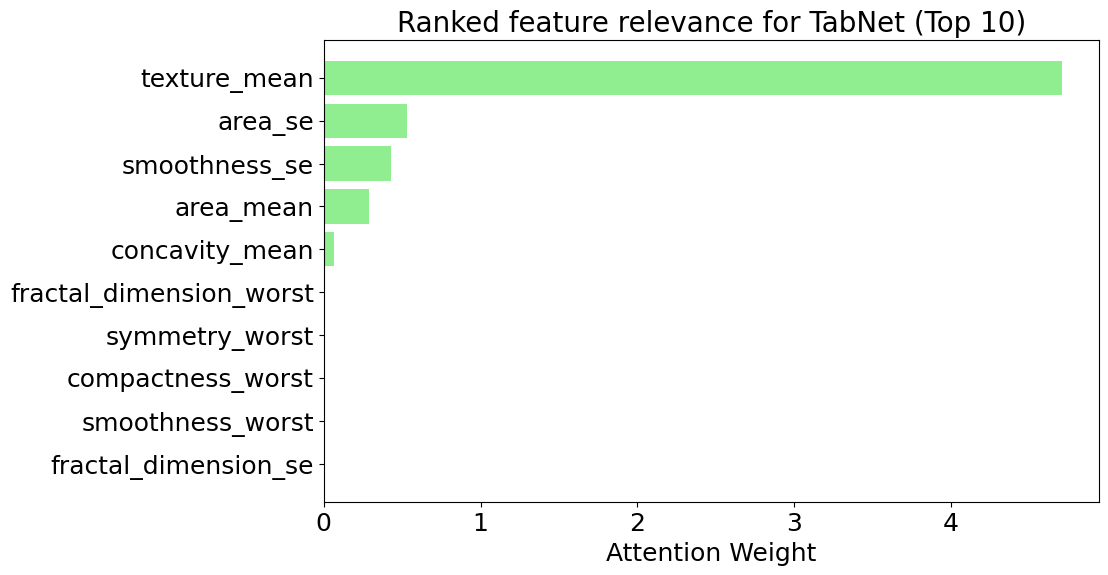

In [30]:
# visualization feature Relevance by TabNet (top10 features)
top_feature_names_tabnet = sorted_feature_names[:10]
top_attention_weights_tabnet = sorted_attention_weights[:10]
plt.figure(figsize=(10, 6))
plt.barh(top_feature_names_tabnet, top_attention_weights_tabnet, color='lightgreen')
plt.gca().tick_params(labelsize=18)
plt.xlabel('Attention Weight', fontsize=18)
plt.title('Ranked feature relevance for TabNet (Top 10)', fontsize=20)
plt.gca().invert_yaxis()  
plt.show()

In [31]:
# 4: Rectifier Network

# Hyperparameter Optimization
param_dist = {
    'hidden_layer_sizes': [(64, 128),(8, 16, 32), (16, 32, 64), (32, 64, 128),(64, 128, 256),(32, 64, 128, 256), 
                           (64, 128, 256, 512)],
    'max_iter': randint(1500, 3500),
    'early_stopping': [True],
    'n_iter_no_change': randint(100, 150),
    'validation_fraction': uniform(0.15, 0.25),
    'activation': ['relu'],
    'learning_rate_init': uniform(1e-5, 1e-3), 
    'alpha': uniform(1e-6, 1e-4),
    'beta_1': [0.9, 0.95, 0.85, 0.88],
    'beta_2': [0.999, 0.9999, 0.9995, 0.9999],
    'epsilon': [1e-8, 1e-9],
}
search_mlp = RandomizedSearchCV(
    MLPClassifier(random_state=random_state),
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=1,
    scoring='f1'
)

# Training Rectifier Network
search_mlp.fit(X_train_resampled, y_train_resampled)
best_params_mlp = search_mlp.best_params_
print("Best Parameters for MLP:", best_params_mlp)
print("Best f1 score for rectifier Network during training: ",  search_mlp.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for MLP: {'activation': 'relu', 'alpha': 2.375279087329586e-05, 'beta_1': 0.85, 'beta_2': 0.9999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (32, 64, 128), 'learning_rate_init': 0.0009366133535604363, 'max_iter': 2550, 'n_iter_no_change': 108, 'validation_fraction': 0.3408424955940823}
Best f1 score for rectifier Network during training:  0.9801070983546951


In [32]:
# Testing Rectifier Network 
best_mlp_model =search_mlp.best_estimator_
y_pred_mlp =best_mlp_model.predict(X_test_scaled)

# Performance evaluation Rectifier Network
print("\nEvaluation Metrics for Rectifier network:")
accuracy= accuracy_score(y_test, y_pred_mlp)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_mlp)
print("Precision:", precision)
recall= recall_score(y_test, y_pred_mlp)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_mlp)
print("F1 Score:", f1)
f_beta = fbeta_score(y_test, y_pred_mlp, beta=2)
print("F2 Score:", f_beta)
auc = roc_auc_score(y_test, best_mlp_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc)


Evaluation Metrics for Rectifier network:
Accuracy: 0.9385964912280702
Precision: 0.8723404255319149
Recall: 0.9761904761904762
F1 Score: 0.9213483146067415
F2 Score: 0.9534883720930233
AUC: 0.9814814814814814


In [33]:
#Feed fwd weights extraction- Local linear models
def mlp_relu_interpretation(model, x):
    w_list, b_list = model.coefs_, model.intercepts_

    layers = range(len(w_list))
    layer_j = np.copy(x)
    activation_pattern = []
    for j in layers:
        if j == len(w_list) - 1:
            continue
        layer_j = layer_j @ w_list[j] + b_list[j]
        layer_j[layer_j <= 0] = 0
        activation_pattern.extend(np.where(layer_j > 0))

    for j in layers:
        if j == 0:
            feature_weights_layer = w_list[j][:, activation_pattern[j]]
            intercepts_layer = b_list[j][activation_pattern[j]]
        elif 0 < j < len(w_list) - 1:
            layer_j_w_active_input = w_list[j][activation_pattern[j-1], :]
            layer_j_w_active_output = layer_j_w_active_input[:, activation_pattern[j]]
            feature_weights_layer = feature_weights_layer @ layer_j_w_active_output
            intercepts_layer = intercepts_layer @ layer_j_w_active_output + b_list[j][activation_pattern[j]]
        elif j == len(w_list) - 1:
            layer_j_w_active_input = w_list[j][activation_pattern[j-1], :]
            feature_weights_layer = feature_weights_layer @ layer_j_w_active_input
            intercepts_layer = intercepts_layer @ layer_j_w_active_input + b_list[j]

    return feature_weights_layer, intercepts_layer

In [34]:
# Local interpretation of feed fwd weights(Local linear models)
prediction = best_mlp_model.predict(instance_to_explain)[0]
print(f"Model Prediction: {prediction}")
feature_weights, intercepts = mlp_relu_interpretation(best_mlp_model, instance_to_explain)
feature_weights_tuples = [(feature_index, weight) for feature_index, weight in enumerate(feature_weights.flatten())]
sorted_feature_weights = sorted(feature_weights_tuples, key=lambda x: abs(x[1]), reverse=True)
feature_index_to_name = {i: name for i, name in enumerate(feature_names)}

sorted_feature_names = [feature_index_to_name.get(index, f'Unknown Feature {index}') for index, _ in sorted_feature_weights]
absolute_weights = [abs(weight) for _, weight in sorted_feature_weights]

Model Prediction: 0


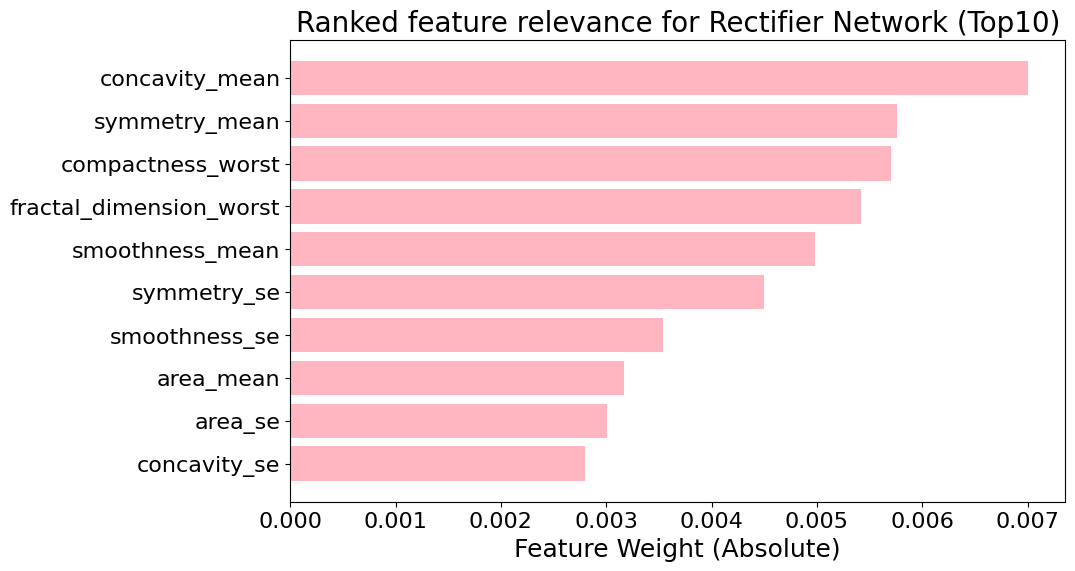

In [35]:
# Visualization of Feature relevance by Rectifier Network using absolute weights for top 10 features
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names[:10], absolute_weights[:10], color='lightpink')
plt.gca().tick_params(labelsize=16)
plt.xlabel('Feature Weight (Absolute)', fontsize=18)
plt.title('Ranked feature relevance for Rectifier Network (Top10)', fontsize=20)
plt.gca().invert_yaxis()  
plt.show()